# Initial

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import itertools
from collections import Counter

from combat.pycombat import pycombat

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.feature_selection import RFE

from xgboost import XGBClassifier
from time import time

## Code

### Fixing Datasets

In [2]:
def import_csv_files(path, starts_with, ends_with = ".csv"):
    """Imports csv files based on path and starting characters.

    :param path: Path of where to find csv files.
    :param starts_with: Starting characters of dataframes to find.
    :param ends_with: Type of file to load.
    
    :return: List of loaded csv files."""    
    file_list = []
    for filename in os.listdir(path):
        if filename.startswith(starts_with) and filename.endswith(ends_with):
            file_path = os.path.join(path, filename)
            file_list.append(pd.read_csv(file_path))
    return file_list

In [3]:
def same_shape(dfs : list):
    """Checks if all dataframes in a list have the same shape.

    :param dfs: List of dataframes.
    
    :return: Boolean value if all dataframes have the same shape."""    
    return all(df.shape == dfs[0].shape for df in dfs)

In [4]:
def get_average_from_m_datasets(dfs : list):
    """Pools imputed dataset into a single dataframe.

    :param dfs: List of dataframes.
    
    :return: Singular, pooled dataframe."""    
    if not same_shape:
        print("Dataframes must have the same shape")
    joined = pd.concat(dfs).reset_index() 
    return joined.groupby('index').mean()

### Cleaning and Perturbation

In [5]:
def run_combat(df, TMT_set_indices):
    """Run ComBat to reduce batch effect on a dataframe.

    :param df: Dataframe that ComBat is runned on.
    :param TMT_set_indices: Labels of which TMT batch each row belongs to.
    
    :return: DF with ComBat applied to it."""    
    return pycombat(df.T, TMT_set_indices).T

In [6]:
def add_noise(df, n_samples, std = 0.1):
    """Helper function for simple perturbation function. Adds gaussian noise to randomly sampled rows of the df passed as an argument.

    :param df: df filtered on class.
    :param n_samples: Number of samples to perform random sampling on.
    :param std: Standard deviation. Defaults to 0.1.
    
    :return: df with added perturbed samples."""      
    sampled_df = df.sample(n = n_samples, replace = True)
    gaussian_noise = np.random.normal(0, std, size=sampled_df.shape)
    return sampled_df + gaussian_noise

In [7]:
def simple_perturbation(X, y, n_samples_per_class = None, std = 0.1):
    """Performs a simple perturbation by sampling random rows of classes and adds gaussian noise to them

    :param X: Dataframe with samples to get perturbed.
    :param y: Class labels.
    :param n_samples_per_class: Decides how many samples per class that are going to be sampled, defaults to None. 
    If none -> all classes will get equal weight according to size of current largest class.
    :param std: How much the noise can deviate from the mean (Standard dev.), defaults to 0.1
    
    :return: A df with the perturbed samples. A list stating which row belongs to which class."""    
    classes = y.value_counts()
    if n_samples_per_class is None:
        largest_class = classes.argmax()
        largest_n_samples = classes.pop(largest_class)
    else:
        largest_n_samples = n_samples_per_class
    df_list = []
    y_new_classes = list(y)
    for idx, n_samples in classes.items():
        perturbed = add_noise(X[y == idx], largest_n_samples - n_samples, std=std)
        df_list.append(perturbed)
        y_new_classes = y_new_classes + [idx] * len(perturbed)
    return pd.concat([X] + df_list, axis=0), y_new_classes

### GridSearch and Feature Importance

In [8]:
def get_best_params(X, y, models, params, cv = 5, n_jobs = -1):
    """Runs GridSearchCV in order to find best parameters on one or more models.

    :param X: The training data for the models.
    :param y: The correct classification of the training data.
    :param models: A list of models to be trained.
    :param params: A dictionary with the parameters for each model to be GridSearched.
    :param cv: The K-fold cross validation value.
    :param n_jobs: Number of cores to use for GridSearchCV.
    
    :return: DF with ComBat applied to it."""   
    best_params = {}
    for model, param in zip(models, params):
        start_time = time()
        print(f"\033[97m{model.name} started.")
        clf = GridSearchCV(model, param_grid=param, cv=cv, n_jobs=n_jobs, scoring="f1_weighted")
        clf.fit(X, y)
        best_params[model.name] = clf.best_params_
        print(f"{model.name} is done in {time() - start_time} seconds.\n" )
    return best_params

In [9]:
def get_best_params_bayes(X, y, models, params, n_iter = 50, cv = 3, n_jobs = -1):
    """Runs GridSearchCV in order to find best parameters on one or more models.

    :param X: The training data for the models.
    :param y: The correct classification of the training data.
    :param models: A list of models to be trained.
    :param params: A dictionary with the parameters for each model to be GridSearched.
    :param cv: The K-fold cross validation value.
    :param n_jobs: Number of cores to use for GridSearchCV.

    :return: DF with ComBat applied to it"""   
    best_params = {}
    for model, param in zip(models, params):
        start_time = time()
        print(f"\033[97m{model.name} started.")
        clf = BayesSearchCV(model, search_spaces=param, n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring="f1_weighted")
        clf.fit(X, y)
        best_params[model.name] = clf.best_params_
        print(f"{model.name} is done in {time() - start_time} seconds.\n" )
    return best_params

In [10]:
def get_average_feature_importance_XGB_RF(models, df):
    """Extracts feature importance from the same models over multiple iterations, averaging them over each iteration.

    :param models: Models to extract feature importance from.
    :param df: Original dataframe in order to map feature importances to column names.
    
    :return: Dictionary with column name as keys and average feature importance as values."""  
    avg_feature_importance = {}
    for model in models:
        importances = model.feature_importances_
        for index, importance in enumerate(importances):
            name = df.columns[index]
            if name in avg_feature_importance:
                avg_feature_importance[name] += importance
            else:
                avg_feature_importance[name] = importance
    for feature, total in avg_feature_importance.items():
        mean = total / len(models)
        avg_feature_importance[feature] = mean
    
    return avg_feature_importance

In [49]:
def get_average_feature_importance_LR(models, df):
    """Extracts feature importance from the same models over multiple iterations, averaging them over each iteration.

    :param models: Models to extract feature importance from.
    :param df: Original dataframe in order to map feature importances to column names.
    
    :return: Dictionary with column name as keys and average feature importance as values."""  
    all_coefficients = []
    feature_names = df.columns.tolist()
    max_length = max(len(model.coef_[0]) for model in models)
    
    for model in models:
        coefficients = model.coef_[0]
        padded_coefficients = np.pad(coefficients, (0, max_length - len(coefficients)), mode='constant', constant_values=np.nan)
        all_coefficients.append(padded_coefficients)

    avg_coefficients = np.nanmean(all_coefficients, axis=0) 
    normalized_coefficients = avg_coefficients / np.nansum(avg_coefficients)
    feature_importance = dict(zip(feature_names, normalized_coefficients))
    
    return feature_importance


In [12]:
def get_average_feature_importance(d, model_name, df):
    """Wrapper function in order to extract average feature importance across multiple iterations of multiple models.

    :param d: Dictionary with models.
    :param model_name: Name of the model.
    :param df: Original dataframe in order to map feature importances to column names.
    
    :return: Dictionary with column name as keys and average feature importance as values."""  
    models = [model for key, model in d.items() if key.startswith(f'{model_name}')]
    if model_name == "LR":
        return get_average_feature_importance_LR(models, df)
    return get_average_feature_importance_XGB_RF(models, df)

In [13]:
def calculate_average(dictionaries):
    """Gets the average feature importance from multiple dictionaries
    
    :param dictionaries: List of dictionaries to be averaged.

    :return: Dictionary with averaged values."""
    sum_values = {}
    count_values = {}
    
    for dictionary in dictionaries:
        for key, value in dictionary.items():
            if key not in sum_values:
                sum_values[key] = 0
                count_values[key] = 0
            sum_values[key] += value
            count_values[key] += 1
    
    averages = {}
    for key, total_sum in sum_values.items():
        averages[key] = total_sum / count_values[key]
    
    return averages

### Voting

In [14]:
def hard_voting(models):
    """Hard voting based on predictions from multiple models.

    :param models: List of trained models.
    
    :return: Hard voting results."""  
    predictions = [model.prediction for model in models]
    predictions = [[row[i] for row in predictions] for i in range(len(predictions[0]))]
    results = []
    for index, p in enumerate(predictions):
        most_common = Counter(p).most_common()
        if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
            probabilities = [model.probability[index] for model in models]
            probabilities = [[row[i] for row in probabilities] for i in range(len(probabilities[0]))]
            probabilities = [sum(sublist) for sublist in probabilities]
            if len(most_common) > 2 and most_common[0][1] == most_common[2][1]:
                results.append(np.argmax(probabilities))
            else:
                probabilities[most_common[2][0]] = 0
                results.append(np.argmax(probabilities))
        else:
            results.append(most_common[0][0])

    return results  

In [15]:
def summed_votes(pred_proba):
    """Summs the soft vote prediction probability together.

    :param pred_proba: The prediciton probability from the different models.
    
    :return: The summized prediction probability."""  
    length = len(pred_proba[0])
    summed_columns = []

    for i in range(length):
        column_sum = np.sum([preds[i] for preds in pred_proba], axis=0)
        summed_columns.append(column_sum)

    return summed_columns

In [16]:
def soft_voting(models):
    """Soft voting based on predictions from multiple models.

    :param models: List of trained models.
    
    :return: Soft voting results."""  
    probabilities = [model.probability for model in models]
    probabilities = [[row[i] for row in probabilities] for i in range(len(probabilities[0]))]
    results = []
    for p in probabilities:
        vote = summed_votes(p)
        results.append(np.argmax(vote))
    return results

### Plotting Code

In [17]:
def plot_percentiles(percentiles, labels, title="Accuracy scores", ax=None):
    """Plot percentiles against labels.

    :param percentiles: List of percentiles.
    :param labels: List of strings (labels).
    :param title: Title of the plot.
    :param ax: Axes object to plot on."""
    x = range(len(labels))
    if ax is None:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()

    ax.bar(x, percentiles, color='skyblue')
    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1)
    plt.show()


In [18]:
def plot_feature_importance(dict0, dict1, dict2, dict3, models=["Average","Model1", "Model2", "Model3"], main_model = None, colours = ["tab:cyan", "tab:blue", "tab:orange", "tab:olive"]):
    """Plots feature importance from three dictionaries.

    :param dict: 
    :param labels: List of strings (labels)."""
    sorted_dict0 = dict(sorted(dict0.items(), key=lambda item: item[1], reverse=True))
    top_features_dict0 = list(sorted_dict0.items())[:5]
    top_features_keys = [key for key, _ in top_features_dict0]

    feature_importance_dict0 = [val for _, val in top_features_dict0]
    feature_importance_dict1 = [dict1[key] for key in top_features_keys]
    feature_importance_dict2 = [dict2[key] for key in top_features_keys]
    feature_importance_dict3 = [dict3[key] for key in top_features_keys]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar([i - 0.3 for i in range(5)], feature_importance_dict0, width=0.2, color=colours[0], label=models[0])
    ax.bar([i - 0.1 for i in range(5)], feature_importance_dict1, width=0.2, color=colours[1], label=models[1])
    ax.bar([i + 0.1 for i in range(5)], feature_importance_dict2, width=0.2, color=colours[2], label=models[2])
    ax.bar([i + 0.3 for i in range(5)], feature_importance_dict3, width=0.2, color=colours[3], label=models[3])

    ax.set_xticks(range(5))
    ax.set_xticklabels(top_features_keys, rotation=90)
    ax.set_xlabel('Features')
    ax.set_ylabel('Importance')
    ax.set_title(f"Top 5 out of {len(sorted_dict0)} averaged features from {models[1]}, {models[2]} and {models[3]}.")
    ax.legend()

    plt.tight_layout()
    plt.show()

In [19]:
def plot_confusion_matrix(ax, cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """Plots a confusion matrix.

    :param ax: Axis to print confusion matrix on.
    :param cm: Pre-made sklearn confusion matrix.
    :param classes: Values of predicted classes.
    :param normalize: If True, normalizes the values between 0 and 1.
    :param title: Title of confusion matrix.
    :param cmap: Colour of confusion matrix.""" 
    class_labels = ["CN", "MCI", "AD"]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_labels, rotation=45) 
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')


In [20]:
def plot_vote_confusion_matrix(y_predictions, y_real, names, title="Confusion Matrix"):
    """Plot confusion matrices for multiple models along with accuracy scores.

    :param y_predictions: A list of lists where each inner list contains predictions for a model.
    :param y_real: The real y values.
    :param names: A list containing names of the models.
    :param title: Title of the plot."""
    num_models = len(y_predictions)
    num_classes = len(set(y_real))
    
    num_rows = 2
    num_cols = 3

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 12))

    for i, ax in enumerate(axs.flat[:-1]):
        if i < num_models:
            cnf_matrix = confusion_matrix(y_real, y_predictions[i])
            ax.set_title(names[i])
            plot_confusion_matrix(ax, cnf_matrix, classes=range(num_classes), title=names[i])

    percentiles = [accuracy_score(y_real, y_predictions[0]),
                   accuracy_score(y_real, y_predictions[1]),
                   accuracy_score(y_real, y_predictions[2]),
                   accuracy_score(y_real, y_predictions[3]),
                   accuracy_score(y_real, y_predictions[4])]
    labels = ["Hard Vote", "Soft Vote", "XGB", "LR", "RF"]
    plot_percentiles(percentiles, labels, "Accuracy on validation data in K-fold.", ax=axs[-1, -1])

    plt.show()


In [21]:
def get_roc_auc(y_test, y_scores_list):
    """Plots roc_auc for a model.

    :param y_test: A list of y used during k-fold validation.
    :param y_scores_list: The predicted y values."""
    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)

    for i, y_scores in enumerate(y_scores_list):
        y_scores = np.array(y_scores)
        auc_score = roc_auc_score(y_onehot_test, y_scores, average='micro')

        display = RocCurveDisplay.from_predictions(
            y_onehot_test.ravel(),
            y_scores.ravel(),
            name=f"Model {i+1} (AUC = {auc_score:.2f})",
            color=f"C{i}",
            plot_chance_level=True,
        )
        _ = display.ax_.set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
        )

In [22]:
def get_scores(models, votes, y_true, get_graphs=False):
    """Plots AUC, ACC and F1 from all models and hard/soft votes.

    :param models: Dict with all models.
    :param votes: Dict with all votes from the models.
    :param y_true: The y values across the K-fold validation.
    :param get_graphs: If set to true, prints confusion matrix and roc curve."""
    hard_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Hard')] for item in sublist]
    soft_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Soft')] for item in sublist]
    xgb_votes = [item for sublist in [value.prediction for key, value in models.items() if key.startswith('XGB')] for item in sublist]
    lr_votes = [item for sublist in [value.prediction for key, value in models.items() if key.startswith('LR')] for item in sublist]
    rf_votes = [item for sublist in [value.prediction for key, value in models.items() if key.startswith('RF')] for item in sublist]
    xgb_prob = [item for sublist in [value.probability for key, value in models.items() if key.startswith('XGB')] for item in sublist]
    lr_prob = [item for sublist in [value.probability for key, value in models.items() if key.startswith('LR')] for item in sublist]
    rf_prob = [item for sublist in [value.probability for key, value in models.items() if key.startswith('RF')] for item in sublist]
    y_trues = [item for sublist in [list(series) for series in y_true.values()] for item in sublist]

    def format_line(label, auc_ovr, auc_ovo, acc, f1):
        return f"{label:<10}\tAUC OVR: {auc_ovr:<20}\tAUC OVO: {auc_ovo:<20}\tACC: {acc:<20}\tF1: {f1}"

    print(format_line("XGB", roc_auc_score(y_trues, xgb_prob, multi_class='ovr', average="micro"), roc_auc_score(y_trues, xgb_prob, multi_class='ovo'), accuracy_score(y_trues, xgb_votes), f1_score(y_trues, xgb_votes, average='weighted')))
    print(format_line("LR", roc_auc_score(y_trues, lr_prob, multi_class='ovr', average="micro"), roc_auc_score(y_trues, lr_prob, multi_class='ovo'), accuracy_score(y_trues, lr_votes), f1_score(y_trues, lr_votes, average='weighted')))
    print(format_line("RF", roc_auc_score(y_trues, rf_prob, multi_class='ovr', average="micro"), roc_auc_score(y_trues, rf_prob, multi_class='ovo'), accuracy_score(y_trues, rf_votes), f1_score(y_trues, rf_votes, average='weighted')))
    print(format_line("Soft Vote", "", "", accuracy_score(y_trues, soft_votes), f1_score(y_trues, soft_votes, average='weighted')))
    print(format_line("Hard Vote", "", "", accuracy_score(y_trues, hard_votes), f1_score(y_trues, hard_votes, average='weighted')))

    if get_graphs:
        y_predictions = [hard_votes, soft_votes, xgb_votes, lr_votes, rf_votes]
        model_names = ["Hard Votes", "Soft Votes", "XGBoost", "Logistic Regression", "Random Forest"]
        plot_vote_confusion_matrix(y_predictions, y_trues, model_names)
        get_roc_auc(y_trues, [xgb_prob, lr_prob, rf_prob])

### Main Pipeline

In [23]:
def get_union_features(state, n_features, df, y):
    """Quick and dirty solution to get DF union during k-fold validations.

    :param state: Dict with all models.
    :param n_features: Dict with all votes from the models.
    :param df: The y values across the K-fold validation.
    :param y: The y values across the K-fold validation.

    :return: Dataframe with df_union feature selection."""    
    lasso = Lasso(alpha=0.001, max_iter=5000, random_state=state)
    lr = LogisticRegression(penalty='elasticnet', solver="saga", multi_class="multinomial", max_iter=8000, C=0.01, l1_ratio=0.8, random_state=state)
    rf = RandomForestClassifier(n_estimators=350, criterion='gini', max_depth=10, max_features='sqrt', min_samples_leaf=1, random_state=state)
    xgb = XGBClassifier(eta=0.2, gamma=0.01, n_estimators=150, reg_lambda=0.85, max_depth=5, min_child_weight=0.45, subsample=0.6, seed=state)

    n_features_p0 = 500
    step_p0 = 50

    #LASSO
    rfe_lasso0 = RFE(lasso, n_features_to_select=n_features_p0, step=step_p0)
    _ = rfe_lasso0.fit_transform(df, y=y)

    #LR
    rfe_lr0 = RFE(lr, n_features_to_select=n_features_p0, step=step_p0)
    _ = rfe_lr0.fit_transform(df, y=y)

    #RF
    rfe_rf0 = RFE(rf, n_features_to_select=n_features_p0, step=step_p0)
    _ = rfe_rf0.fit_transform(df, y=y)

    #XGB
    rfe_xgb0 = RFE(xgb, n_features_to_select=n_features_p0, step=step_p0)
    _ = rfe_xgb0.fit_transform(df, y=y)

    #Feature Names.
    lasso_cont0 = rfe_lasso0.get_feature_names_out()
    lr_cont0 = rfe_lr0.get_feature_names_out()
    rf_cont0 = rfe_rf0.get_feature_names_out()
    xgb_cont0 = rfe_xgb0.get_feature_names_out()

    #Dataframes based on extracted features.
    df_lasso_cont0 = df[lasso_cont0]
    df_lr_cont0 = df[lr_cont0]
    df_rf_cont0 = df[rf_cont0]
    df_xgb_cont0 = df[xgb_cont0]

    n_features_p1 = 100
    step_p1 = 10

    #LASSO
    rfe_lasso1 = RFE(lasso, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_lasso1.fit_transform(df_lasso_cont0, y=y)

    #LR
    rfe_lr1 = RFE(lr, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_lr1.fit_transform(df_lr_cont0, y=y)

    #RF
    rfe_rf1 = RFE(rf, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_rf1.fit_transform(df_rf_cont0, y=y)

    #XGB
    rfe_xgb1 = RFE(xgb, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_xgb1.fit_transform(df_xgb_cont0, y=y)

    #Feature Names.
    lasso_cont1 = rfe_lasso1.get_feature_names_out()
    lr_cont1 = rfe_lr1.get_feature_names_out()
    rf_cont1 = rfe_rf1.get_feature_names_out()
    xgb_cont1 = rfe_xgb1.get_feature_names_out()

    #Dataframes based on extracted features.
    df_lasso_cont1 = df[lasso_cont1]
    df_lr_cont1 = df[lr_cont1]
    df_rf_cont1 = df[rf_cont1]
    df_xgb_cont1 = df[xgb_cont1]

    #PART 2
    n_features_p2 = n_features
    step_p2 = 1

    #LASSO
    rfe_lasso_p2 = RFE(lasso, n_features_to_select=n_features_p2, step=step_p2)
    _ = rfe_lasso_p2.fit_transform(df_lasso_cont1, y=y)

    #LR
    rfe_lr_p2 = RFE(lr, n_features_to_select=n_features_p2, step=step_p2)
    _ = rfe_lr_p2.fit_transform(df_lr_cont1, y=y)

    #RF
    rfe_rf_p2 = RFE(rf, n_features_to_select=n_features_p2, step=step_p2)
    _ = rfe_rf_p2.fit_transform(df_rf_cont1, y=y)

    #XGB
    rfe_xgb_p2 = RFE(xgb, n_features_to_select=n_features_p2, step=step_p2)
    _ = rfe_xgb_p2.fit_transform(df_xgb_cont1, y=y)

    #Number of features in current dataset.
    set_lasso_p2 = set(rfe_lasso_p2.get_feature_names_out())
    set_lr_p2 = set(rfe_lr_p2.get_feature_names_out())
    set_rf_p2 = set(rfe_rf_p2.get_feature_names_out())
    set_xgb_p2 = set(rfe_xgb_p2.get_feature_names_out())

    #Dataset after feature extraction.
    set_union = set_lasso_p2.union(set_lr_p2, set_rf_p2, set_xgb_p2)
    list_union = list(set_union)
    df_union = df[list_union]

    return df_union

In [24]:
def create_models(iteration):
    """Creates 3 new basemodels with names depending on iteration.

    :param iteration: Current iteration in K-Fold cross validation.
    
    :return: List of base models."""      
    xgboost = XGBClassifier()
    xgboost.name = f"XGB {iteration}"
    lr = LogisticRegression()
    lr.name = f"LR {iteration}"
    rf = RandomForestClassifier()
    rf.name = f"RF {iteration}"

    return [xgboost, lr, rf]

In [25]:
def pipeline(X, y, params, K = 10, n_samples_per_class = 41, bayes = False, corruption = False):
    """Main pipeline code that runs K-fold validation.

    :param X: Dataframe of X values for training.
    :param y: Pandas series of real class values for training 
    :param params: Parameter settings to get best parameters from.
    :param K: Number of K-fold iterations to run.
    :param n_samples_per_class: Number of samples per class that should exist after perturbation.
    :param bayes: GridSearchCV or BayesSearchCV for best params each k-fold.
    :param corruption: Set to smote or perturbation to augment synthesised data.

    :return all_models: Dictionary with all models through all k-folds.
    :return votes: Dictionary with votes on validation data for all models through all k-folds.
    :return y_true: Dictionary with all true y labels through each k-fold.
    :return unions: Subset of features used for each k-fold after df_union."""  
    all_models = {}
    votes = {}
    y_true = {}
    unions = {}
    k_fold = StratifiedKFold(n_splits=K, shuffle=True)
    print("\n-------------- Starting K-fold cross validation: --------------\n")
    for i, (train_index, test_index) in enumerate(k_fold.split(X, y)):
        print(f"\033[94mK-Fold validation: Iteration {i}.")
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        print(f'Doing Feature Extraction:\n')
        df_cols = get_union_features(i, 20, X_train, y_train)
        X_train = X_train[df_cols.columns]
        X_test = X_test[df_cols.columns]

        if corruption == "smote":
            smote = SMOTE(k_neighbors=5, sampling_strategy={0: n_samples_per_class, 1: n_samples_per_class, 2: n_samples_per_class})
            X_train, y_train = smote.fit_resample(X_train, y_train)
        if corruption == "perturbation":
            X_train, y_train = simple_perturbation(X_train, y_train, n_samples_per_class=n_samples_per_class)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        models = create_models(i)
        if bayes:
            best_params = get_best_params_bayes(X_train, y_train, models, params)
        else:
            best_params = get_best_params(X_train, y_train, models, params)
        y_true[f'{i}'] = y_test
        best_models = []
        for model in models:
            best_model = model.__class__(**best_params[model.name])
            best_model.name = model.name
            best_model.fit(X_train, y_train)
            best_model.prediction = best_model.predict(X_test)
            best_model.probability = best_model.predict_proba(X_test)
            all_models[best_model.name] = best_model
            best_models.append(best_model)
        hard = f'Hard vote {i}'
        soft = f'Soft vote {i}'
        union = f'Union {i}'
        votes[hard] = hard_voting(best_models)
        votes[soft] = soft_voting(best_models)
        unions[union] = df_cols.columns
        print(f'\033[92mHard vote F1 score: {f1_score(y_test, votes[hard], average="weighted")}')
        print(f'\033[92mSoft vote F1 score: {f1_score(y_test, votes[soft], average="weighted")}\n')
    
    return all_models, votes, y_true, unions

# Pipeline

## Data

In [29]:
#Loading dataframes, Pooling and classes. (USE FOR PROTEIN)
path = "./Data/data files/imputed"
starts_with = "protein_lumbar"
dfs = import_csv_files(path=path, starts_with=starts_with)
df_main = get_average_from_m_datasets(dfs)

df_classes = pd.read_csv("./Data/data files/iNPH_data_protein_median.csv", usecols=["Cortical_biopsy_grouping", "CSF_type", "TMT Set"])
df_classes = df_classes[df_classes["CSF_type"] == "L"].reset_index(drop=True)
tmt_set = df_classes["TMT Set"]
y = df_classes["Cortical_biopsy_grouping"]

df_main = run_combat(df_main, tmt_set)

Found 15 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


In [27]:
#Loading dataframes, Pooling and classes. (USED FOR PEPTIDE)
#df_main = pd.read_csv('./Data/data files/df_peptide_ventricular.csv')
#df_classes = pd.read_csv("./Data/data files/iNPH_data_peptide_median.csv", usecols=["Cortical_biopsy_grouping", "CSF_type", "TMT Set"])
#df_classes = df_classes[df_classes["CSF_type"] == "V"].reset_index(drop=True)
#tmt_set = df_classes["TMT Set"]
#y = df_classes["Cortical_biopsy_grouping"]
#
#df_main = run_combat(df_main, tmt_set)

## Parameters

In [31]:
#Grid Params, Maximized.
xgboost_params = {"eta": [0.2, 0.3],
                  "min_child_weight": [0.45],
                  "gamma": [0.0001, 0.01, 1],
                  "subsample": [0.4, 0.8],
                  "reg_lambda": [0.85],
                  "lambda": [0.5, 0.7],
                  "max_depth": [4, 6],
                  "n_estimators": [150],
                  "objective": ["multi:softmax"],
                  "num_class": [3]}
lr_params = {"penalty": ["elasticnet"],
              "C": [0.0001, 0.01, 1, 10, 100],
              "solver": ["saga"],
              "multi_class": ["multinomial"],
              "max_iter": [4000, 8000, 12000],
              "tol": [1e-2, 1e-3, 1e-4],
              "n_jobs": [-1],
              "l1_ratio": [0, 0.3, 0.5, 0.8, 1]}
rf_params = {"n_estimators": [100, 300],
             "criterion": ["gini", "entropy"],
             "max_depth": [5, 10, 20],
             "max_features": ["sqrt"],
             "n_jobs": [-1],
             "min_samples_leaf": [1,2,4]}

params_grid = [xgboost_params, lr_params, rf_params]

In [32]:
#Bayes Params.
xgboost_params = {"eta": Real(0.2, 0.3),
                  "min_child_weight": Real(0.4, 0.5),
                  "gamma": Real(0.0001, 1),
                  "subsample": Real(0.4, 0.8),
                  "reg_lambda": Real(0.8, 0.9),
                  "max_depth": Integer(1, 10),
                  "n_jobs": [-1],
                  "n_estimators": Integer(50, 500),
                  "objective": ["multi:softmax"],
                  "num_class": [3]}
lr_params = {"penalty": Categorical(["elasticnet"]),
              "C": Real(0.00001, 100),
              "solver": Categorical(["saga"]),
              "multi_class": Categorical(["multinomial"]),
              "max_iter": Integer(1000, 12000),
              "tol": Real(1e-4, 1e-2),
              "n_jobs": [-1],
              "l1_ratio": Real(0, 1)}
rf_params = {"n_estimators": Integer(50, 500),
             "criterion": Categorical(["gini", "entropy"]),
             "max_depth": Integer(5, 50),
             "max_features": Categorical(["sqrt", "log2"]),
             "n_jobs": [-1],
             "min_samples_leaf": Integer(1,5)}

params_bayes = [xgboost_params, lr_params, rf_params]

In [33]:
#Bayes Params, Simplified.
xgboost_params = {"eta": Real(0.1, 0.5),
                  "max_depth": Integer(1, 20),
                  "n_jobs": [-1],
                  "n_estimators": Integer(5, 500),
                  "objective": ["multi:softmax"],
                  "num_class": [3]}
lr_params = {"penalty": Categorical(["elasticnet"]),
              "C": Real(0.000001, 100),
              "solver": Categorical(["saga"]),
              "multi_class": Categorical(["multinomial"]),
              "max_iter": Integer(1000, 12000),
              "n_jobs": [-1],
              "l1_ratio": Real(0, 1)}
rf_params = {"n_estimators": Integer(5, 500),
             "max_depth": Integer(2, 50),
             "n_jobs": [-1],
             "min_samples_leaf": Integer(1,5)}

params_bayes_simple = [xgboost_params, lr_params, rf_params]

## K-Fold-Pipeline

In [35]:
#Run Pipeline
all_models, votes, y_true, df_unions = pipeline(df_main, y, params_grid, bayes=False, corruption=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
Doing Feature Extraction:



c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.599e-03, tolerance: 3.568e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.583e-03, tolerance: 3.568e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.605e-03, toleranc

XGB 0 started.
XGB 0 is done in 3.974308967590332 seconds.

LR 0 started.
LR 0 is done in 2.7499072551727295 seconds.

RF 0 started.
RF 0 is done in 3.1596901416778564 seconds.

Hard vote F1 score: 0.30864197530864196
Soft vote F1 score: 0.30864197530864196

K-Fold validation: Iteration 1.
Doing Feature Extraction:

XGB 1 started.
XGB 1 is done in 1.26926851272583 seconds.

LR 1 started.
LR 1 is done in 2.6045422554016113 seconds.

RF 1 started.
RF 1 is done in 3.4922525882720947 seconds.

Hard vote F1 score: 0.6195286195286196
Soft vote F1 score: 0.7365079365079364

K-Fold validation: Iteration 2.
Doing Feature Extraction:

XGB 2 started.
XGB 2 is done in 1.3063545227050781 seconds.

LR 2 started.
LR 2 is done in 2.7911200523376465 seconds.

RF 2 started.
RF 2 is done in 3.1671981811523438 seconds.

Hard vote F1 score: 0.3047619047619048
Soft vote F1 score: 0.22574955908289246

K-Fold validation: Iteration 3.
Doing Feature Extraction:

XGB 3 started.
XGB 3 is done in 1.377657175064087

c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.790e-03, tolerance: 3.541e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.765e-03, tolerance: 3.541e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.651e-03, toleranc

XGB 4 started.
XGB 4 is done in 1.3598003387451172 seconds.

LR 4 started.
LR 4 is done in 2.587197780609131 seconds.

RF 4 started.
RF 4 is done in 3.3819355964660645 seconds.

Hard vote F1 score: 0.303030303030303
Soft vote F1 score: 0.303030303030303

K-Fold validation: Iteration 5.
Doing Feature Extraction:

XGB 5 started.
XGB 5 is done in 1.2950212955474854 seconds.

LR 5 started.
LR 5 is done in 2.560549020767212 seconds.

RF 5 started.
RF 5 is done in 3.0982584953308105 seconds.

Hard vote F1 score: 0.45833333333333326
Soft vote F1 score: 0.35714285714285715

K-Fold validation: Iteration 6.
Doing Feature Extraction:

XGB 6 started.
XGB 6 is done in 1.2509472370147705 seconds.

LR 6 started.
LR 6 is done in 2.4077048301696777 seconds.

RF 6 started.
RF 6 is done in 3.11262583732605 seconds.

Hard vote F1 score: 0.35714285714285715
Soft vote F1 score: 0.35714285714285715

K-Fold validation: Iteration 7.
Doing Feature Extraction:

XGB 7 started.
XGB 7 is done in 1.2731411457061768 

## Results

XGB       	AUC OVR: 0.6141176470588234  	AUC OVO: 0.5452654232424677  	ACC: 0.4235294117647059  	F1: 0.39922798825035777
LR        	AUC OVR: 0.6420069204152249  	AUC OVO: 0.619560019129603   	ACC: 0.4470588235294118  	F1: 0.44892664092664086
RF        	AUC OVR: 0.6431833910034602  	AUC OVO: 0.5297226207556193  	ACC: 0.38823529411764707 	F1: 0.34784313725490196
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.43529411764705883 	F1: 0.4093060145406478
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.4117647058823529  	F1: 0.3796412181894034


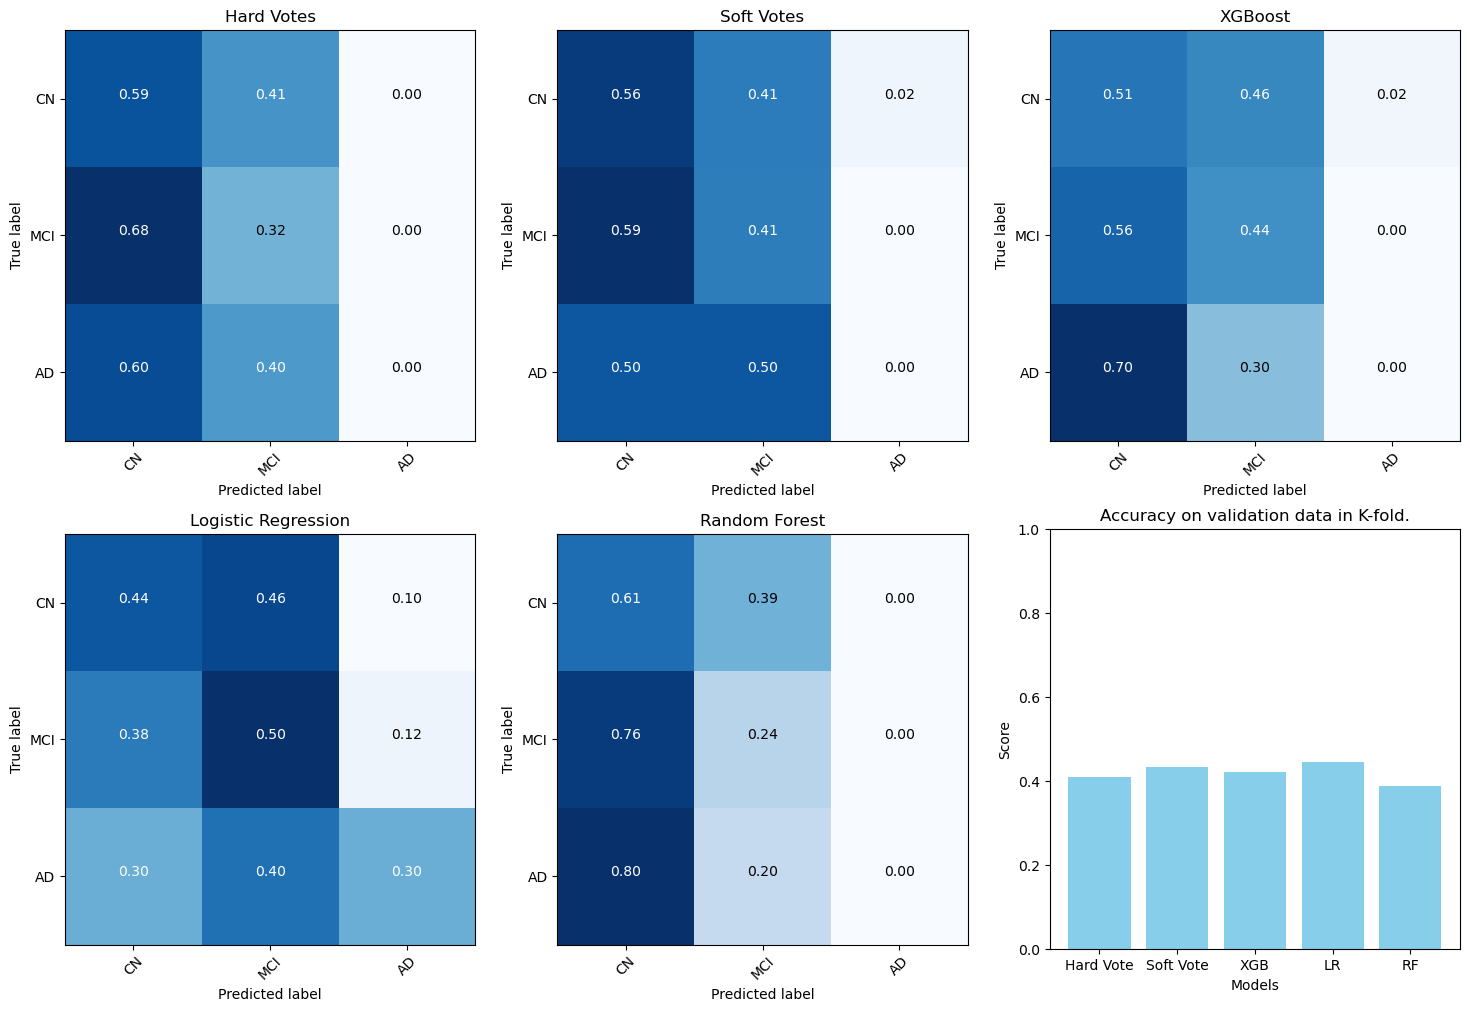

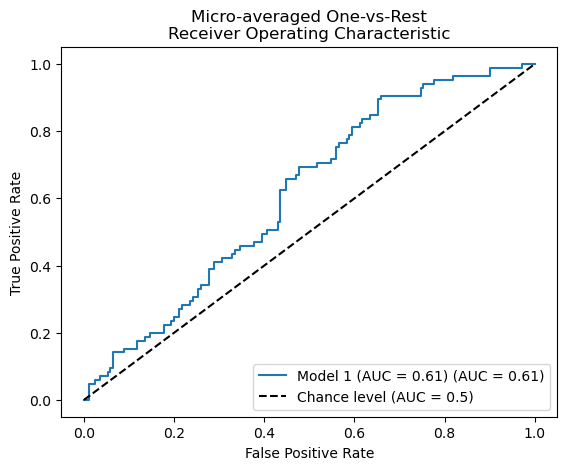

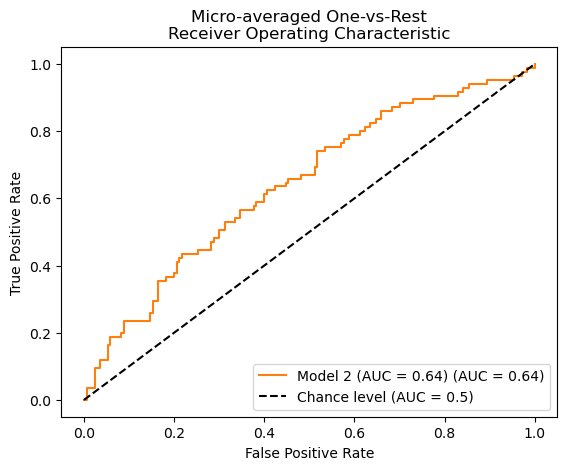

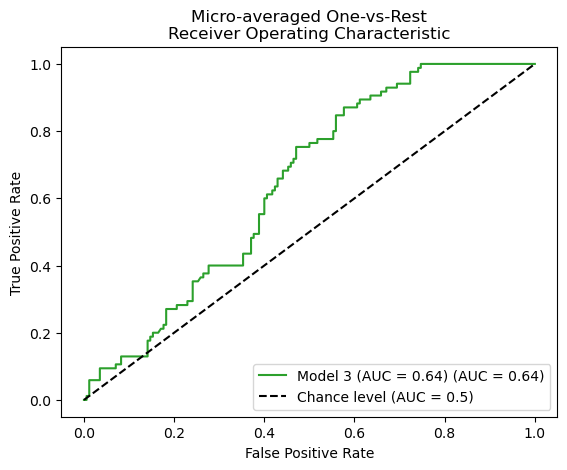

In [36]:
#Combining K-fold results.
get_scores(all_models, votes, y_true, get_graphs=True)

### Union Stuff

In [37]:
all_unions = [lst for lst in df_unions.values()]

all_features_in_all_unions = [item for sublist in all_unions for item in sublist]

feature_occurences = Counter(all_features_in_all_unions)

In [38]:
filtered_features = {word: count for word, count in feature_occurences.items() if count > 8}

In [39]:
all_features_in_all_unions2 = [item for item in filtered_features]

df_test = list(set(all_features_in_all_unions2))

In [40]:
len(df_test)

24

In [41]:
len(feature_occurences)

277

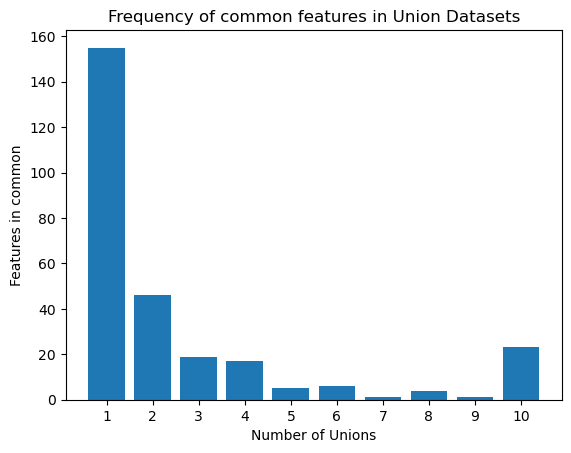

In [42]:
counter_data = feature_occurences

frequencies = list(counter_data.values())

# Count the occurrences of each frequency
frequency_counts = Counter(frequencies)

# Prepare data for plotting
count_values = list(frequency_counts.keys())
counts_occurrences = list(frequency_counts.values())

# Plot the histogram
plt.bar(count_values, counts_occurrences)
plt.xlabel('Number of Unions')
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.ylabel('Features in common')
plt.title('Frequency of common features in Union Datasets')
plt.show()

### Confusion Matrix (Average across all runs)

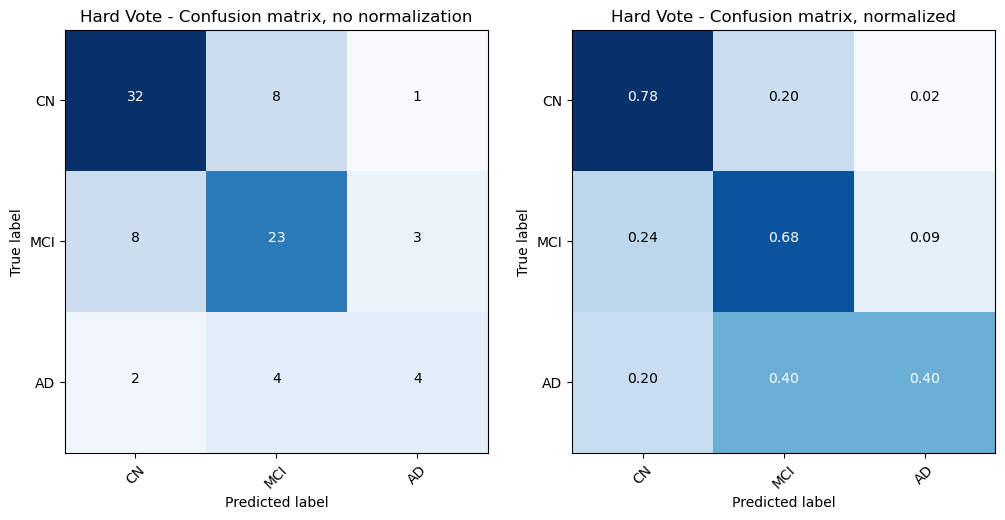

In [169]:
#Confusion Matrix (HARD VOTE).
plot_vote_confusion_matrix(y_trues, hard_votes, title="Hard Vote - Confusion matrix")

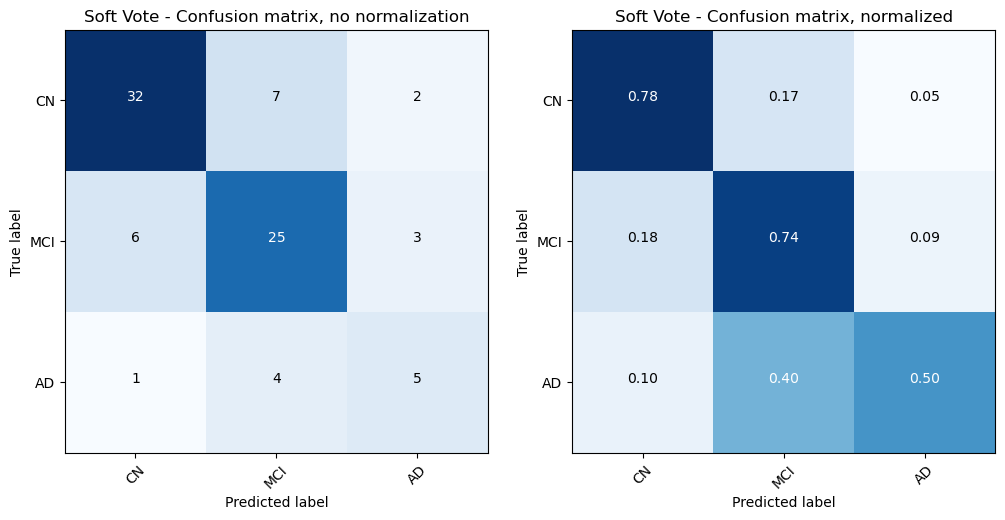

In [170]:
#Confusion Matrix (SOFT VOTE).
plot_vote_confusion_matrix(y_trues, soft_votes, title="Soft Vote - Confusion matrix")

### Feature Importance (Average across all runs)

In [172]:
RF_avg_feature_importance = get_average_feature_importance(all_models, "RF", df_main)
XGB_avg_feature_importance = get_average_feature_importance(all_models, "XGB", df_main)
LR_avg_feature_importance = get_average_feature_importance(all_models, "LR", df_main)

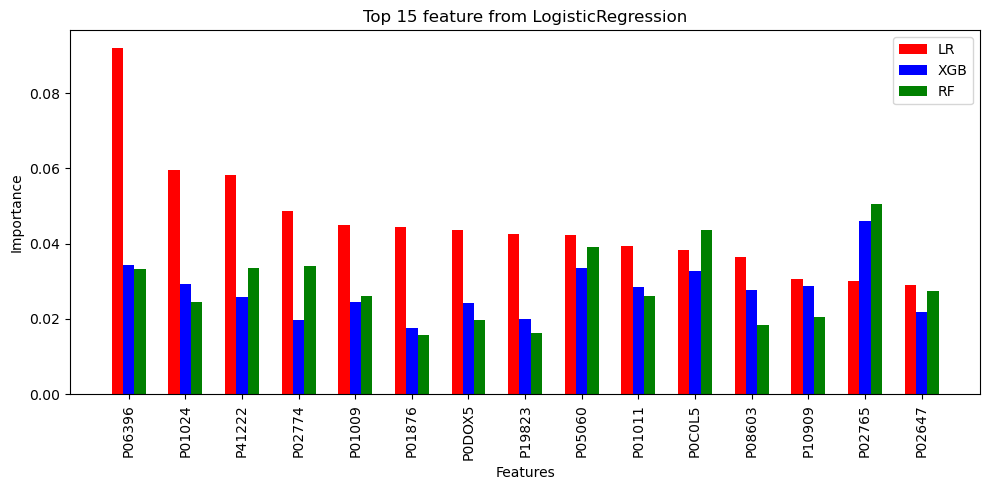

In [173]:
plot_feature_importance(LR_avg_feature_importance, XGB_avg_feature_importance, RF_avg_feature_importance, models=["LR", "XGB", "RF"], main_model="LogisticRegression", colours = ["r", "b", "g"])

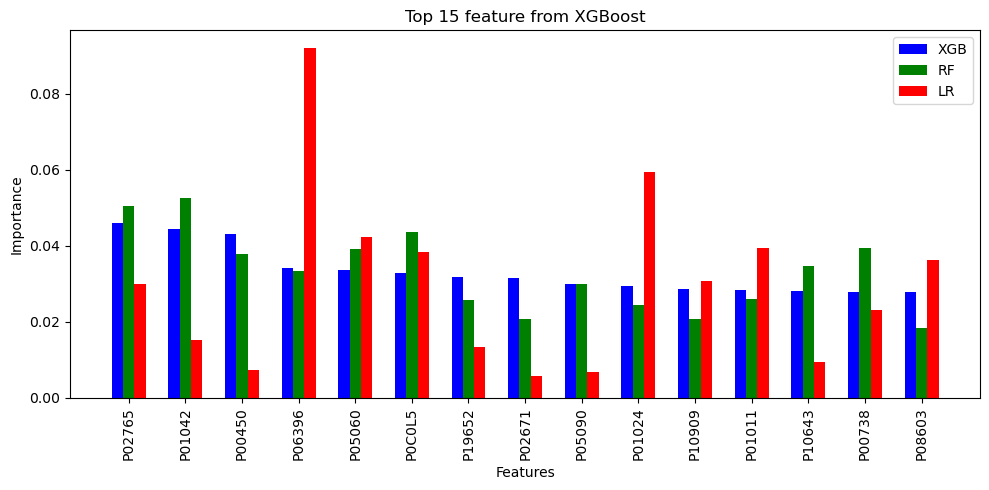

In [174]:
plot_feature_importance(XGB_avg_feature_importance, RF_avg_feature_importance, LR_avg_feature_importance, models=["XGB", "RF", "LR"], main_model="XGBoost", colours = ["b", "g", "r"])

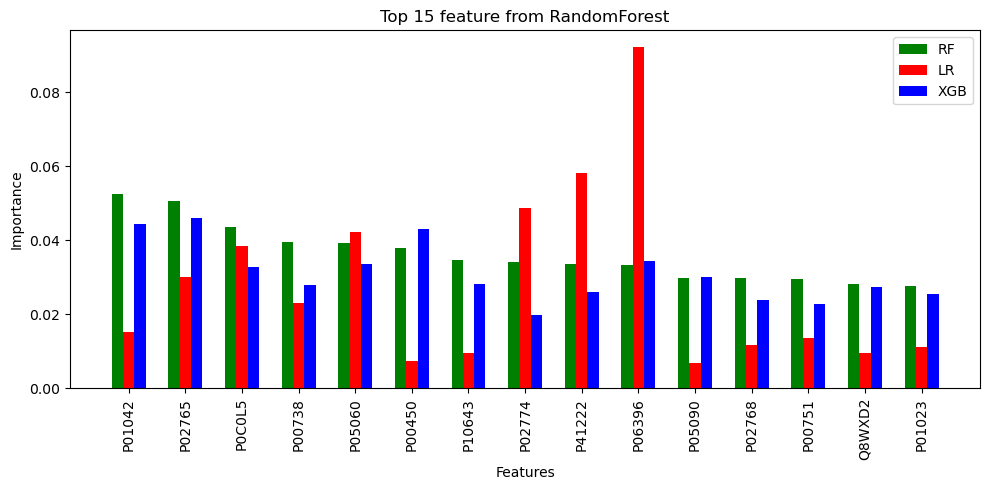

In [175]:
plot_feature_importance(RF_avg_feature_importance, LR_avg_feature_importance, XGB_avg_feature_importance, models=["RF", "LR", "XGB"], main_model="RandomForest", colours = ["g", "r", "b"])

# Recursive Feature Extraction

We will add Stabl here in the future.

In [28]:
def get_union_features_p1(state, n_features, df = df_main):
    lasso = Lasso(alpha=0.001, max_iter=5000, random_state=state)
    lr = LogisticRegression(penalty='elasticnet', solver="saga", multi_class="multinomial", max_iter=8000, C=0.01, l1_ratio=0.8, random_state=state)
    rf = RandomForestClassifier(n_estimators=350, criterion='gini', max_depth=10, max_features='sqrt', min_samples_leaf=1, random_state=state)
    xgb = XGBClassifier(eta=0.2, gamma=0.01, n_estimators=150, reg_lambda=0.85, max_depth=5, min_child_weight=0.45, subsample=0.6, seed=state)

    n_features_p1 = n_features
    step_p1 = 10

    #LASSO
    rfe_lasso = RFE(lasso, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_lasso.fit_transform(df, y=y)

    #LR
    rfe_lr = RFE(lr, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_lr.fit_transform(df, y=y)

    #RF
    rfe_rf = RFE(rf, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_rf.fit_transform(df, y=y)

    #XGB
    rfe_xgb = RFE(xgb, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_xgb.fit_transform(df, y=y)

    #Number of features in current dataset.
    set_lasso = set(rfe_lasso.get_feature_names_out())
    set_lr = set(rfe_lr.get_feature_names_out())
    set_rf = set(rfe_rf.get_feature_names_out())
    set_xgb = set(rfe_xgb.get_feature_names_out())

    #Dataset after feature extraction.
    set_union = set_lasso.union(set_lr, set_rf, set_xgb)
    list_union = list(set_union)
    df_union = df[list_union]

    return df_union

In [29]:
def get_union_features(state, n_features, df = df_main):
    lasso = Lasso(alpha=0.001, max_iter=5000, random_state=state)
    lr = LogisticRegression(penalty='elasticnet', solver="saga", multi_class="multinomial", max_iter=8000, C=0.01, l1_ratio=0.8, random_state=state)
    rf = RandomForestClassifier(n_estimators=350, criterion='gini', max_depth=10, max_features='sqrt', min_samples_leaf=1, random_state=state)
    xgb = XGBClassifier(eta=0.2, gamma=0.01, n_estimators=150, reg_lambda=0.85, max_depth=5, min_child_weight=0.45, subsample=0.6, seed=state)

    n_features_p1 = n_features
    step_p1 = 1

    #LASSO
    rfe_lasso = RFE(lasso, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_lasso.fit_transform(df, y=y)

    #LR
    rfe_lr = RFE(lr, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_lr.fit_transform(df, y=y)

    #RF
    rfe_rf = RFE(rf, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_rf.fit_transform(df, y=y)

    #XGB
    rfe_xgb = RFE(xgb, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_xgb.fit_transform(df, y=y)

    #Number of features in current dataset.
    set_lasso = set(rfe_lasso.get_feature_names_out())
    set_lr = set(rfe_lr.get_feature_names_out())
    set_rf = set(rfe_rf.get_feature_names_out())
    set_xgb = set(rfe_xgb.get_feature_names_out())

    #Dataset after feature extraction.
    set_union = set_lasso.union(set_lr, set_rf, set_xgb)
    list_union = list(set_union)
    df_union = df[list_union]

    return df_union

In [29]:
def get_union_features(state, n_features, df = df_main):
    lasso = Lasso(alpha=0.001, max_iter=5000, random_state=state)
    lr = LogisticRegression(penalty='elasticnet', solver="saga", multi_class="multinomial", max_iter=8000, C=0.01, l1_ratio=0.8, random_state=state)
    rf = RandomForestClassifier(n_estimators=350, criterion='gini', max_depth=10, max_features='sqrt', min_samples_leaf=1, random_state=state)
    xgb = XGBClassifier(eta=0.2, gamma=0.01, n_estimators=150, reg_lambda=0.85, max_depth=5, min_child_weight=0.45, subsample=0.6, seed=state)

    n_features_p1 = 100
    step_p1 = 10

    #LASSO
    rfe_lasso = RFE(lasso, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_lasso.fit_transform(df, y=y)

    #LR
    rfe_lr = RFE(lr, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_lr.fit_transform(df, y=y)

    #RF
    rfe_rf = RFE(rf, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_rf.fit_transform(df, y=y)

    #XGB
    rfe_xgb = RFE(xgb, n_features_to_select=n_features_p1, step=step_p1)
    _ = rfe_xgb.fit_transform(df, y=y)

    #Feature Names.
    lasso_cont = rfe_lasso.get_feature_names_out()
    lr_cont = rfe_lr.get_feature_names_out()
    rf_cont = rfe_rf.get_feature_names_out()
    xgb_cont = rfe_xgb.get_feature_names_out()

    #Dataframes based on extracted features.
    df_lasso_cont = df[lasso_cont]
    df_lr_cont = df[lr_cont]
    df_rf_cont = df[rf_cont]
    df_xgb_cont = df[xgb_cont]

    #PART 2
    n_features_p2 = n_features
    step_p2 = 1

    #LASSO
    rfe_lasso_p2 = RFE(lasso, n_features_to_select=n_features_p2, step=step_p2)
    _ = rfe_lasso_p2.fit_transform(df_lasso_cont, y=y)

    #LR
    rfe_lr_p2 = RFE(lr, n_features_to_select=n_features_p2, step=step_p2)
    _ = rfe_lr_p2.fit_transform(df_lr_cont, y=y)

    #RF
    rfe_rf_p2 = RFE(rf, n_features_to_select=n_features_p2, step=step_p2)
    _ = rfe_rf_p2.fit_transform(df_rf_cont, y=y)

    #XGB
    rfe_xgb_p2 = RFE(xgb, n_features_to_select=n_features_p2, step=step_p2)
    _ = rfe_xgb_p2.fit_transform(df_xgb_cont, y=y)

    #Number of features in current dataset.
    set_lasso_p2 = set(rfe_lasso_p2.get_feature_names_out())
    set_lr_p2 = set(rfe_lr_p2.get_feature_names_out())
    set_rf_p2 = set(rfe_rf_p2.get_feature_names_out())
    set_xgb_p2 = set(rfe_xgb_p2.get_feature_names_out())

    #Dataset after feature extraction.
    set_union = set_lasso_p2.union(set_lr_p2, set_rf_p2, set_xgb_p2)
    list_union = list(set_union)
    df_union = df[list_union]

    return df_union

# For Meeting

## Params

In [25]:
#Bayes Params.
xgboost_params = {"eta": Real(0.2, 0.3),
                  "min_child_weight": Real(0.4, 0.5),
                  "gamma": Real(0.0001, 1),
                  "subsample": Real(0.4, 0.8),
                  "reg_lambda": Real(0.8, 0.9),
                  "max_depth": Integer(1, 10),
                  "n_jobs": [-1],
                  "n_estimators": Integer(50, 500)}
lr_params = {"penalty": Categorical(["elasticnet"]),
              "C": Real(0.00001, 100),
              "solver": Categorical(["saga"]),
              "multi_class": Categorical(["multinomial"]),
              "max_iter": Integer(1000, 12000),
              "tol": Real(1e-4, 1e-2),
              "n_jobs": [-1],
              "l1_ratio": Real(0, 1)}
rf_params = {"n_estimators": Integer(50, 500),
             "criterion": Categorical(["gini", "entropy"]),
             "max_depth": Integer(5, 50),
             "max_features": Categorical(["sqrt", "log2"]),
             "n_jobs": [-1],
             "min_samples_leaf": Integer(1,5)}

params_bayes = [xgboost_params, lr_params, rf_params]

In [26]:
#Bayes Params, Simplified.
xgboost_params = {"eta": Real(0.1, 0.5),
                  "max_depth": Integer(1, 20),
                  "n_jobs": [-1],
                  "n_estimators": Integer(5, 500)}
lr_params = {"penalty": Categorical(["elasticnet"]),
              "C": Real(0.000001, 100),
              "solver": Categorical(["saga"]),
              "multi_class": Categorical(["multinomial"]),
              "max_iter": Integer(1000, 12000),
              "n_jobs": [-1],
              "l1_ratio": Real(0, 1)}
rf_params = {"n_estimators": Integer(5, 500),
             "max_depth": Integer(2, 50),
             "n_jobs": [-1],
             "min_samples_leaf": Integer(1,5)}

params_bayes_simple = [xgboost_params, lr_params, rf_params]

In [27]:
#Grid Params, Maximized.
xgboost_params = {"eta": [0.2, 0.3],
                  "min_child_weight": [0.45],
                  "gamma": [0.0001, 0.01, 1],
                  "subsample": [0.4, 0.8],
                  "reg_lambda": [0.85],
                  "lambda": [0.5, 0.7],
                  "max_depth": [4, 6],
                  "n_estimators": [150]}
lr_params = {"penalty": ["elasticnet"],
              "C": [0.0001, 0.01, 1, 10, 100],
              "solver": ["saga"],
              "multi_class": ["multinomial"],
              "max_iter": [4000, 8000, 12000],
              "tol": [1e-2, 1e-3, 1e-4],
              "n_jobs": [-1],
              "l1_ratio": [0, 0.3, 0.5, 0.8, 1]}
rf_params = {"n_estimators": [100, 300],
             "criterion": ["gini", "entropy"],
             "max_depth": [5, 10, 20],
             "max_features": ["sqrt"],
             "n_jobs": [-1],
             "min_samples_leaf": [1,2,4]}

params_grid = [xgboost_params, lr_params, rf_params]

## BayesSearchCV VS GridSearchCV

Both run on the same settings (~35 features) with GridSearchCV having a smaller hyperparameter range (but more fine-tuned), and BayesSearchCV a more *standard* hyperparameter search space. Both ran with ComBat, reduced feature space...

### BayesSearchCV

In [99]:
#More correct?
xgboost_params = {"eta": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
                  "max_depth": [2,4,6,8,10],
                  "n_estimators": [100, 200, 300, 400, 500]}
lr_params = {"penalty": ["elasticnet"],
              "C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              "solver": ["saga"],
              "multi_class": ["multinomial"],
              "max_iter": [4000, 8000, 12000],
              "tol": [1e-2, 1e-3, 1e-4],
              "n_jobs": [-1],
              "l1_ratio": [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
rf_params = {"n_estimators": [100, 200, 300, 400, 500],
             "criterion": ["gini", "entropy", "log_loss"],
             "max_depth": [5, 10, 20, 30, 40],
             "max_features": ["sqrt", "log2"],
             "n_jobs": [-1],
             "min_samples_leaf": [1,2,3,4,5]}

params = [xgboost_params, lr_params, rf_params]

In [49]:
#Run Pipeline
all_models, votes, y_true = pipeline(df_union, y, params, tmt_set)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 133.75857019424438 seconds.

LR 0 started.
LR 0 is done in 121.57840919494629 seconds.

RF 0 started.
RF 0 is done in 173.10991859436035 seconds.

Hard vote F1 score: 0.6296296296296295
Soft vote F1 score: 0.6296296296296295

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 132.25061702728271 seconds.

LR 1 started.
LR 1 is done in 131.29112696647644 seconds.

RF 1 started.
RF 1 is done in 134.75252056121826 seconds.

Hard vote F1 score: 0.6296296296296295
Soft vote F1 score: 0.6296296296296295

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 127.84838724136353 seconds.

LR 2 started.
LR 2 is done in 167.64478421211243 seconds.

RF 2 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 40, 'log2', 1, 500, -1] before, using random point ['gini', 20, 'log2', 2, 200, -1]
  warnings.warn(


RF 2 is done in 225.31157660484314 seconds.

Hard vote F1 score: 0.7283950617283951
Soft vote F1 score: 0.7883597883597884

K-Fold validation: Iteration 3.
XGB 3 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.35, 2, 300] before, using random point [0.4, 6, 200]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.35, 2, 100] before, using random point [0.3, 4, 500]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.35, 2, 100] before, using random point [0.5, 4, 300]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.35, 2, 300] before, using random point [0.2, 4, 500]
  warnings.warn(


XGB 3 is done in 198.61385440826416 seconds.

LR 3 started.
LR 3 is done in 226.59312200546265 seconds.

RF 3 started.
RF 3 is done in 187.16090965270996 seconds.

Hard vote F1 score: 0.5206349206349207
Soft vote F1 score: 0.6195286195286196

K-Fold validation: Iteration 4.
XGB 4 started.
XGB 4 is done in 172.52216935157776 seconds.

LR 4 started.
LR 4 is done in 151.45505332946777 seconds.

RF 4 started.
RF 4 is done in 201.64107179641724 seconds.

Hard vote F1 score: 0.8412698412698413
Soft vote F1 score: 0.7272727272727272

K-Fold validation: Iteration 5.
XGB 5 started.
XGB 5 is done in 161.1420750617981 seconds.

LR 5 started.
LR 5 is done in 138.30714321136475 seconds.

RF 5 started.
RF 5 is done in 162.9932165145874 seconds.

Hard vote F1 score: 0.5
Soft vote F1 score: 0.625

K-Fold validation: Iteration 6.
XGB 6 started.
XGB 6 is done in 155.11577486991882 seconds.

LR 6 started.
LR 6 is done in 165.06149792671204 seconds.

RF 6 started.
RF 6 is done in 167.06228685379028 second

In [50]:
#Combining K-fold results.
hard_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Hard')] for item in sublist]
soft_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Soft')] for item in sublist]
xgb_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('XGB')] for item in sublist]
lr_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('LR')] for item in sublist]
rf_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('RF')] for item in sublist]
xgb_prob = [item for sublist in [value.probability for key, value in all_models.items() if key.startswith('XGB')] for item in sublist]
lr_prob = [item for sublist in [value.probability for key, value in all_models.items() if key.startswith('LR')] for item in sublist]
rf_prob = [item for sublist in [value.probability for key, value in all_models.items() if key.startswith('RF')] for item in sublist]
y_trues = [item for sublist in [list(series) for series in y_true.values()] for item in sublist]

In [51]:
print(f"XGB\t\tAUC OVR: {roc_auc_score(y_trues, xgb_prob, multi_class='ovr')} \t\tAUC OVO: {roc_auc_score(y_trues, xgb_prob, multi_class='ovo')} \t\tACC: {accuracy_score(y_trues, xgb_votes)} \t\tF1: {f1_score(y_trues, xgb_votes, average='weighted')}")
print(f"LR \t\tAUC OVR: {roc_auc_score(y_trues, lr_prob, multi_class='ovr')} \t\tAUC OVO: {roc_auc_score(y_trues, lr_prob, multi_class='ovo')} \t\tACC: {accuracy_score(y_trues, lr_votes)} \t\tF1: {f1_score(y_trues, lr_votes, average='weighted')}")
print(f"RF \t\tAUC OVR: {roc_auc_score(y_trues, rf_prob, multi_class='ovr')} \t\tAUC OVO: {roc_auc_score(y_trues, rf_prob, multi_class='ovo')} \t\tACC: {accuracy_score(y_trues, rf_votes)} \t\tF1: {f1_score(y_trues, rf_votes, average='weighted')}")
print(f"Soft Vote\t\t\t\t\t\t\t\t\t\t\tACC: {accuracy_score(y_trues, soft_votes)} \t\tF1: {f1_score(y_trues, soft_votes, average='weighted')}")
print(f"Hard Vote\t\t\t\t\t\t\t\t\t\t\tACC: {accuracy_score(y_trues, hard_votes)} \t\tF1: {f1_score(y_trues, hard_votes, average='weighted')}")

XGB		AUC OVR: 0.7970533114076028 		AUC OVO: 0.7802367288378766 		ACC: 0.6470588235294118 		F1: 0.6324316833180048
LR 		AUC OVR: 0.8681486158743311 		AUC OVO: 0.8664514586322335 		ACC: 0.7176470588235294 		F1: 0.7192780748663101
RF 		AUC OVR: 0.7987665506444307 		AUC OVO: 0.8052008608321376 		ACC: 0.6470588235294118 		F1: 0.6373440285204991
Soft Vote											ACC: 0.7058823529411765 		F1: 0.7001680260482411
Hard Vote											ACC: 0.6823529411764706 		F1: 0.6726858185134519


### XGB With Missing Data

In [147]:
def set_max_missingness_per_column(df, threshold=0.5, negative=False):
    """
    Removes columns with nan values above a threshold.

    :param df: Dataframe-base to remove NaN-heavy columns from.
    :param threshold: Threshold percentage of missingness allowed per column.
    :param negative: Used if wanting to return all columns with more than threshold missingness.
    :return: New dataframe without NaN-heavy columns.
    """ 
    if not negative:
        nan_percentage = (df.isna().mean()).round(4)
        selected_columns = nan_percentage[nan_percentage <= threshold].index
        return df[selected_columns]
    
    nan_percentage = (df.isna().mean()).round(4)
    selected_columns = nan_percentage[nan_percentage >= threshold].index
    return df[selected_columns]

In [30]:
#Loading dataframes, Pooling and classes.
df_with_missing = pd.read_csv("./Data/data files/iNPH_data_protein_median.csv")
df_with_missing = df_with_missing[df_with_missing["CSF_type"] == "L"].reset_index()
df_with_missing = df_with_missing.iloc[:, 12:]
df_with_missing.replace([np.inf, -np.inf], np.nan, inplace=True)
df_with_missing = set_max_missingness_per_column(df_with_missing, 0.95)

In [31]:
xgboost_params = {"eta": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
                  "max_depth": [2,4,6,8,10],
                  "n_estimators": [100, 200, 300, 400, 500]}
params = [xgboost_params]
all_models, votes, y_true = pipeline(df_with_missing, y, params, tmt_set)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 41.042258977890015 seconds.

Hard vote F1 score: 0.4761904761904763
Soft vote F1 score: 0.4761904761904763

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 34.85745429992676 seconds.

Hard vote F1 score: 0.20987654320987653
Soft vote F1 score: 0.20987654320987653

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 47.4509539604187 seconds.

Hard vote F1 score: 0.4148148148148148
Soft vote F1 score: 0.4148148148148148

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 49.64777755737305 seconds.

Hard vote F1 score: 0.3905723905723905
Soft vote F1 score: 0.3905723905723905

K-Fold validation: Iteration 4.
XGB 4 started.
XGB 4 is done in 87.78930711746216 seconds.

Hard vote F1 score: 0.30687830687830686
Soft vote F1 score: 0.30687830687830686

K-Fold validation: Iteration 5.
XGB 5 started.
XGB 5 is done in 49.87940263

In [32]:
xgb_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('XGB')] for item in sublist]
xgb_prob = [item for sublist in [value.probability for key, value in all_models.items() if key.startswith('XGB')] for item in sublist]
y_trues = [item for sublist in [list(series) for series in y_true.values()] for item in sublist]

print(f"XGB\t\tAUC OVR: {roc_auc_score(y_trues, xgb_prob, multi_class='ovr')} \t\tAUC OVO: {roc_auc_score(y_trues, xgb_prob, multi_class='ovo')} \t\tACC: {accuracy_score(y_trues, xgb_votes)} \t\tF1: {f1_score(y_trues, xgb_votes, average='weighted')}")

XGB		AUC OVR: 0.5022387619975602 		AUC OVO: 0.49671209947393596 		ACC: 0.4235294117647059 		F1: 0.4126050420168067


### GridSearchCV

In [53]:
#FASTER, HARDER, SCOOTER
xgboost_params = {"eta": [0.2, 0.3],
                  "min_child_weight": [0.45],
                  "gamma": [0.0001, 0.01, 1],
                  "subsample": [0.4, 0.8],
                  "reg_lambda": [0.85],
                  "lambda": [0.5, 0.7],
                  "max_depth": [4, 6],
                  "n_estimators": [150]}
lr_params = {"penalty": ["elasticnet"],
              "C": [0.0001, 0.01, 1, 10, 100],
              "solver": ["saga"],
              "multi_class": ["multinomial"],
              "max_iter": [4000, 8000, 12000],
              "tol": [1e-2, 1e-3, 1e-4],
              "n_jobs": [-1],
              "l1_ratio": [0, 0.3, 0.5, 0.8, 1]}
rf_params = {"n_estimators": [300, 400],
             "criterion": ["gini", "entropy", "log_loss"],
             "max_depth": [5, 10, 20],
             "max_features": ["sqrt", "log2"],
             "n_jobs": [-1],
             "min_samples_leaf": [1,2,4]}

params = [xgboost_params, lr_params, rf_params]

In [54]:
#Run Pipeline
all_models, votes, y_true = pipeline(df_union, y, params, tmt_set)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 23.064324378967285 seconds.

LR 0 started.
LR 0 is done in 23.006800413131714 seconds.

RF 0 started.
RF 0 is done in 165.81152868270874 seconds.

Hard vote F1 score: 0.6490299823633158
Soft vote F1 score: 0.7777777777777778

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 21.151038885116577 seconds.

LR 1 started.
LR 1 is done in 23.111628770828247 seconds.

RF 1 started.
RF 1 is done in 157.11922097206116 seconds.

Hard vote F1 score: 0.5925925925925924
Soft vote F1 score: 0.6518518518518519

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 21.93117880821228 seconds.

LR 2 started.
LR 2 is done in 23.2705717086792 seconds.

RF 2 started.
RF 2 is done in 160.1758975982666 seconds.

Hard vote F1 score: 0.6296296296296295
Soft vote F1 score: 0.7365079365079364

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 21.6

In [55]:
#Combining K-fold results.
hard_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Hard')] for item in sublist]
soft_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Soft')] for item in sublist]
xgb_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('XGB')] for item in sublist]
lr_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('LR')] for item in sublist]
rf_votes = [item for sublist in [value.prediction for key, value in all_models.items() if key.startswith('RF')] for item in sublist]
xgb_prob = [item for sublist in [value.probability for key, value in all_models.items() if key.startswith('XGB')] for item in sublist]
lr_prob = [item for sublist in [value.probability for key, value in all_models.items() if key.startswith('LR')] for item in sublist]
rf_prob = [item for sublist in [value.probability for key, value in all_models.items() if key.startswith('RF')] for item in sublist]
y_trues = [item for sublist in [list(series) for series in y_true.values()] for item in sublist]

In [56]:
print(f"XGB\t\tAUC OVR: {roc_auc_score(y_trues, xgb_prob, multi_class='ovr')} \t\tAUC OVO: {roc_auc_score(y_trues, xgb_prob, multi_class='ovo')} \t\tACC: {accuracy_score(y_trues, xgb_votes)} \t\tF1: {f1_score(y_trues, xgb_votes, average='weighted')}")
print(f"LR \t\tAUC OVR: {roc_auc_score(y_trues, lr_prob, multi_class='ovr')} \t\tAUC OVO: {roc_auc_score(y_trues, lr_prob, multi_class='ovo')} \t\tACC: {accuracy_score(y_trues, lr_votes)} \t\tF1: {f1_score(y_trues, lr_votes, average='weighted')}")
print(f"RF \t\tAUC OVR: {roc_auc_score(y_trues, rf_prob, multi_class='ovr')} \t\tAUC OVO: {roc_auc_score(y_trues, rf_prob, multi_class='ovo')} \t\tACC: {accuracy_score(y_trues, rf_votes)} \t\tF1: {f1_score(y_trues, rf_votes, average='weighted')}")
print(f"Soft Vote\t\t\t\t\t\t\t\t\t\t\tACC: {accuracy_score(y_trues, soft_votes)} \t\tF1: {f1_score(y_trues, soft_votes, average='weighted')}")
print(f"Hard Vote\t\t\t\t\t\t\t\t\t\t\tACC: {accuracy_score(y_trues, hard_votes)} \t\tF1: {f1_score(y_trues, hard_votes, average='weighted')}")

XGB		AUC OVR: 0.851462255264264 		AUC OVO: 0.8364538498326161 		ACC: 0.7176470588235294 		F1: 0.7161338098457773
LR 		AUC OVR: 0.8982780441771073 		AUC OVO: 0.8842659014825442 		ACC: 0.7529411764705882 		F1: 0.7448229419645096
RF 		AUC OVR: 0.8517328155382845 		AUC OVO: 0.8559780009564802 		ACC: 0.6588235294117647 		F1: 0.6531163776371971
Soft Vote											ACC: 0.7647058823529411 		F1: 0.7563143151997642
Hard Vote											ACC: 0.6823529411764706 		F1: 0.6797912713472487


### BayesSearchCV with *best* Features.

In [84]:
#Run Pipeline
all_models, votes, y_true = pipeline(df_union, y, params, tmt_set)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 152.92752599716187 seconds.

LR 0 started.
LR 0 is done in 213.15054845809937 seconds.

RF 0 started.
RF 0 is done in 225.31579637527466 seconds.

Hard vote F1 score: 0.7629629629629631
Soft vote F1 score: 0.8871252204585538

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 166.9915373325348 seconds.

LR 1 started.
LR 1 is done in 96.04008626937866 seconds.

RF 1 started.
RF 1 is done in 116.47832679748535 seconds.

Hard vote F1 score: 0.7629629629629631
Soft vote F1 score: 0.7629629629629631

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 131.76991820335388 seconds.

LR 2 started.
LR 2 is done in 103.30110359191895 seconds.

RF 2 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 'log2', 1, 500, -1] before, using random point ['entropy', 44, 'sqrt', 3, 178, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 'log2', 1, 500, -1] before, using random point ['entropy', 22, 'sqrt', 4, 235, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 'log2', 1, 500, -1] before, using random point ['gini', 40, 'sqrt', 2, 384, -1]
  warnings.warn(


RF 2 is done in 118.8414831161499 seconds.

Hard vote F1 score: 0.7365079365079364
Soft vote F1 score: 0.7365079365079364

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 121.4343729019165 seconds.

LR 3 started.
LR 3 is done in 94.82406949996948 seconds.

RF 3 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 50, 'log2', 1, 500, -1] before, using random point ['entropy', 16, 'sqrt', 4, 304, -1]
  warnings.warn(


RF 3 is done in 110.72193908691406 seconds.

Hard vote F1 score: 0.2424242424242424
Soft vote F1 score: 0.2962962962962963

K-Fold validation: Iteration 4.
XGB 4 started.
XGB 4 is done in 124.11414313316345 seconds.

LR 4 started.
LR 4 is done in 91.70349907875061 seconds.

RF 4 started.
RF 4 is done in 112.55243682861328 seconds.

Hard vote F1 score: 0.6484848484848484
Soft vote F1 score: 0.7777777777777779

K-Fold validation: Iteration 5.
XGB 5 started.
XGB 5 is done in 128.60463047027588 seconds.

LR 5 started.
LR 5 is done in 103.87668418884277 seconds.

RF 5 started.
RF 5 is done in 105.82883977890015 seconds.

Hard vote F1 score: 0.7125
Soft vote F1 score: 0.8694444444444445

K-Fold validation: Iteration 6.
XGB 6 started.
XGB 6 is done in 124.41712260246277 seconds.

LR 6 started.
LR 6 is done in 86.29397392272949 seconds.

RF 6 started.
RF 6 is done in 120.74118828773499 seconds.

Hard vote F1 score: 0.5833333333333333
Soft vote F1 score: 0.75

K-Fold validation: Iteration 7.
XG

c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 34, 'sqrt', 1, 500, -1] before, using random point ['gini', 38, 'log2', 5, 483, -1]
  warnings.warn(


RF 9 is done in 116.03207635879517 seconds.

Hard vote F1 score: 0.761904761904762
Soft vote F1 score: 0.8833333333333334



XGB       	AUC OVR: 0.8715374540407875  	AUC OVO: 0.8746413199426112  	ACC: 0.7176470588235294  	F1: 0.7151235242107452
LR        	AUC OVR: 0.907490680285853   	AUC OVO: 0.9098397895743663  	ACC: 0.7294117647058823  	F1: 0.7276550439180196
RF        	AUC OVR: 0.837962025521482   	AUC OVO: 0.8572931611669058  	ACC: 0.6235294117647059  	F1: 0.6230241380747905
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8                 	F1: 0.7969645208355575
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7176470588235294  	F1: 0.7136586452762923


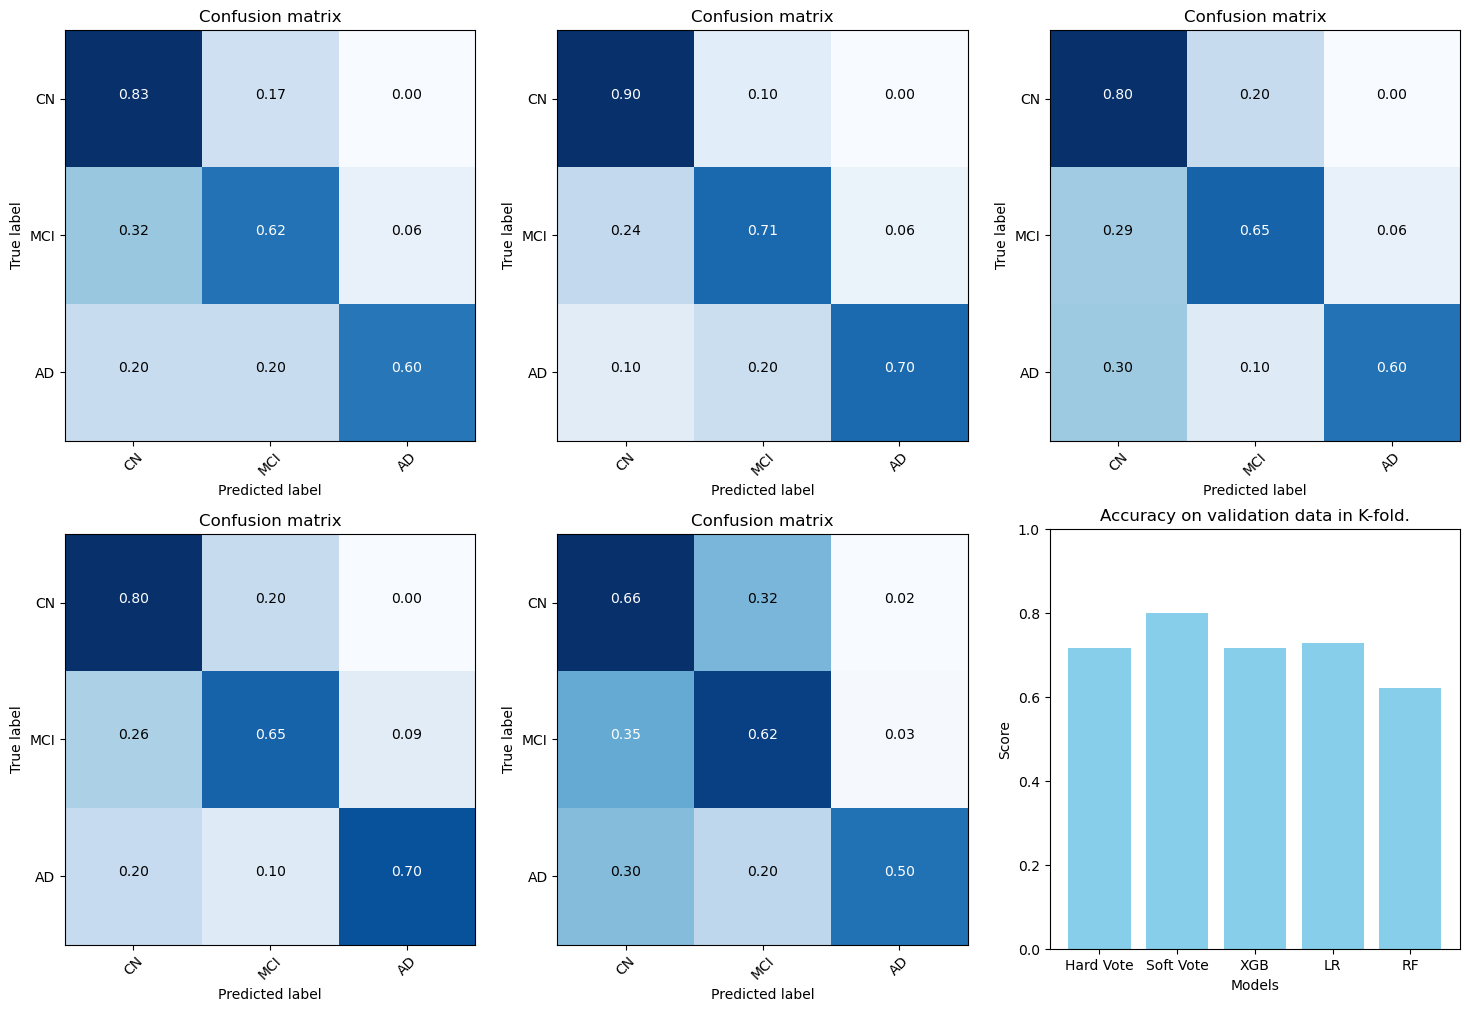

In [188]:
get_scores(all_models, votes, y_true, get_graphs=True)

## Stabl vs LASSOUnion

### Stable

In [200]:
stabl_list = ['P00738', 'A0M8Q6', 'P01871', 'P01742', 'P35527', 'P01861',
       'A0A0B4J1Y8', 'A0A075B6R2', 'A0A0B4J1V2', 'A0A0B4J1U7', 'P68871',
       'P07196', 'P49221', 'Q05996', 'A0A0J9YXX1', 'P69905', 'A0A0B4J1V7',
       'A0A075B6I1', 'A0A075B6I0', 'P20742', 'P05451', 'Q8N6Q3', 'P13647',
       'P00995', 'A0A0G2JMI3', 'Q9UL62', 'Q6NT04', 'P01903', 'P01766',
       'A0A0C4DH24', 'P07451', 'P08519', 'P11277', 'P51864']
df_stabl = df_main[stabl_list]

#### GridSearchCV

In [201]:
all_models, votes, y_true = pipeline(df_stabl, y, params_grid, tmt_set, bayes=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 4.300077438354492 seconds.

LR 0 started.
LR 0 is done in 4.421551465988159 seconds.

RF 0 started.
RF 0 is done in 4.195626735687256 seconds.

Hard vote F1 score: 0.4938271604938272
Soft vote F1 score: 0.35555555555555557

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 2.659062623977661 seconds.

LR 1 started.
LR 1 is done in 4.338547706604004 seconds.

RF 1 started.
RF 1 is done in 4.183305501937866 seconds.

Hard vote F1 score: 0.6613756613756614
Soft vote F1 score: 0.5206349206349207

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 2.5599887371063232 seconds.

LR 2 started.
LR 2 is done in 4.5930516719818115 seconds.

RF 2 started.
RF 2 is done in 4.0287981033325195 seconds.

Hard vote F1 score: 0.3905723905723905
Soft vote F1 score: 0.3905723905723905

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 2.628

XGB       	AUC OVR: 0.6978950463364338  	AUC OVO: 0.699426111908178   	ACC: 0.611764705882353   	F1: 0.6082595792262634
LR        	AUC OVR: 0.6146453052765822  	AUC OVO: 0.612936394069823   	ACC: 0.5176470588235295  	F1: 0.5090471276229791
RF        	AUC OVR: 0.6454968675701226  	AUC OVO: 0.6542682926829269  	ACC: 0.5176470588235295  	F1: 0.50085937080822
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.5411764705882353  	F1: 0.5366923399511082
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.5882352941176471  	F1: 0.5764831869779395


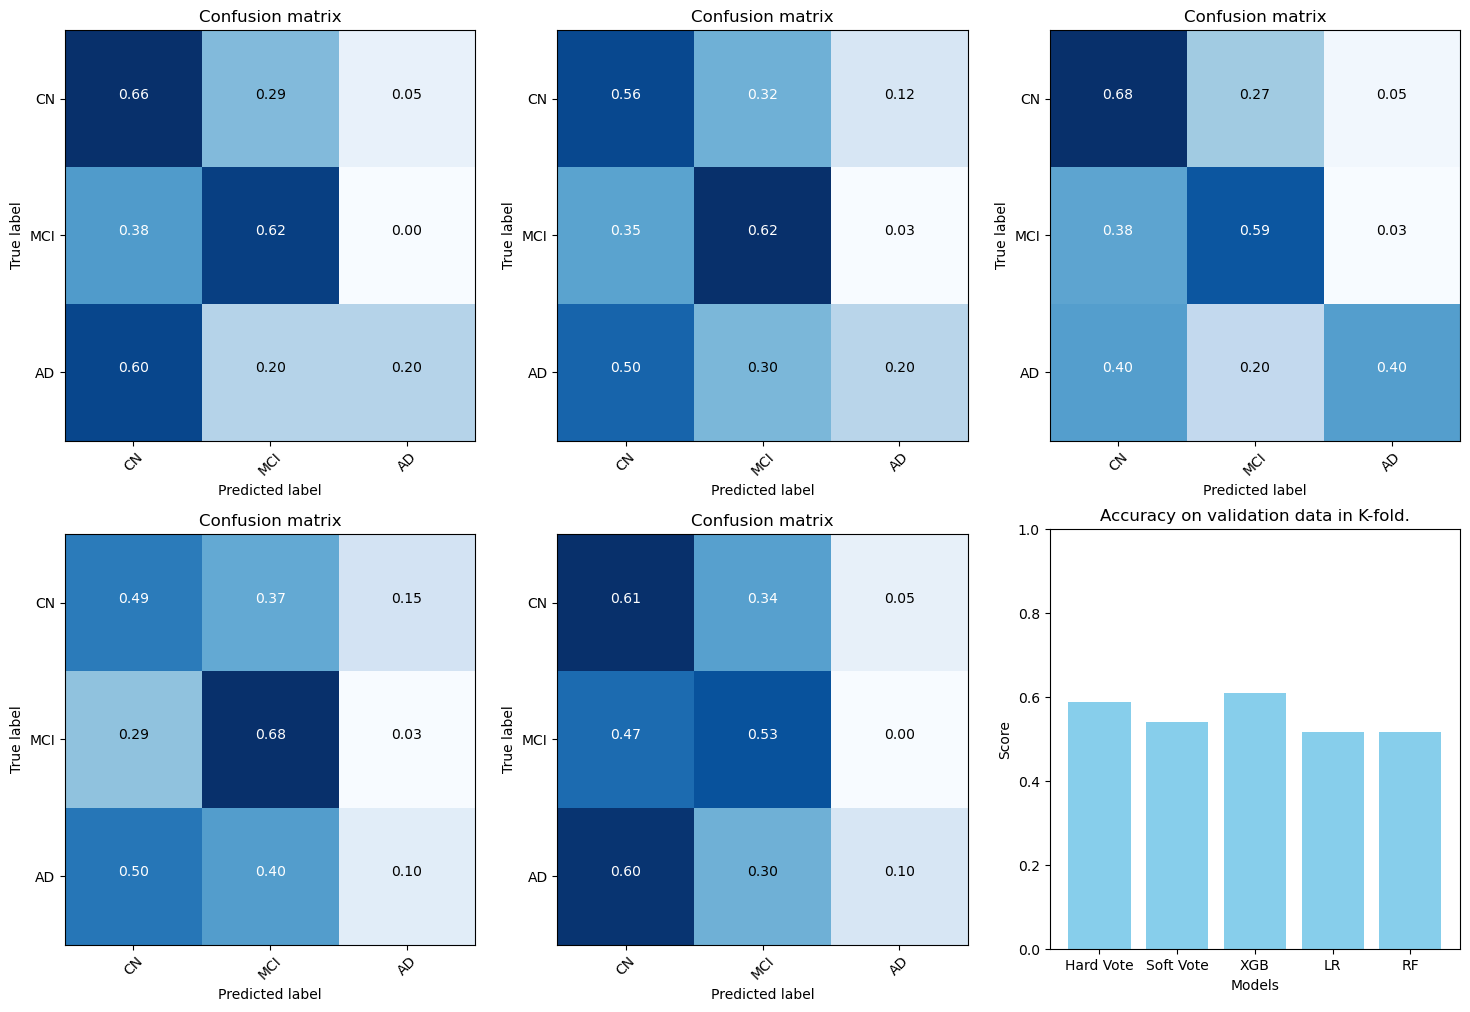

In [204]:
get_scores(all_models, votes, y_true, get_graphs=True)

#### BayesSearchCV, Slow

In [213]:
all_models, votes, y_true = pipeline(df_stabl, y, params_bayes, tmt_set, bayes=True)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 199.47276067733765 seconds.

LR 0 started.
LR 0 is done in 107.01289653778076 seconds.

RF 0 started.
RF 0 is done in 169.22920751571655 seconds.

Hard vote F1 score: 0.3245149911816579
Soft vote F1 score: 0.5259259259259259

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 281.89602303504944 seconds.

LR 1 started.
LR 1 is done in 269.8809735774994 seconds.

RF 1 started.
RF 1 is done in 241.1164529323578 seconds.

Hard vote F1 score: 0.5502645502645502
Soft vote F1 score: 0.6518518518518519

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 122.44828701019287 seconds.

LR 2 started.
LR 2 is done in 92.82817006111145 seconds.

RF 2 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 'log2', 1, 53, -1] before, using random point ['gini', 15, 'log2', 1, 231, -1]
  warnings.warn(


RF 2 is done in 110.54332971572876 seconds.

Hard vote F1 score: 0.4444444444444444
Soft vote F1 score: 0.41975308641975306

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 138.0252866744995 seconds.

LR 3 started.
LR 3 is done in 203.99424719810486 seconds.

RF 3 started.
RF 3 is done in 263.7856602668762 seconds.

Hard vote F1 score: 0.5555555555555556
Soft vote F1 score: 0.5502645502645503

K-Fold validation: Iteration 4.
XGB 4 started.
XGB 4 is done in 149.07318830490112 seconds.

LR 4 started.
LR 4 is done in 90.15135908126831 seconds.

RF 4 started.
RF 4 is done in 113.72811508178711 seconds.

Hard vote F1 score: 0.3055555555555556
Soft vote F1 score: 0.3055555555555556

K-Fold validation: Iteration 5.
XGB 5 started.
XGB 5 is done in 129.59166407585144 seconds.

LR 5 started.
LR 5 is done in 97.22920775413513 seconds.

RF 5 started.
RF 5 is done in 114.20676469802856 seconds.

Hard vote F1 score: 0.4833333333333333
Soft vote F1 score: 0.5

K-Fold validation: Itera

XGB       	AUC OVR: 0.6467582091486218  	AUC OVO: 0.6476446676231469  	ACC: 0.5294117647058824  	F1: 0.5316275764036958
LR        	AUC OVR: 0.6153980244678193  	AUC OVO: 0.6098158775705403  	ACC: 0.5058823529411764  	F1: 0.5029382996441819
RF        	AUC OVR: 0.5555606047818893  	AUC OVO: 0.5561692969870875  	ACC: 0.4823529411764706  	F1: 0.46977217029739776
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.5411764705882353  	F1: 0.5390655387432957
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.49411764705882355 	F1: 0.4890382819794585


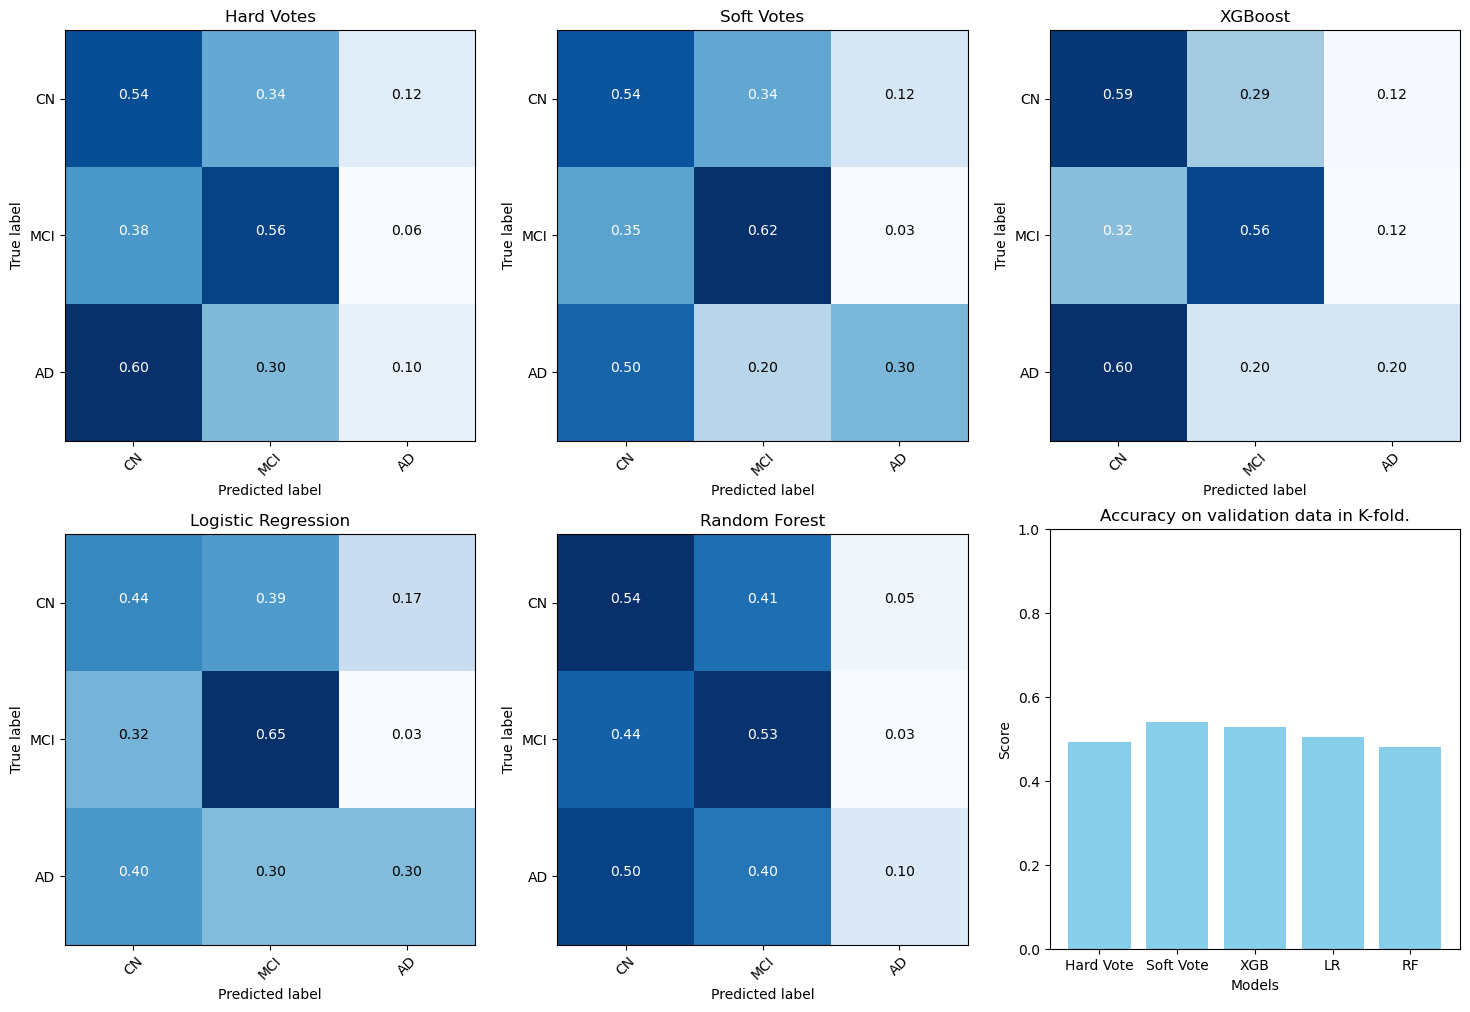

In [214]:
get_scores(all_models, votes, y_true, get_graphs = True)

#### BayesSearchCV, Simple

In [226]:
all_models, votes, y_true = pipeline(df_stabl, y, params_bayes_simple, tmt_set, bayes=True)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 87.57534790039062 seconds.

LR 0 started.
LR 0 is done in 98.3441948890686 seconds.

RF 0 started.
RF 0 is done in 100.04631662368774 seconds.

Hard vote F1 score: 0.41975308641975306
Soft vote F1 score: 0.5185185185185185

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 84.75833773612976 seconds.

LR 1 started.
LR 1 is done in 100.3784909248352 seconds.

RF 1 started.
RF 1 is done in 98.27099657058716 seconds.

Hard vote F1 score: 0.46772486772486777
Soft vote F1 score: 0.46772486772486777

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 89.6663887500763 seconds.

LR 2 started.
LR 2 is done in 105.27229762077332 seconds.

RF 2 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [7, 3, 500, -1] before, using random point [15, 2, 451, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [14, 1, 500, -1] before, using random point [6, 4, 317, -1]
  warnings.warn(


RF 2 is done in 98.92651057243347 seconds.

Hard vote F1 score: 0.4232804232804233
Soft vote F1 score: 0.7777777777777778

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 84.12401151657104 seconds.

LR 3 started.
LR 3 is done in 99.61443614959717 seconds.

RF 3 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 1, 500, -1] before, using random point [20, 5, 57, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [49, 1, 492, -1] before, using random point [44, 3, 330, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 1, 497, -1] before, using random point [22, 4, 172, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 3, 493, -1] before, using random point [25, 3, 179, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 1, 500, -1] before, usin

RF 3 is done in 103.81835865974426 seconds.

Hard vote F1 score: 0.5502645502645502
Soft vote F1 score: 0.5502645502645502

K-Fold validation: Iteration 4.
XGB 4 started.
XGB 4 is done in 81.52045965194702 seconds.

LR 4 started.
LR 4 is done in 96.6983904838562 seconds.

RF 4 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 1, 500, -1] before, using random point [40, 2, 218, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [49, 1, 56, -1] before, using random point [12, 4, 145, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 1, 61, -1] before, using random point [41, 4, 385, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 1, 500, -1] before, using random point [21, 4, 165, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [49, 1, 497, -1] before, using

RF 4 is done in 100.81884527206421 seconds.

Hard vote F1 score: 0.6484848484848484
Soft vote F1 score: 0.7777777777777779

K-Fold validation: Iteration 5.
XGB 5 started.
XGB 5 is done in 85.89251804351807 seconds.

LR 5 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LR 5 is done in 91.33717012405396 seconds.

RF 5 started.
RF 5 is done in 99.96835064888 seconds.



c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Hard vote F1 score: 0.8694444444444445
Soft vote F1 score: 0.5357142857142858

K-Fold validation: Iteration 6.
XGB 6 started.
XGB 6 is done in 81.84291553497314 seconds.

LR 6 started.
LR 6 is done in 124.8549222946167 seconds.

RF 6 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [49, 2, 498, -1] before, using random point [37, 3, 56, -1]
  warnings.warn(


RF 6 is done in 100.6890172958374 seconds.

Hard vote F1 score: 0.37222222222222223
Soft vote F1 score: 0.5

K-Fold validation: Iteration 7.
XGB 7 started.
XGB 7 is done in 99.5247266292572 seconds.

LR 7 started.
LR 7 is done in 107.61505603790283 seconds.

RF 7 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 1, 500, -1] before, using random point [27, 2, 191, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [49, 2, 499, -1] before, using random point [20, 3, 459, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [31, 1, 500, -1] before, using random point [14, 4, 174, -1]
  warnings.warn(


RF 7 is done in 101.01785802841187 seconds.

Hard vote F1 score: 0.5
Soft vote F1 score: 0.5

K-Fold validation: Iteration 8.
XGB 8 started.
XGB 8 is done in 84.55124688148499 seconds.

LR 8 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LR 8 is done in 97.43339014053345 seconds.

RF 8 started.
RF 8 is done in 103.27832174301147 seconds.



c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Hard vote F1 score: 0.47321428571428575
Soft vote F1 score: 0.47321428571428575

K-Fold validation: Iteration 9.
XGB 9 started.
XGB 9 is done in 88.4181547164917 seconds.

LR 9 started.
LR 9 is done in 99.36634063720703 seconds.

RF 9 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [34, 1, 500, -1] before, using random point [43, 2, 196, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [33, 1, 500, -1] before, using random point [6, 5, 497, -1]
  warnings.warn(


RF 9 is done in 97.72454237937927 seconds.

Hard vote F1 score: 0.4
Soft vote F1 score: 0.5357142857142858



XGB       	AUC OVR: 0.6188351964236848  	AUC OVO: 0.6102941176470589  	ACC: 0.5176470588235295  	F1: 0.5156253496959977
LR        	AUC OVR: 0.6238644236269352  	AUC OVO: 0.6067491630798661  	ACC: 0.5294117647058824  	F1: 0.537383779803001
RF        	AUC OVR: 0.590520131690779   	AUC OVO: 0.5919476327116212  	ACC: 0.4588235294117647  	F1: 0.4433986928104575
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.5647058823529412  	F1: 0.5691779320423822
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.5176470588235295  	F1: 0.5207488521862386


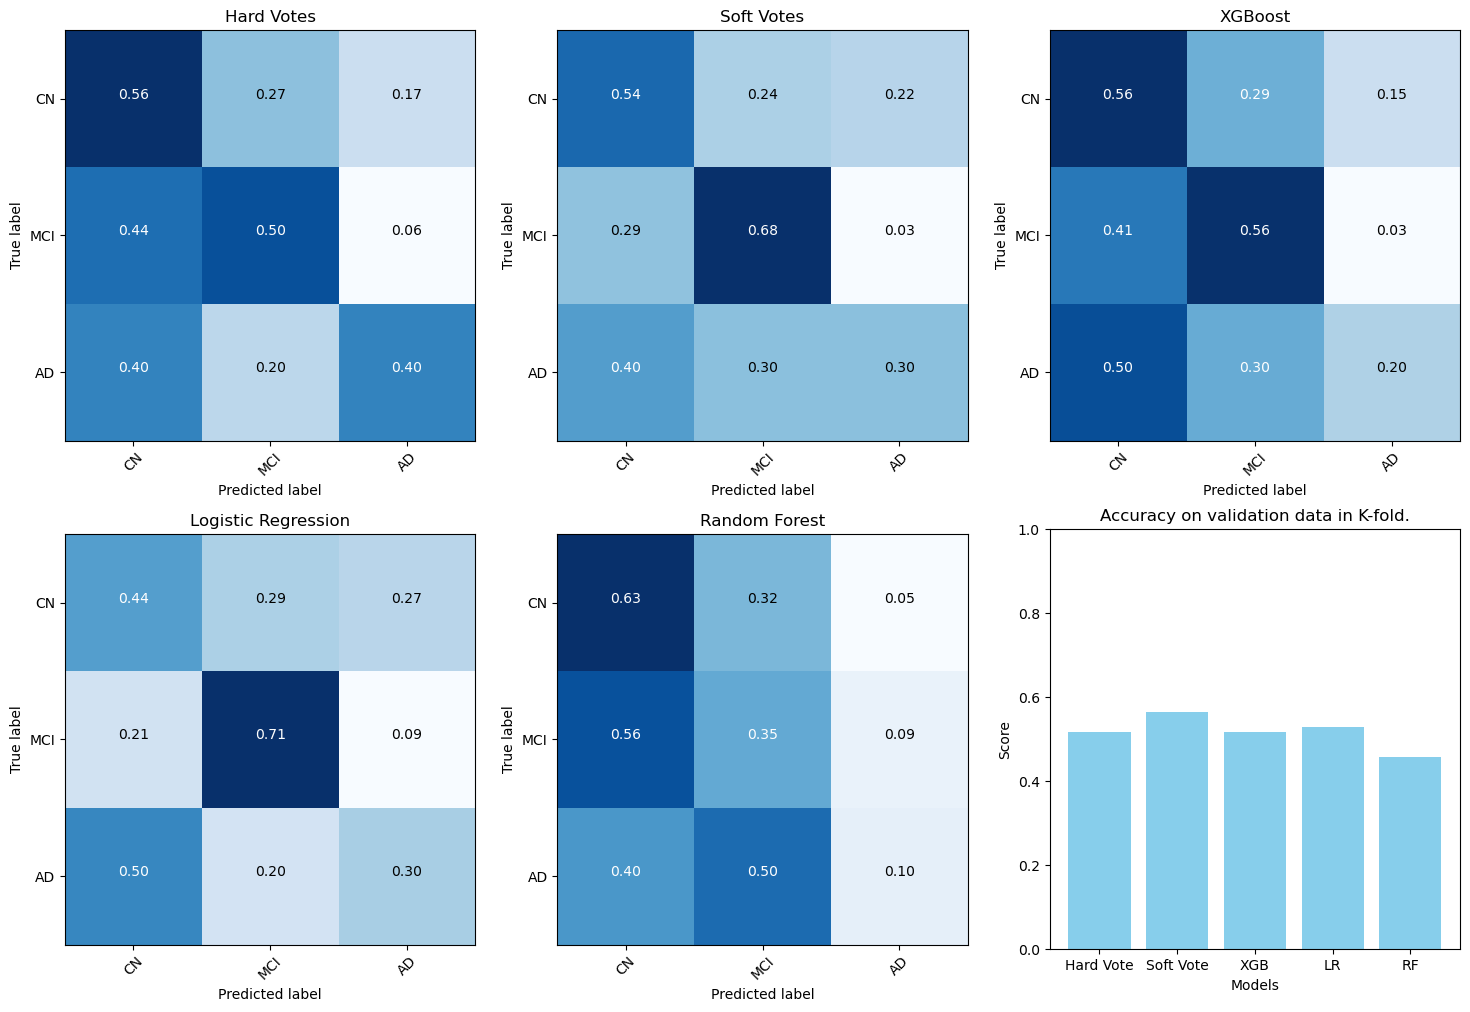

In [227]:
get_scores(all_models, votes, y_true, get_graphs = True)

### LASSOUnion

#### GridSearchCV

In [207]:
all_models, votes, y_true = pipeline(df_union, y, params_grid, tmt_set, bayes=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 2.8462748527526855 seconds.

LR 0 started.
LR 0 is done in 3.6858203411102295 seconds.

RF 0 started.
RF 0 is done in 4.740124940872192 seconds.

Hard vote F1 score: 0.47138047138047134
Soft vote F1 score: 0.47138047138047134

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 2.878671169281006 seconds.

LR 1 started.
LR 1 is done in 3.644979953765869 seconds.

RF 1 started.
RF 1 is done in 4.412346363067627 seconds.

Hard vote F1 score: 0.6613756613756615
Soft vote F1 score: 0.7654320987654322

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 2.8064029216766357 seconds.

LR 2 started.
LR 2 is done in 3.790984630584717 seconds.

RF 2 started.
RF 2 is done in 4.581527233123779 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 1.0

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 2.767036199569702 seconds.

LR 3 s

XGB       	AUC OVR: 0.8172769623827096  	AUC OVO: 0.8123266379722621  	ACC: 0.6352941176470588  	F1: 0.6317911028559279
LR        	AUC OVR: 0.8760656339749935  	AUC OVO: 0.8848637015781922  	ACC: 0.7176470588235294  	F1: 0.7166846954380991
RF        	AUC OVR: 0.7946711038139007  	AUC OVO: 0.8153813964610235  	ACC: 0.6588235294117647  	F1: 0.6562395500835994
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7411764705882353  	F1: 0.7418758993590023
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.6941176470588235  	F1: 0.688476798343971


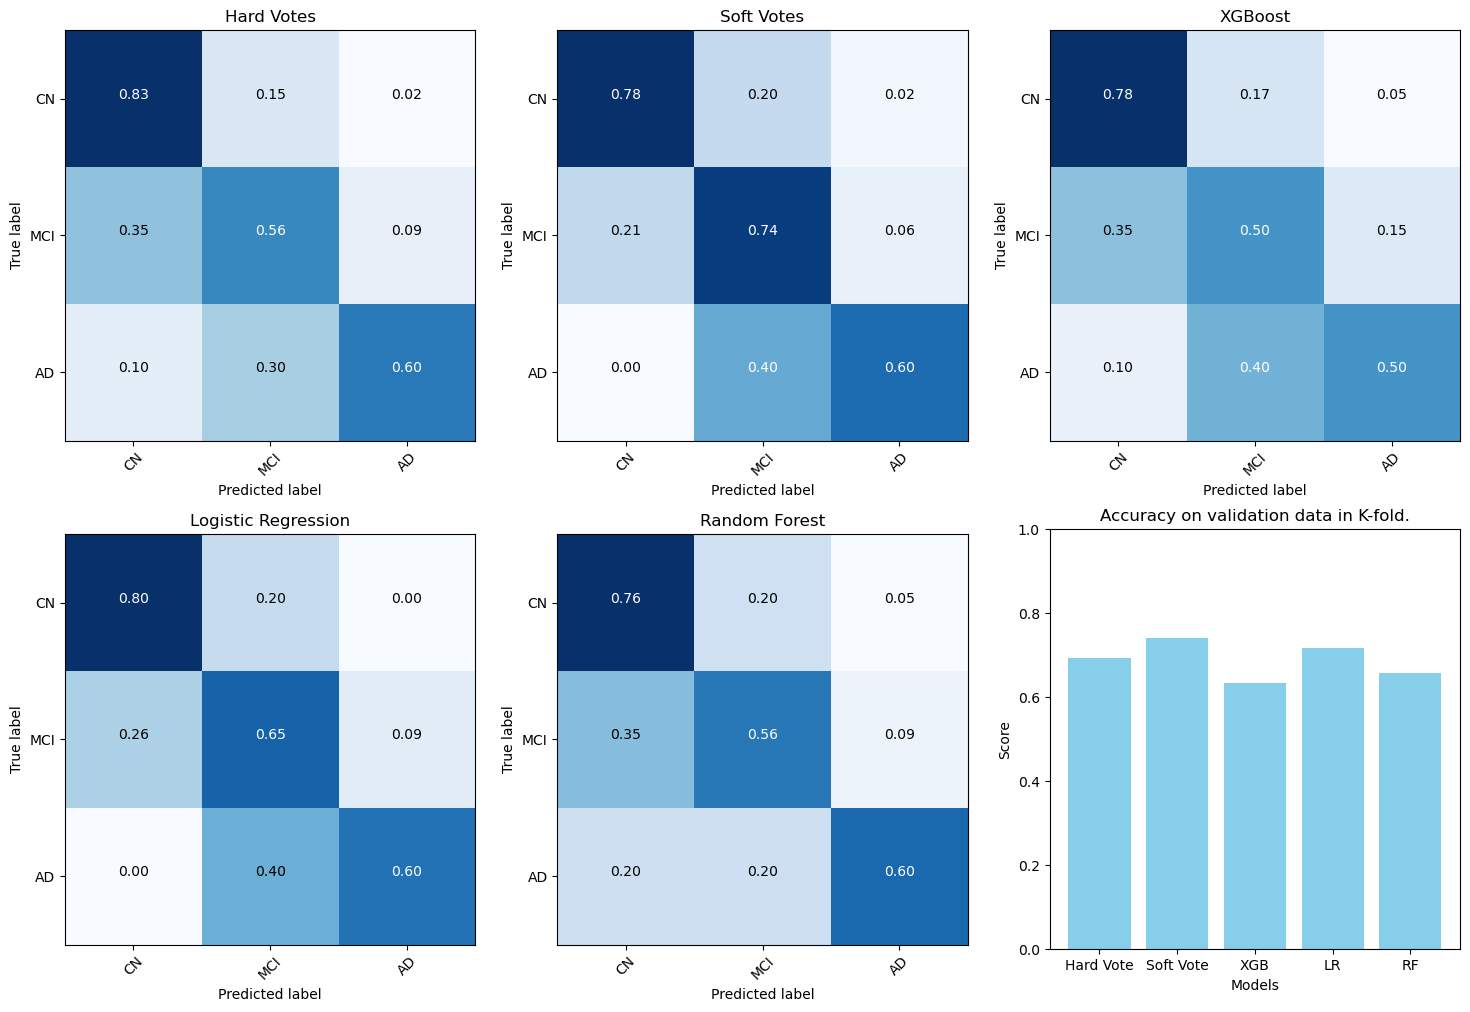

In [211]:
get_scores(all_models, votes, y_true, get_graphs = True)

#### BayesSearchCV, Slow

In [215]:
all_models, votes, y_true = pipeline(df_union, y, params_bayes, tmt_set, bayes=True)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 187.5224096775055 seconds.

LR 0 started.
LR 0 is done in 151.41634249687195 seconds.

RF 0 started.
RF 0 is done in 132.18342804908752 seconds.

Hard vote F1 score: 0.7365079365079364
Soft vote F1 score: 1.0

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 150.0658586025238 seconds.

LR 1 started.
LR 1 is done in 110.7456693649292 seconds.

RF 1 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 17, 'log2', 1, 500, -1] before, using random point ['entropy', 24, 'log2', 3, 334, -1]
  warnings.warn(


RF 1 is done in 132.82529497146606 seconds.

Hard vote F1 score: 0.7629629629629631
Soft vote F1 score: 0.7629629629629631

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 142.41952228546143 seconds.

LR 2 started.
LR 2 is done in 109.17714333534241 seconds.

RF 2 started.
RF 2 is done in 170.14745950698853 seconds.

Hard vote F1 score: 0.6613756613756615
Soft vote F1 score: 0.6613756613756615

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 272.05427837371826 seconds.

LR 3 started.
LR 3 is done in 206.04209184646606 seconds.

RF 3 started.
RF 3 is done in 253.86248230934143 seconds.

Hard vote F1 score: 0.6074074074074075
Soft vote F1 score: 0.7654320987654322

K-Fold validation: Iteration 4.
XGB 4 started.
XGB 4 is done in 168.90436601638794 seconds.

LR 4 started.
LR 4 is done in 99.34672594070435 seconds.

RF 4 started.
RF 4 is done in 121.1428279876709 seconds.

Hard vote F1 score: 0.7851851851851853
Soft vote F1 score: 0.6484848484848484

K-Fold v

c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 44, 'sqrt', 1, 129, -1] before, using random point ['gini', 34, 'sqrt', 4, 293, -1]
  warnings.warn(


RF 7 is done in 115.72551155090332 seconds.

Hard vote F1 score: 0.875
Soft vote F1 score: 1.0

K-Fold validation: Iteration 8.
XGB 8 started.
XGB 8 is done in 131.58597540855408 seconds.

LR 8 started.
LR 8 is done in 103.8741397857666 seconds.

RF 8 started.
RF 8 is done in 119.39582753181458 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 1.0

K-Fold validation: Iteration 9.
XGB 9 started.
XGB 9 is done in 125.94446325302124 seconds.

LR 9 started.
LR 9 is done in 99.98033785820007 seconds.

RF 9 started.
RF 9 is done in 118.58985304832458 seconds.

Hard vote F1 score: 0.3
Soft vote F1 score: 0.4833333333333333



XGB       	AUC OVR: 0.8614281970690106  	AUC OVO: 0.8607962697274032  	ACC: 0.6588235294117647  	F1: 0.6601734669771524
LR        	AUC OVR: 0.9129145706367412  	AUC OVO: 0.9152797704447634  	ACC: 0.7764705882352941  	F1: 0.7764705882352939
RF        	AUC OVR: 0.8399384766732222  	AUC OVO: 0.8565518890483023  	ACC: 0.6941176470588235  	F1: 0.6831145211707872
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8235294117647058  	F1: 0.8206790613909635
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7647058823529411  	F1: 0.7601703271103984


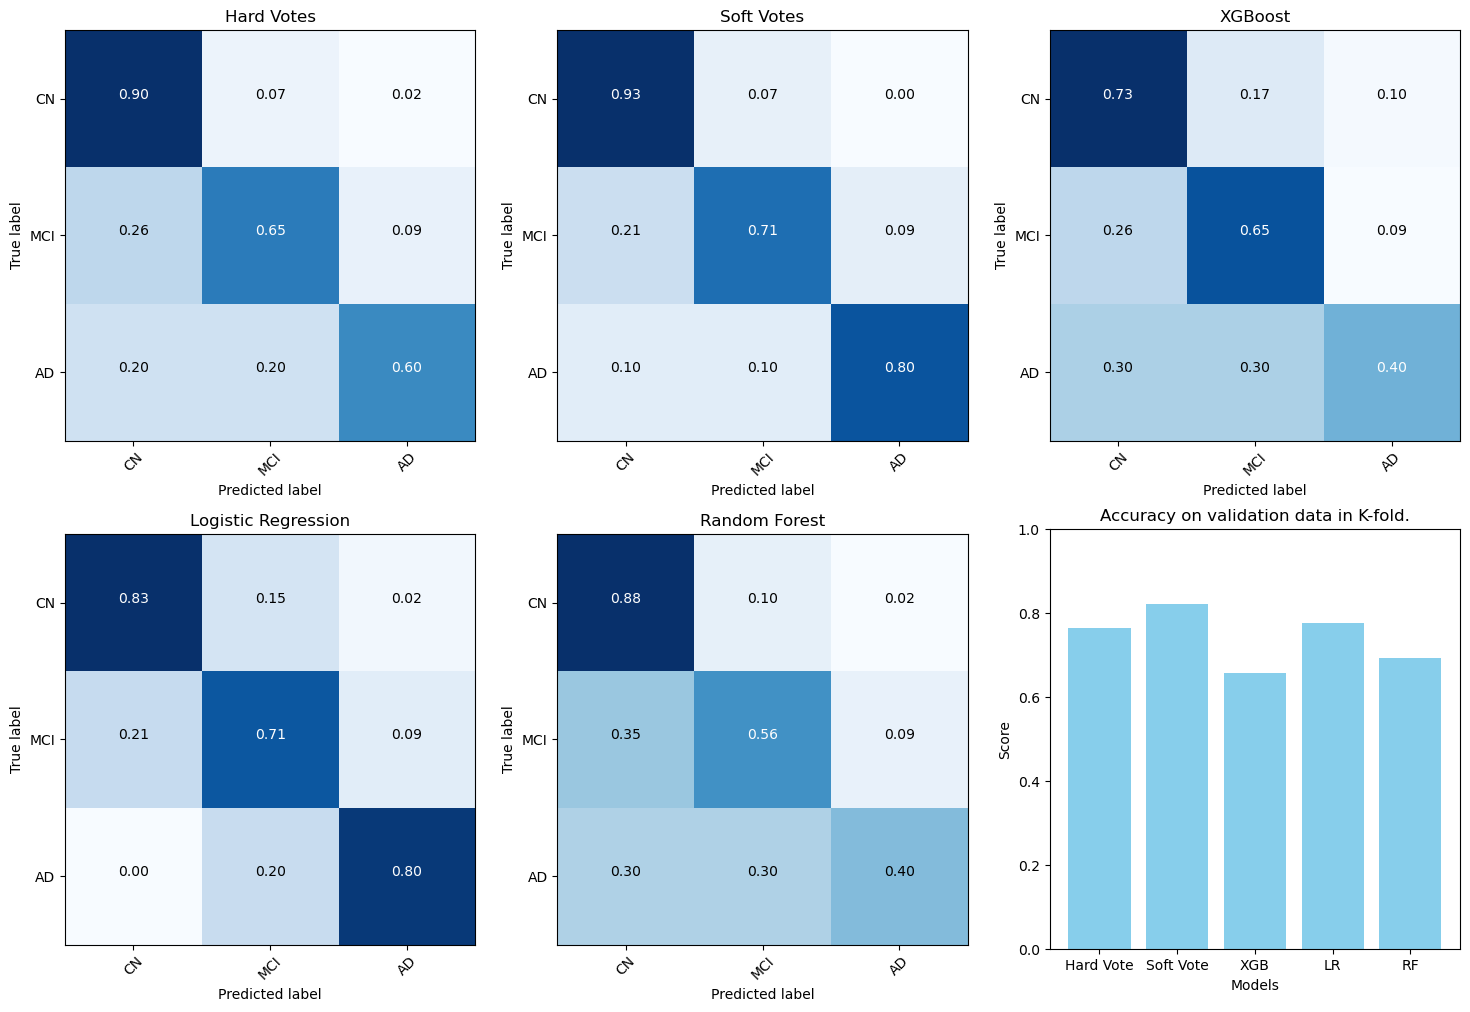

In [216]:
get_scores(all_models, votes, y_true, get_graphs = True)

#### BayesSearchCV, Simple

In [228]:
all_models, votes, y_true = pipeline(df_union, y, params_bayes_simple, tmt_set, bayes=True)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 99.14306330680847 seconds.

LR 0 started.
LR 0 is done in 109.45683360099792 seconds.

RF 0 started.
RF 0 is done in 114.80036854743958 seconds.

Hard vote F1 score: 0.6121212121212122
Soft vote F1 score: 0.6121212121212122

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 90.87899112701416 seconds.

LR 1 started.
LR 1 is done in 107.86089563369751 seconds.

RF 1 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 1, 347, -1] before, using random point [40, 2, 142, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 1, 50, -1] before, using random point [20, 2, 231, -1]
  warnings.warn(


RF 1 is done in 103.19303178787231 seconds.

Hard vote F1 score: 0.6121212121212122
Soft vote F1 score: 0.7629629629629631

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 91.85941004753113 seconds.

LR 2 started.
LR 2 is done in 97.6915991306305 seconds.

RF 2 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [6, 1, 500, -1] before, using random point [25, 2, 486, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [31, 1, 500, -1] before, using random point [49, 2, 160, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [35, 1, 500, -1] before, using random point [44, 1, 130, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 1, 499, -1] before, using random point [23, 5, 371, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [23, 1, 500, -1] before, usin

RF 2 is done in 109.27833986282349 seconds.

Hard vote F1 score: 0.6195286195286196
Soft vote F1 score: 0.8871252204585538

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 84.9374577999115 seconds.

LR 3 started.
LR 3 is done in 104.93173313140869 seconds.

RF 3 started.
RF 3 is done in 102.14337110519409 seconds.

Hard vote F1 score: 0.2424242424242424
Soft vote F1 score: 0.5037037037037037

K-Fold validation: Iteration 4.
XGB 4 started.
XGB 4 is done in 104.13172578811646 seconds.

LR 4 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LR 4 is done in 104.91355991363525 seconds.

RF 4 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 1, 500, -1] before, using random point [17, 5, 269, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 1, 421, -1] before, using random point [11, 1, 457, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 1, 500, -1] before, using random point [17, 3, 461, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 1, 500, -1] before, using random point [15, 1, 470, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 1, 500, -1] before, usi

RF 4 is done in 97.93833589553833 seconds.



c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Hard vote F1 score: 0.4285714285714286
Soft vote F1 score: 0.5151515151515151

K-Fold validation: Iteration 5.
XGB 5 started.
XGB 5 is done in 86.71156549453735 seconds.

LR 5 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [100.0, 0.0, 12000, 'multinomial', -1, 'elasticnet', 'saga'] before, using random point [99.92213266887238, 0.5576578355905975, 7662, 'multinomial', -1, 'elasticnet', 'saga']
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [100.0, 1.0, 12000, 'multinomial', -1, 'elasticnet', 'saga'] before, using random point [53.34562624982009, 0.08963004370106221, 11414, 'multinomial', -1, 'elasticnet', 'saga']
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [100.0, 0.0, 12000, 'multinomial', -1, 'elasticnet', 'saga'] before, using random point [87.04501299639317, 0.6106936084590845, 6115, 'multinomial', -1, 'elasticnet', 'saga']
  warnings.warn(
c:\Users\Toffe\anaconda3\L

LR 5 is done in 91.02120447158813 seconds.

RF 5 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [42, 1, 500, -1] before, using random point [38, 3, 359, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [29, 1, 500, -1] before, using random point [12, 2, 487, -1]
  warnings.warn(


RF 5 is done in 104.20516705513 seconds.

Hard vote F1 score: 0.7125
Soft vote F1 score: 0.7125

K-Fold validation: Iteration 6.
XGB 6 started.
XGB 6 is done in 86.32322883605957 seconds.

LR 6 started.
LR 6 is done in 107.24526023864746 seconds.

RF 6 started.
RF 6 is done in 100.69745969772339 seconds.

Hard vote F1 score: 0.8214285714285714
Soft vote F1 score: 0.8214285714285714

K-Fold validation: Iteration 7.
XGB 7 started.
XGB 7 is done in 90.7517602443695 seconds.

LR 7 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LR 7 is done in 107.24747657775879 seconds.

RF 7 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 1, 500, -1] before, using random point [24, 2, 436, -1]
  warnings.warn(


RF 7 is done in 105.90052819252014 seconds.



c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Hard vote F1 score: 0.5892857142857143
Soft vote F1 score: 0.7000000000000001

K-Fold validation: Iteration 8.
XGB 8 started.
XGB 8 is done in 94.95585036277771 seconds.

LR 8 started.
LR 8 is done in 95.49826979637146 seconds.

RF 8 started.
RF 8 is done in 108.56494069099426 seconds.

Hard vote F1 score: 0.761904761904762
Soft vote F1 score: 0.761904761904762

K-Fold validation: Iteration 9.
XGB 9 started.
XGB 9 is done in 88.26319289207458 seconds.

LR 9 started.
LR 9 is done in 99.93028211593628 seconds.

RF 9 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 1, 500, -1] before, using random point [20, 3, 293, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [28, 1, 500, -1] before, using random point [40, 1, 228, -1]
  warnings.warn(


RF 9 is done in 96.30943632125854 seconds.

Hard vote F1 score: 0.75
Soft vote F1 score: 0.5892857142857143



XGB       	AUC OVR: 0.8125939588304346  	AUC OVO: 0.8056671449067432  	ACC: 0.611764705882353   	F1: 0.6069840376341924
LR        	AUC OVR: 0.8945302548653041  	AUC OVO: 0.8866929698708752  	ACC: 0.788235294117647   	F1: 0.788235294117647
RF        	AUC OVR: 0.7970617117243837  	AUC OVO: 0.8155846484935437  	ACC: 0.5882352941176471  	F1: 0.583086978381096
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7176470588235294  	F1: 0.7113555302828659
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.6470588235294118  	F1: 0.6407914476652083


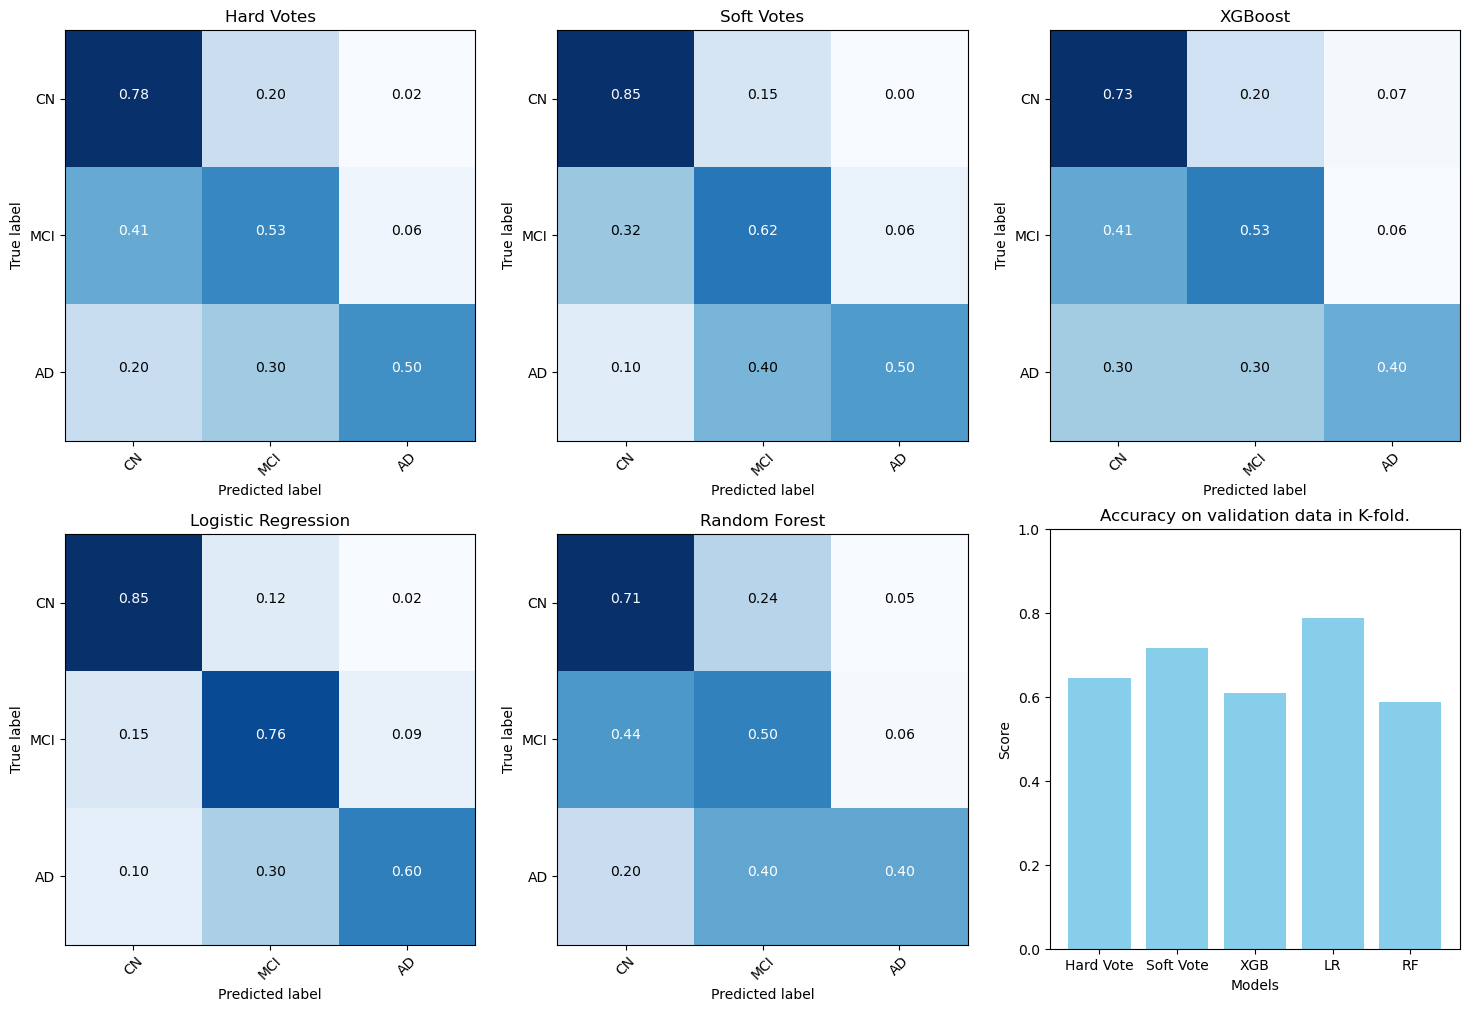

In [229]:
get_scores(all_models, votes, y_true, get_graphs = True)

## No ComBat

### GridSearchCV

In [50]:
all_models, votes, y_true = pipeline(df_union_no_combat, y, params_grid, tmt_set)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 4.1797544956207275 seconds.

LR 0 started.
LR 0 is done in 3.094740390777588 seconds.

RF 0 started.
RF 0 is done in 4.259099006652832 seconds.

Hard vote F1 score: 0.8395061728395061
Soft vote F1 score: 1.0

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 2.4495575428009033 seconds.

LR 1 started.
LR 1 is done in 3.088505983352661 seconds.

RF 1 started.
RF 1 is done in 4.104635715484619 seconds.

Hard vote F1 score: 0.5185185185185185
Soft vote F1 score: 0.5206349206349207

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 2.526779890060425 seconds.

LR 2 started.
LR 2 is done in 3.2818615436553955 seconds.

RF 2 started.
RF 2 is done in 4.165810585021973 seconds.

Hard vote F1 score: 0.7142857142857143
Soft vote F1 score: 0.7142857142857143

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 2.4872989654541016 se

XGB       	AUC OVR: 0.840828511292348   	AUC OVO: 0.8393591582974653  	ACC: 0.7294117647058823  	F1: 0.729453781512605
LR        	AUC OVR: 0.8371823168813632  	AUC OVO: 0.8208632233381158  	ACC: 0.6823529411764706  	F1: 0.6834741980292005
RF        	AUC OVR: 0.7994017804852476  	AUC OVO: 0.7949007651841224  	ACC: 0.6941176470588235  	F1: 0.6861196234814986
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7647058823529411  	F1: 0.7612537327582121
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7294117647058823  	F1: 0.7213397865475305


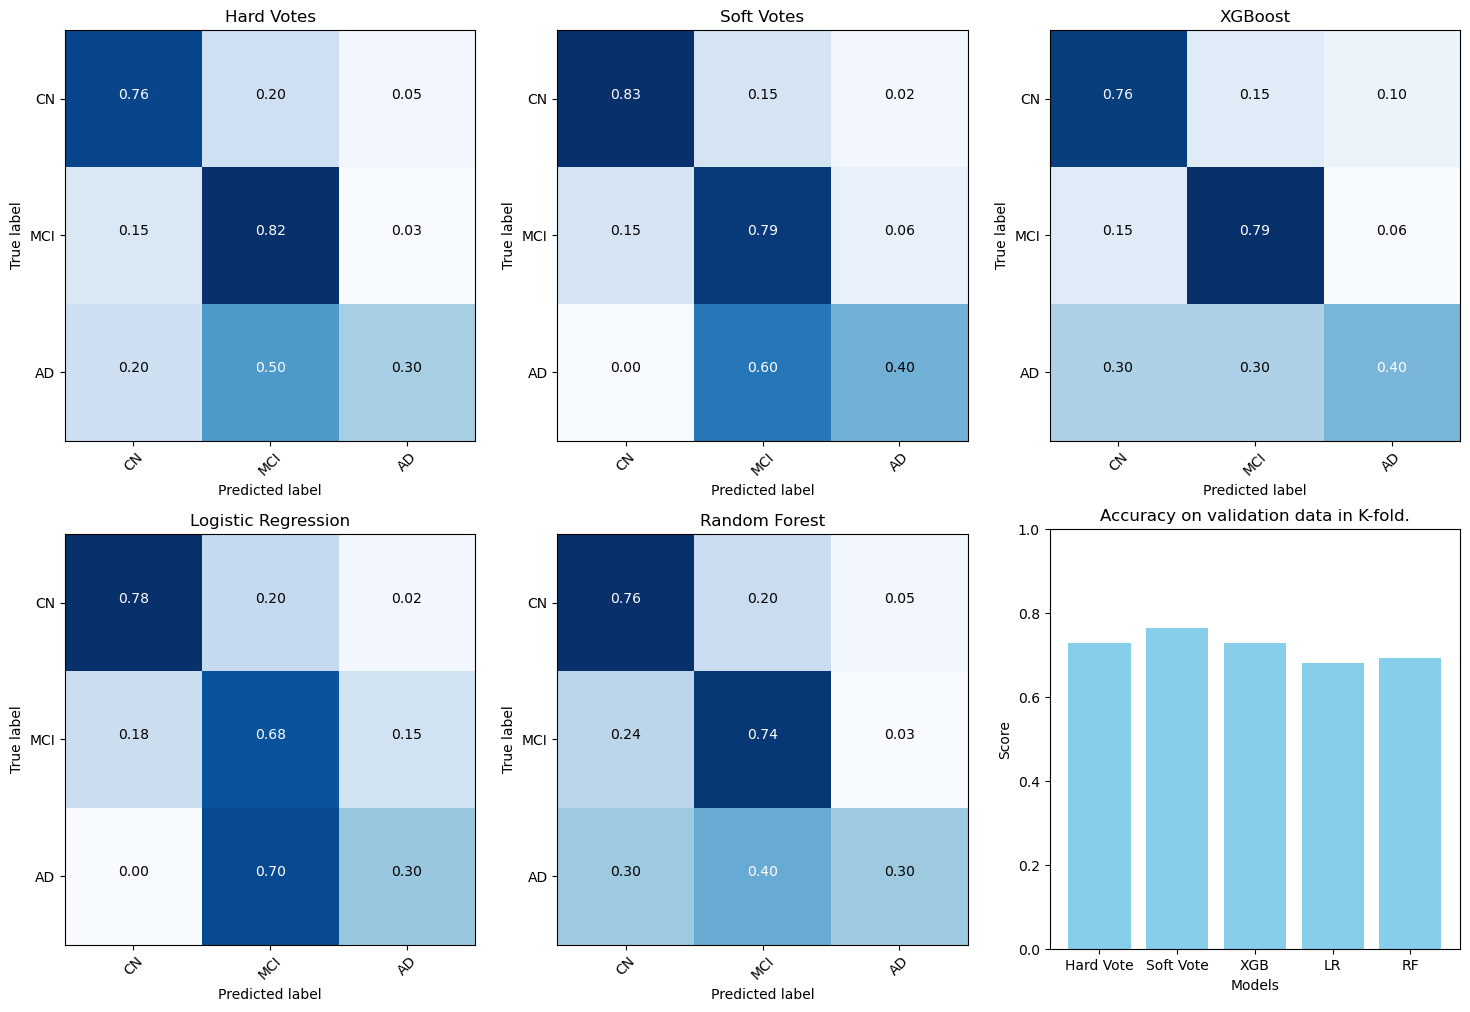

In [51]:
get_scores(all_models, votes, y_true, get_graphs = True)

### BayesSearchCV

In [52]:
all_models, votes, y_true = pipeline(df_union_no_combat, y, params_bayes, tmt_set, bayes=True)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 143.87047147750854 seconds.

LR 0 started.
LR 0 is done in 91.09669470787048 seconds.

RF 0 started.
RF 0 is done in 115.25897121429443 seconds.

Hard vote F1 score: 0.7629629629629631
Soft vote F1 score: 0.6095238095238096

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 111.35483145713806 seconds.

LR 1 started.
LR 1 is done in 95.69232225418091 seconds.

RF 1 started.
RF 1 is done in 170.47596621513367 seconds.

Hard vote F1 score: 0.41975308641975306
Soft vote F1 score: 0.4444444444444444

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 261.5870883464813 seconds.

LR 2 started.
LR 2 is done in 184.56517386436462 seconds.

RF 2 started.
RF 2 is done in 218.25355315208435 seconds.

Hard vote F1 score: 0.3905723905723905
Soft vote F1 score: 0.5206349206349207

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 23

c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 50, 'log2', 1, 500, -1] before, using random point ['gini', 5, 'log2', 3, 477, -1]
  warnings.warn(


RF 4 is done in 243.4020528793335 seconds.

Hard vote F1 score: 0.7272727272727272
Soft vote F1 score: 0.8383838383838383

K-Fold validation: Iteration 5.
XGB 5 started.
XGB 5 is done in 241.66203141212463 seconds.

LR 5 started.
LR 5 is done in 182.61323404312134 seconds.

RF 5 started.
RF 5 is done in 167.51372051239014 seconds.

Hard vote F1 score: 0.8214285714285714
Soft vote F1 score: 0.8214285714285714

K-Fold validation: Iteration 6.
XGB 6 started.
XGB 6 is done in 161.1627140045166 seconds.

LR 6 started.
LR 6 is done in 102.86975908279419 seconds.

RF 6 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 50, 'sqrt', 1, 500, -1] before, using random point ['entropy', 49, 'log2', 5, 304, -1]
  warnings.warn(


RF 6 is done in 136.91326093673706 seconds.

Hard vote F1 score: 0.5892857142857143
Soft vote F1 score: 0.6944444444444444

K-Fold validation: Iteration 7.
XGB 7 started.
XGB 7 is done in 166.33699917793274 seconds.

LR 7 started.
LR 7 is done in 103.05680179595947 seconds.

RF 7 started.
RF 7 is done in 116.2370982170105 seconds.

Hard vote F1 score: 0.875
Soft vote F1 score: 0.75

K-Fold validation: Iteration 8.
XGB 8 started.
XGB 8 is done in 114.62580275535583 seconds.

LR 8 started.
LR 8 is done in 100.35047149658203 seconds.

RF 8 started.
RF 8 is done in 110.0423367023468 seconds.

Hard vote F1 score: 0.761904761904762
Soft vote F1 score: 0.630952380952381

K-Fold validation: Iteration 9.
XGB 9 started.
XGB 9 is done in 120.03436541557312 seconds.

LR 9 started.
LR 9 is done in 101.8067979812622 seconds.

RF 9 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 50, 'sqrt', 1, 500, -1] before, using random point ['entropy', 45, 'log2', 1, 333, -1]
  warnings.warn(


RF 9 is done in 126.7040741443634 seconds.

Hard vote F1 score: 0.55
Soft vote F1 score: 0.6944444444444444



XGB       	AUC OVR: 0.844155447631859   	AUC OVO: 0.8381516021042562  	ACC: 0.6823529411764706  	F1: 0.6763397697993454
LR        	AUC OVR: 0.8724995861220015  	AUC OVO: 0.8691296030607365  	ACC: 0.7176470588235294  	F1: 0.7161054032472717
RF        	AUC OVR: 0.8283319105477936  	AUC OVO: 0.8247489239598279  	ACC: 0.6941176470588235  	F1: 0.6887856318998188
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7294117647058823  	F1: 0.7192251548506727
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7176470588235294  	F1: 0.7121592298891388


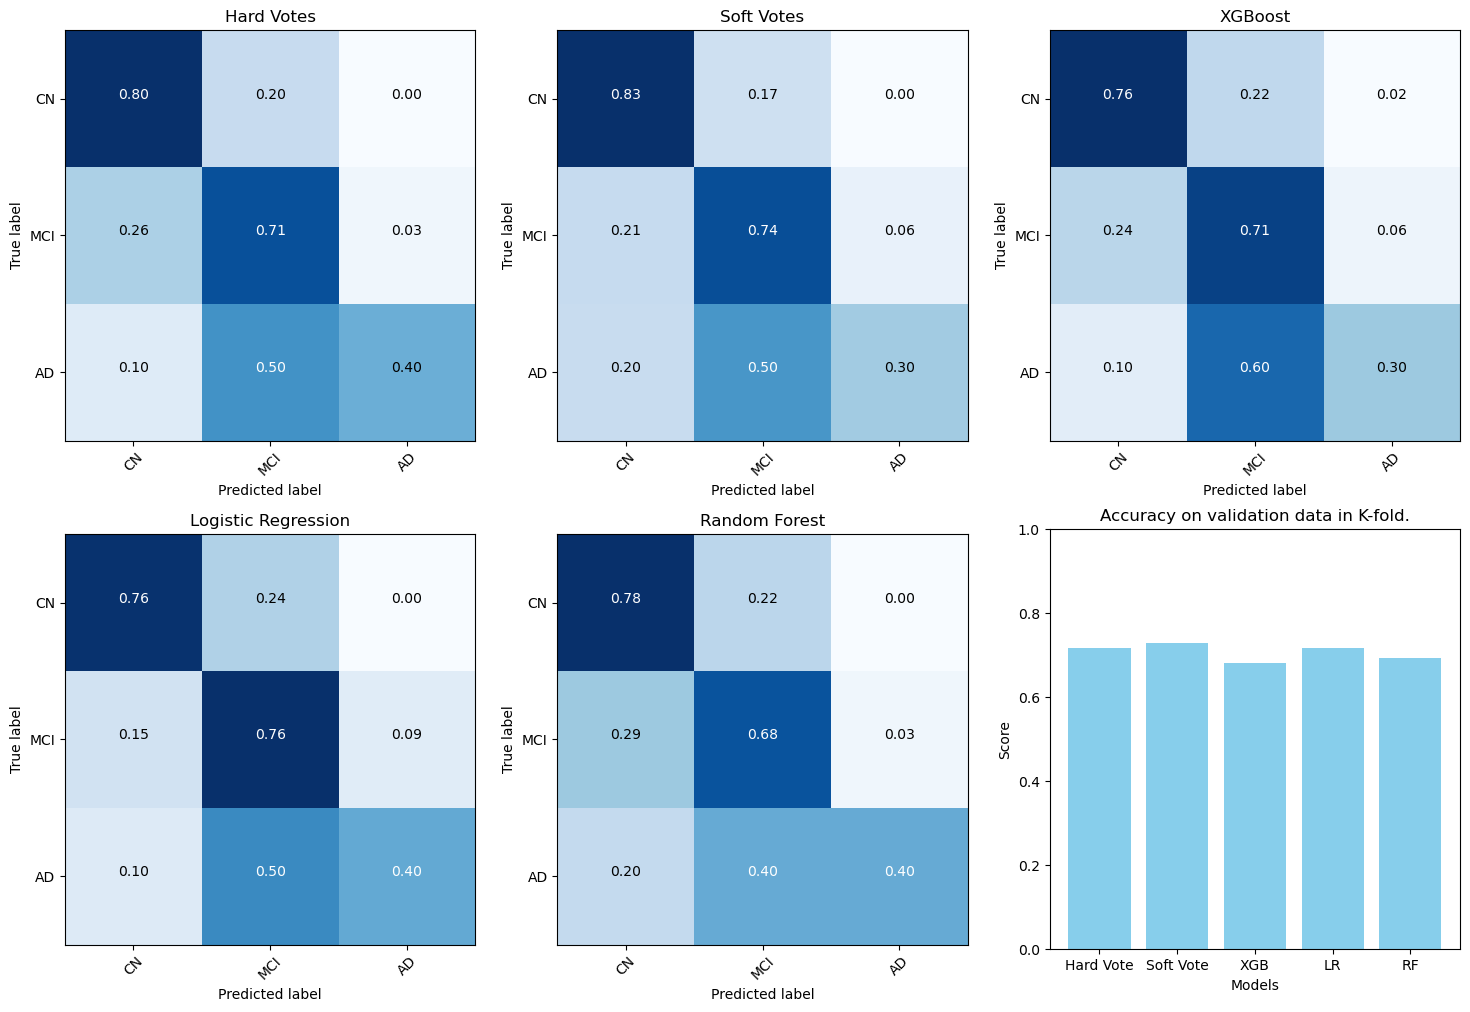

In [53]:
get_scores(all_models, votes, y_true, get_graphs = True)

## Predicting Batches

### No ComBat

In [62]:
all_models, votes, y_true = pipeline(df_union_no_combat, tmt_set, params_grid, tmt_set)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


XGB 0 is done in 32.12299609184265 seconds.

LR 0 started.
LR 0 is done in 39.0149667263031 seconds.

RF 0 started.
RF 0 is done in 16.4349946975708 seconds.

Hard vote F1 score: 0.6862745098039216
Soft vote F1 score: 0.6862745098039216

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 30.60290002822876 seconds.

LR 1 started.
LR 1 is done in 47.360716581344604 seconds.

RF 1 started.
RF 1 is done in 16.358764171600342 seconds.

Hard vote F1 score: 0.37254901960784315
Soft vote F1 score: 0.38235294117647056

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 30.937376499176025 seconds.

LR 2 started.
LR 2 is done in 43.089513063430786 seconds.

RF 2 started.
RF 2 is done in 16.344065189361572 seconds.

Hard vote F1 score: 0.40588235294117647
Soft vote F1 score: 0.4509803921568627

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 31.78725290298462 seconds.

LR 3 started.
LR 3 is done in 37.0628547668457 seconds.

RF 3 started.
RF 3 is done in 1

In [63]:
soft_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Soft')] for item in sublist]
y_trues = [item for sublist in [list(series) for series in y_true.values()] for item in sublist]

accuracy_score(soft_votes, y_trues)

0.5529411764705883

### ComBat

In [64]:
all_models, votes, y_true = pipeline(df_union, tmt_set, params_grid, tmt_set)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


XGB 0 is done in 50.43726849555969 seconds.

LR 0 started.
LR 0 is done in 101.30474042892456 seconds.

RF 0 started.
RF 0 is done in 22.101478099822998 seconds.

Hard vote F1 score: 0.0784313725490196
Soft vote F1 score: 0.0784313725490196

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 49.038681745529175 seconds.

LR 1 started.
LR 1 is done in 103.79271221160889 seconds.

RF 1 started.
RF 1 is done in 21.683737754821777 seconds.

Hard vote F1 score: 0.0
Soft vote F1 score: 0.0

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 49.177794218063354 seconds.

LR 2 started.
LR 2 is done in 103.5805435180664 seconds.

RF 2 started.
RF 2 is done in 22.224119424819946 seconds.

Hard vote F1 score: 0.0
Soft vote F1 score: 0.0

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 50.13669753074646 seconds.

LR 3 started.
LR 3 is done in 95.34372568130493 seconds.

RF 3 started.
RF 3 is done in 21.06077790260315 seconds.

Hard vote F1 score: 0.0
Soft vo

In [65]:
soft_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Soft')] for item in sublist]
y_trues = [item for sublist in [list(series) for series in y_true.values()] for item in sublist]

accuracy_score(soft_votes, y_trues)

0.011764705882352941

## Min Imputation

### Code

In [207]:
df_median = pd.read_csv("./Data/data files/iNPH_data_protein_median.csv")
df_lumbar = df_median[df_median["CSF_type"] == "L"]
df_lumbar = df_lumbar.reset_index()
df_lumbar = df_lumbar.iloc[:, 13:]
df_lumbar.replace([np.inf, -np.inf], np.nan, inplace=True)
df_lumbar = set_max_missingness_per_column(df_lumbar, 0.95)

def impute_with_smallest(column):
    smallest = column.min(skipna=True)
    return column.fillna(smallest)

df_lumbar_min_imputation = df_lumbar.apply(impute_with_smallest)
df_lumbar_min_imputation_union = df_lumbar_min_imputation[list_union]
df_lumbar_min_imputation_combat = run_combat(df_lumbar_min_imputation, tmt_set)
df_lumbar_min_imputation_combat_union = df_lumbar_min_imputation_combat[list_union]


Found 15 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


c:\Users\Toffe\anaconda3\Lib\site-packages\combat\pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


### Cortial Biopsy Grouping

In [ ]:
all_models, votes, y_true = pipeline(df_lumbar_min_imputation, y, params_grid, tmt_set)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 6.836424827575684 seconds.

LR 0 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LR 0 is done in 96.23862504959106 seconds.

RF 0 started.
RF 0 is done in 1.2872474193572998 seconds.



c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Hard vote F1 score: 0.4304388422035481
Soft vote F1 score: 0.493194925028835

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 5.640211343765259 seconds.

LR 1 started.
LR 1 is done in 89.56168627738953 seconds.

RF 1 started.
RF 1 is done in 1.3205077648162842 seconds.

Hard vote F1 score: 0.28911645629911886
Soft vote F1 score: 0.3174603174603175

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 5.7191808223724365 seconds.

LR 2 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LR 2 is done in 90.31562089920044 seconds.

RF 2 started.
RF 2 is done in 1.3180451393127441 seconds.



c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Hard vote F1 score: 0.43790849673202614
Soft vote F1 score: 0.3856209150326797

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 4.974410772323608 seconds.

LR 3 started.
LR 3 is done in 97.04021692276001 seconds.

RF 3 started.
RF 3 is done in 1.3017089366912842 seconds.

Hard vote F1 score: 0.49547511312217196
Soft vote F1 score: 0.49547511312217196

K-Fold validation: Iteration 4.
XGB 4 started.
XGB 4 is done in 5.419002294540405 seconds.

LR 4 started.
LR 4 is done in 82.3244743347168 seconds.

RF 4 started.
RF 4 is done in 1.3036229610443115 seconds.

Hard vote F1 score: 0.49122807017543857
Soft vote F1 score: 0.3025210084033614



XGB       	AUC OVR: 0.47078678761622467 	AUC OVO: 0.46391678622668575 	ACC: 0.4117647058823529  	F1: 0.4079654314948432
LR        	AUC OVR: 0.5312059475674972  	AUC OVO: 0.516260162601626   	ACC: 0.4235294117647059  	F1: 0.42708648016168493
RF        	AUC OVR: 0.5245522743682925  	AUC OVO: 0.5126733620277378  	ACC: 0.47058823529411764 	F1: 0.4529654476083221
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.4235294117647059  	F1: 0.4159767610748003
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.4470588235294118  	F1: 0.4380443086325439


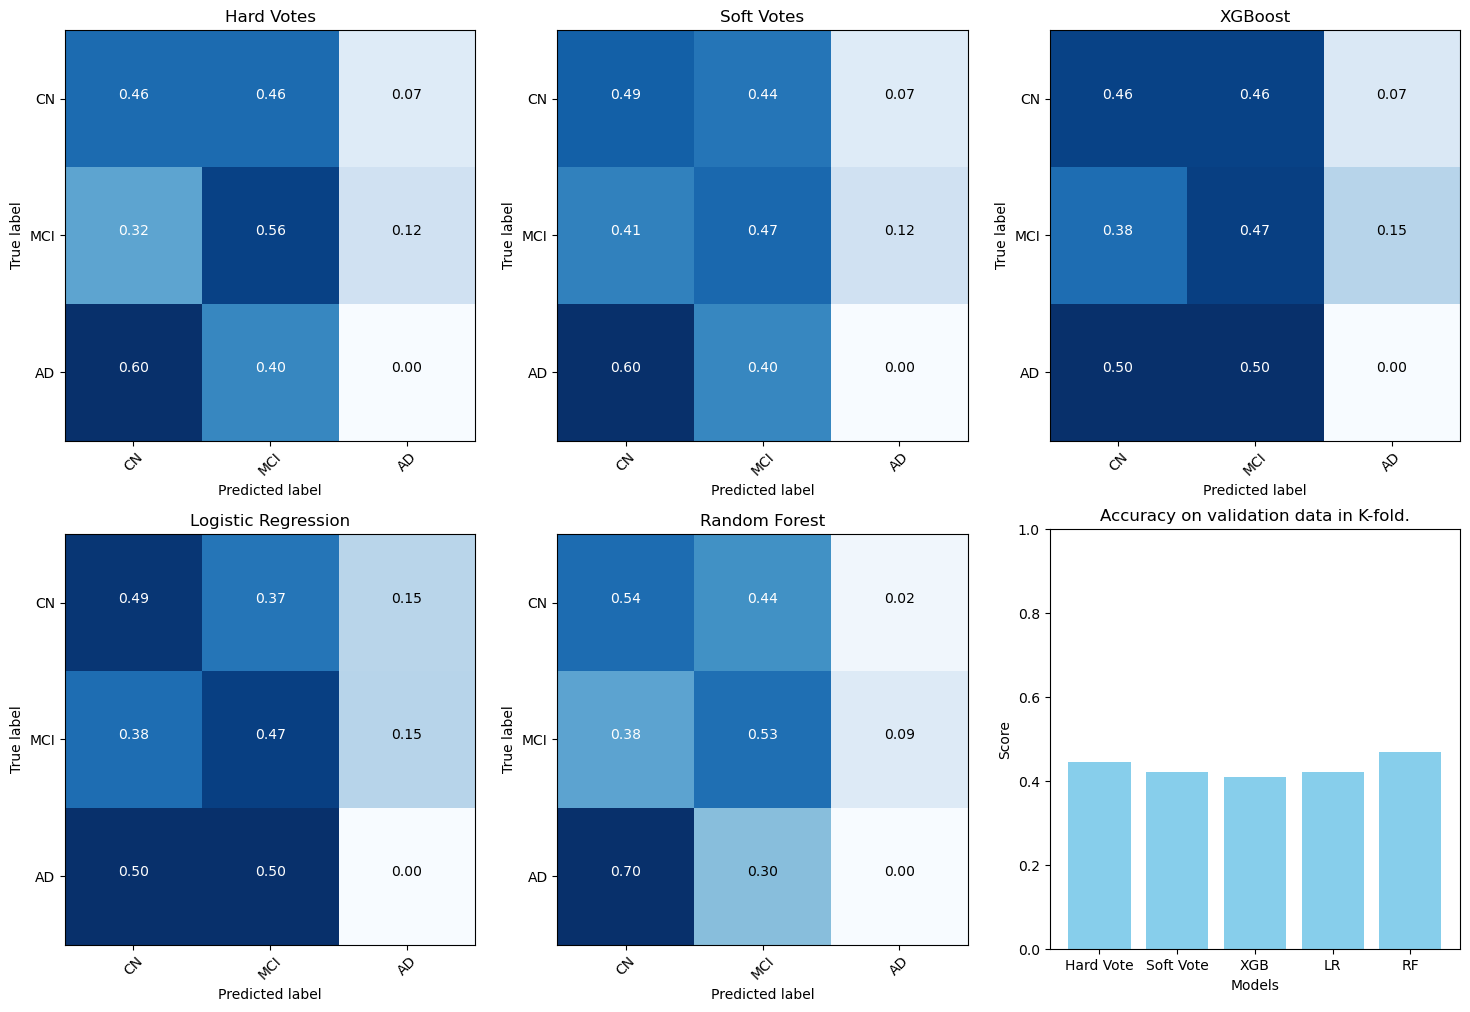

In [ ]:
get_scores(all_models, votes, y_true, get_graphs=True)

### Cortial Biopsy Grouping Union

In [231]:
all_models, votes, y_true = pipeline(df_lumbar_min_imputation_union, y, params_bayes, tmt_set, bayes=True)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.


XGB 0 is done in 137.1427812576294 seconds.

LR 0 started.
LR 0 is done in 105.8722915649414 seconds.

RF 0 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 'log2', 1, 500, -1] before, using random point ['entropy', 12, 'log2', 2, 453, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 'log2', 1, 500, -1] before, using random point ['gini', 48, 'sqrt', 2, 145, -1]
  warnings.warn(


RF 0 is done in 143.27196884155273 seconds.

Hard vote F1 score: 0.7760141093474426
Soft vote F1 score: 0.7760141093474426

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 131.11264824867249 seconds.

LR 1 started.
LR 1 is done in 108.18410754203796 seconds.

RF 1 started.
RF 1 is done in 124.58019280433655 seconds.

Hard vote F1 score: 0.7777777777777778
Soft vote F1 score: 0.6518518518518519

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 136.31142854690552 seconds.

LR 2 started.
LR 2 is done in 111.32534670829773 seconds.

RF 2 started.
RF 2 is done in 131.43342900276184 seconds.

Hard vote F1 score: 0.8994708994708994
Soft vote F1 score: 0.8994708994708994

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 120.99294972419739 seconds.

LR 3 started.
LR 3 is done in 104.94313383102417 seconds.

RF 3 started.
RF 3 is done in 120.73694944381714 seconds.

Hard vote F1 score: 0.4444444444444444
Soft vote F1 score: 0.37037037037037035

K-Fol

XGB       	AUC OVR: 0.806970994440992   	AUC OVO: 0.7853299856527977  	ACC: 0.7294117647058823  	F1: 0.7274554673127832
LR        	AUC OVR: 0.7866926621263696  	AUC OVO: 0.7683644189383071  	ACC: 0.6470588235294118  	F1: 0.661122750470051
RF        	AUC OVR: 0.7962306191290915  	AUC OVO: 0.7921209947393592  	ACC: 0.6470588235294118  	F1: 0.6330785221963205
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.6823529411764706  	F1: 0.6858331211272387
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7058823529411765  	F1: 0.7033068605016378


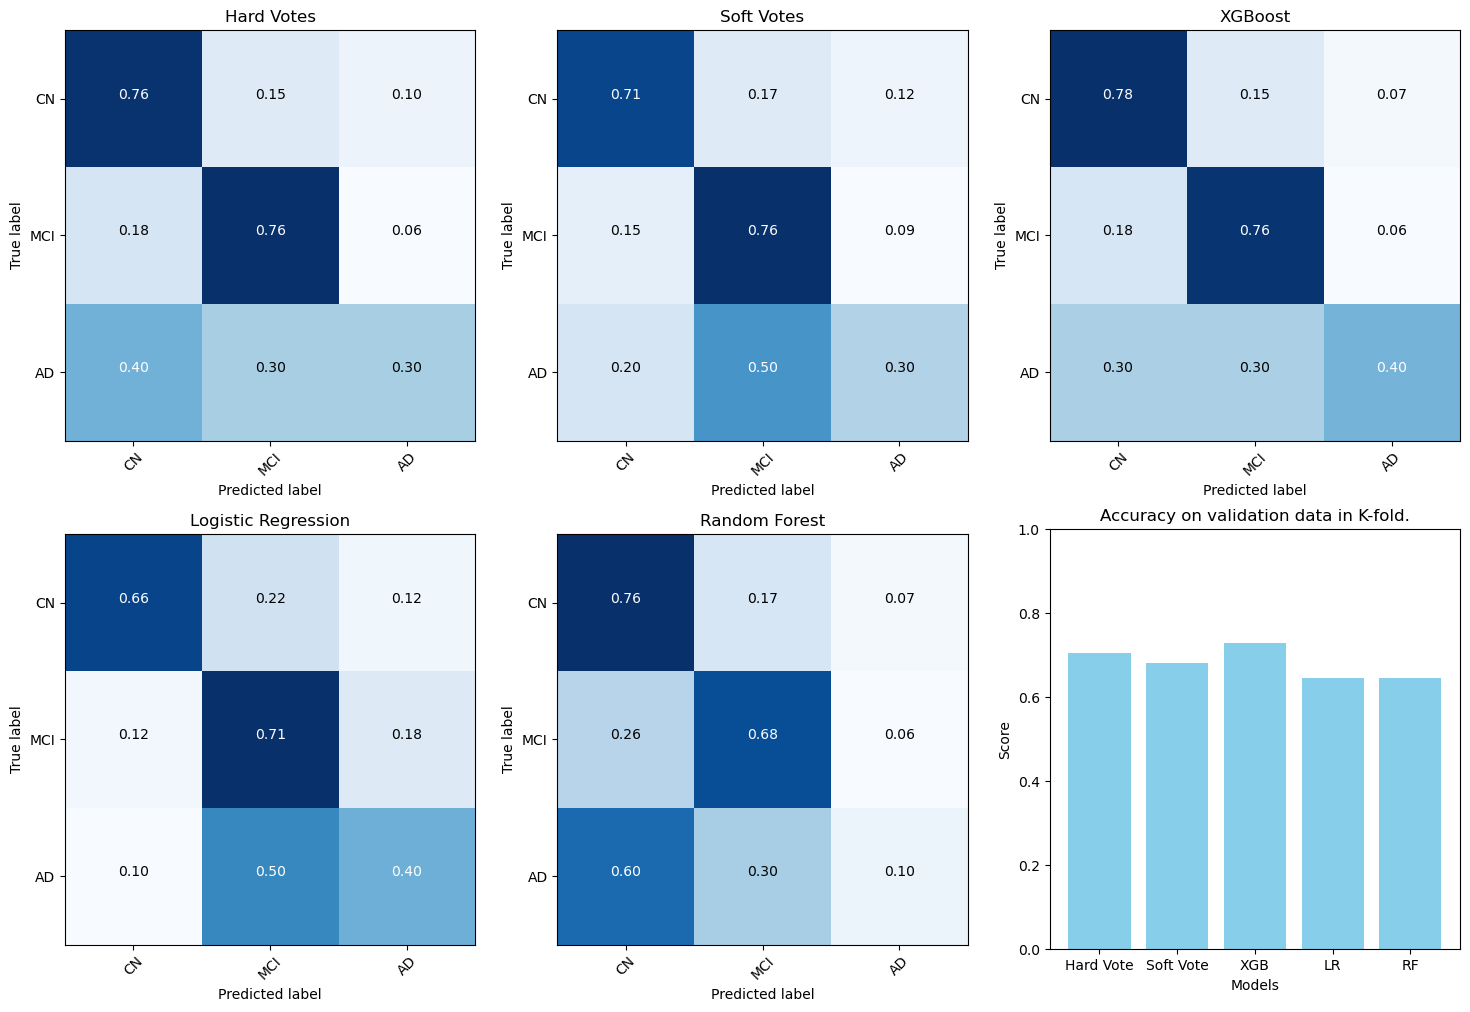

In [232]:
get_scores(all_models, votes, y_true, get_graphs=True)

### Cortial Biopsy Grouping ComBat

In [ ]:
all_models, votes, y_true = pipeline(df_lumbar_min_imputation_combat, y, params_grid, tmt_set)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 5.774812936782837 seconds.

LR 0 started.
LR 0 is done in 78.38913774490356 seconds.

RF 0 started.
RF 0 is done in 1.2516777515411377 seconds.

Hard vote F1 score: 0.38935574229691877
Soft vote F1 score: 0.39366515837104066

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 5.818554639816284 seconds.

LR 1 started.
LR 1 is done in 41.96968674659729 seconds.

RF 1 started.
RF 1 is done in 1.342071294784546 seconds.

Hard vote F1 score: 0.27081891580161477
Soft vote F1 score: 0.27170868347338933

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 6.041057109832764 seconds.

LR 2 started.
LR 2 is done in 49.24374532699585 seconds.

RF 2 started.
RF 2 is done in 1.4105925559997559 seconds.

Hard vote F1 score: 0.600142891164563
Soft vote F1 score: 0.4641711229946524

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 6.02

XGB       	AUC OVR: 0.4998958527804844  	AUC OVO: 0.500920612147298   	ACC: 0.4235294117647059  	F1: 0.42054154995331466
LR        	AUC OVR: 0.4819692869278489  	AUC OVO: 0.506025824964132   	ACC: 0.35294117647058826 	F1: 0.3515741808706053
RF        	AUC OVR: 0.5272558635558044  	AUC OVO: 0.5346843615494978  	ACC: 0.4117647058823529  	F1: 0.39331419433151577
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.38823529411764707 	F1: 0.3854664133548529
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.38823529411764707 	F1: 0.38457411133467473


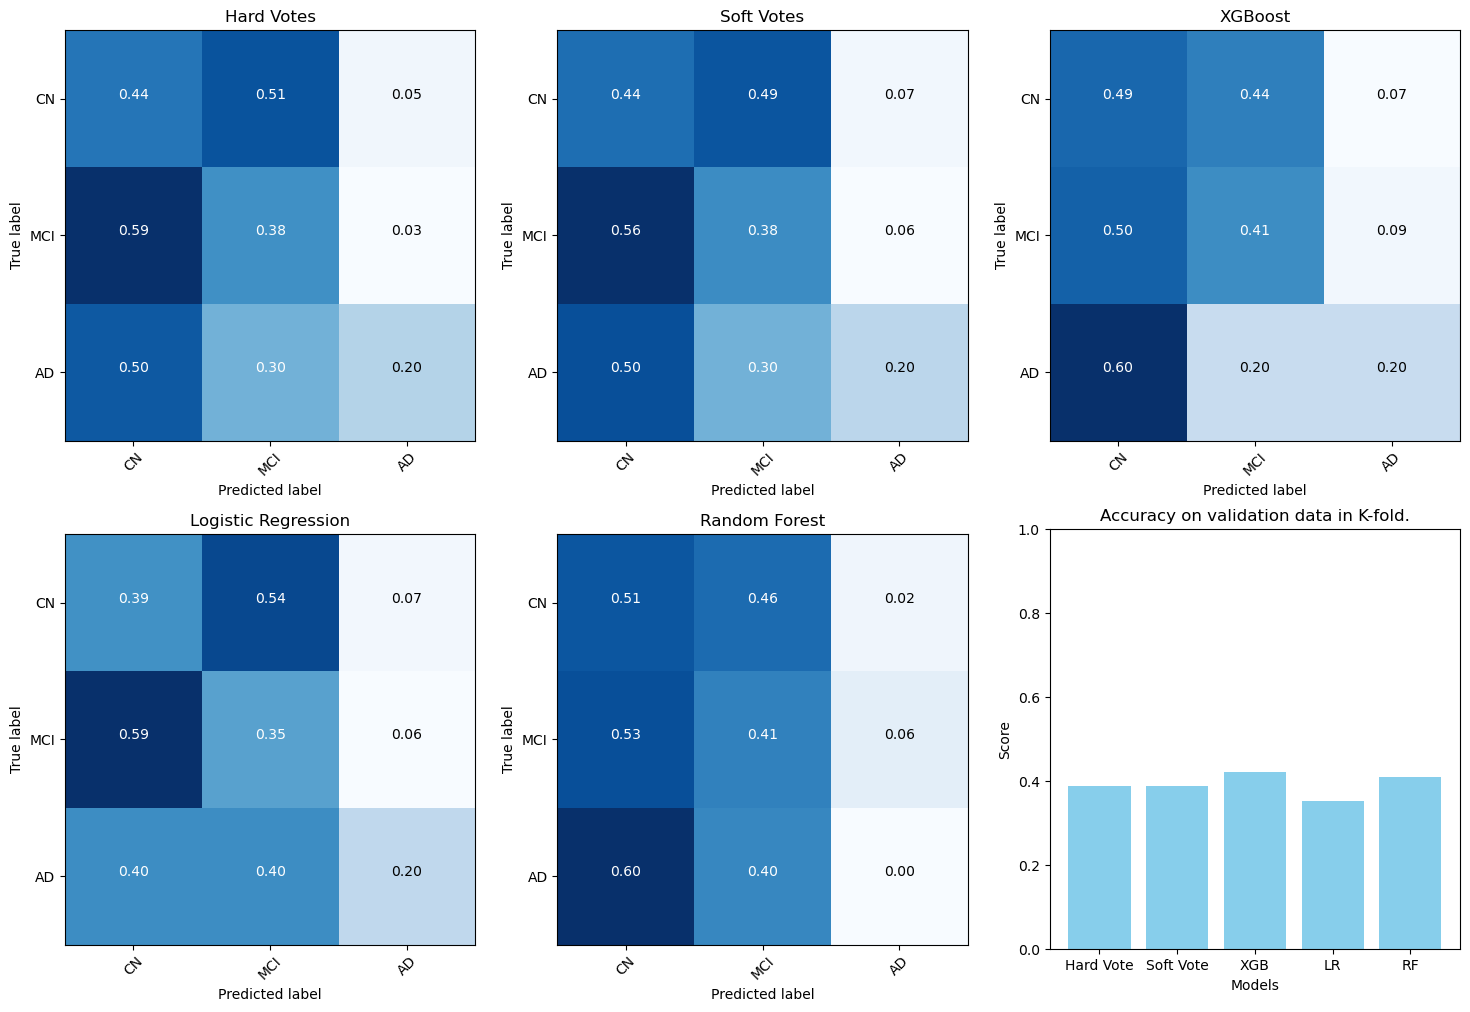

In [ ]:
get_scores(all_models, votes, y_true, get_graphs=True)

### Cortial Biopsy Grouping ComBat Union

In [233]:
all_models, votes, y_true = pipeline(df_lumbar_min_imputation_combat_union, y, params_bayes, tmt_set, bayes=True)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 135.54949402809143 seconds.

LR 0 started.
LR 0 is done in 105.80407166481018 seconds.

RF 0 started.
RF 0 is done in 115.35341906547546 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 1.0

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 133.66875004768372 seconds.

LR 1 started.
LR 1 is done in 120.41202878952026 seconds.

RF 1 started.
RF 1 is done in 114.50855302810669 seconds.

Hard vote F1 score: 0.6613756613756614
Soft vote F1 score: 0.7777777777777778

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 138.7902979850769 seconds.

LR 2 started.
LR 2 is done in 98.46650862693787 seconds.

RF 2 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 41, 'log2', 1, 500, -1] before, using random point ['entropy', 38, 'sqrt', 4, 218, -1]
  warnings.warn(


RF 2 is done in 125.8383846282959 seconds.

Hard vote F1 score: 0.7283950617283951
Soft vote F1 score: 0.8395061728395061

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 130.57816410064697 seconds.

LR 3 started.
LR 3 is done in 97.30646991729736 seconds.

RF 3 started.
RF 3 is done in 157.19495487213135 seconds.

Hard vote F1 score: 0.8871252204585538
Soft vote F1 score: 0.7777777777777778

K-Fold validation: Iteration 4.
XGB 4 started.
XGB 4 is done in 176.96814823150635 seconds.

LR 4 started.
LR 4 is done in 172.4434368610382 seconds.

RF 4 started.
RF 4 is done in 119.04177761077881 seconds.

Hard vote F1 score: 0.5037037037037037
Soft vote F1 score: 0.5037037037037037

K-Fold validation: Iteration 5.
XGB 5 started.
XGB 5 is done in 132.73547506332397 seconds.

LR 5 started.
LR 5 is done in 103.17132949829102 seconds.

RF 5 started.
RF 5 is done in 108.5711350440979 seconds.

Hard vote F1 score: 0.6964285714285714
Soft vote F1 score: 0.6964285714285714

K-Fold val

c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 'sqrt', 1, 500, -1] before, using random point ['gini', 43, 'sqrt', 1, 88, -1]
  warnings.warn(


RF 7 is done in 112.34762382507324 seconds.

Hard vote F1 score: 0.7000000000000001
Soft vote F1 score: 0.7000000000000001

K-Fold validation: Iteration 8.
XGB 8 started.
XGB 8 is done in 127.46923518180847 seconds.

LR 8 started.
LR 8 is done in 128.35793280601501 seconds.

RF 8 started.
RF 8 is done in 169.59341096878052 seconds.

Hard vote F1 score: 0.7395833333333333
Soft vote F1 score: 0.5

K-Fold validation: Iteration 9.
XGB 9 started.
XGB 9 is done in 246.05115842819214 seconds.

LR 9 started.
LR 9 is done in 207.64100337028503 seconds.

RF 9 started.
RF 9 is done in 263.50429368019104 seconds.

Hard vote F1 score: 0.27380952380952384
Soft vote F1 score: 0.41071428571428575



XGB       	AUC OVR: 0.7358973548464643  	AUC OVO: 0.721999043519847   	ACC: 0.6352941176470588  	F1: 0.6232114467408585
LR        	AUC OVR: 0.8391873942394662  	AUC OVO: 0.8389167862266859  	ACC: 0.7176470588235294  	F1: 0.7230060987605745
RF        	AUC OVR: 0.7615013422263822  	AUC OVO: 0.7671150167384028  	ACC: 0.6352941176470588  	F1: 0.6280564280010646
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7294117647058823  	F1: 0.7311760525105564
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7176470588235294  	F1: 0.7150653594771241


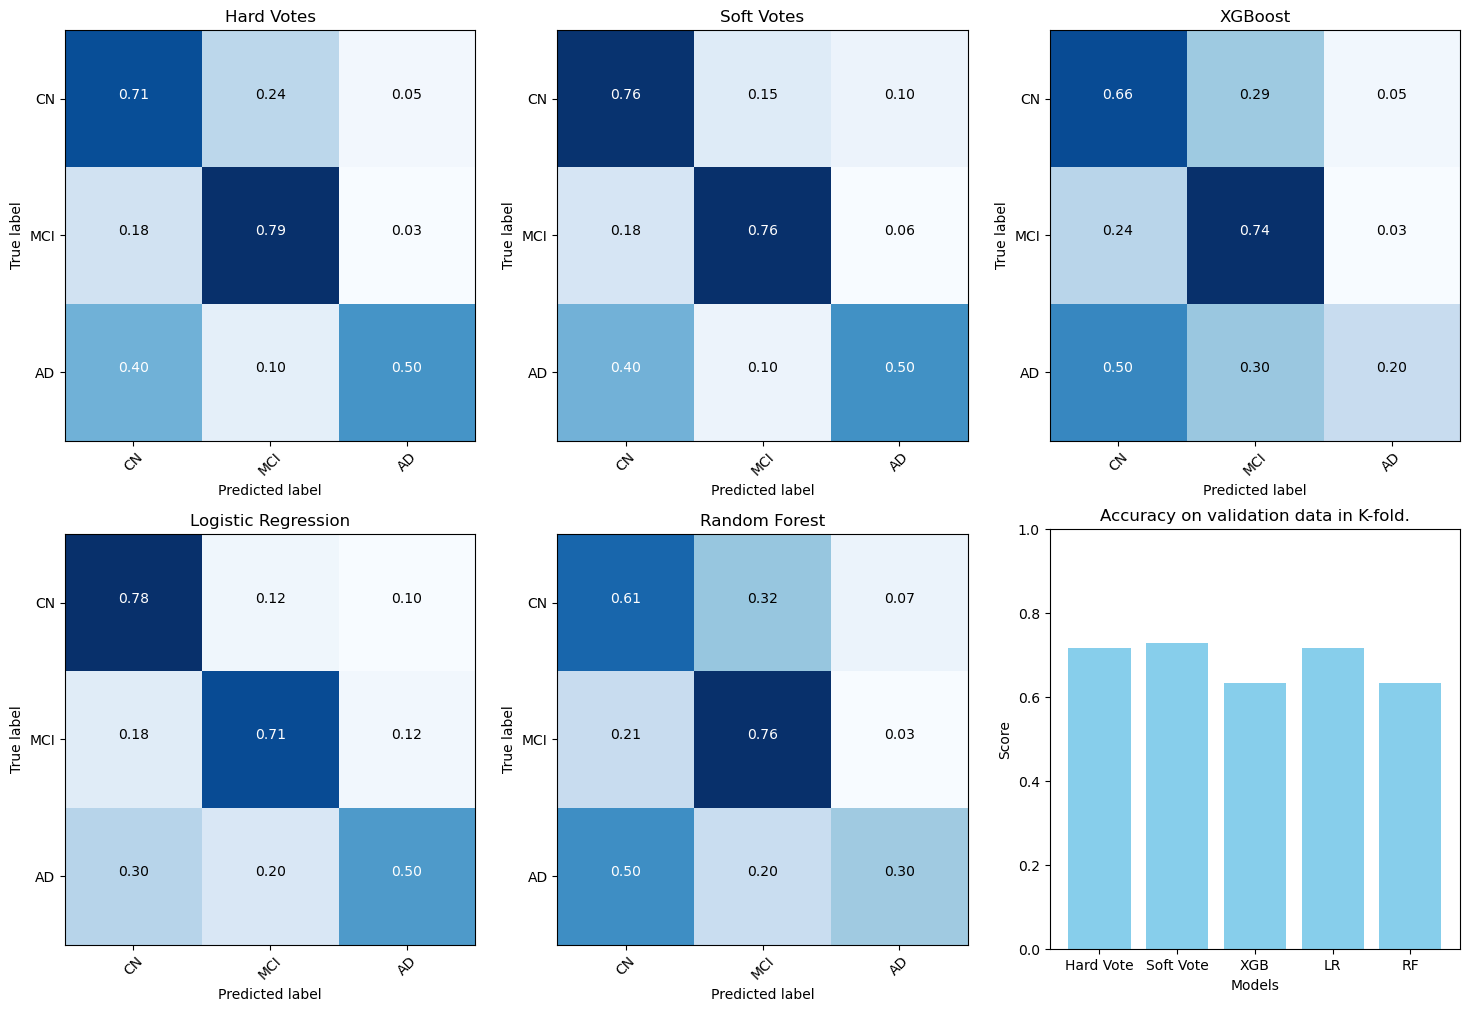

In [234]:
get_scores(all_models, votes, y_true, get_graphs=True)

### TMT Set ComBat

In [236]:
all_models, votes, y_true = pipeline(df_lumbar_min_imputation_combat_union, tmt_set, params_grid, tmt_set)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


XGB 0 is done in 45.057173013687134 seconds.

LR 0 started.
LR 0 is done in 34.585999727249146 seconds.

RF 0 started.
RF 0 is done in 19.17963671684265 seconds.

Hard vote F1 score: 0.0980392156862745
Soft vote F1 score: 0.0980392156862745

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 44.71875882148743 seconds.

LR 1 started.
LR 1 is done in 35.3729407787323 seconds.

RF 1 started.
RF 1 is done in 18.920735597610474 seconds.

Hard vote F1 score: 0.1568627450980392
Soft vote F1 score: 0.16470588235294117

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 43.64595317840576 seconds.

LR 2 started.
LR 2 is done in 60.28708291053772 seconds.

RF 2 started.
RF 2 is done in 18.44484305381775 seconds.

Hard vote F1 score: 0.196078431372549
Soft vote F1 score: 0.16470588235294117

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 42.92303395271301 seconds.

LR 3 started.
LR 3 is done in 83.05860924720764 seconds.

RF 3 started.
RF 3 is done in 19.

In [237]:
soft_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Soft')] for item in sublist]
y_trues = [item for sublist in [list(series) for series in y_true.values()] for item in sublist]

accuracy_score(soft_votes, y_trues)

0.11764705882352941

### TMT Set No ComBat

In [238]:
all_models, votes, y_true = pipeline(df_lumbar_min_imputation_union, tmt_set, params_grid, tmt_set)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


XGB 0 is done in 31.332927703857422 seconds.

LR 0 started.
LR 0 is done in 56.74635910987854 seconds.

RF 0 started.
RF 0 is done in 15.878509521484375 seconds.

Hard vote F1 score: 0.892156862745098
Soft vote F1 score: 0.7294117647058823

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 30.604283094406128 seconds.

LR 1 started.
LR 1 is done in 66.3071837425232 seconds.

RF 1 started.
RF 1 is done in 15.781319618225098 seconds.

Hard vote F1 score: 0.7843137254901961
Soft vote F1 score: 0.7333333333333334

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 31.240684986114502 seconds.

LR 2 started.
LR 2 is done in 52.539918184280396 seconds.

RF 2 started.
RF 2 is done in 15.92286467552185 seconds.

Hard vote F1 score: 0.780392156862745
Soft vote F1 score: 0.6333333333333333

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 31.72865343093872 seconds.

LR 3 started.
LR 3 is done in 55.43585181236267 seconds.

RF 3 started.
RF 3 is done in 15.

In [239]:
soft_votes = [item for sublist in [value for key, value in votes.items() if key.startswith('Soft')] for item in sublist]
y_trues = [item for sublist in [list(series) for series in y_true.values()] for item in sublist]

accuracy_score(soft_votes, y_trues)

0.7764705882352941

## Perturbation vs SMOTE

### Union

In [28]:
df_union = df_main[['P61626', 'Q99727', 'Q08554', 'P01766', 'O15232', 'Q12765',
       'A0A087WSZ0', 'Q13508', 'P35527', 'Q9UP79', 'P51864', 'P00995',
       'P61981', 'Q16799', 'P01624', 'P31949', 'P02452', 'P15291', 'Q9BUD6',
       'P00738', 'P05408', 'Q6ZRP7', 'P55268', 'Q9Y2G1', 'A0A0G2JMI3',
       'P63104', 'P07711', 'Q9Y6R7', 'Q96QP1', 'P06753', 'P01871', 'O95965',
       'P13647', 'Q14956', 'P78324', 'Q9NPH3', 'Q6UWU2']]

### Perturbation

In [46]:
all_models, votes, y_true = pipeline(df_union, y, params_bayes, tmt_set, bayes=True, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 250.57640194892883 seconds.

LR 0 started.
LR 0 is done in 197.25990438461304 seconds.

RF 0 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 'sqrt', 5, 362, -1] before, using random point ['gini', 6, 'sqrt', 3, 392, -1]
  warnings.warn(


RF 0 is done in 227.41713547706604 seconds.

Hard vote F1 score: 0.5502645502645502
Soft vote F1 score: 0.6613756613756615

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 286.20379734039307 seconds.

LR 1 started.
LR 1 is done in 191.48658275604248 seconds.

RF 1 started.


XGB       	AUC OVR: 0.8205466411946284  	AUC OVO: 0.819273075083692   	ACC: 0.6470588235294118  	F1: 0.6381629861246824
LR        	AUC OVR: 0.7202991259544554  	AUC OVO: 0.7279650884744141  	ACC: 0.49411764705882355 	F1: 0.5138733730657188
RF        	AUC OVR: 0.7912779759788791  	AUC OVO: 0.7932687709230034  	ACC: 0.6705882352941176  	F1: 0.6390509115415248
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.6588235294117647  	F1: 0.6495915575532538
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.6588235294117647  	F1: 0.6495915575532538


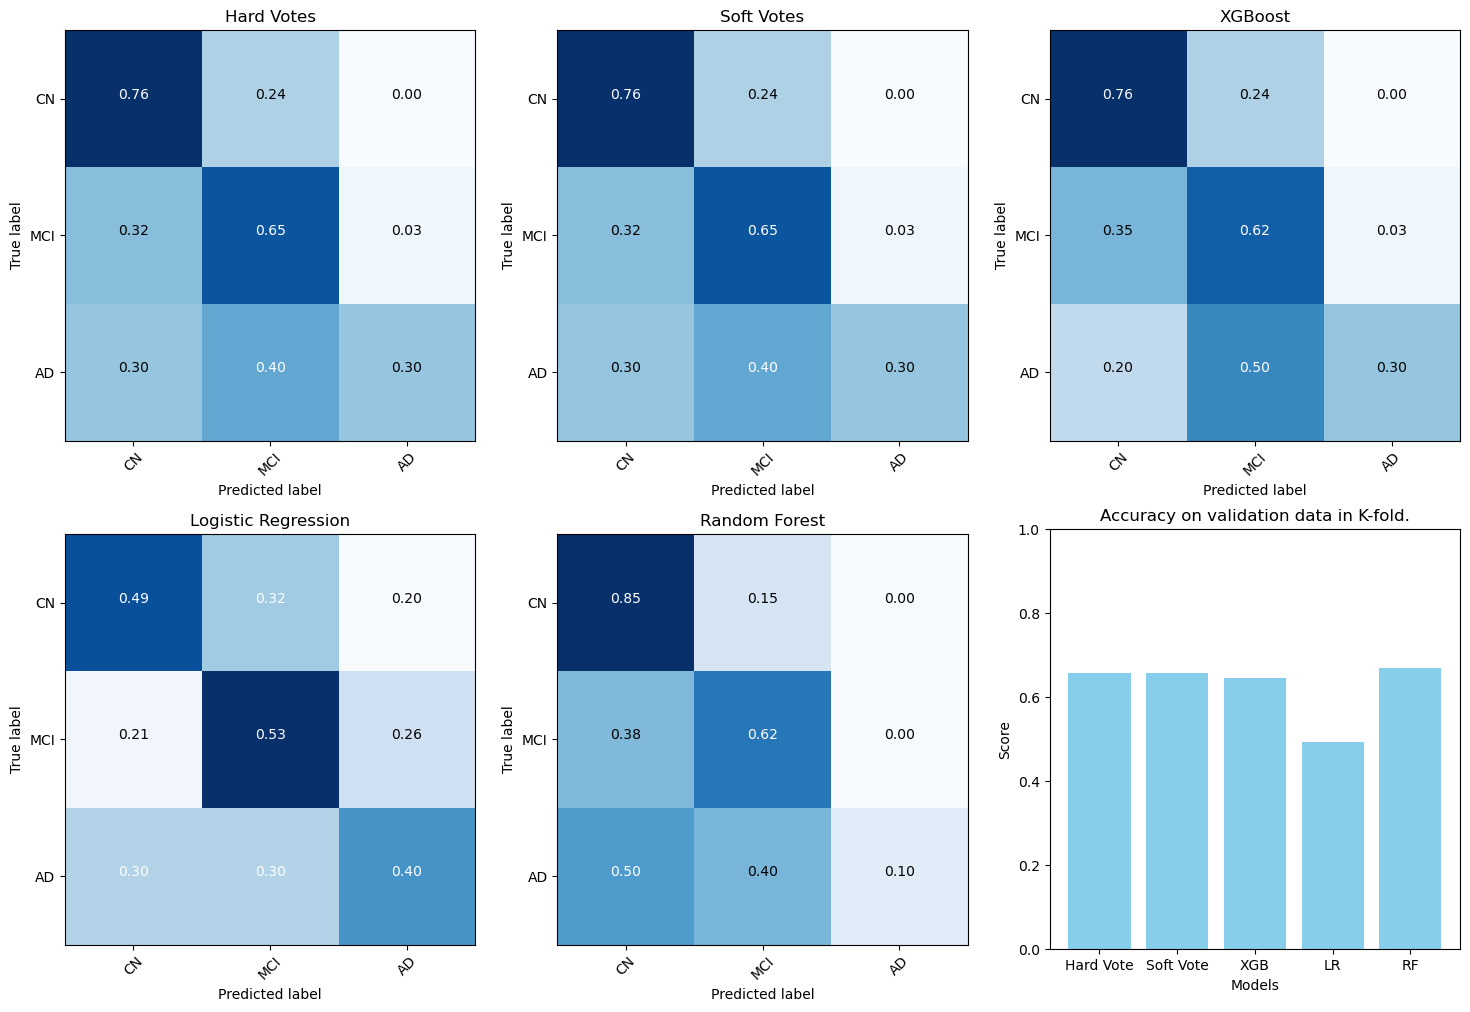

In [ ]:
get_scores(all_models, votes, y_true, get_graphs=True)

### SMOTE

In [ ]:
all_models, votes, y_true = pipeline(df_union, y, params_bayes, tmt_set, bayes=True, do_smote=True)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 45.23893475532532 seconds.

LR 0 started.
LR 0 is done in 28.204267024993896 seconds.

RF 0 started.
RF 0 is done in 38.176711559295654 seconds.

Hard vote F1 score: 0.7365079365079364
Soft vote F1 score: 0.7629629629629631

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 41.04064464569092 seconds.

LR 1 started.
LR 1 is done in 26.635986804962158 seconds.

RF 1 started.
RF 1 is done in 40.3289155960083 seconds.

Hard vote F1 score: 0.7777777777777778
Soft vote F1 score: 0.7777777777777778

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 33.71261525154114 seconds.

LR 2 started.
LR 2 is done in 26.288724422454834 seconds.

RF 2 started.
RF 2 is done in 38.966076374053955 seconds.

Hard vote F1 score: 0.7777777777777778
Soft vote F1 score: 0.8871252204585538

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 39.91

c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LR 8 is done in 29.138223886489868 seconds.

RF 8 started.
RF 8 is done in 36.435961961746216 seconds.



c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Hard vote F1 score: 0.5892857142857143
Soft vote F1 score: 0.5892857142857143

K-Fold validation: Iteration 9.
XGB 9 started.
XGB 9 is done in 36.38099431991577 seconds.

LR 9 started.
LR 9 is done in 24.04686999320984 seconds.

RF 9 started.
RF 9 is done in 33.19714307785034 seconds.

Hard vote F1 score: 0.6944444444444444
Soft vote F1 score: 0.6944444444444444



XGB       	AUC OVR: 0.8469450381952702  	AUC OVO: 0.8380081300813007  	ACC: 0.7058823529411765  	F1: 0.7029906249684641
LR        	AUC OVR: 0.8790683201327137  	AUC OVO: 0.8778933524629364  	ACC: 0.7176470588235294  	F1: 0.7206636500754149
RF        	AUC OVR: 0.8477785953040406  	AUC OVO: 0.8685078909612626  	ACC: 0.6352941176470588  	F1: 0.6255002513826043
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7176470588235294  	F1: 0.7161903541372977
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.6941176470588235  	F1: 0.6916262975778547


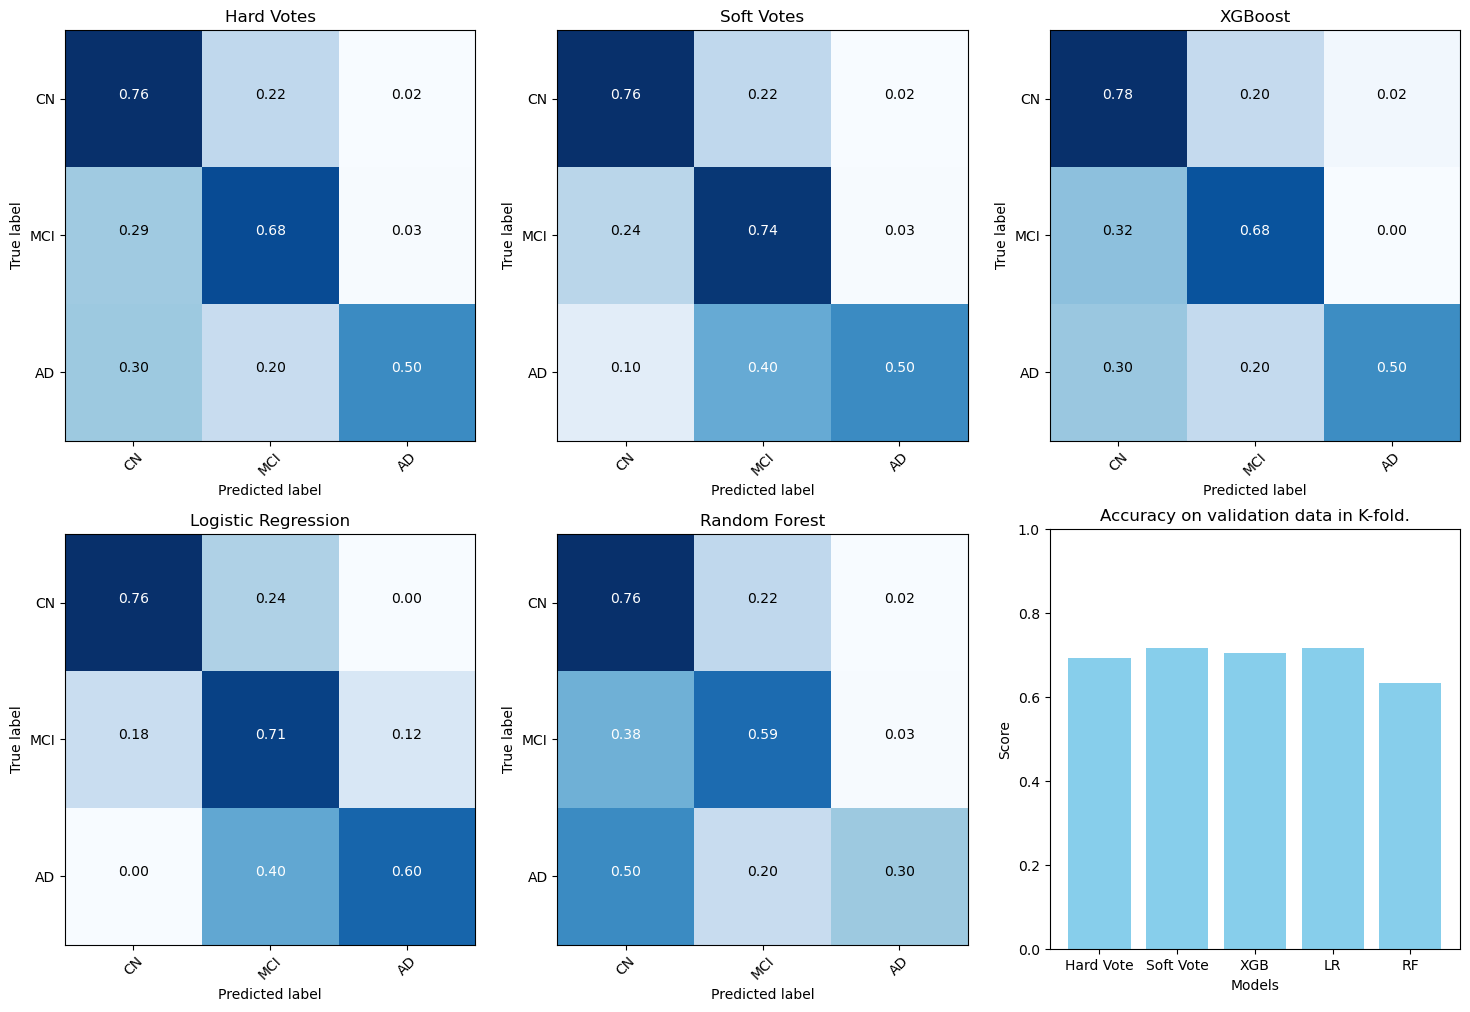

In [ ]:
get_scores(all_models, votes, y_true, get_graphs=True)

### Perturbation No --> 500

#### 0

In [35]:
#No perturbation
all_models, votes, y_true = pipeline(df_union, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.


XGB 0 is done in 9.033042192459106 seconds.

LR 0 started.
LR 0 is done in 9.676899909973145 seconds.

RF 0 started.
RF 0 is done in 24.10394811630249 seconds.

Hard vote F1 score: 0.5206349206349207
Soft vote F1 score: 0.6904761904761905

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 7.68730902671814 seconds.

LR 1 started.
LR 1 is done in 9.014436721801758 seconds.

RF 1 started.
RF 1 is done in 24.0146906375885 seconds.

Hard vote F1 score: 0.6296296296296295
Soft vote F1 score: 0.8871252204585538

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 6.769464015960693 seconds.

LR 2 started.
LR 2 is done in 9.096460103988647 seconds.

RF 2 started.
RF 2 is done in 24.22572374343872 seconds.

Hard vote F1 score: 0.7365079365079364
Soft vote F1 score: 0.8871252204585538

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 6.8831787109375 seconds.

LR 3 started.
LR 3 is done in 9.156380414962769 seconds.

RF 3 started.
RF 3 is done in 26.5667150

XGB       	AUC OVR: 0.8899305469242172  	AUC OVO: 0.8827594452415112  	ACC: 0.6941176470588235  	F1: 0.6762519701052417
LR        	AUC OVR: 0.8800570972617558  	AUC OVO: 0.8791009086561453  	ACC: 0.7411764705882353  	F1: 0.7459213988625755
RF        	AUC OVR: 0.8552027158239497  	AUC OVO: 0.8563187470109995  	ACC: 0.6235294117647059  	F1: 0.5833056202194878
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7294117647058823  	F1: 0.7270476269884282
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.6823529411764706  	F1: 0.6546742692484572


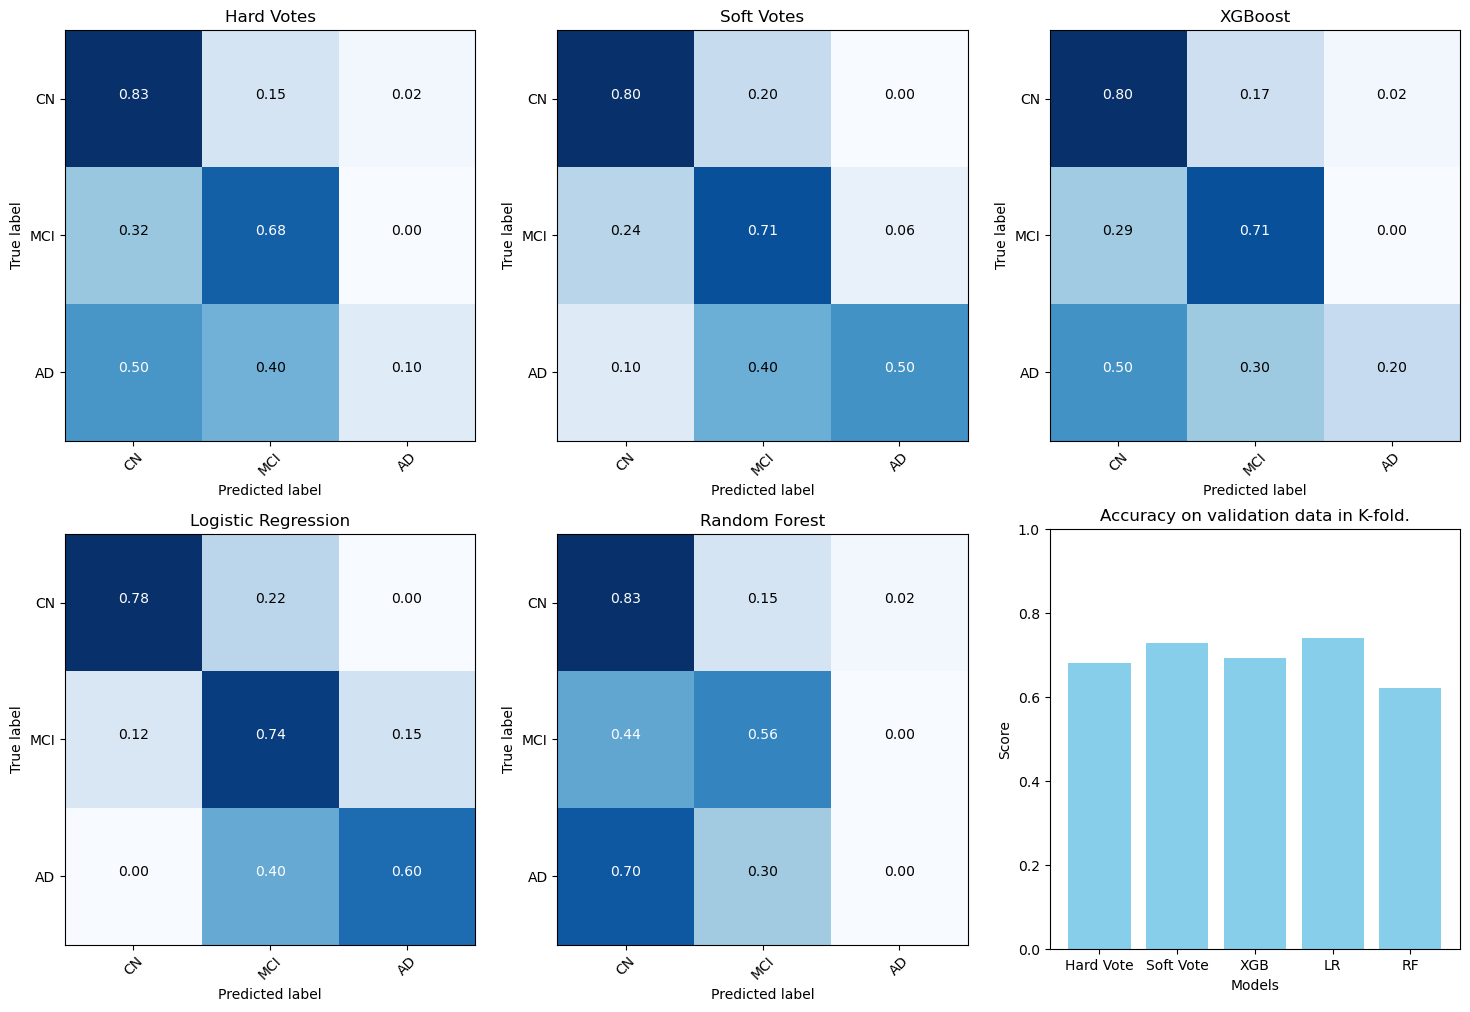

In [36]:
get_scores(all_models, votes, y_true, get_graphs=True)

#### 41

In [40]:
#Max perturbation
all_models, votes, y_true = pipeline(df_union, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 14.236644744873047 seconds.

LR 0 started.
LR 0 is done in 11.869462966918945 seconds.

RF 0 started.
RF 0 is done in 26.61786675453186 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 0.8395061728395061

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 11.82692289352417 seconds.

LR 1 started.
LR 1 is done in 12.007941246032715 seconds.

RF 1 started.
RF 1 is done in 30.59440803527832 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 1.0

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 11.269711017608643 seconds.

LR 2 started.
LR 2 is done in 10.849162817001343 seconds.

RF 2 started.
RF 2 is done in 30.821236848831177 seconds.

Hard vote F1 score: 0.7629629629629631
Soft vote F1 score: 0.7629629629629631

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 10.704711675643921 seconds.

LR 3 started.
LR 3 

XGB       	AUC OVR: 0.906801787816557   	AUC OVO: 0.9052247728359637  	ACC: 0.7294117647058823  	F1: 0.7267040149393091
LR        	AUC OVR: 0.8856068525579878  	AUC OVO: 0.8795911047345767  	ACC: 0.7764705882352941  	F1: 0.7793481028775148
RF        	AUC OVR: 0.8209296910364512  	AUC OVO: 0.8363582018173124  	ACC: 0.6941176470588235  	F1: 0.6908510477306875
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7764705882352941  	F1: 0.7770010419626788
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7411764705882353  	F1: 0.7406290662718176


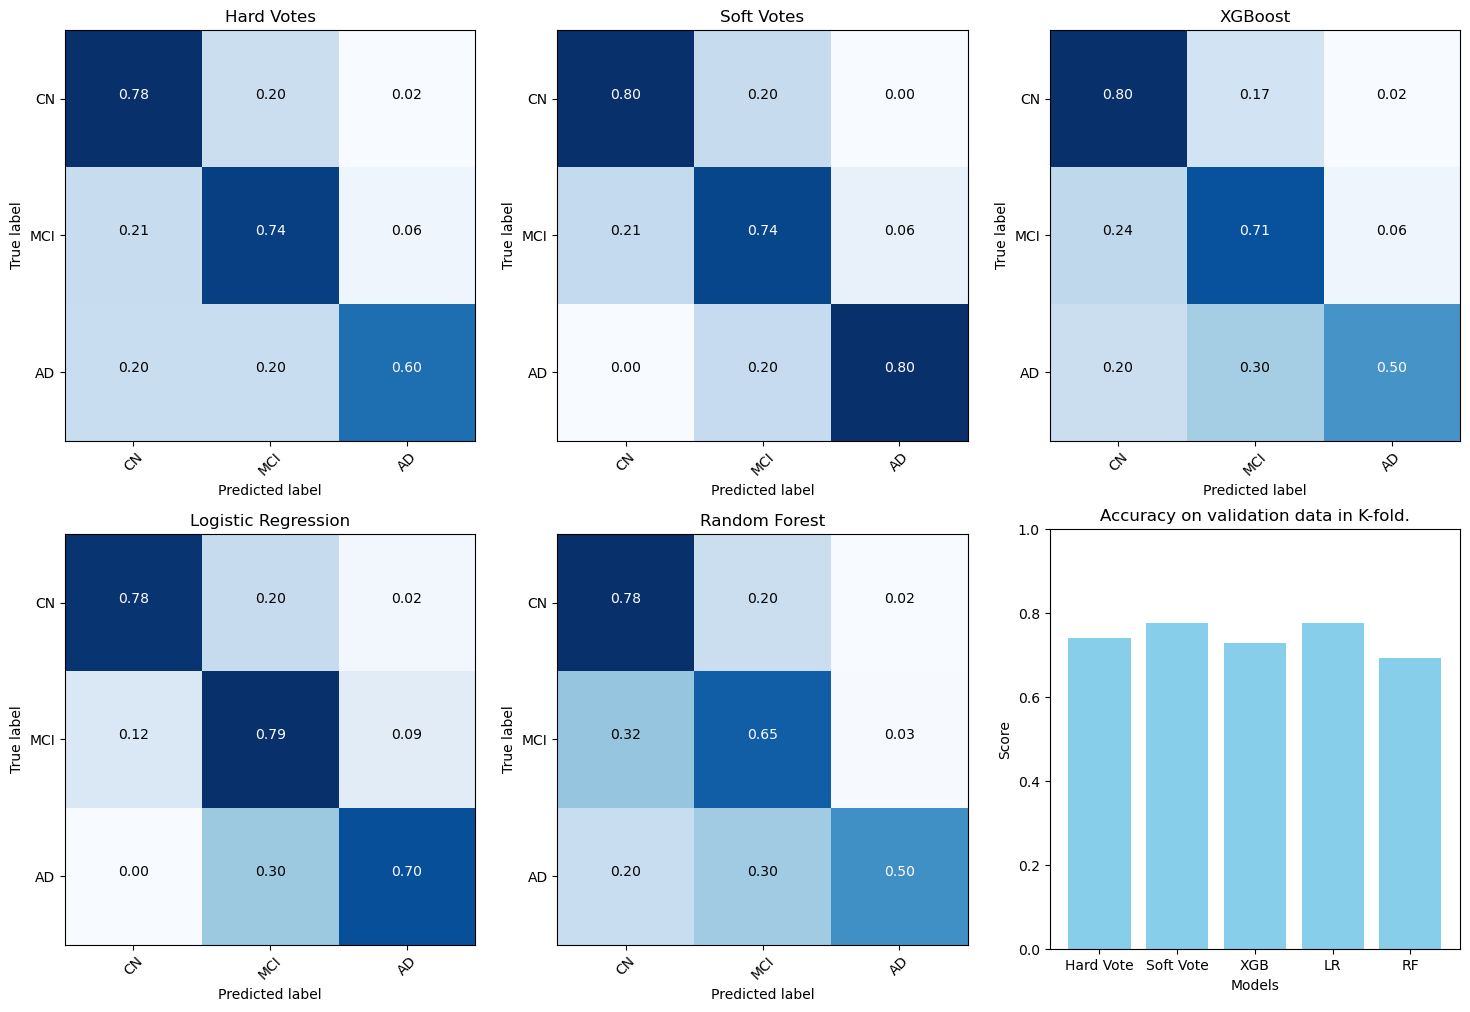

In [41]:
get_scores(all_models, votes, y_true, get_graphs=True)

#### 200

In [44]:
#200 perturbation
all_models, votes, y_true = pipeline(df_union, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 44.125332832336426 seconds.

LR 0 started.
LR 0 is done in 69.03718209266663 seconds.

RF 0 started.
RF 0 is done in 55.30402874946594 seconds.

Hard vote F1 score: 0.5502645502645503
Soft vote F1 score: 0.6613756613756614

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 42.50082612037659 seconds.

LR 1 started.
LR 1 is done in 61.76558589935303 seconds.

RF 1 started.
RF 1 is done in 56.165987968444824 seconds.

Hard vote F1 score: 0.6296296296296295
Soft vote F1 score: 0.8871252204585538

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 40.93741488456726 seconds.

LR 2 started.
LR 2 is done in 62.23997974395752 seconds.

RF 2 started.
RF 2 is done in 50.98628282546997 seconds.

Hard vote F1 score: 0.8395061728395061
Soft vote F1 score: 0.8395061728395061

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 41.5869

XGB       	AUC OVR: 0.851162244437795   	AUC OVO: 0.8558584409373505  	ACC: 0.7176470588235294  	F1: 0.7196979791250278
LR        	AUC OVR: 0.8860041771414883  	AUC OVO: 0.8849713055954088  	ACC: 0.7529411764705882  	F1: 0.7549125979505726
RF        	AUC OVR: 0.8026670860857713  	AUC OVO: 0.8266618842659015  	ACC: 0.6                 	F1: 0.5964244521337948
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7529411764705882  	F1: 0.7531834701844125
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7176470588235294  	F1: 0.7169891921910377


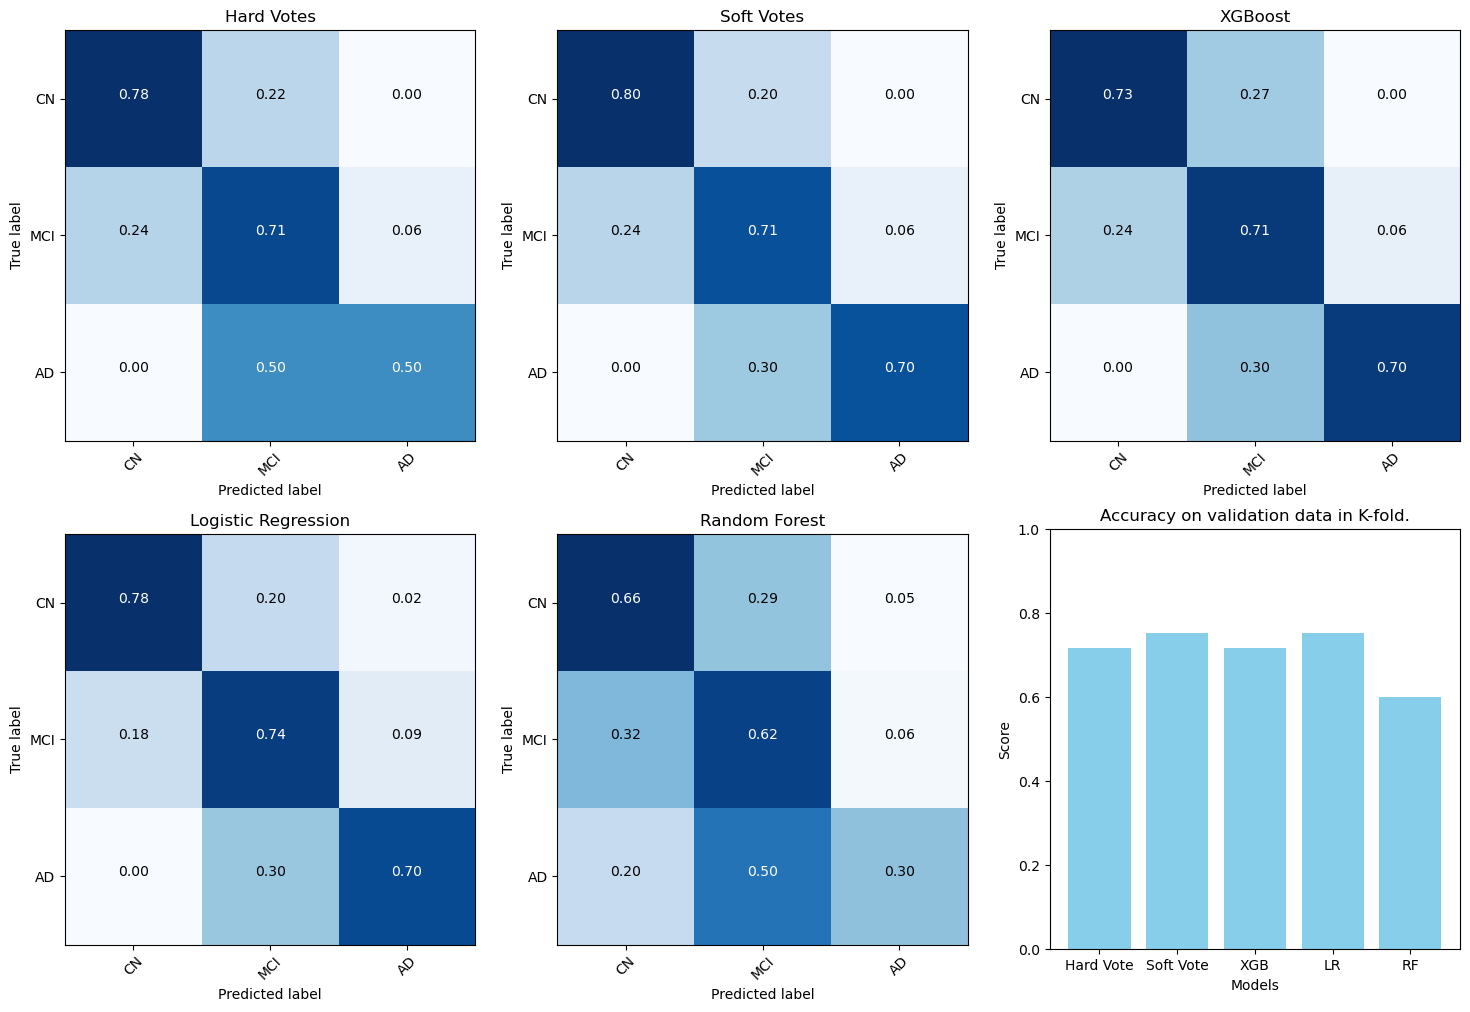

In [45]:
get_scores(all_models, votes, y_true, get_graphs=True)

#### 500

In [48]:
#500 perturbation
all_models, votes, y_true = pipeline(df_union, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 48.98895287513733 seconds.

LR 0 started.
LR 0 is done in 112.3531641960144 seconds.

RF 0 started.
RF 0 is done in 97.53566837310791 seconds.

Hard vote F1 score: 0.8871252204585538
Soft vote F1 score: 1.0

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 46.491729974746704 seconds.

LR 1 started.
LR 1 is done in 104.08097958564758 seconds.

RF 1 started.
RF 1 is done in 95.89428162574768 seconds.

Hard vote F1 score: 0.5259259259259259
Soft vote F1 score: 0.7777777777777778

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 46.861114501953125 seconds.

LR 2 started.
LR 2 is done in 111.96066403388977 seconds.

RF 2 started.
RF 2 is done in 98.27710199356079 seconds.

Hard vote F1 score: 0.7654320987654322
Soft vote F1 score: 0.7654320987654322

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 43.73781895637512 se

XGB       	AUC OVR: 0.84277114464759    	AUC OVO: 0.833094213295074   	ACC: 0.6941176470588235  	F1: 0.6835266361347371
LR        	AUC OVR: 0.9084853480368714  	AUC OVO: 0.9020205643232903  	ACC: 0.7529411764705882  	F1: 0.7506535947712418
RF        	AUC OVR: 0.7645340228174221  	AUC OVO: 0.7820062171209948  	ACC: 0.5764705882352941  	F1: 0.560294607353431
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7529411764705882  	F1: 0.745665713855875
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.6823529411764706  	F1: 0.6714869281045751


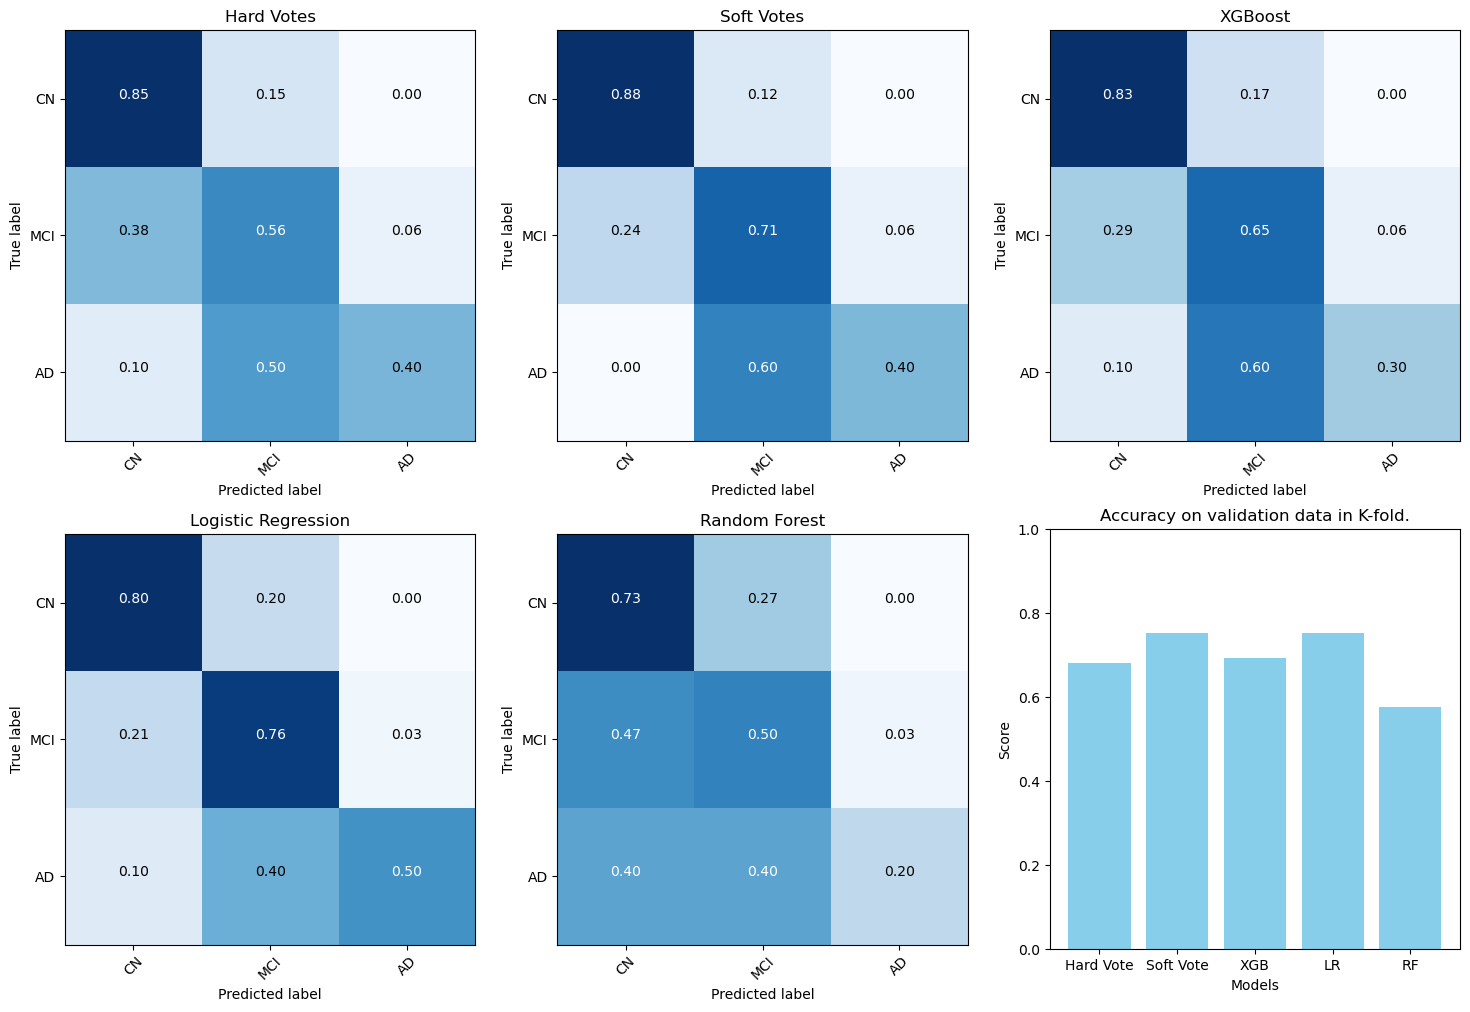

In [49]:
get_scores(all_models, votes, y_true, get_graphs=True)

### SMOTE Max --> 500

#### 41

In [52]:
#41 perturbation
all_models, votes, y_true = pipeline(df_union, y, params_grid, tmt_set, bayes=False, do_smote=True)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 14.801527261734009 seconds.

LR 0 started.
LR 0 is done in 10.432367324829102 seconds.

RF 0 started.
RF 0 is done in 21.63627552986145 seconds.

Hard vote F1 score: 0.8994708994708994
Soft vote F1 score: 0.8994708994708994

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 8.034730434417725 seconds.

LR 1 started.
LR 1 is done in 11.973592758178711 seconds.

RF 1 started.
RF 1 is done in 22.222459316253662 seconds.

Hard vote F1 score: 0.8871252204585538
Soft vote F1 score: 1.0

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 7.9265055656433105 seconds.

LR 2 started.
LR 2 is done in 13.91821813583374 seconds.

RF 2 started.
RF 2 is done in 22.903701305389404 seconds.

Hard vote F1 score: 0.8871252204585538
Soft vote F1 score: 0.7777777777777778

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 8.458820819854736 

XGB       	AUC OVR: 0.8422472322175251  	AUC OVO: 0.8387135341941653  	ACC: 0.7058823529411765  	F1: 0.7027077497665734
LR        	AUC OVR: 0.8667845149102638  	AUC OVO: 0.867180774748924   	ACC: 0.7294117647058823  	F1: 0.7300890505455914
RF        	AUC OVR: 0.8232209341281838  	AUC OVO: 0.8469631755141082  	ACC: 0.6705882352941176  	F1: 0.6615864527629234
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7411764705882353  	F1: 0.740214107202805
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7176470588235294  	F1: 0.7139122315592905


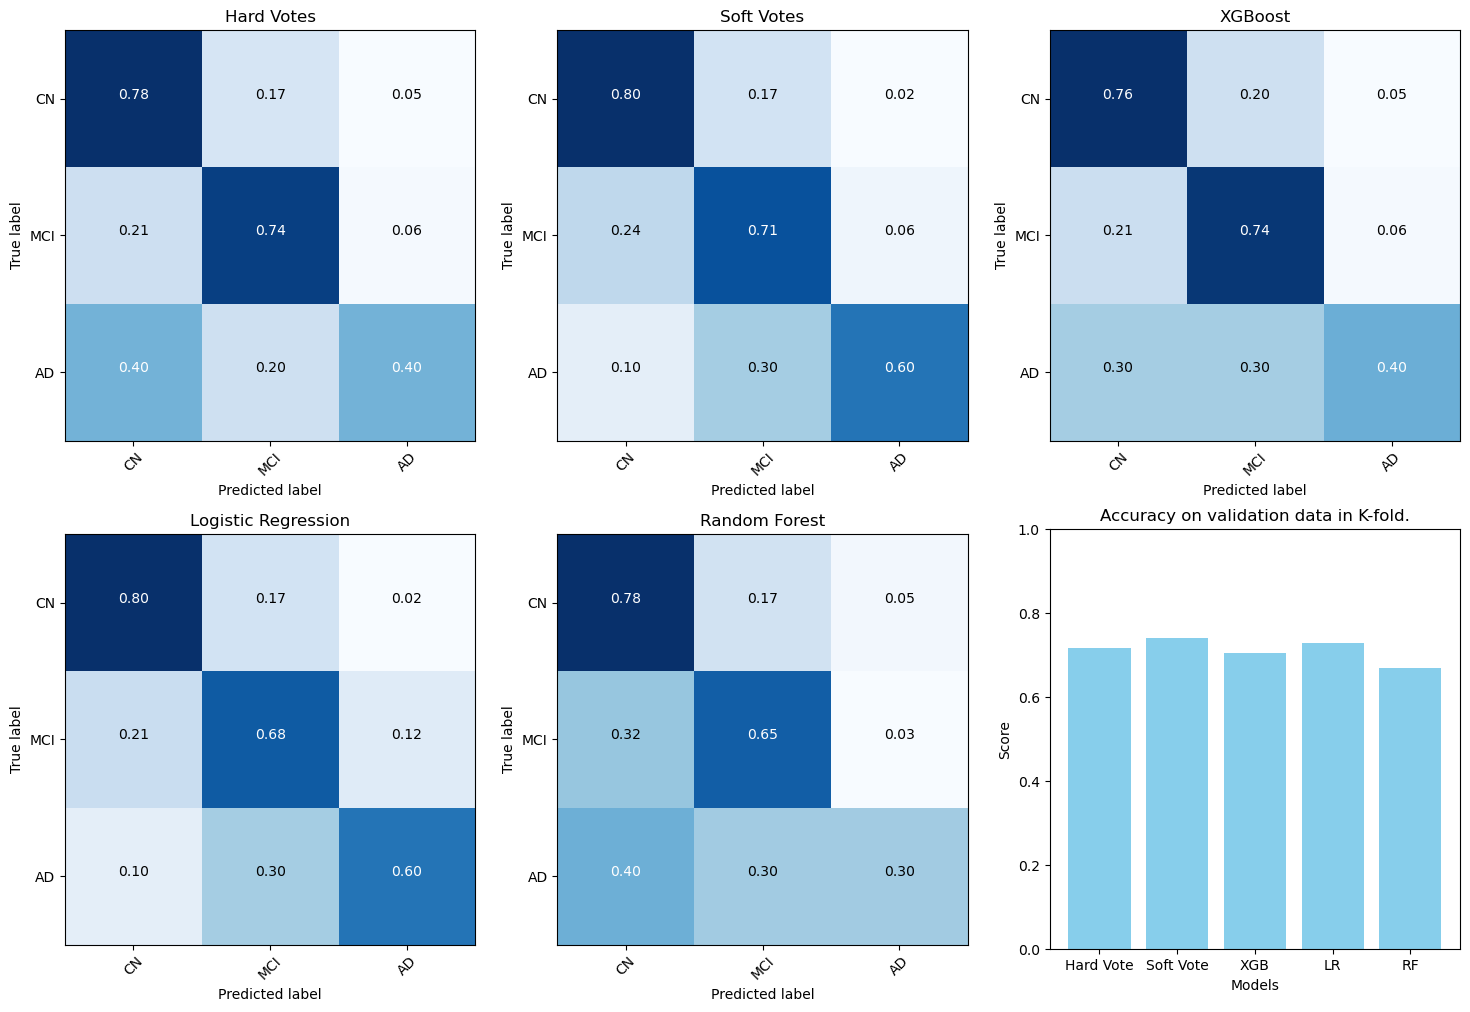

In [53]:
get_scores(all_models, votes, y_true, get_graphs=True)

#### 200

In [57]:
#200 perturbation
all_models, votes, y_true = pipeline(df_union, y, params_grid, tmt_set, bayes=False, do_smote=True)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 32.31700682640076 seconds.

LR 0 started.
LR 0 is done in 41.475226402282715 seconds.

RF 0 started.
RF 0 is done in 39.64763951301575 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 1.0

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 23.020097494125366 seconds.

LR 1 started.
LR 1 is done in 37.045512199401855 seconds.

RF 1 started.
RF 1 is done in 39.643468141555786 seconds.

Hard vote F1 score: 0.6666666666666665
Soft vote F1 score: 0.5185185185185186

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 24.113840341567993 seconds.

LR 2 started.
LR 2 is done in 36.50064039230347 seconds.

RF 2 started.
RF 2 is done in 38.93276262283325 seconds.

Hard vote F1 score: 0.5185185185185185
Soft vote F1 score: 0.7629629629629631

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 23.808863162994385 seconds.

LR 3 

XGB       	AUC OVR: 0.8368692801932737  	AUC OVO: 0.8253706360593017  	ACC: 0.6705882352941176  	F1: 0.66560553633218
LR        	AUC OVR: 0.8848585372673482  	AUC OVO: 0.8794715447154472  	ACC: 0.7411764705882353  	F1: 0.7437725691595661
RF        	AUC OVR: 0.83132814089072    	AUC OVO: 0.8402857484457197  	ACC: 0.6705882352941176  	F1: 0.6526111523828819
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7529411764705882  	F1: 0.7541298190856021
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.6941176470588235  	F1: 0.688428865152199


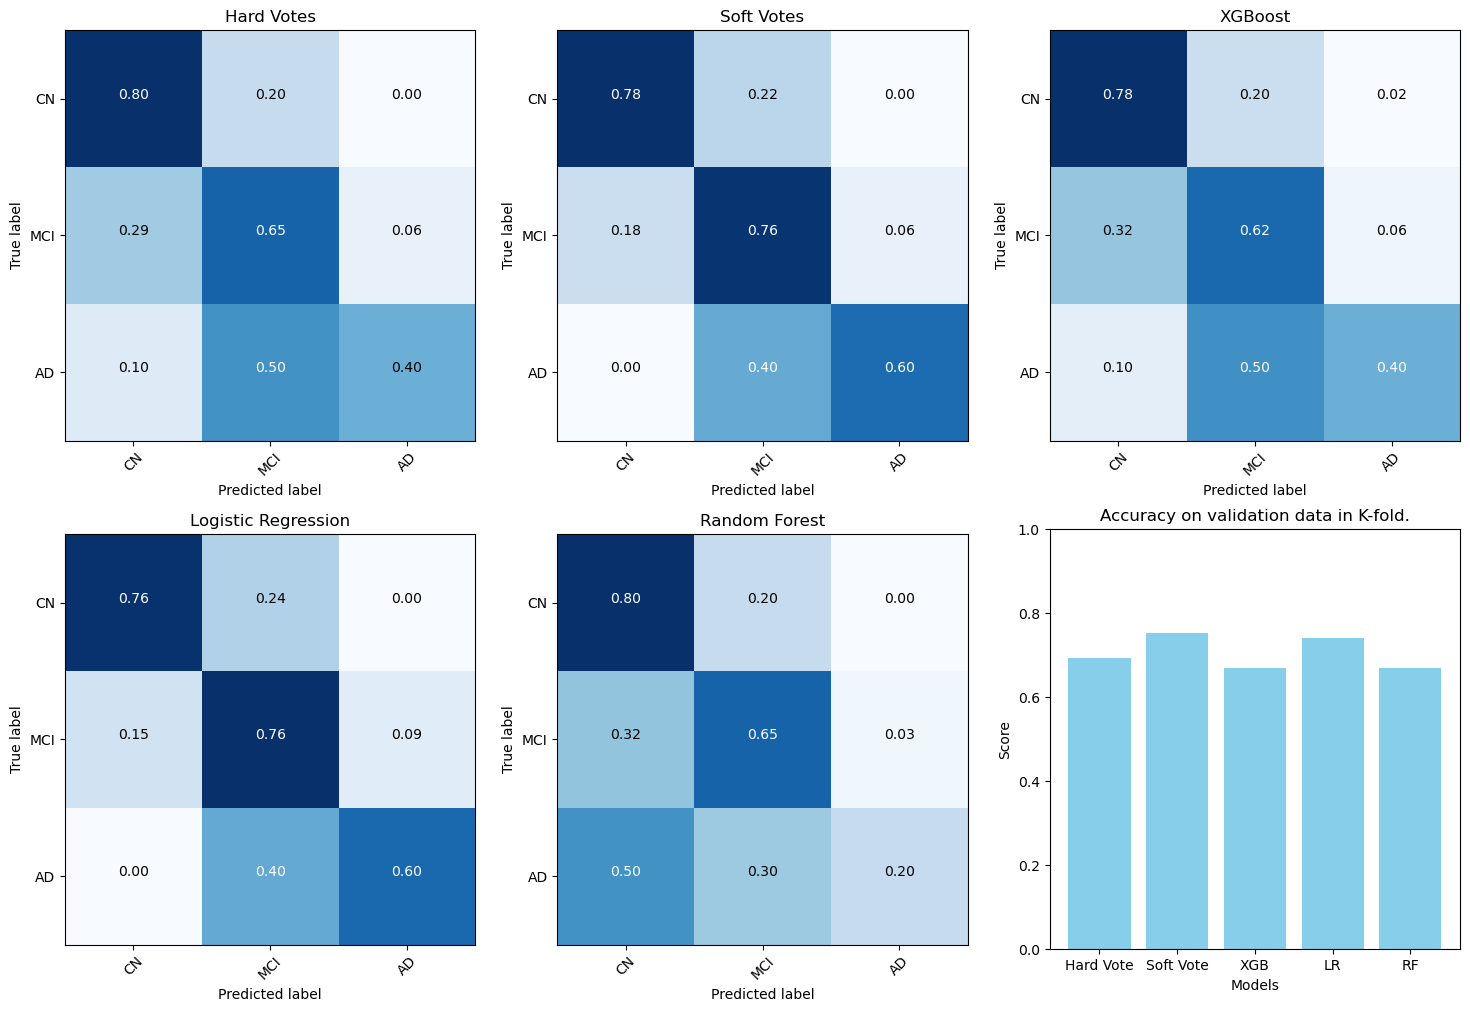

In [58]:
get_scores(all_models, votes, y_true, get_graphs=True)

#### 500

In [60]:
#500 perturbation
all_models, votes, y_true = pipeline(df_union, y, params_grid, tmt_set, bayes=False, do_smote=True)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 32.24126434326172 seconds.

LR 0 started.
LR 0 is done in 90.34354543685913 seconds.

RF 0 started.
RF 0 is done in 86.0619523525238 seconds.

Hard vote F1 score: 0.5185185185185185
Soft vote F1 score: 0.5185185185185185

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 37.1333270072937 seconds.

LR 1 started.
LR 1 is done in 122.84569787979126 seconds.

RF 1 started.
RF 1 is done in 91.06074547767639 seconds.

Hard vote F1 score: 0.8994708994708994
Soft vote F1 score: 0.8871252204585538

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 40.36276197433472 seconds.

LR 2 started.
LR 2 is done in 131.61805963516235 seconds.

RF 2 started.
RF 2 is done in 91.21797704696655 seconds.

Hard vote F1 score: 0.41975308641975306
Soft vote F1 score: 0.6613756613756614

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 41.36372

XGB       	AUC OVR: 0.8461894529734852  	AUC OVO: 0.8338713534194165  	ACC: 0.6823529411764706  	F1: 0.6778171509567683
LR        	AUC OVR: 0.86245165470214    	AUC OVO: 0.8659134385461501  	ACC: 0.7294117647058823  	F1: 0.7307563025210084
RF        	AUC OVR: 0.8381780076058073  	AUC OVO: 0.8471783835485414  	ACC: 0.6470588235294118  	F1: 0.6376254281079132
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7411764705882353  	F1: 0.7400779404093406
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7294117647058823  	F1: 0.7246353679671726


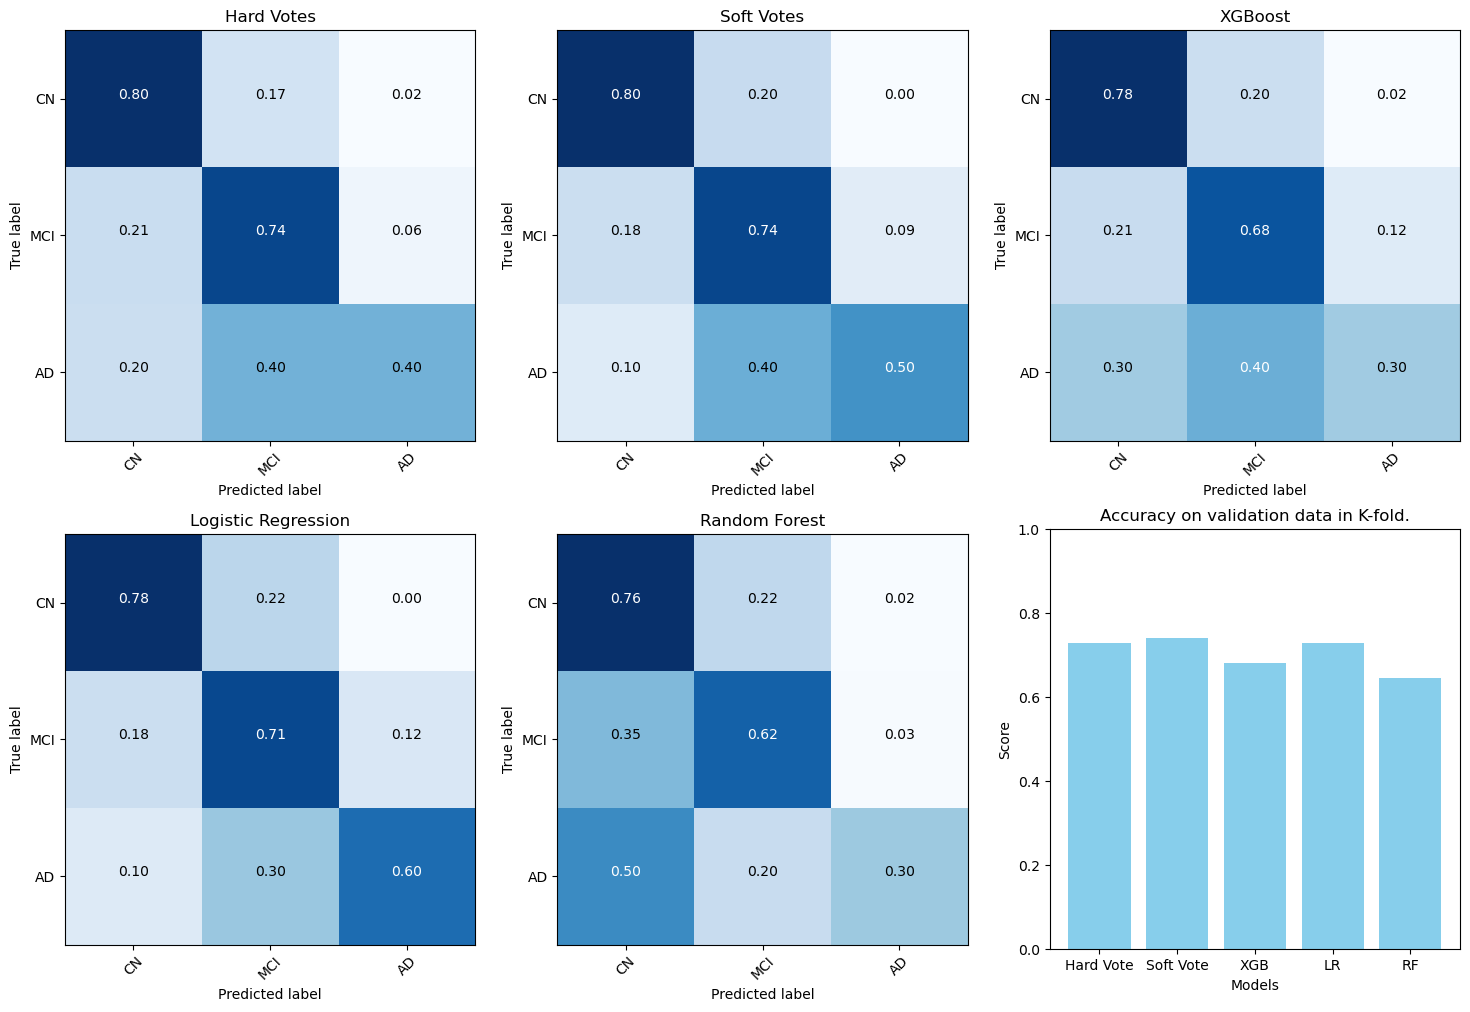

In [61]:
get_scores(all_models, votes, y_true, get_graphs=True)

# Union Size

In [30]:
df_pre = get_union_features_p1(1, 100, df_main)

In [31]:
df_pre

P08253..45.62.  Q13822..729.752.  P00450..485.500.  Q9NY33..679.698.  \
0         -0.336333          0.807954         -0.297133         -6.313415   
1          0.139673          1.742261          0.394160         -5.306121   
2         -0.200000          0.349246         -0.061128         -1.134756   
3         -0.521307          0.460041         -0.132840         -1.515960   
4         -0.125504         -0.127993         -0.451057         -1.747685   
..              ...               ...               ...               ...   
96        -0.380483          0.370960         -0.348097         -4.042478   
97        -0.319798          0.065519         -0.141056         -0.607292   
98        -0.503310         -0.023050         -0.268220         -4.925714   
99        -0.216406          0.373570         -0.122399         -4.192400   
100       -0.021323          0.260026         -0.237347         -0.333332   

     Q9UHI8..147.167.  P02741..207.224.  P29401..335.343.  I3L3R5..80.87.  \
0           -0.705950         -2.270763         -0.009877       -0.324974   
1           -0.705950         -2.270763         -0.009877       -0.926638   
2           -0.705950         -2.270763         -0.009877       -0.052370   
3           -0.705950         -2.270763         -0.009877       -0.647177   
4           -0.705950         -2.270763         -0.009877        0.036692   
..                ...               ...               ...             ...   
96          -1.568687         -2.076880          0.051732       -1.082477   
97          -0.386851         -2.333361          0.423561       -0.313230   
98          -0.086510         -2.407166          0.167077       -0.216992   
99          -0.825004         -2.047233          0.202523       -0.301548   
100         -0.540759         -1.955226         -0.345628       -0.158021   

     P07360..62.69.  Q8WY91..35.40.  ...  \
0         -0.438179       -0.508938  ...   
1         -0.413234       -1.771731  ...   
2          0.281511       -1.568632  ...   
3          0.261600       -0.033861  ...   
4         -0.623447       -1.834865  ...   
..              ...             ...  ...   
96        -0.365101       -0.838438  ...   
97         0.032327       -2.464774  ...   
98        -0.230188       -0.660751  ...   
99        -0.382596       -2.464774  ...   
100       -0.427422       -1.906951  ...   

     P02533..408.416...P08727..373.381...P19012..399.407...Q04695..377.385...P08779..410.418.  \
0                                            -1.688689                                          
1                                            -0.003996                                          
2                                            -0.750244                                          
3                                            -1.130671                                          
4                                            -0.458839                                          
..                                                 ...                                          
96                                           -0.213267                                          
97                                           -0.213267                                          
98                                           -0.213267                                          
99                                           -0.213267                                          
100                                          -0.213267                                          

     Q16706..562.577.  P05413..83.91.  Q14520..295.303.  Q14315..902.911.  \
0           -0.092418        0.683688         -1.281247         -0.014094   
1           -0.490845       -0.290356         -1.360941          0.259521   
2           -0.079478       -0.317420         -0.752494          0.053895   
3           -0.461568        0.293001         -0.898900         -0.026776   
4            0.211341       -0.007532         -1.053737          0.241103   

## 2

In [32]:
df_union2 = get_union_features(1, 2, df_pre)

In [37]:
all_models, votes, y_true = pipeline(df_union2, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 2.7076525688171387 seconds.

LR 0 started.
LR 0 is done in 0.8793752193450928 seconds.

RF 0 started.
RF 0 is done in 3.162249803543091 seconds.

Hard vote F1 score: 0.686868686868687
Soft vote F1 score: 0.686868686868687

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 0.8360648155212402 seconds.

LR 1 started.
LR 1 is done in 0.8384153842926025 seconds.

RF 1 started.
RF 1 is done in 3.048640489578247 seconds.

Hard vote F1 score: 0.9028571428571428
Soft vote F1 score: 0.9028571428571428

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 0.8529872894287109 seconds.

LR 2 started.
LR 2 is done in 0.8364477157592773 seconds.

RF 2 started.
RF 2 is done in 3.0355775356292725 seconds.

Hard vote F1 score: 0.5194805194805194
Soft vote F1 score: 0.5194805194805194

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 0.84

XGB       	AUC OVR: 0.7918505194409017  	AUC OVO: 0.7903743030883664  	ACC: 0.6732673267326733  	F1: 0.677585639864251
LR        	AUC OVR: 0.7572235915948076  	AUC OVO: 0.7512607613801179  	ACC: 0.6138613861386139  	F1: 0.6236692319117495
RF        	AUC OVR: 0.7959452352442321  	AUC OVO: 0.8034709193245778  	ACC: 0.6831683168316832  	F1: 0.6878728245495358
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.6732673267326733  	F1: 0.676842105263158
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.6831683168316832  	F1: 0.6878582595101614


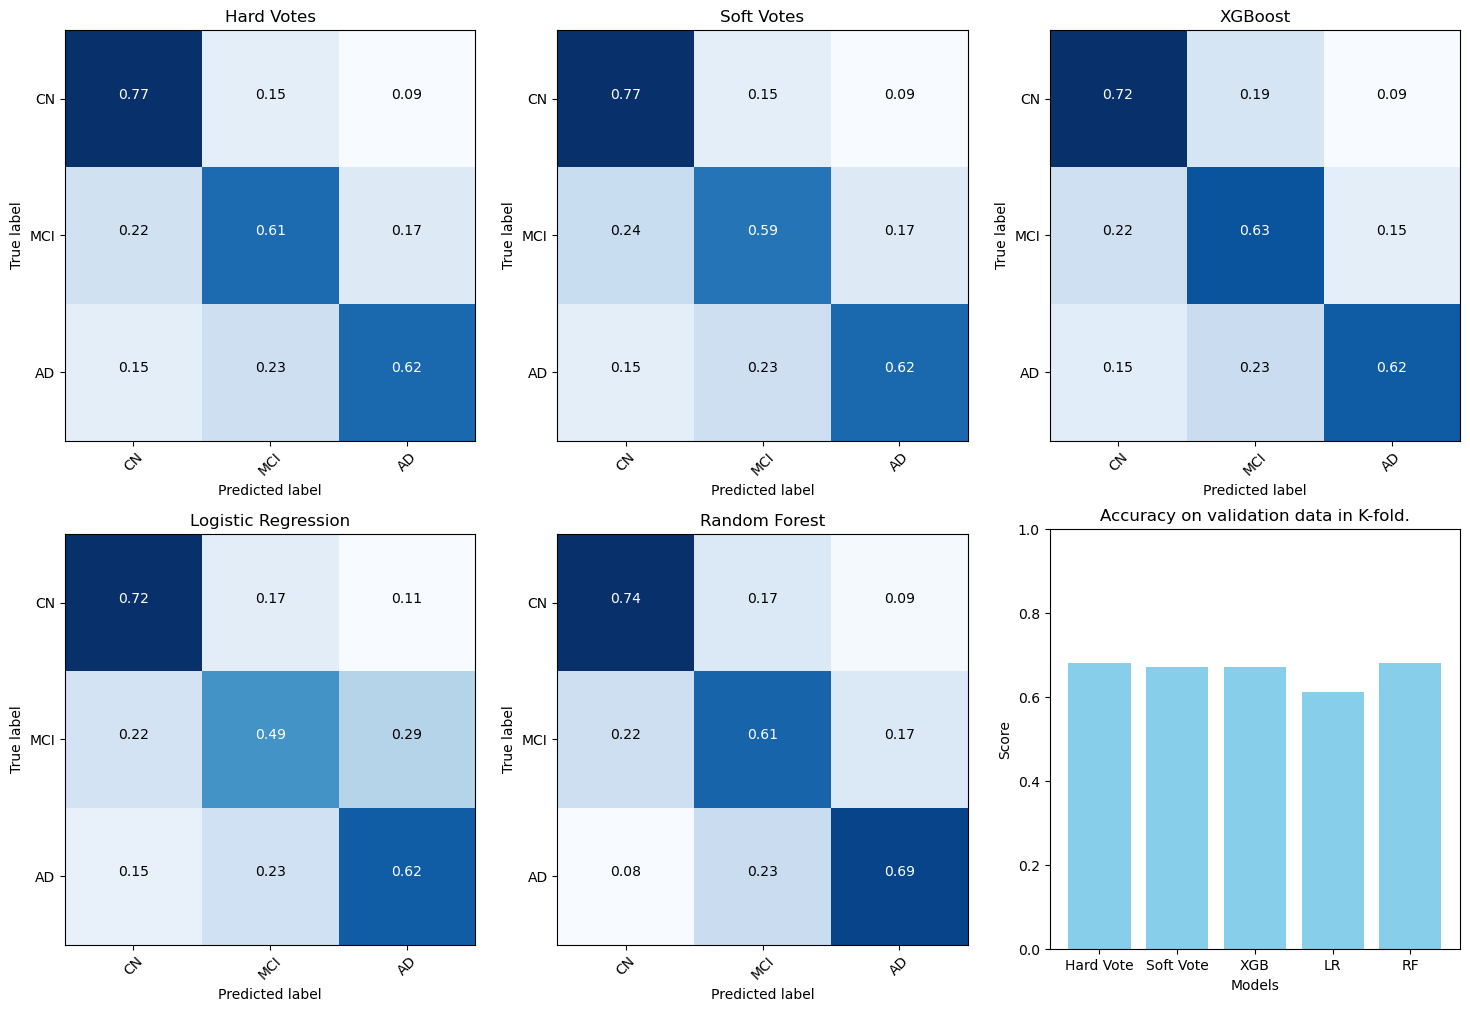

In [38]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 4

In [39]:
df_union4 = get_union_features(1, 4, df_pre)

In [40]:
all_models, votes, y_true = pipeline(df_union4, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 0.9865357875823975 seconds.

LR 0 started.
LR 0 is done in 0.9960355758666992 seconds.

RF 0 started.
RF 0 is done in 3.203275203704834 seconds.

Hard vote F1 score: 0.8136363636363636
Soft vote F1 score: 0.706021251475797

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.000105381011963 seconds.

LR 1 started.
LR 1 is done in 1.106004238128662 seconds.

RF 1 started.
RF 1 is done in 3.0507421493530273 seconds.

Hard vote F1 score: 0.62
Soft vote F1 score: 0.62

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 0.9737036228179932 seconds.

LR 2 started.
LR 2 is done in 1.31500244140625 seconds.

RF 2 started.
RF 2 is done in 3.146319627761841 seconds.

Hard vote F1 score: 0.32
Soft vote F1 score: 0.33333333333333326

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1.0252881050109863 seconds.

LR 3 started.
LR 3 

XGB       	AUC OVR: 0.8261530260535622  	AUC OVO: 0.8127686186845503  	ACC: 0.6732673267326733  	F1: 0.6696456296521893
LR        	AUC OVR: 0.7448727883557499  	AUC OVO: 0.7289063643500592  	ACC: 0.6633663366336634  	F1: 0.6772121297456184
RF        	AUC OVR: 0.8390047742560284  	AUC OVO: 0.8357916516972045  	ACC: 0.693069306930693   	F1: 0.6883444673581283
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.6831683168316832  	F1: 0.685685851610315
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.6831683168316832  	F1: 0.6822086217060525


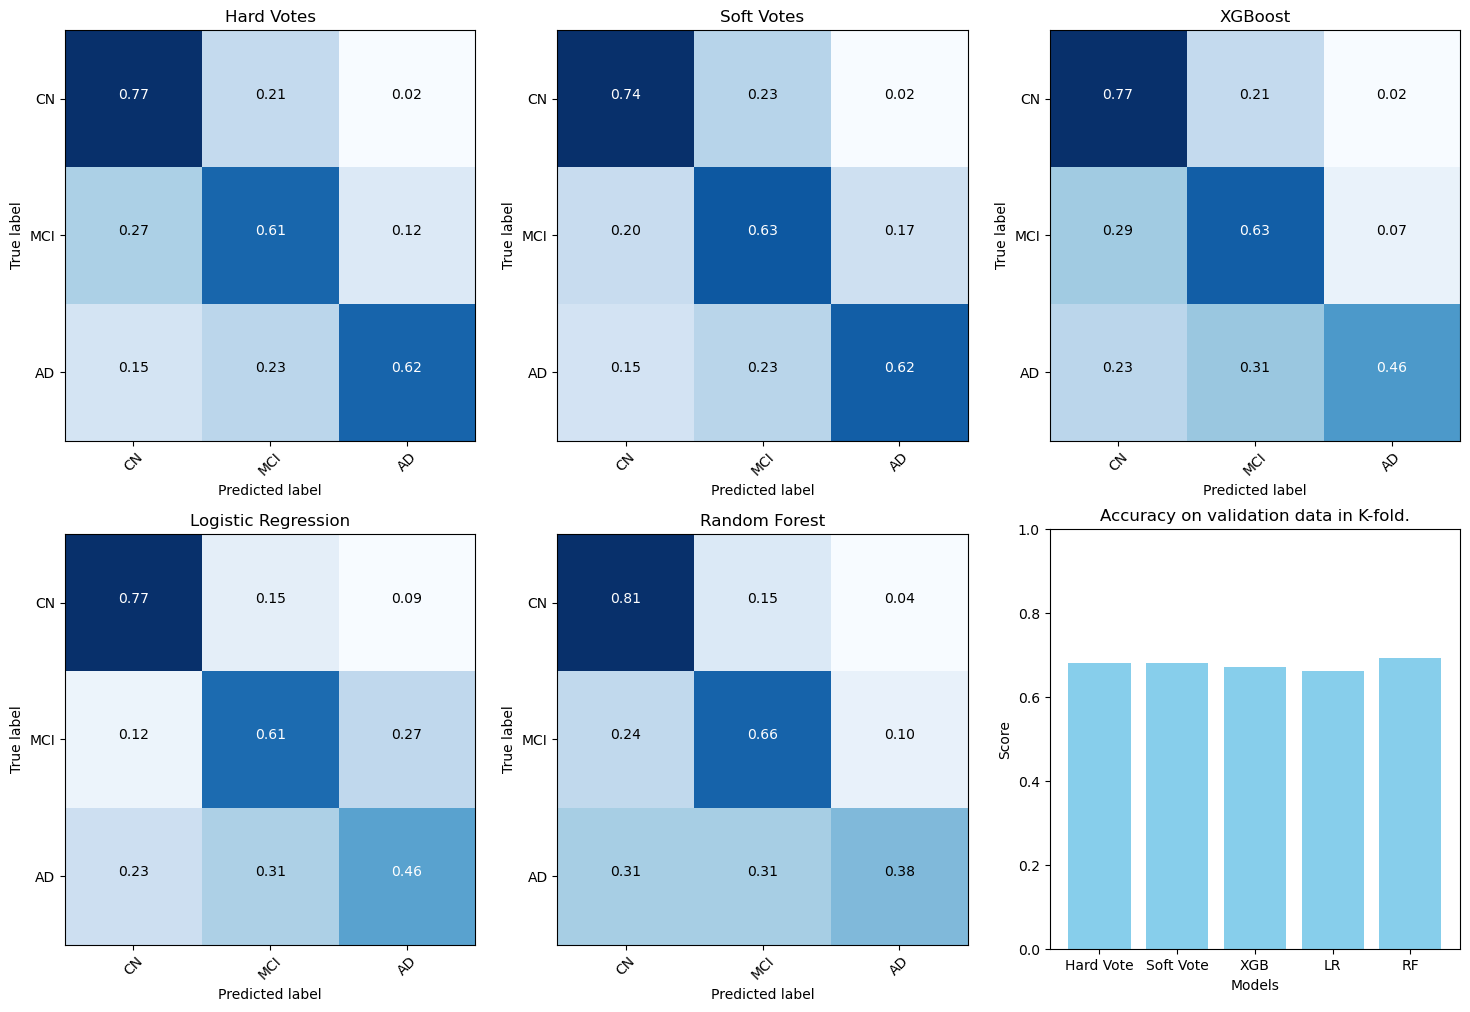

In [41]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 5

In [42]:
df_union5 = get_union_features(1, 5, df_pre)

In [43]:
all_models, votes, y_true = pipeline(df_union5, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 1.0809545516967773 seconds.

LR 0 started.
LR 0 is done in 1.633476734161377 seconds.

RF 0 started.
RF 0 is done in 3.234160900115967 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 1.0

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.177757978439331 seconds.

LR 1 started.
LR 1 is done in 2.245454788208008 seconds.

RF 1 started.
RF 1 is done in 3.030928134918213 seconds.

Hard vote F1 score: 0.5063492063492064
Soft vote F1 score: 0.5063492063492064

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.1766672134399414 seconds.

LR 2 started.
LR 2 is done in 1.5738835334777832 seconds.

RF 2 started.
RF 2 is done in 3.263671398162842 seconds.

Hard vote F1 score: 0.7111111111111111
Soft vote F1 score: 0.7111111111111111

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1.1356592178344727 seconds.

LR 3 st

XGB       	AUC OVR: 0.853901926713724   	AUC OVO: 0.8464000106449511  	ACC: 0.7326732673267327  	F1: 0.7323071542941805
LR        	AUC OVR: 0.7968065415911809  	AUC OVO: 0.7918645962237036  	ACC: 0.6732673267326733  	F1: 0.6755046311082721
RF        	AUC OVR: 0.8573894552531467  	AUC OVO: 0.8627499900203585  	ACC: 0.693069306930693   	F1: 0.692036337654384
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7425742574257426  	F1: 0.7399166232412715
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7227722772277227  	F1: 0.7228439972779824


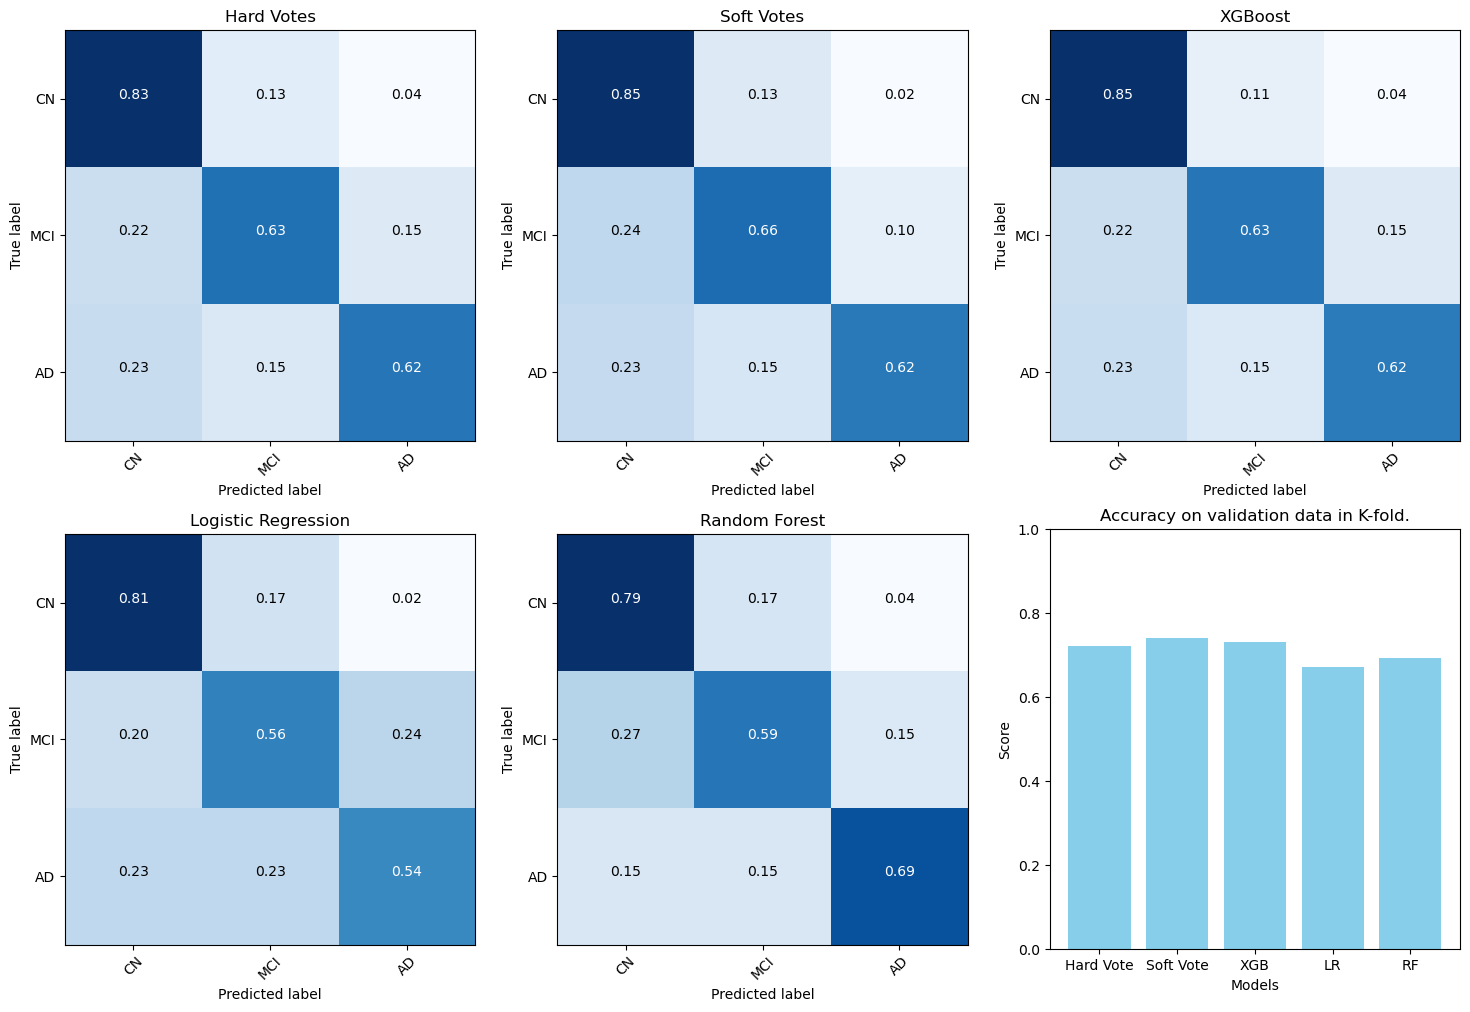

In [44]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 8

In [45]:
df_union8 = get_union_features(1, 8, df_pre)

In [46]:
all_models, votes, y_true = pipeline(df_union8, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 1.3131537437438965 seconds.

LR 0 started.
LR 0 is done in 1.8872010707855225 seconds.

RF 0 started.
RF 0 is done in 3.3468432426452637 seconds.

Hard vote F1 score: 0.8116883116883117
Soft vote F1 score: 0.586013986013986

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.264646291732788 seconds.

LR 1 started.
LR 1 is done in 2.0445728302001953 seconds.

RF 1 started.
RF 1 is done in 3.1489760875701904 seconds.

Hard vote F1 score: 0.5085714285714287
Soft vote F1 score: 0.5085714285714287

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.268643856048584 seconds.

LR 2 started.
LR 2 is done in 1.919259786605835 seconds.

RF 2 started.
RF 2 is done in 3.3050708770751953 seconds.

Hard vote F1 score: 0.7822222222222223
Soft vote F1 score: 0.9028571428571428

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1.26

XGB       	AUC OVR: 0.8855073304779237  	AUC OVO: 0.883943422085612   	ACC: 0.7227722772277227  	F1: 0.7273118758051955
LR        	AUC OVR: 0.8879813664971943  	AUC OVO: 0.8926124040291139  	ACC: 0.7524752475247525  	F1: 0.7531591974986973
RF        	AUC OVR: 0.8661693657844842  	AUC OVO: 0.8772803480898966  	ACC: 0.7227722772277227  	F1: 0.7233834494560568
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7326732673267327  	F1: 0.7404525262652848
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7524752475247525  	F1: 0.7561339528336228


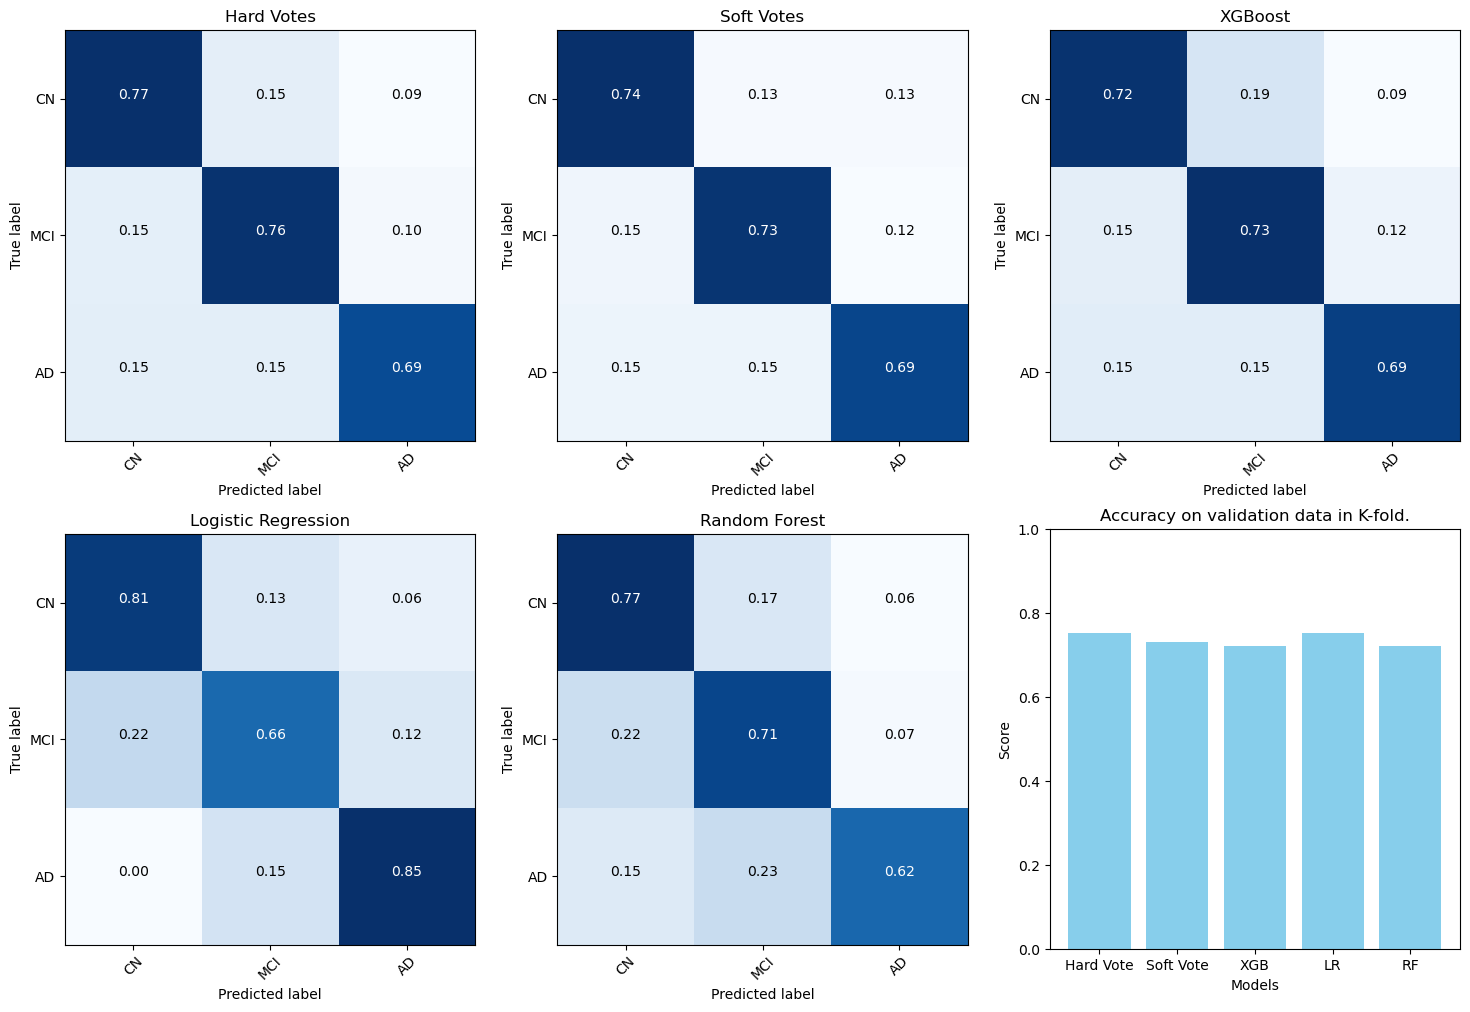

In [47]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 10

In [48]:
df_union10 = get_union_features(1, 10, df_pre)

In [49]:
all_models, votes, y_true = pipeline(df_union10, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 1.4836554527282715 seconds.

LR 0 started.
LR 0 is done in 1.9058372974395752 seconds.

RF 0 started.
RF 0 is done in 3.3810644149780273 seconds.

Hard vote F1 score: 0.7272727272727271
Soft vote F1 score: 0.7272727272727271

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.440145492553711 seconds.

LR 1 started.
LR 1 is done in 2.109337329864502 seconds.

RF 1 started.
RF 1 is done in 3.314146041870117 seconds.

Hard vote F1 score: 0.888888888888889
Soft vote F1 score: 0.888888888888889

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.4126389026641846 seconds.

LR 2 started.
LR 2 is done in 2.0259437561035156 seconds.

RF 2 started.
RF 2 is done in 3.383180856704712 seconds.

Hard vote F1 score: 0.8984126984126984
Soft vote F1 score: 0.7822222222222223

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1.4261

XGB       	AUC OVR: 0.8687632359055989  	AUC OVO: 0.8652548800447087  	ACC: 0.7029702970297029  	F1: 0.7033563830537739
LR        	AUC OVR: 0.8862132349893983  	AUC OVO: 0.8771905313161152  	ACC: 0.7425742574257426  	F1: 0.7493804422980405
RF        	AUC OVR: 0.8433504931645391  	AUC OVO: 0.8555480153819541  	ACC: 0.7029702970297029  	F1: 0.7027625758356426
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7524752475247525  	F1: 0.7553341162081348
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7128712871287128  	F1: 0.7146314631463146


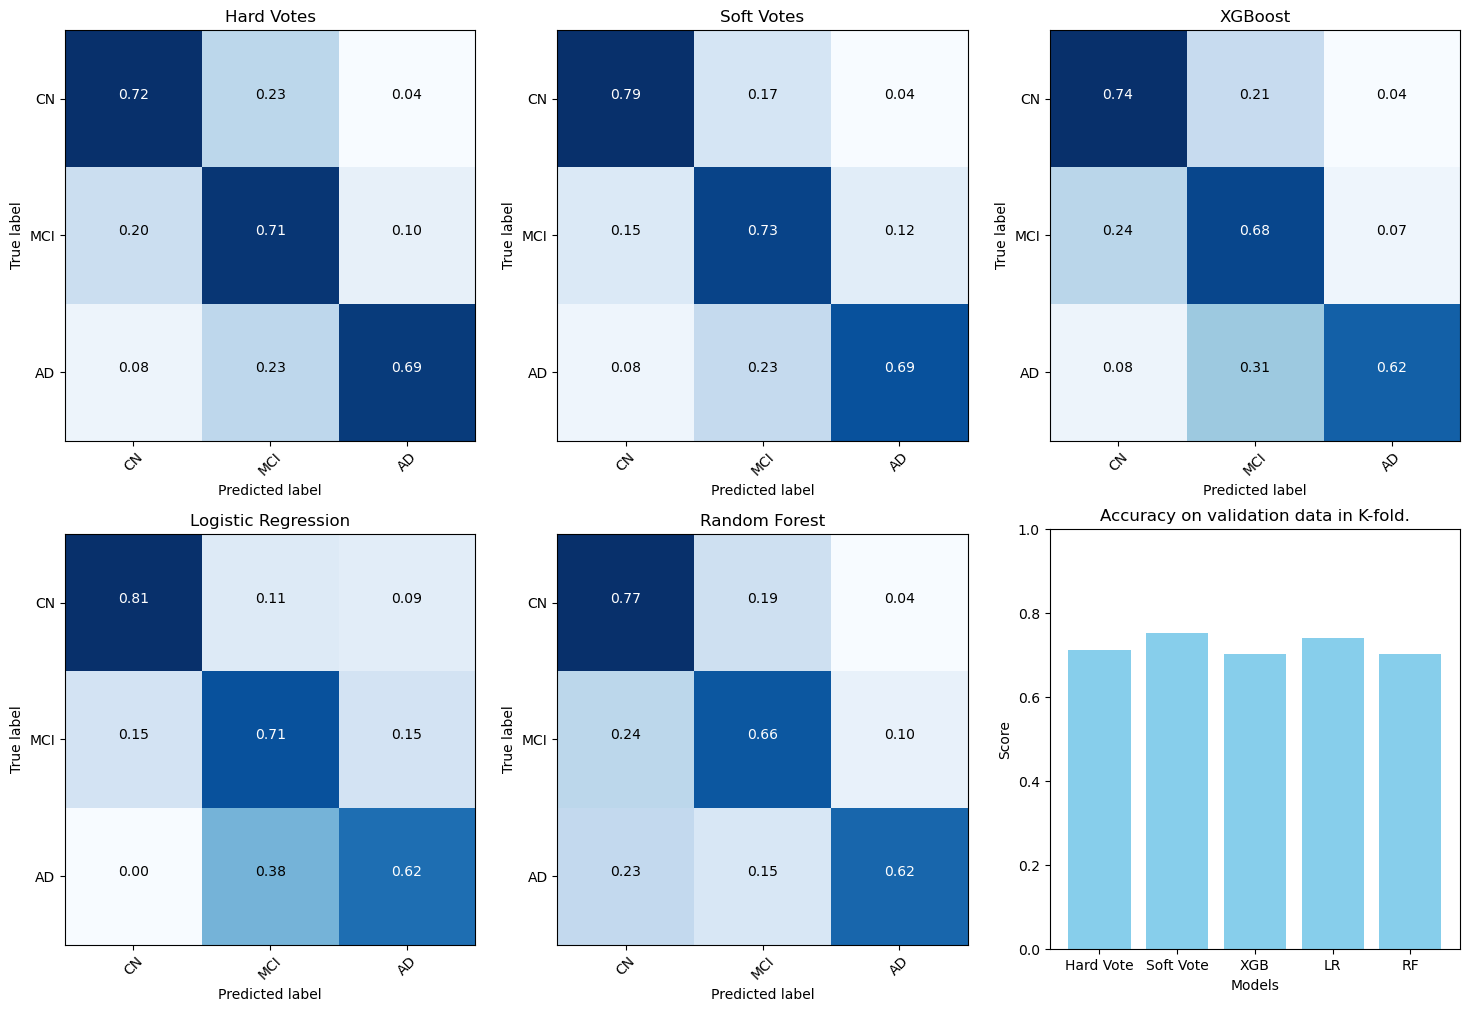

In [50]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 11

In [51]:
df_union11 = get_union_features(1, 11, df_pre)

In [52]:
all_models, votes, y_true = pipeline(df_union11, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 1.5266811847686768 seconds.

LR 0 started.
LR 0 is done in 2.329568386077881 seconds.

RF 0 started.
RF 0 is done in 3.2029647827148438 seconds.

Hard vote F1 score: 0.7168831168831169
Soft vote F1 score: 0.5555555555555555

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.4691479206085205 seconds.

LR 1 started.
LR 1 is done in 2.238412857055664 seconds.

RF 1 started.
RF 1 is done in 3.2675817012786865 seconds.

Hard vote F1 score: 0.9028571428571428
Soft vote F1 score: 0.9028571428571428

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.4629600048065186 seconds.

LR 2 started.
LR 2 is done in 2.3635594844818115 seconds.

RF 2 started.
RF 2 is done in 3.3410794734954834 seconds.

Hard vote F1 score: 0.6841269841269841
Soft vote F1 score: 0.6841269841269841

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1.

XGB       	AUC OVR: 0.8788964888731366  	AUC OVO: 0.8799981371335809  	ACC: 0.7227722772277227  	F1: 0.7272298658437272
LR        	AUC OVR: 0.8007682464696823  	AUC OVO: 0.7974199300094474  	ACC: 0.7128712871287128  	F1: 0.7147020549131374
RF        	AUC OVR: 0.860282175316339   	AUC OVO: 0.871944566417841   	ACC: 0.7722772277227723  	F1: 0.7735061325932371
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7227722772277227  	F1: 0.7254962721033217
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7623762376237624  	F1: 0.7641241053464268


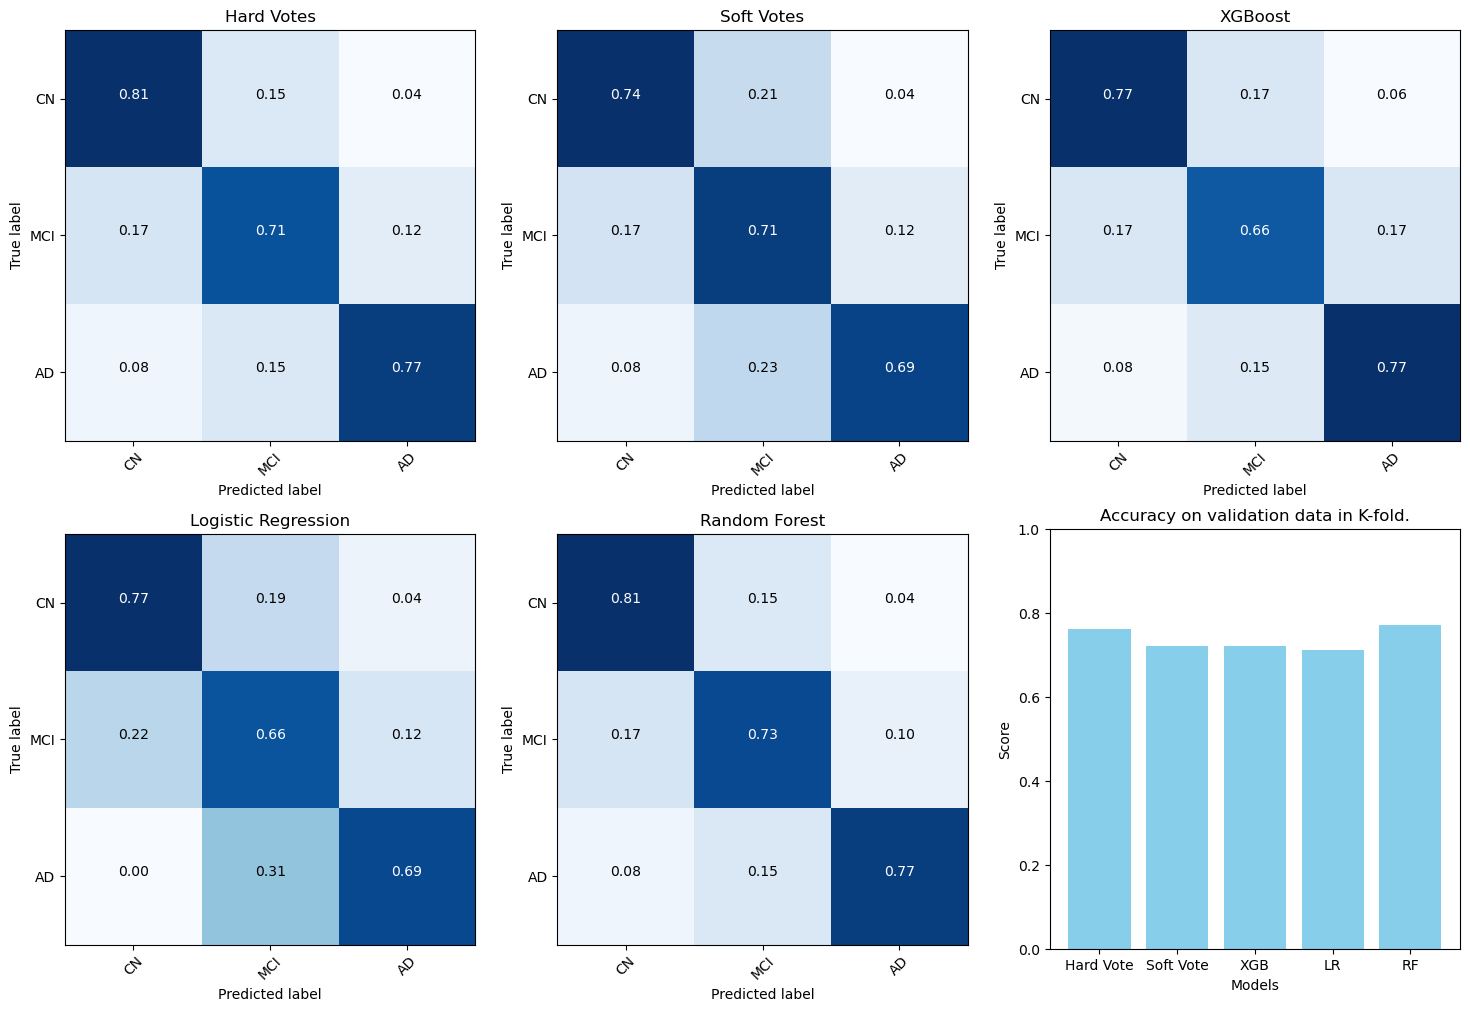

In [53]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 12

In [54]:
df_union12 = get_union_features(1, 12, df_pre)

In [55]:
all_models, votes, y_true = pipeline(df_union12, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 1.6013970375061035 seconds.

LR 0 started.
LR 0 is done in 2.4861743450164795 seconds.

RF 0 started.
RF 0 is done in 3.4211924076080322 seconds.

Hard vote F1 score: 0.8071625344352618
Soft vote F1 score: 0.5606060606060606

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.5180301666259766 seconds.

LR 1 started.
LR 1 is done in 2.462883949279785 seconds.

RF 1 started.
RF 1 is done in 3.3624682426452637 seconds.

Hard vote F1 score: 0.7
Soft vote F1 score: 0.7

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.5053198337554932 seconds.

LR 2 started.
LR 2 is done in 2.357510566711426 seconds.

RF 2 started.
RF 2 is done in 3.3749265670776367 seconds.

Hard vote F1 score: 0.62
Soft vote F1 score: 0.7111111111111111

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1.5590112209320068 seconds.

LR 3 started.
LR 

XGB       	AUC OVR: 0.8772870045443993  	AUC OVO: 0.8707436828869107  	ACC: 0.7425742574257426  	F1: 0.7475530947478143
LR        	AUC OVR: 0.8319011349282929  	AUC OVO: 0.8246177797293521  	ACC: 0.7128712871287128  	F1: 0.7164303388069619
RF        	AUC OVR: 0.8503599318445366  	AUC OVO: 0.8598991390895906  	ACC: 0.7425742574257426  	F1: 0.7425959701233281
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7722772277227723  	F1: 0.7726005056646015
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7623762376237624  	F1: 0.7637239146341671


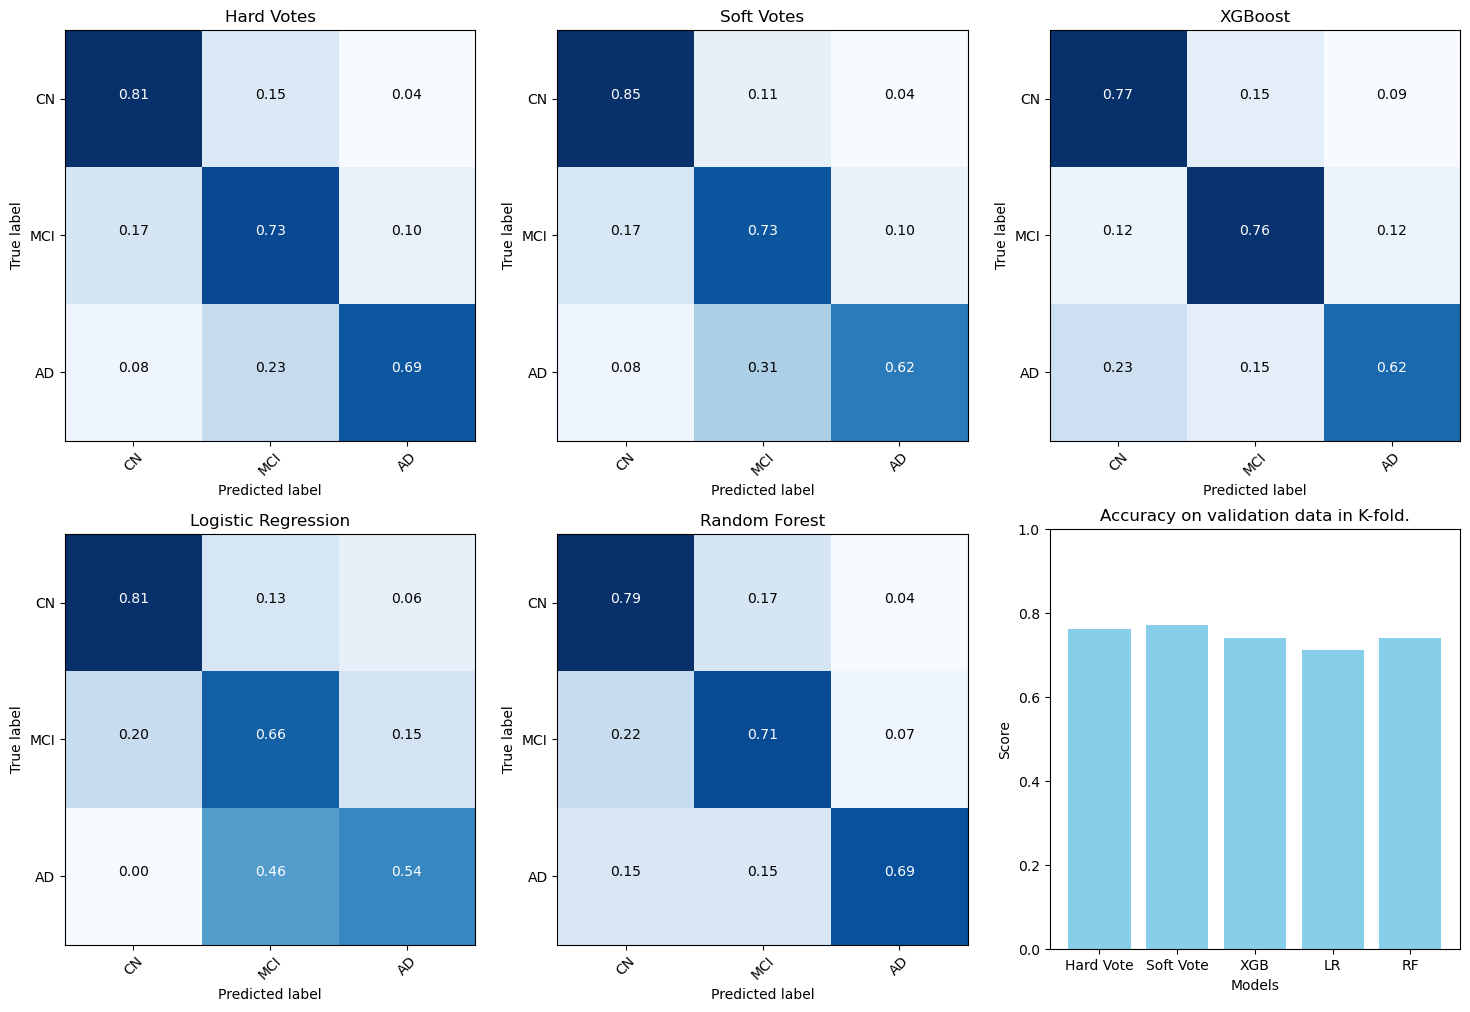

In [56]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 13

In [57]:
df_union13 = get_union_features(1, 13, df_pre)

In [58]:
all_models, votes, y_true = pipeline(df_union13, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 1.690699815750122 seconds.

LR 0 started.
LR 0 is done in 2.6106436252593994 seconds.

RF 0 started.
RF 0 is done in 3.2051379680633545 seconds.

Hard vote F1 score: 0.5555555555555555
Soft vote F1 score: 0.8161616161616162

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.6246917247772217 seconds.

LR 1 started.
LR 1 is done in 2.57633638381958 seconds.

RF 1 started.
RF 1 is done in 3.3006889820098877 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 1.0

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.6099438667297363 seconds.

LR 2 started.
LR 2 is done in 2.4769909381866455 seconds.

RF 2 started.
RF 2 is done in 3.380134105682373 seconds.

Hard vote F1 score: 0.8984126984126984
Soft vote F1 score: 1.0

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1.6223185062408447 seconds.

LR 3 started.
LR 3 i

XGB       	AUC OVR: 0.8725944292498523  	AUC OVO: 0.8735446356100223  	ACC: 0.7128712871287128  	F1: 0.709027103482549
LR        	AUC OVR: 0.8584816648559945  	AUC OVO: 0.8477638949875587  	ACC: 0.7524752475247525  	F1: 0.7556605224751348
RF        	AUC OVR: 0.8583924876305088  	AUC OVO: 0.870650539565952   	ACC: 0.7326732673267327  	F1: 0.7321849728832533
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7920792079207921  	F1: 0.7925681457034592
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7326732673267327  	F1: 0.7303655535621589


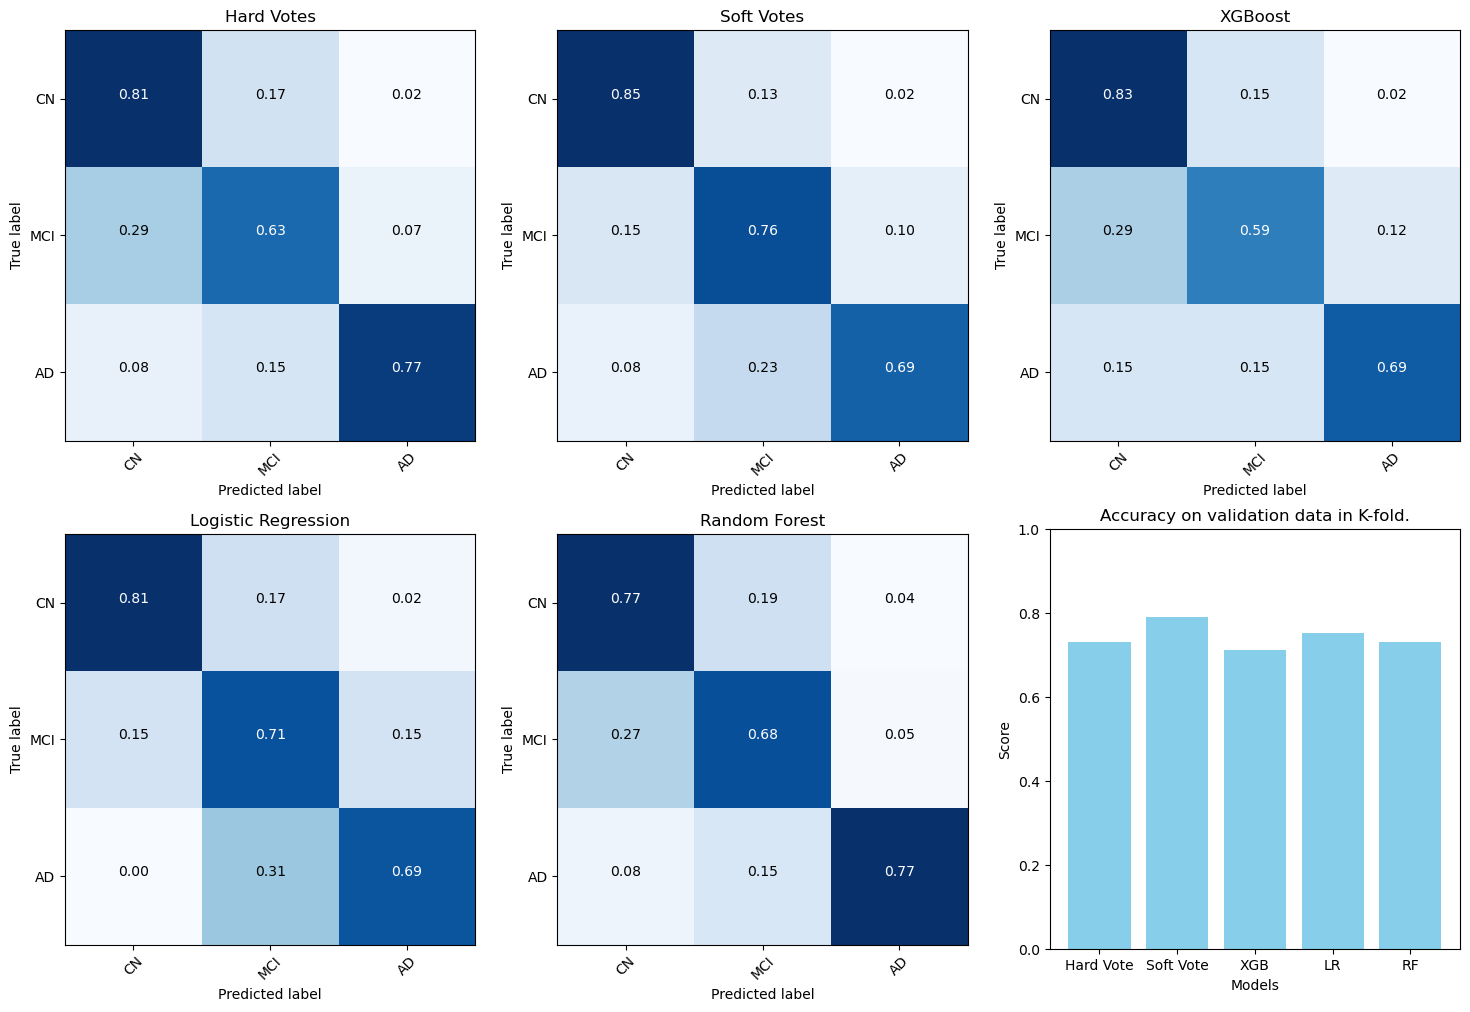

In [59]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 14

In [60]:
df_union14 = get_union_features(1, 14, df_pre)

In [61]:
all_models, votes, y_true = pipeline(df_union14, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 1.6956610679626465 seconds.

LR 0 started.
LR 0 is done in 2.676765203475952 seconds.

RF 0 started.
RF 0 is done in 3.4596874713897705 seconds.

Hard vote F1 score: 0.5221445221445221
Soft vote F1 score: 0.632034632034632

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.726672887802124 seconds.

LR 1 started.
LR 1 is done in 2.443037986755371 seconds.

RF 1 started.
RF 1 is done in 3.4406960010528564 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 0.7961904761904761

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.712827205657959 seconds.

LR 2 started.
LR 2 is done in 2.751756191253662 seconds.

RF 2 started.
RF 2 is done in 3.489467144012451 seconds.

Hard vote F1 score: 0.6841269841269841
Soft vote F1 score: 0.6841269841269841

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1.6846649646759033 sec

XGB       	AUC OVR: 0.8651098907499185  	AUC OVO: 0.8680225672960494  	ACC: 0.7722772277227723  	F1: 0.7702770277027702
LR        	AUC OVR: 0.8281921860325251  	AUC OVO: 0.8335794978244381  	ACC: 0.7029702970297029  	F1: 0.7017739273927392
RF        	AUC OVR: 0.851918276390686   	AUC OVO: 0.871621891341663   	ACC: 0.7326732673267327  	F1: 0.7321085642193443
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7425742574257426  	F1: 0.7395379537953797
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7623762376237624  	F1: 0.7604419129171605


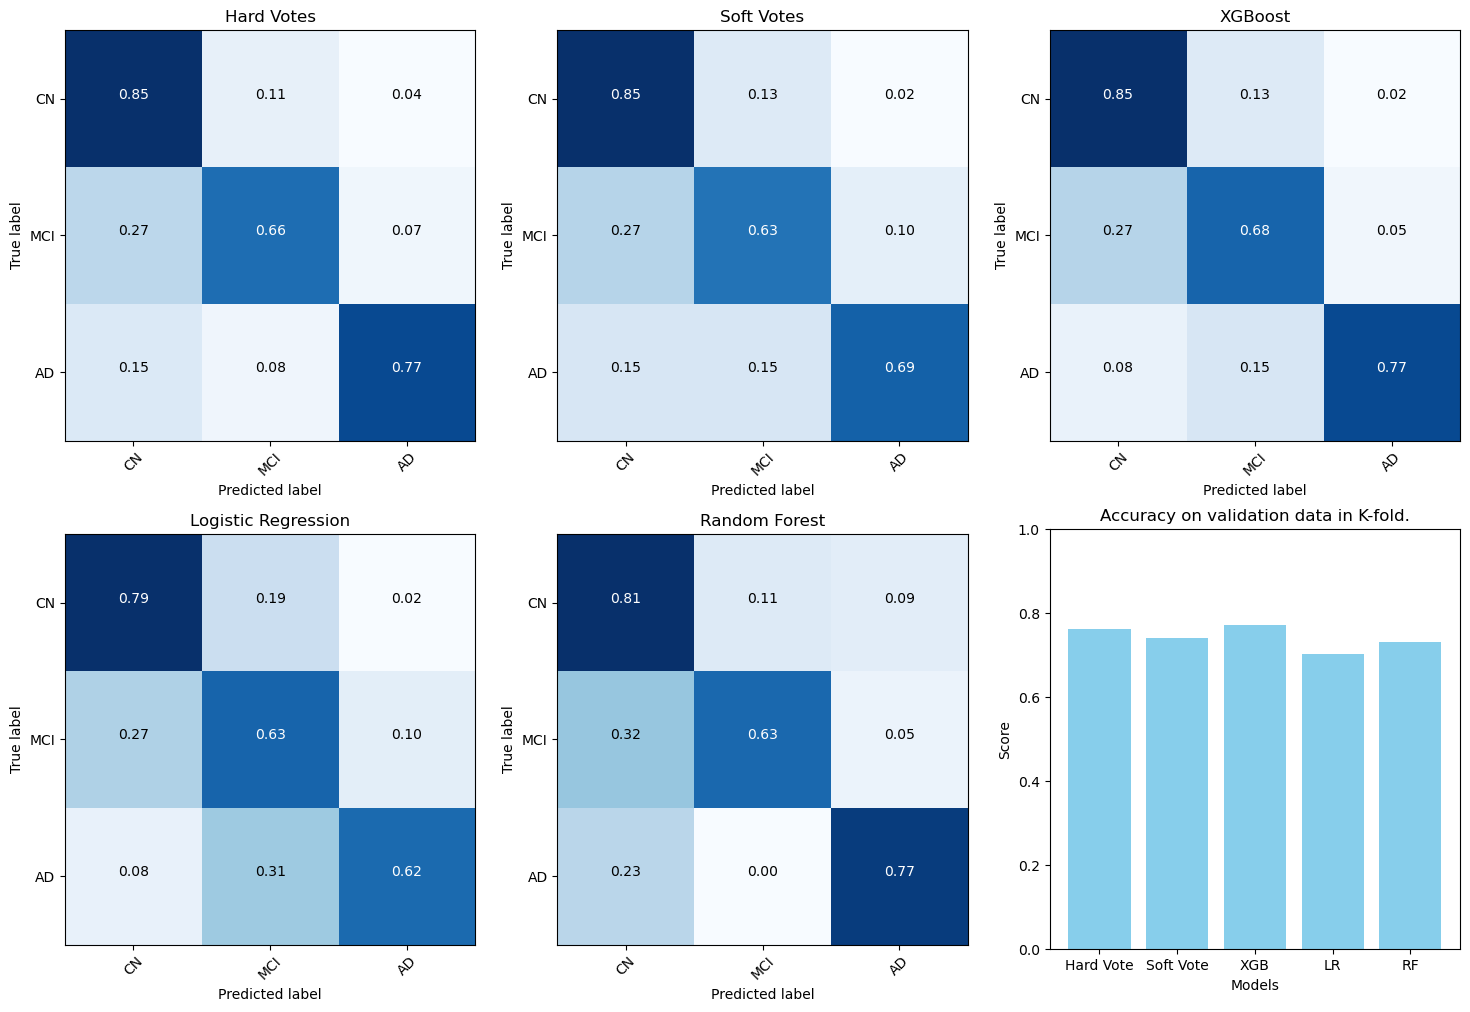

In [62]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 15

In [63]:
df_union15 = get_union_features(1, 15, df_pre)

In [64]:
all_models, votes, y_true = pipeline(df_union15, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 1.8482961654663086 seconds.

LR 0 started.
LR 0 is done in 2.9216442108154297 seconds.

RF 0 started.
RF 0 is done in 3.445411205291748 seconds.

Hard vote F1 score: 0.5454545454545454
Soft vote F1 score: 0.5454545454545454

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.7701680660247803 seconds.

LR 1 started.
LR 1 is done in 2.8166019916534424 seconds.

RF 1 started.
RF 1 is done in 3.3252835273742676 seconds.

Hard vote F1 score: 0.8984126984126984
Soft vote F1 score: 0.8984126984126984

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.7239625453948975 seconds.

LR 2 started.
LR 2 is done in 2.691023349761963 seconds.

RF 2 started.
RF 2 is done in 3.3460898399353027 seconds.

Hard vote F1 score: 0.888888888888889
Soft vote F1 score: 0.888888888888889

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1.75

XGB       	AUC OVR: 0.8723145759082449  	AUC OVO: 0.8729258978350831  	ACC: 0.7425742574257426  	F1: 0.7421639031373016
LR        	AUC OVR: 0.8666436933302527  	AUC OVO: 0.8619882107168043  	ACC: 0.7128712871287128  	F1: 0.7132379904657133
RF        	AUC OVR: 0.8774885272204075  	AUC OVO: 0.886761007544609   	ACC: 0.7623762376237624  	F1: 0.7620778018827573
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7524752475247525  	F1: 0.7515097795795971
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7524752475247525  	F1: 0.7520596504094853


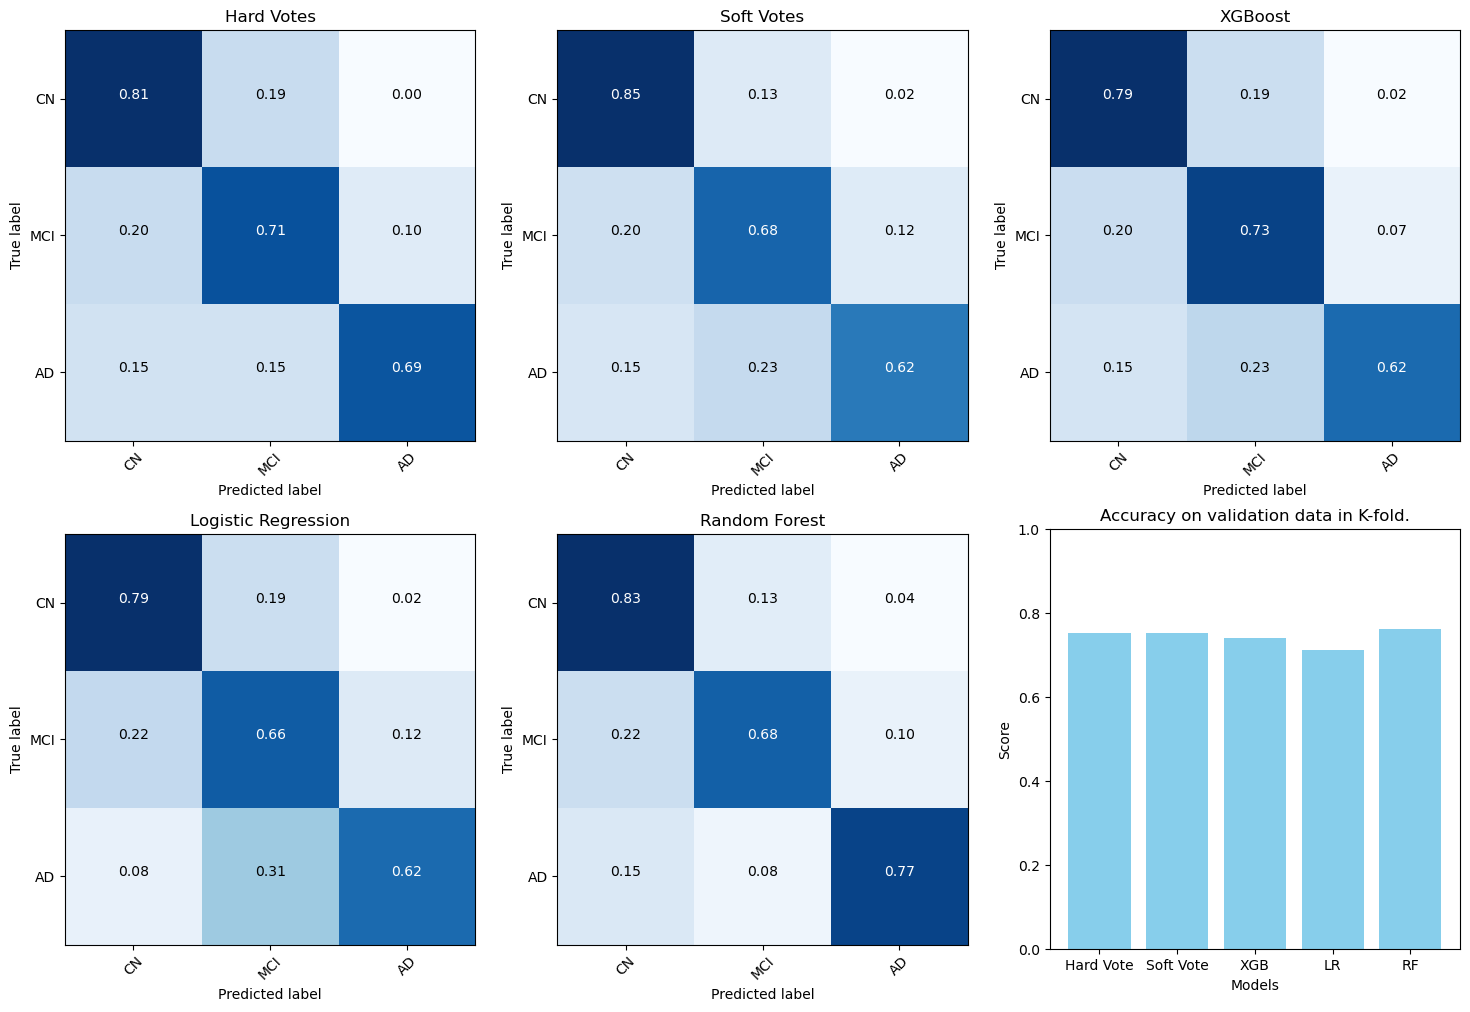

In [65]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 16

In [66]:
df_union16 = get_union_features(1, 16, df_pre)

In [67]:
all_models, votes, y_true = pipeline(df_union16, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 1.7947030067443848 seconds.

LR 0 started.
LR 0 is done in 2.9782967567443848 seconds.

RF 0 started.
RF 0 is done in 3.386972665786743 seconds.

Hard vote F1 score: 0.8071625344352618
Soft vote F1 score: 0.8071625344352618

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.8166863918304443 seconds.

LR 1 started.
LR 1 is done in 2.7849276065826416 seconds.

RF 1 started.
RF 1 is done in 3.323077917098999 seconds.

Hard vote F1 score: 0.8984126984126984
Soft vote F1 score: 0.6952380952380952

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.829699993133545 seconds.

LR 2 started.
LR 2 is done in 2.765758752822876 seconds.

RF 2 started.
RF 2 is done in 3.2271385192871094 seconds.

Hard vote F1 score: 0.8984126984126984
Soft vote F1 score: 0.8984126984126984

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1.84

XGB       	AUC OVR: 0.889391511126505   	AUC OVO: 0.8956927867151011  	ACC: 0.7920792079207921  	F1: 0.793492400309433
LR        	AUC OVR: 0.9053044874875007  	AUC OVO: 0.9039426237142895  	ACC: 0.7920792079207921  	F1: 0.7921178431729152
RF        	AUC OVR: 0.8837849675550765  	AUC OVO: 0.9005196066690617  	ACC: 0.7623762376237624  	F1: 0.7638381747880614
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8118811881188119  	F1: 0.8121857418186323
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8316831683168316  	F1: 0.8317868149941081


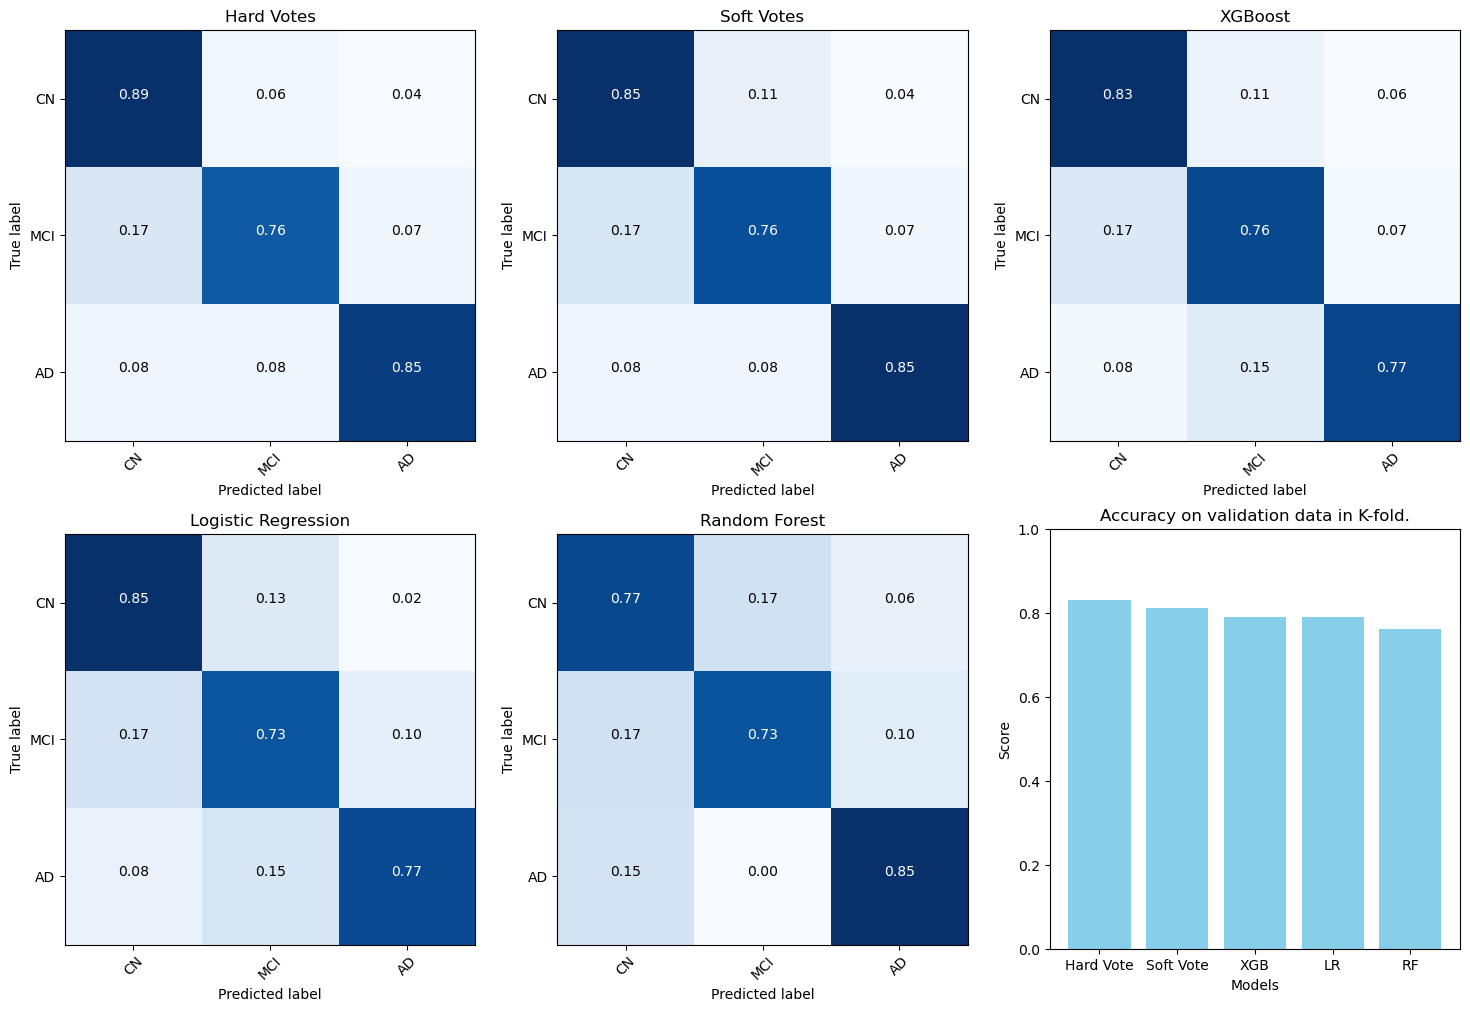

In [68]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 17

In [69]:
df_union17 = get_union_features(1, 17, df_pre)

In [70]:
all_models, votes, y_true = pipeline(df_union17, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 1.9887447357177734 seconds.

LR 0 started.
LR 0 is done in 3.011446952819824 seconds.

RF 0 started.
RF 0 is done in 3.50976300239563 seconds.

Hard vote F1 score: 0.8136363636363636
Soft vote F1 score: 0.8136363636363636

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.897721529006958 seconds.

LR 1 started.
LR 1 is done in 2.9961130619049072 seconds.

RF 1 started.
RF 1 is done in 3.519641637802124 seconds.

Hard vote F1 score: 0.7984126984126985
Soft vote F1 score: 0.8

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.9237525463104248 seconds.

LR 2 started.
LR 2 is done in 3.227086067199707 seconds.

RF 2 started.
RF 2 is done in 3.530809164047241 seconds.

Hard vote F1 score: 0.7
Soft vote F1 score: 0.7961904761904761

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1.8934130668640137 seconds.

LR 3 sta

XGB       	AUC OVR: 0.8680323453286608  	AUC OVO: 0.8723936502867483  	ACC: 0.7227722772277227  	F1: 0.7266761082343255
LR        	AUC OVR: 0.8725609890503508  	AUC OVO: 0.8666986015195667  	ACC: 0.7623762376237624  	F1: 0.7621895084245267
RF        	AUC OVR: 0.8586867033675545  	AUC OVO: 0.8687743669580722  	ACC: 0.7524752475247525  	F1: 0.7539834695860644
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7821782178217822  	F1: 0.7851846677569073
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7722772277227723  	F1: 0.7746503221750747


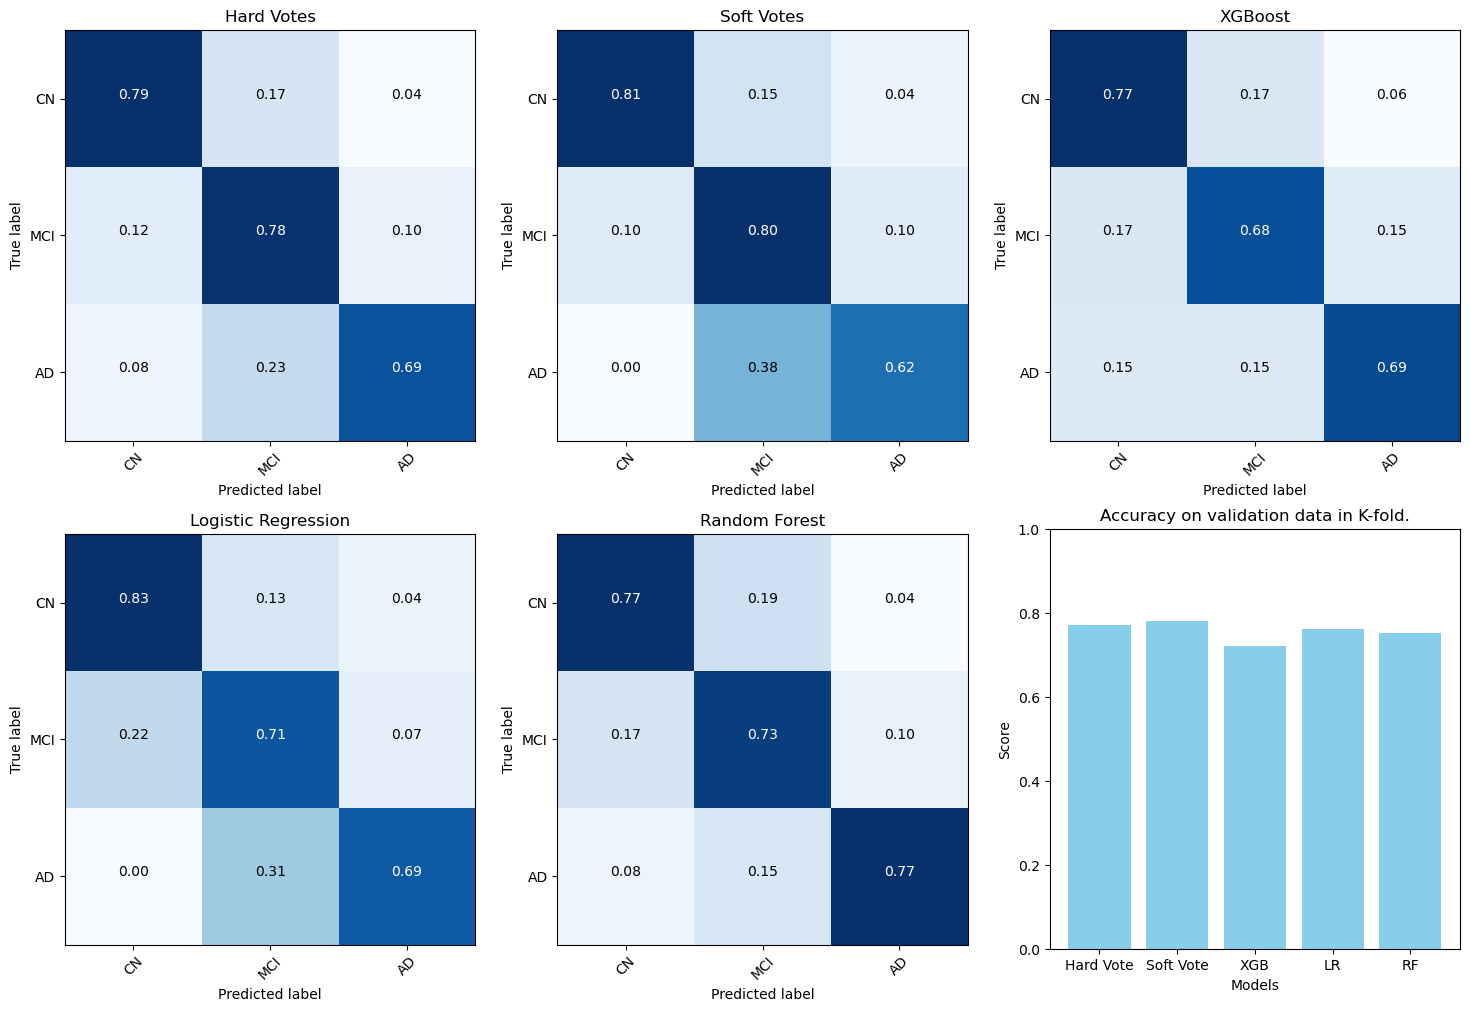

In [71]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 18

In [72]:
df_union18 = get_union_features(1, 18, df_pre)

In [73]:
all_models, votes, y_true = pipeline(df_union18, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 2.081043243408203 seconds.

LR 0 started.
LR 0 is done in 3.52575945854187 seconds.

RF 0 started.
RF 0 is done in 3.5353736877441406 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 1.0

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.915308952331543 seconds.

LR 1 started.
LR 1 is done in 3.2202184200286865 seconds.

RF 1 started.
RF 1 is done in 3.3367764949798584 seconds.

Hard vote F1 score: 0.9028571428571428
Soft vote F1 score: 0.9028571428571428

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.973710060119629 seconds.

LR 2 started.
LR 2 is done in 3.548866033554077 seconds.

RF 2 started.
RF 2 is done in 3.7809619903564453 seconds.

Hard vote F1 score: 0.31428571428571433
Soft vote F1 score: 0.39999999999999997

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 2.028876543045044 seconds.

LR 3 s

XGB       	AUC OVR: 0.8974466342309276  	AUC OVO: 0.897422591247189   	ACC: 0.7623762376237624  	F1: 0.7670080135103812
LR        	AUC OVR: 0.9210650340645152  	AUC OVO: 0.9218261413383365  	ACC: 0.7524752475247525  	F1: 0.7555934164845056
RF        	AUC OVR: 0.8561576925160216  	AUC OVO: 0.8750548880284219  	ACC: 0.7029702970297029  	F1: 0.7028288543140029
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7821782178217822  	F1: 0.7843622442712191
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7326732673267327  	F1: 0.734183527048357


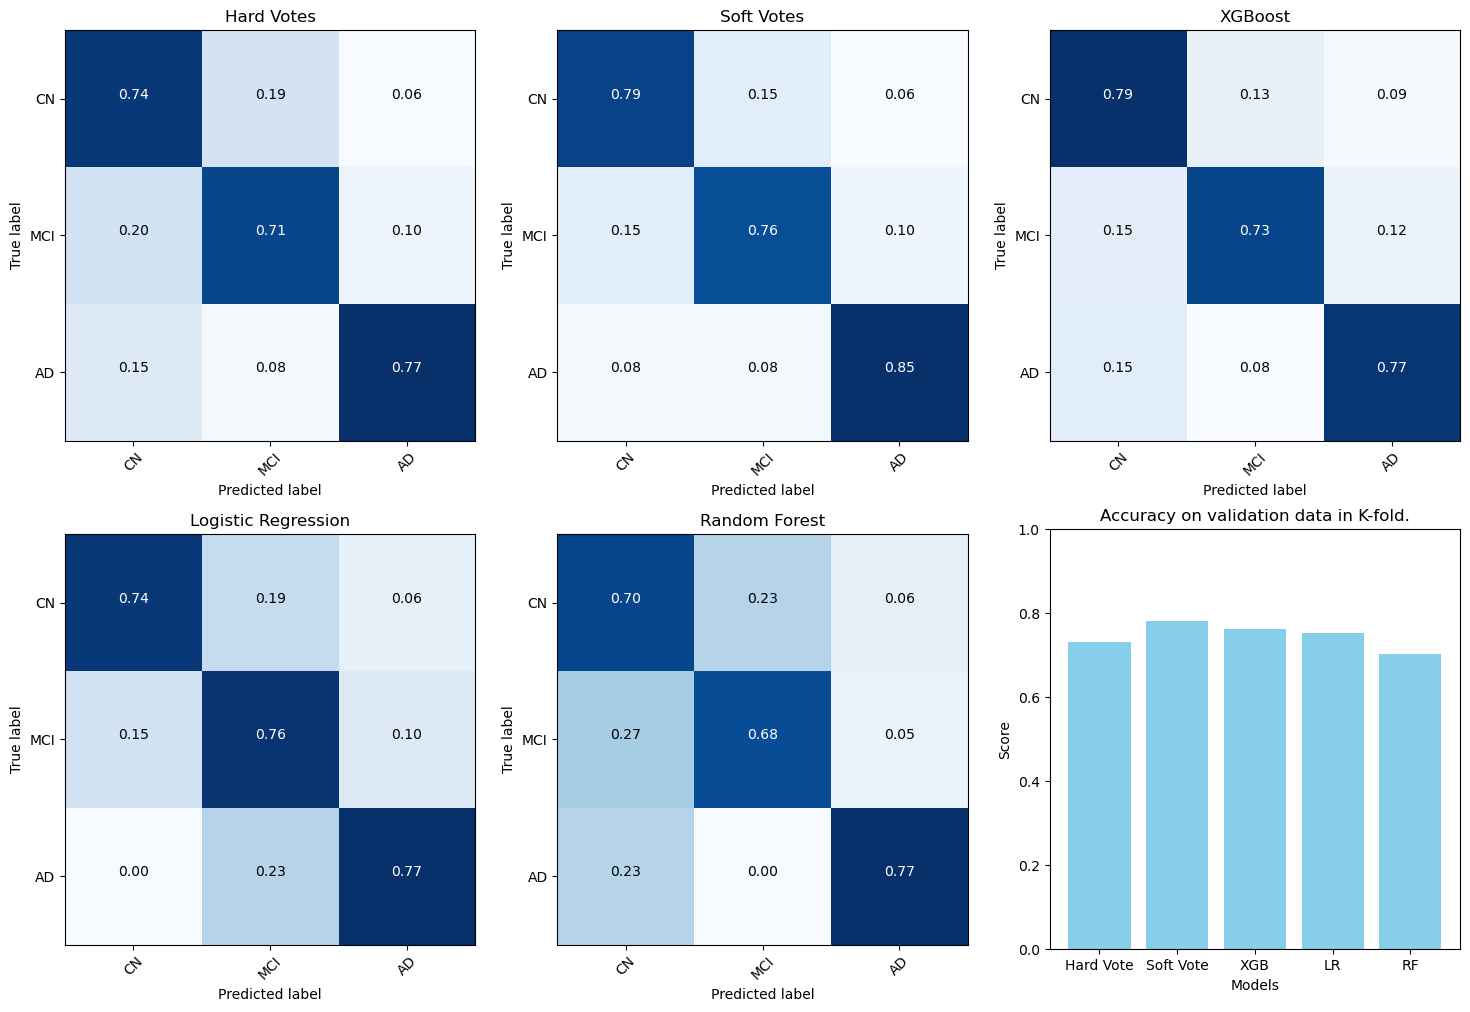

In [74]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 19

In [75]:
df_union19 = get_union_features(1, 19, df_pre)

KeyboardInterrupt: 

In [ ]:
all_models, votes, y_true = pipeline(df_union19, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 2.119387626647949 seconds.

LR 0 started.
LR 0 is done in 3.5954976081848145 seconds.

RF 0 started.
RF 0 is done in 3.5261096954345703 seconds.

Hard vote F1 score: 0.7654320987654322
Soft vote F1 score: 0.6074074074074075

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 2.0859315395355225 seconds.

LR 1 started.
LR 1 is done in 3.3501224517822266 seconds.

RF 1 started.
RF 1 is done in 3.572166919708252 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 0.8395061728395061

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 2.1284103393554688 seconds.

LR 2 started.
LR 2 is done in 3.468381881713867 seconds.

RF 2 started.
RF 2 is done in 3.458436965942383 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 0.8871252204585538

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 2.0697669982910156 seconds.

LR 3 

XGB       	AUC OVR: 0.8860655248578281  	AUC OVO: 0.873768531802965   	ACC: 0.7647058823529411  	F1: 0.7577011538429204
LR        	AUC OVR: 0.9330828787495173  	AUC OVO: 0.9297704447632711  	ACC: 0.8235294117647058  	F1: 0.8205613633605519
RF        	AUC OVR: 0.8854104186433496  	AUC OVO: 0.8898075083692013  	ACC: 0.7764705882352941  	F1: 0.7744637994703271
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.788235294117647   	F1: 0.7847736571595327
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8117647058823529  	F1: 0.8074894679357154


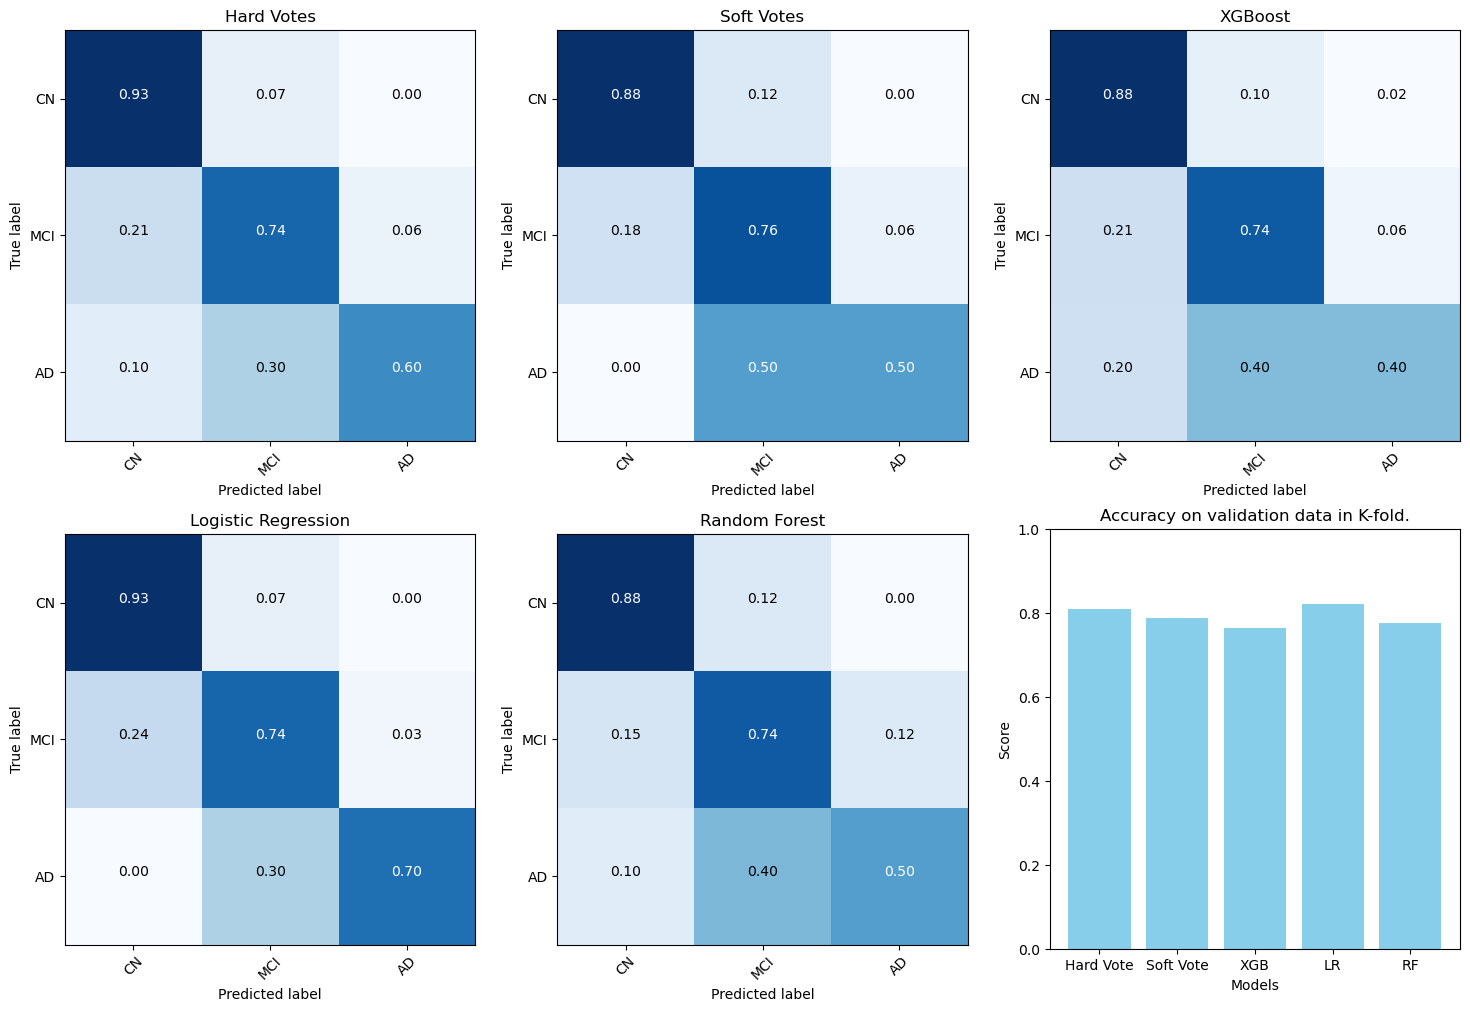

In [ ]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 20

In [ ]:
df_union20 = get_union_features(1, 20, df_pre)

In [ ]:
all_models, votes, y_true = pipeline(df_union20, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 2.3098158836364746 seconds.

LR 0 started.
LR 0 is done in 3.8980093002319336 seconds.

RF 0 started.
RF 0 is done in 3.5904901027679443 seconds.

Hard vote F1 score: 0.8871252204585538
Soft vote F1 score: 0.8871252204585538

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 2.250913381576538 seconds.

LR 1 started.
LR 1 is done in 3.8276329040527344 seconds.

RF 1 started.
RF 1 is done in 3.3998515605926514 seconds.

Hard vote F1 score: 0.8994708994708994
Soft vote F1 score: 0.8994708994708994

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 2.1946861743927 seconds.

LR 2 started.
LR 2 is done in 3.7222366333007812 seconds.

RF 2 started.
RF 2 is done in 3.499992847442627 seconds.

Hard vote F1 score: 0.8994708994708994
Soft vote F1 score: 0.8994708994708994

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 2.154

XGB       	AUC OVR: 0.8986880485162198  	AUC OVO: 0.8917623146819703  	ACC: 0.788235294117647   	F1: 0.7883994821761233
LR        	AUC OVR: 0.9496555000592473  	AUC OVO: 0.9515303682448589  	ACC: 0.8588235294117647  	F1: 0.8576862117329871
RF        	AUC OVR: 0.8881738031850278  	AUC OVO: 0.8933405069344812  	ACC: 0.7411764705882353  	F1: 0.7416289592760181
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8352941176470589  	F1: 0.8328564096620917
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8470588235294118  	F1: 0.8447128668125188


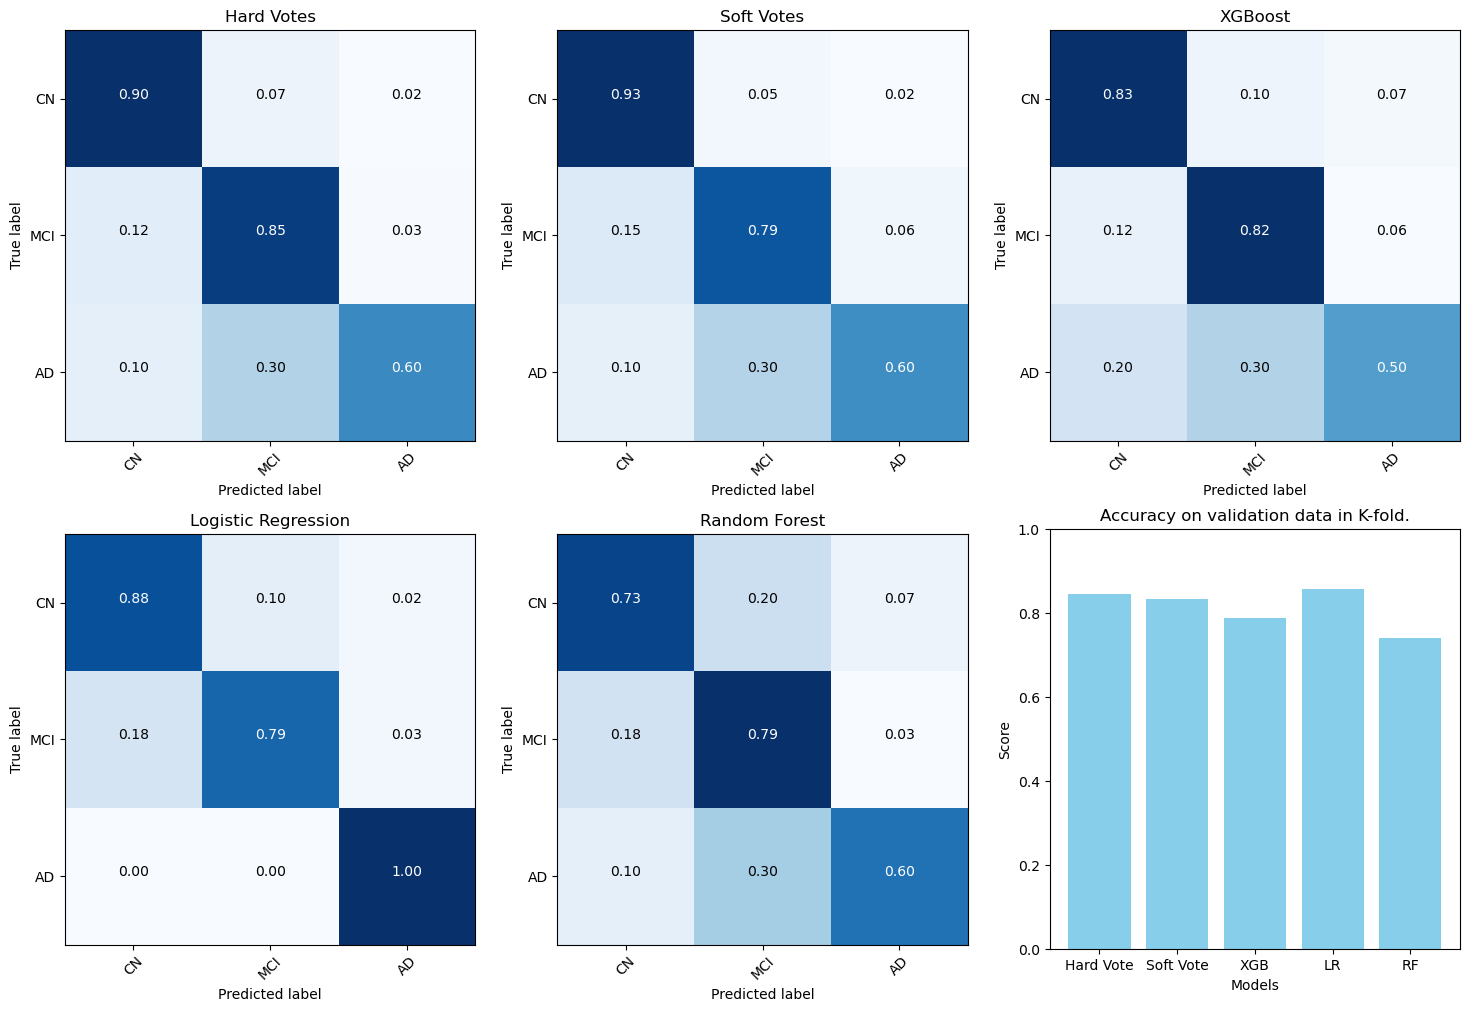

In [ ]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 25

In [ ]:
df_union25 = get_union_features(1, 25, df_pre)

In [ ]:
all_models, votes, y_true = pipeline(df_union25, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 2.544691324234009 seconds.

LR 0 started.
LR 0 is done in 4.388219833374023 seconds.

RF 0 started.
RF 0 is done in 3.708488702774048 seconds.

Hard vote F1 score: 0.8871252204585538
Soft vote F1 score: 0.8871252204585538

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 2.5058257579803467 seconds.

LR 1 started.
LR 1 is done in 4.439394950866699 seconds.

RF 1 started.
RF 1 is done in 3.697172164916992 seconds.

Hard vote F1 score: 0.7629629629629631
Soft vote F1 score: 0.7629629629629631

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 2.4103949069976807 seconds.

LR 2 started.
LR 2 is done in 4.672307729721069 seconds.

RF 2 started.
RF 2 is done in 3.674165964126587 seconds.

Hard vote F1 score: 0.5629629629629629
Soft vote F1 score: 0.6772486772486772

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 2.41990

XGB       	AUC OVR: 0.9003839423861367  	AUC OVO: 0.8923720707795312  	ACC: 0.7176470588235294  	F1: 0.7077540106951872
LR        	AUC OVR: 0.9605919640322543  	AUC OVO: 0.9569942611190818  	ACC: 0.8352941176470589  	F1: 0.8329437522135292
RF        	AUC OVR: 0.907848308385569   	AUC OVO: 0.9133010521281685  	ACC: 0.7411764705882353  	F1: 0.7358041938002823
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8235294117647058  	F1: 0.8182773973431414
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7647058823529411  	F1: 0.7610987737207847


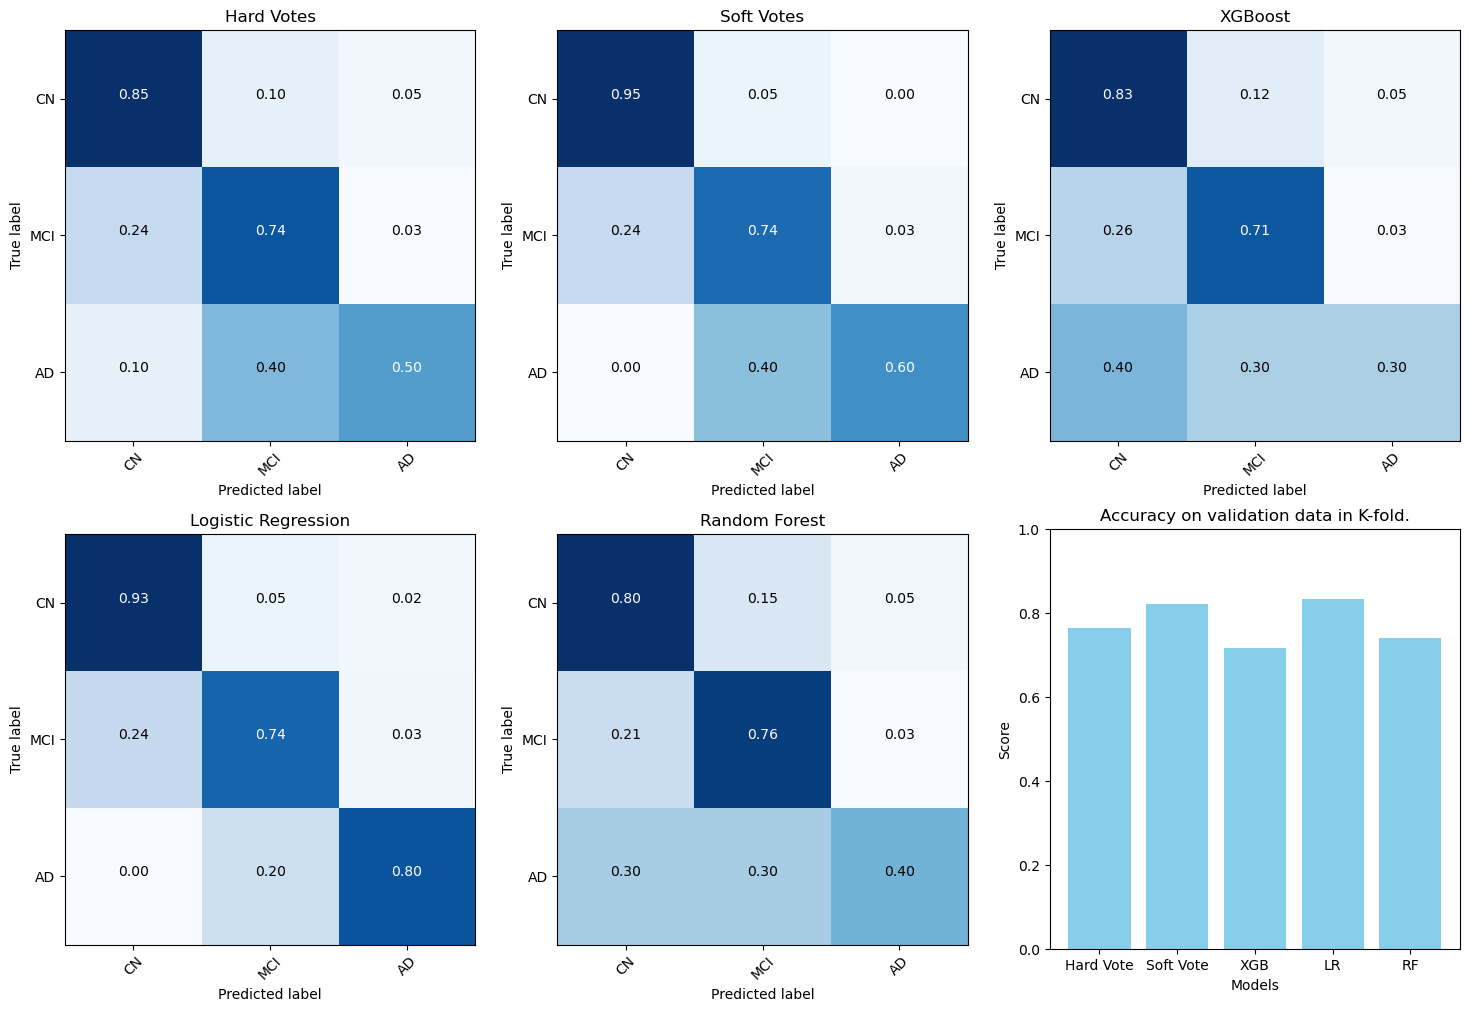

In [ ]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 40

In [ ]:
df_union40 = get_union_features(1, 40, df_pre)

In [ ]:
all_models, votes, y_true = pipeline(df_union40, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 3.505091667175293 seconds.

LR 0 started.
LR 0 is done in 8.202149629592896 seconds.

RF 0 started.
RF 0 is done in 3.9243805408477783 seconds.

Hard vote F1 score: 0.8871252204585538
Soft vote F1 score: 0.8871252204585538

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 3.4568591117858887 seconds.

LR 1 started.
LR 1 is done in 8.0992751121521 seconds.

RF 1 started.
RF 1 is done in 4.090566873550415 seconds.

Hard vote F1 score: 0.6296296296296295
Soft vote F1 score: 0.6296296296296295

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 3.5933785438537598 seconds.

LR 2 started.
LR 2 is done in 8.455382347106934 seconds.

RF 2 started.
RF 2 is done in 3.920264959335327 seconds.

Hard vote F1 score: 0.7365079365079364
Soft vote F1 score: 0.8395061728395061

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 3.422695

XGB       	AUC OVR: 0.893913609894199   	AUC OVO: 0.8871831659493065  	ACC: 0.7411764705882353  	F1: 0.7360592621472781
LR        	AUC OVR: 0.939147160694633   	AUC OVO: 0.9378527020564323  	ACC: 0.788235294117647   	F1: 0.7864550423750063
RF        	AUC OVR: 0.914605777583413   	AUC OVO: 0.9200860832137733  	ACC: 0.7294117647058823  	F1: 0.7172650878533232
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8117647058823529  	F1: 0.8101960784313724
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7647058823529411  	F1: 0.7567275185936443


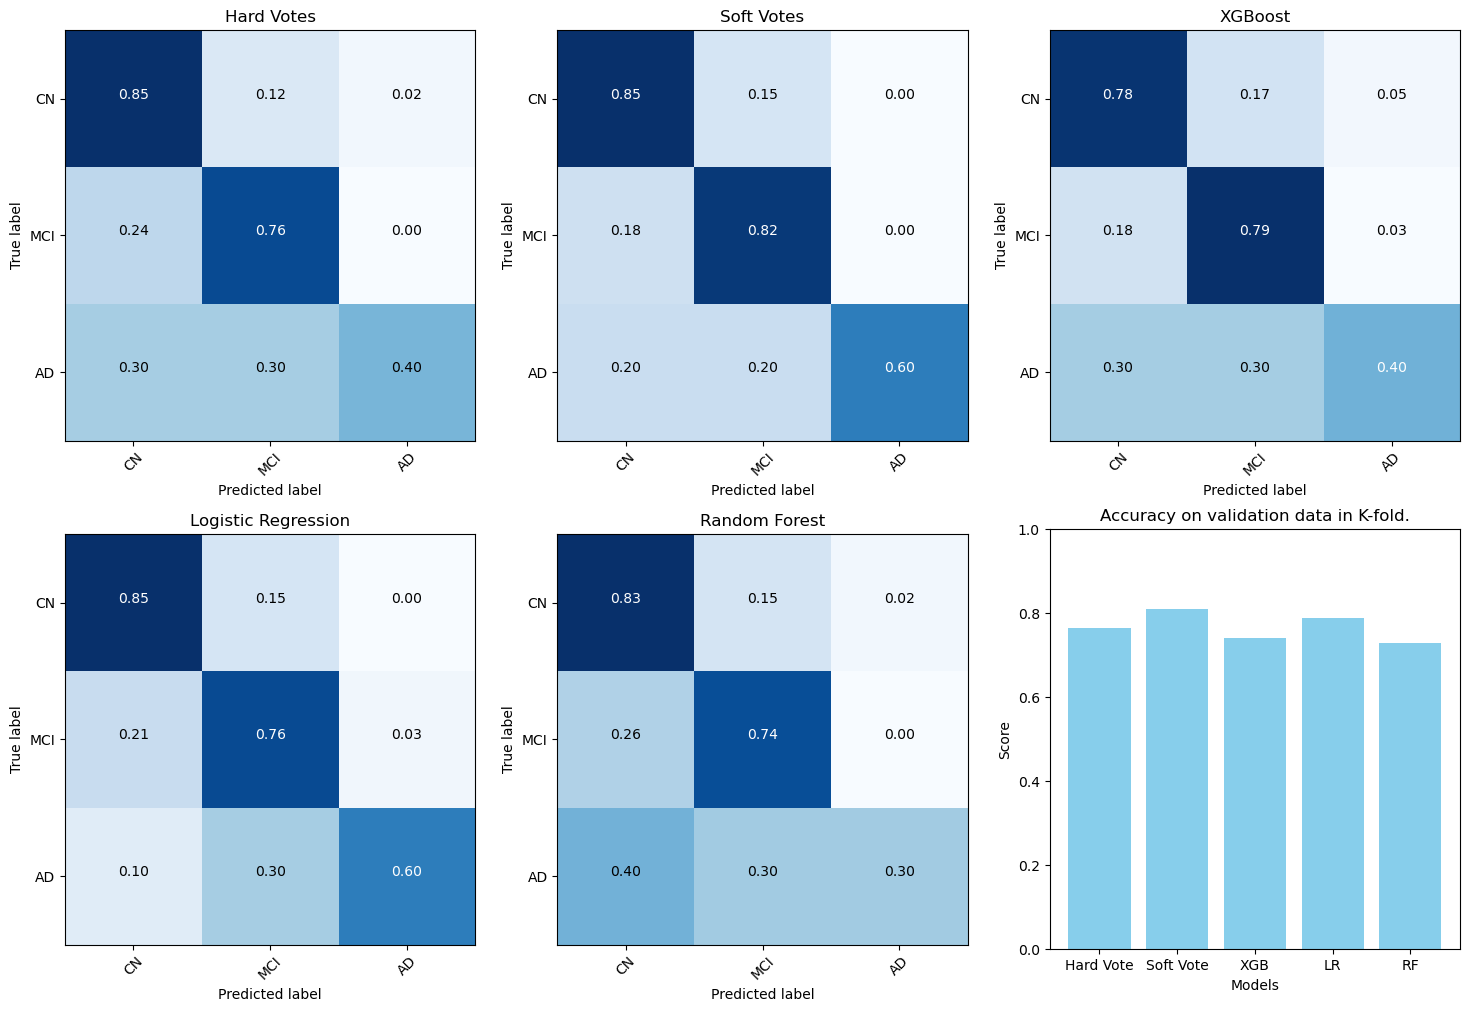

In [ ]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 80

In [ ]:
df_union80 = get_union_features(1, 80, df_pre)

In [ ]:
all_models, votes, y_true = pipeline(df_union80, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 5.256567478179932 seconds.

LR 0 started.
LR 0 is done in 14.60292387008667 seconds.

RF 0 started.
RF 0 is done in 4.2643749713897705 seconds.

Hard vote F1 score: 0.7365079365079364
Soft vote F1 score: 0.7365079365079364

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 5.236567735671997 seconds.

LR 1 started.
LR 1 is done in 16.095362663269043 seconds.

RF 1 started.
RF 1 is done in 4.28382682800293 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 1.0

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 5.29765510559082 seconds.

LR 2 started.
LR 2 is done in 15.894352912902832 seconds.

RF 2 started.
RF 2 is done in 4.073355197906494 seconds.

Hard vote F1 score: 0.8871252204585538
Soft vote F1 score: 1.0

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 5.146588325500488 seconds.

LR 3 started.
LR 3 is don

XGB       	AUC OVR: 0.8875711098664935  	AUC OVO: 0.8764825442372071  	ACC: 0.6941176470588235  	F1: 0.6848837209302325
LR        	AUC OVR: 0.9457935946518949  	AUC OVO: 0.9454925872788141  	ACC: 0.8117647058823529  	F1: 0.8106828253395364
RF        	AUC OVR: 0.8864921635973202  	AUC OVO: 0.8872309899569584  	ACC: 0.7411764705882353  	F1: 0.7345609548167091
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8235294117647058  	F1: 0.8196869335969682
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.788235294117647   	F1: 0.7860765243321024


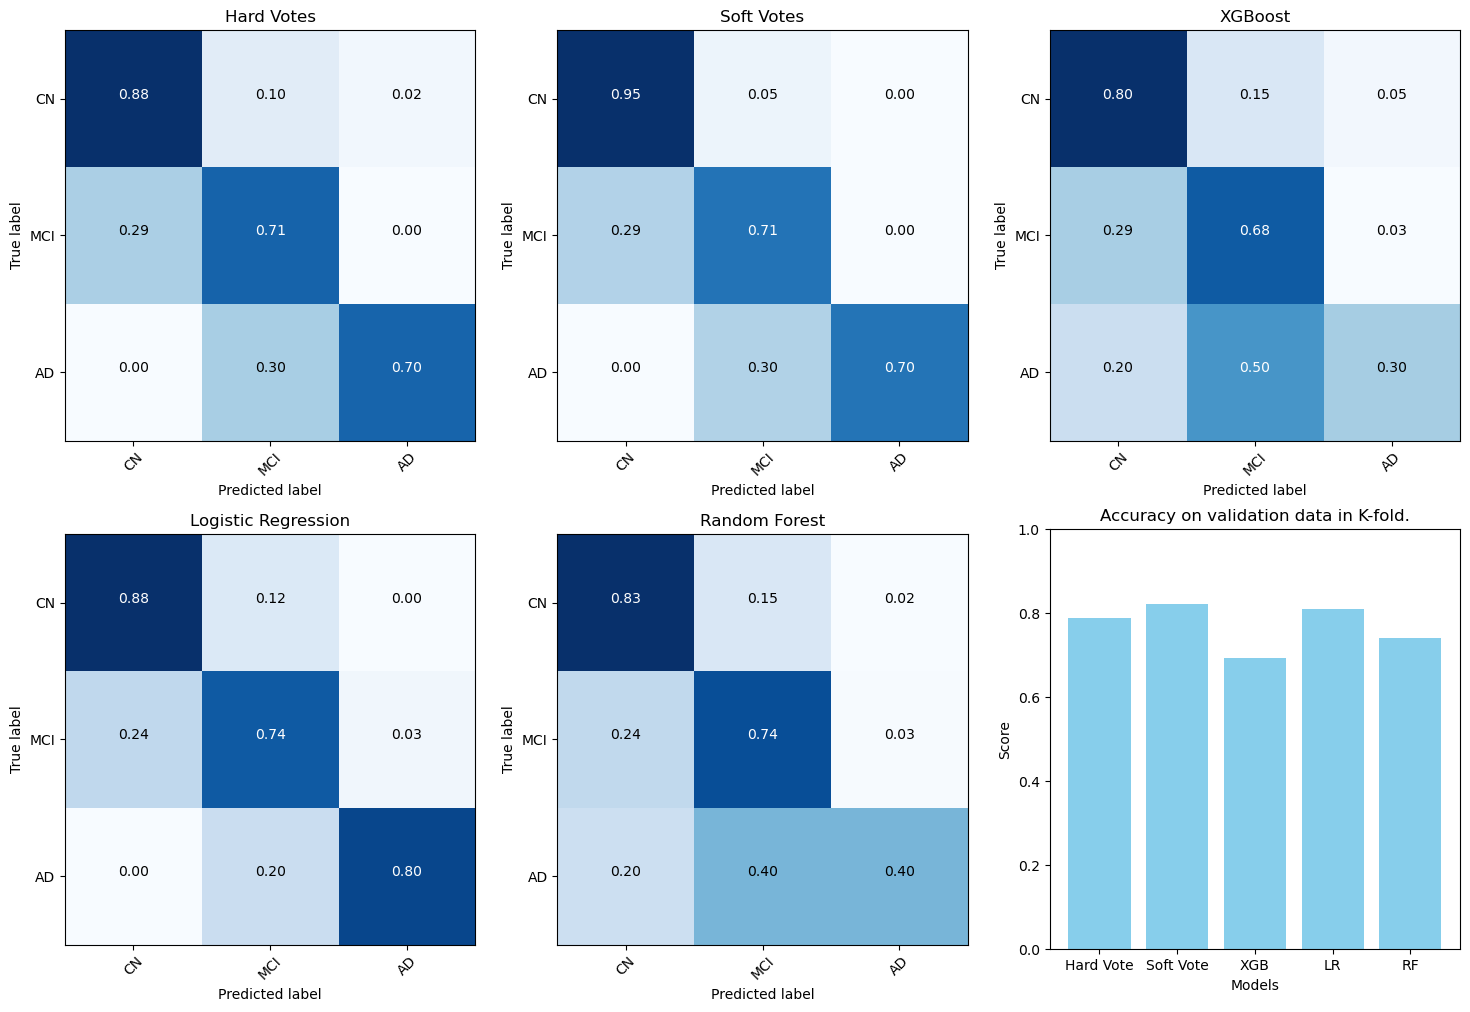

In [ ]:
get_scores(all_models, votes, y_true, get_graphs=True)

## Seed Consistency

In [121]:
all_union = list(df_union2.columns) + list(df_union4.columns) + list(df_union5.columns) + list(df_union8.columns) + list(df_union10.columns) + list(df_union11.columns) + list(df_union12.columns) + list(df_union13.columns) + list(df_union14.columns) + list(df_union15.columns) + list(df_union16.columns) + list(df_union17.columns) + list(df_union18.columns) + list(df_union19.columns) + list(df_union20.columns) + list(df_union40.columns) + list(df_union80)
feature_count = Counter(all_union)

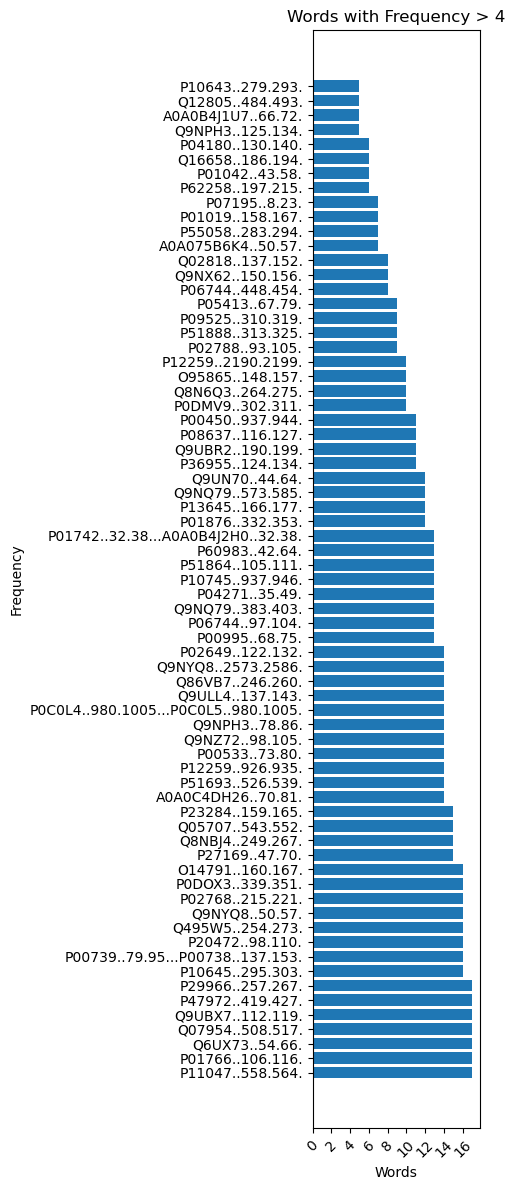

In [122]:
min_frequency = 4
filtered_features = {word: count for word, count in feature_count.items() if count > min_frequency}

words = list(filtered_features.keys())
counts = list(filtered_features.values())

# Plotting
plt.figure(figsize=(5, 12))
plt.barh(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Words with Frequency > {min_frequency}')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

## Presentation

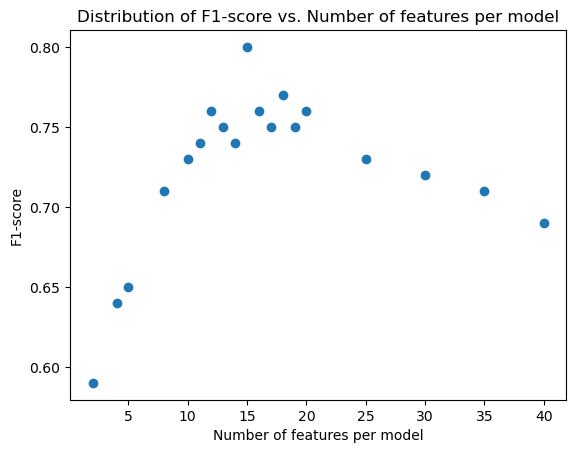

In [53]:
num_features = np.array([2, 4, 5, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40])

percentages = np.array([0.59, 0.64, 0.65, 0.71, 0.73, 0.74, 0.76, 0.75, 0.74, 0.80, 0.76, 0.75, 0.77, 0.75, 0.76, 0.73, 0.72, 0.71, 0.69])

degree = 3 
coefficients = np.polyfit(num_features, percentages, degree)
p = np.poly1d(coefficients)

x_fit = np.linspace(min(num_features), max(num_features), 100)
y_fit = p(x_fit)

plt.scatter(num_features, percentages)
plt.xlabel('Number of features per model')
plt.ylabel('F1-score')
plt.title('Distribution of F1-score vs. Number of features per model')

#plt.grid(True)
plt.show()

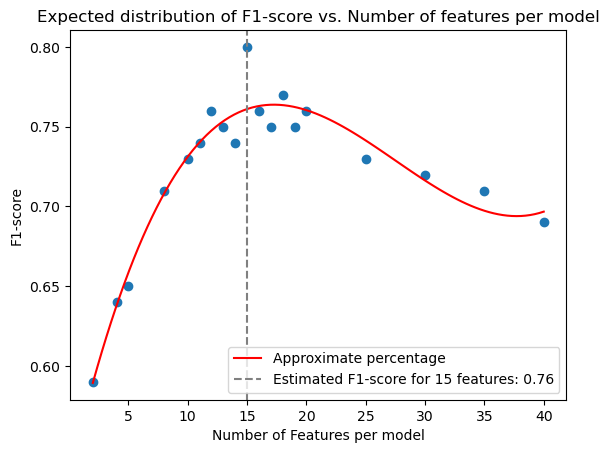

In [54]:
#plt.scatter(num_features, percentages)
plt.scatter(num_features, percentages)
plt.plot(x_fit, y_fit, color='red', label='Approximate percentage')
plt.xlabel('Number of Features per model')
plt.ylabel('F1-score')
plt.title('Distribution of F1-score vs. Number of features per model')

predicted_percentage = p(15)
plt.axvline(x=15, color='gray', linestyle='--', label=f'Estimated F1-score for 15 features: {predicted_percentage:.2f}')

plt.legend()
plt.show()

# 10 Seeds

In [30]:
df_pre = get_union_features_p1(1, 100, df_main)

## 1

In [32]:
df_union_s1 = get_union_features(1, 15, df_pre)

In [33]:
all_models, votes, y_true = pipeline(df_union_s1, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 3.532090425491333 seconds.

LR 0 started.
LR 0 is done in 2.3062336444854736 seconds.

RF 0 started.
RF 0 is done in 3.301847219467163 seconds.

Hard vote F1 score: 0.8994708994708994
Soft vote F1 score: 0.8994708994708994

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.4454572200775146 seconds.

LR 1 started.
LR 1 is done in 2.3583977222442627 seconds.

RF 1 started.
RF 1 is done in 3.130528450012207 seconds.

Hard vote F1 score: 0.7760141093474426
Soft vote F1 score: 0.8994708994708994

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.4856457710266113 seconds.

LR 2 started.
LR 2 is done in 2.3352210521698 seconds.

RF 2 started.
RF 2 is done in 3.275163412094116 seconds.

Hard vote F1 score: 0.7365079365079364
Soft vote F1 score: 0.7629629629629631

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1.47310

XGB       	AUC OVR: 0.9088499596351736  	AUC OVO: 0.8913558106169296  	ACC: 0.7529411764705882  	F1: 0.742798756331177
LR        	AUC OVR: 0.9425754924551448  	AUC OVO: 0.9279531324725011  	ACC: 0.8352941176470589  	F1: 0.8344975729083055
RF        	AUC OVR: 0.8662134689796095  	AUC OVO: 0.8622309899569585  	ACC: 0.7411764705882353  	F1: 0.728218954248366
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8235294117647058  	F1: 0.8194211017740429
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8                 	F1: 0.7890476190476191


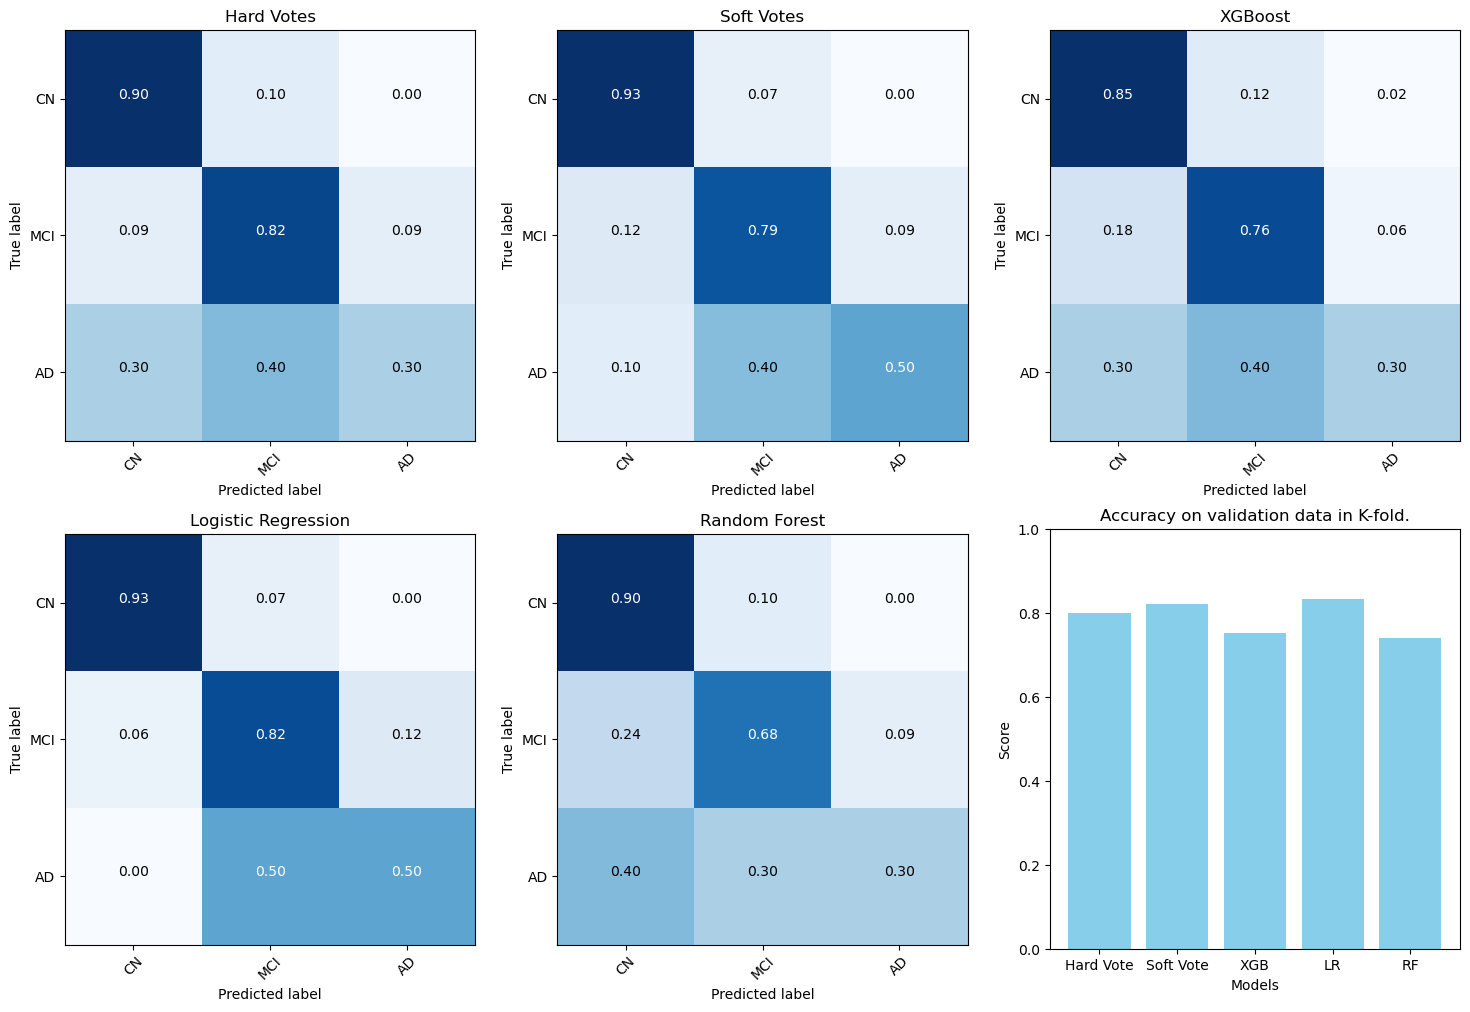

In [34]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 2

In [35]:
df_union_s2 = get_union_features(2, 15, df_pre)

In [36]:
all_models, votes, y_true = pipeline(df_union_s2, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 1.5731582641601562 seconds.

LR 0 started.
LR 0 is done in 2.3735005855560303 seconds.

RF 0 started.
RF 0 is done in 3.3759734630584717 seconds.

Hard vote F1 score: 0.6296296296296295
Soft vote F1 score: 0.6296296296296295

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.4656500816345215 seconds.

LR 1 started.
LR 1 is done in 2.471719741821289 seconds.

RF 1 started.
RF 1 is done in 3.125446081161499 seconds.

Hard vote F1 score: 0.7283950617283951
Soft vote F1 score: 0.7365079365079364

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.4349801540374756 seconds.

LR 2 started.
LR 2 is done in 2.383481025695801 seconds.

RF 2 started.
RF 2 is done in 3.357603073120117 seconds.

Hard vote F1 score: 0.8395061728395061
Soft vote F1 score: 0.7760141093474426

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1.45

XGB       	AUC OVR: 0.8980686005979278  	AUC OVO: 0.8876374940219991  	ACC: 0.7529411764705882  	F1: 0.7482786072059429
LR        	AUC OVR: 0.9123123223116472  	AUC OVO: 0.8983500717360116  	ACC: 0.8                 	F1: 0.7950173010380623
RF        	AUC OVR: 0.8838792754961208  	AUC OVO: 0.8793818747011     	ACC: 0.788235294117647   	F1: 0.7808589626103007
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7764705882352941  	F1: 0.766832902721865
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8                 	F1: 0.7895715455392285


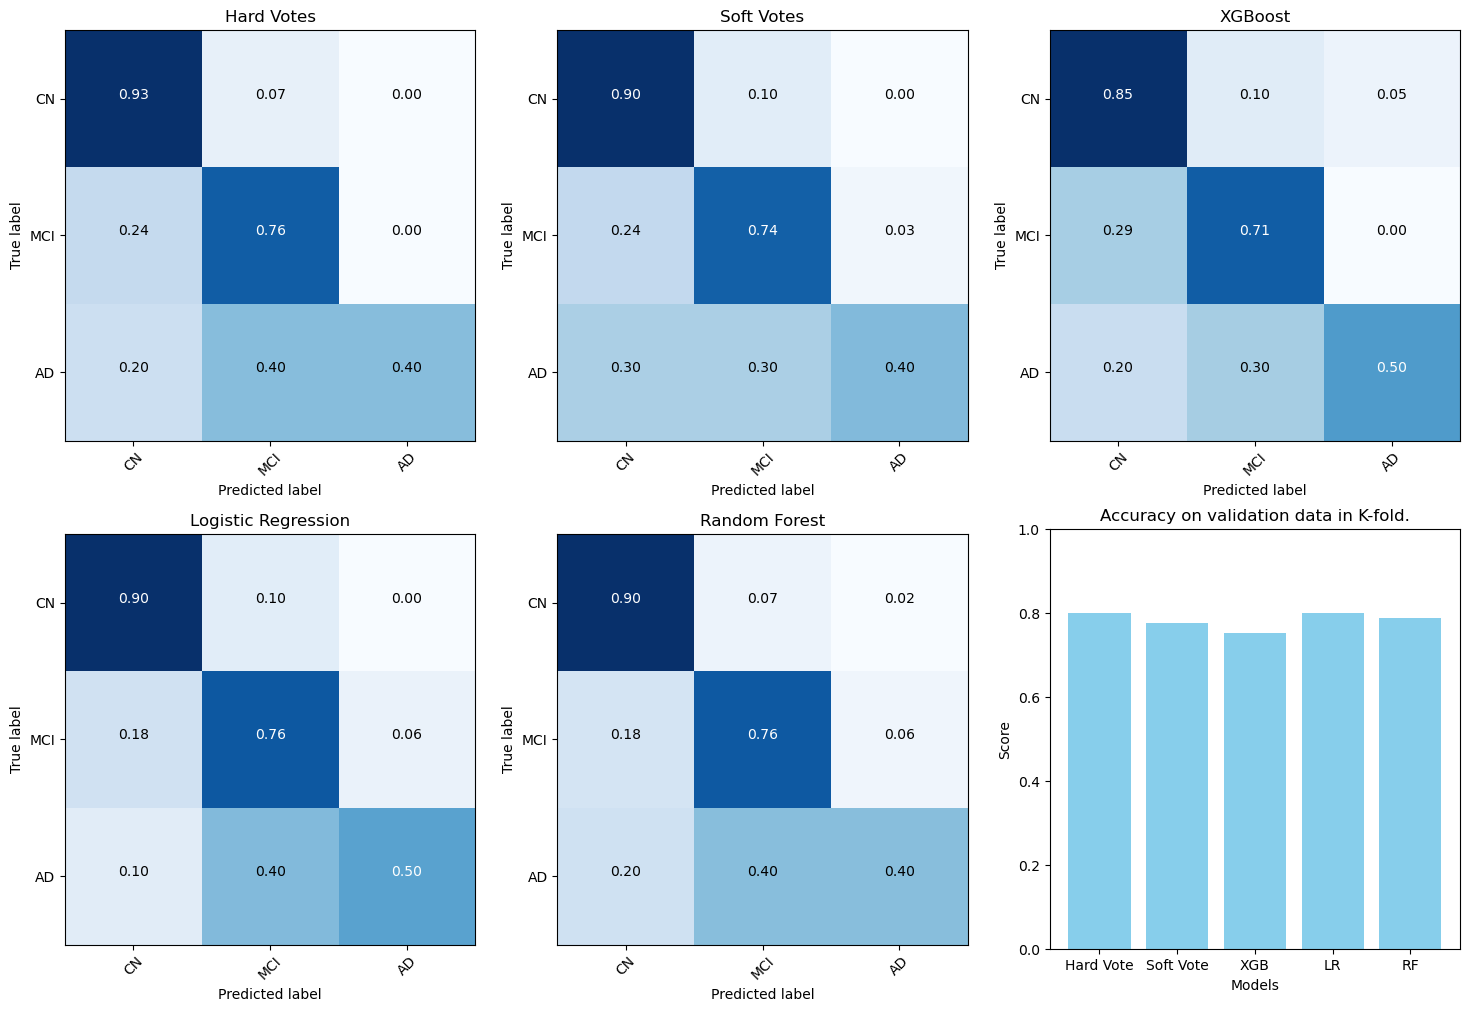

In [37]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 3

In [38]:
df_union_s3 = get_union_features(3, 15, df_pre)

In [39]:
all_models, votes, y_true = pipeline(df_union_s3, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 1.4994745254516602 seconds.

LR 0 started.
LR 0 is done in 2.2208311557769775 seconds.

RF 0 started.
RF 0 is done in 3.341843605041504 seconds.

Hard vote F1 score: 0.7283950617283951
Soft vote F1 score: 0.7283950617283951

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.4412033557891846 seconds.

LR 1 started.
LR 1 is done in 2.480468988418579 seconds.

RF 1 started.
RF 1 is done in 3.39986515045166 seconds.

Hard vote F1 score: 0.6296296296296295
Soft vote F1 score: 0.7283950617283951

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.4306623935699463 seconds.

LR 2 started.
LR 2 is done in 2.3012475967407227 seconds.

RF 2 started.
RF 2 is done in 3.1641440391540527 seconds.

Hard vote F1 score: 0.7365079365079364
Soft vote F1 score: 0.8871252204585538

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1.44

XGB       	AUC OVR: 0.9052933367773438  	AUC OVO: 0.8898613103778098  	ACC: 0.7529411764705882  	F1: 0.7414335145823034
LR        	AUC OVR: 0.926350156983797   	AUC OVO: 0.9232424677187948  	ACC: 0.7529411764705882  	F1: 0.748006379585327
RF        	AUC OVR: 0.9023239816512666  	AUC OVO: 0.8958931133428982  	ACC: 0.7411764705882353  	F1: 0.7192156862745099
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7647058823529411  	F1: 0.7626297577854672
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7764705882352941  	F1: 0.7678648070922524


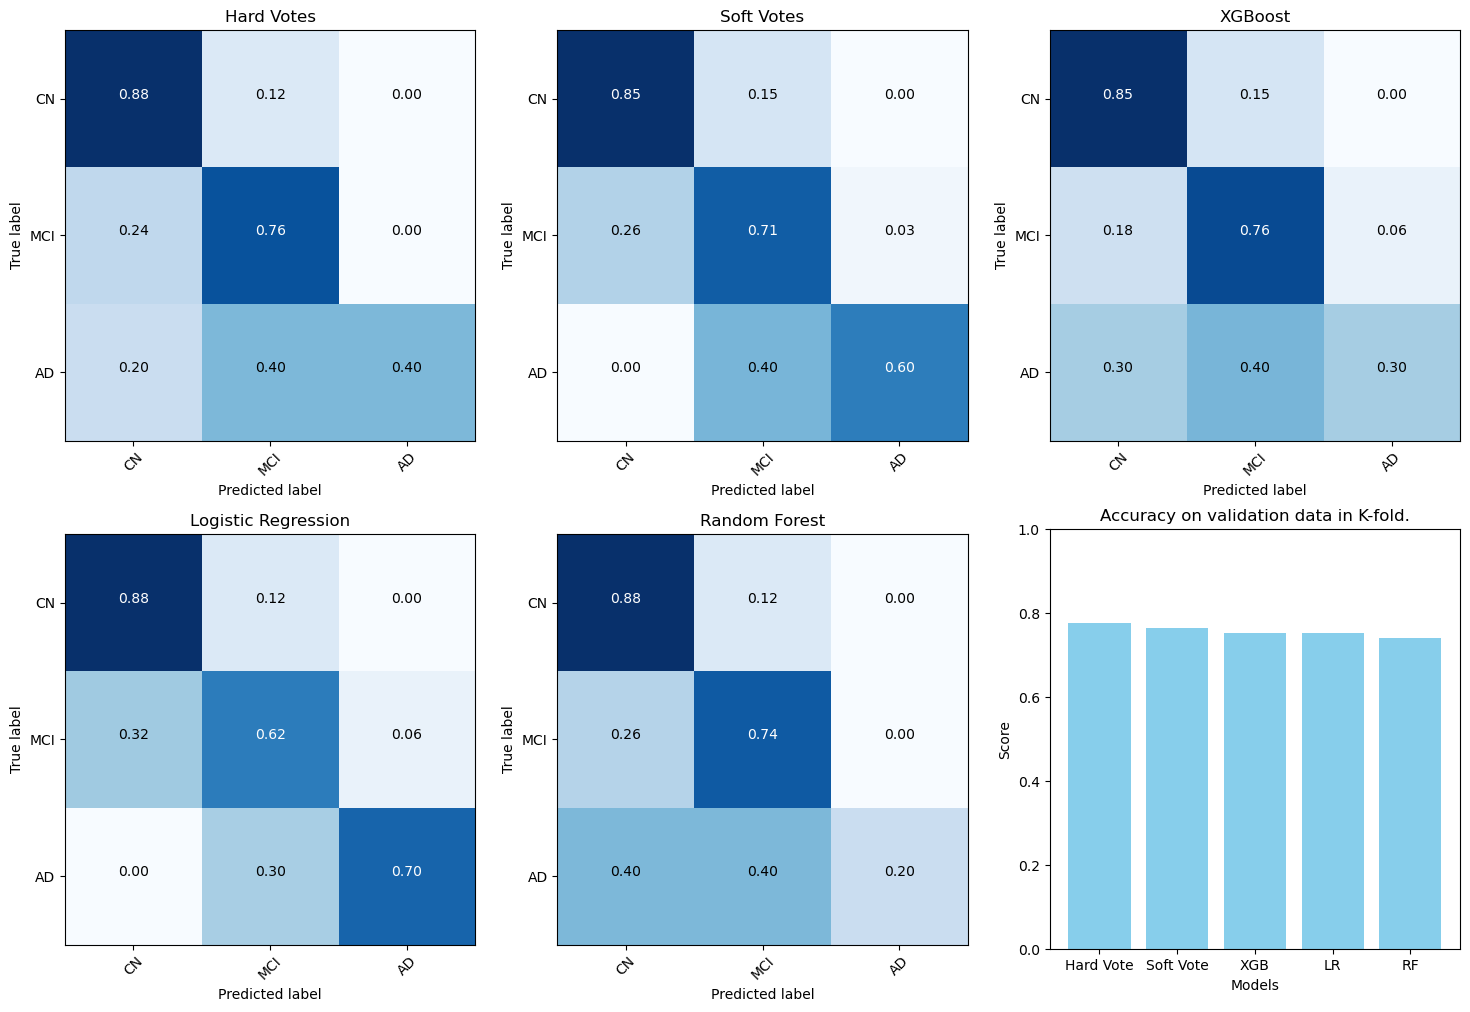

In [40]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 4

In [41]:
df_union_s4 = get_union_features(4, 15, df_pre)

In [42]:
all_models, votes, y_true = pipeline(df_union_s4, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 1.4365735054016113 seconds.

LR 0 started.
LR 0 is done in 2.2862350940704346 seconds.

RF 0 started.
RF 0 is done in 3.2925496101379395 seconds.

Hard vote F1 score: 0.44656084656084666
Soft vote F1 score: 0.5634920634920636

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.4064276218414307 seconds.

LR 1 started.
LR 1 is done in 2.2998528480529785 seconds.

RF 1 started.
RF 1 is done in 3.3358500003814697 seconds.

Hard vote F1 score: 0.6095238095238096
Soft vote F1 score: 0.6490299823633158

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.4405293464660645 seconds.

LR 2 started.
LR 2 is done in 2.1237711906433105 seconds.

RF 2 started.
RF 2 is done in 3.351414442062378 seconds.

Hard vote F1 score: 0.8994708994708994
Soft vote F1 score: 0.8994708994708994

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 

XGB       	AUC OVR: 0.8975220923898449  	AUC OVO: 0.8782161645145864  	ACC: 0.7294117647058823  	F1: 0.7222222222222223
LR        	AUC OVR: 0.904214693137809   	AUC OVO: 0.9007890961262554  	ACC: 0.8                 	F1: 0.7973920602723849
RF        	AUC OVR: 0.8696992245008955  	AUC OVO: 0.859349593495935   	ACC: 0.7176470588235294  	F1: 0.709757785467128
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7764705882352941  	F1: 0.7723519996455412
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7294117647058823  	F1: 0.7227376362807278


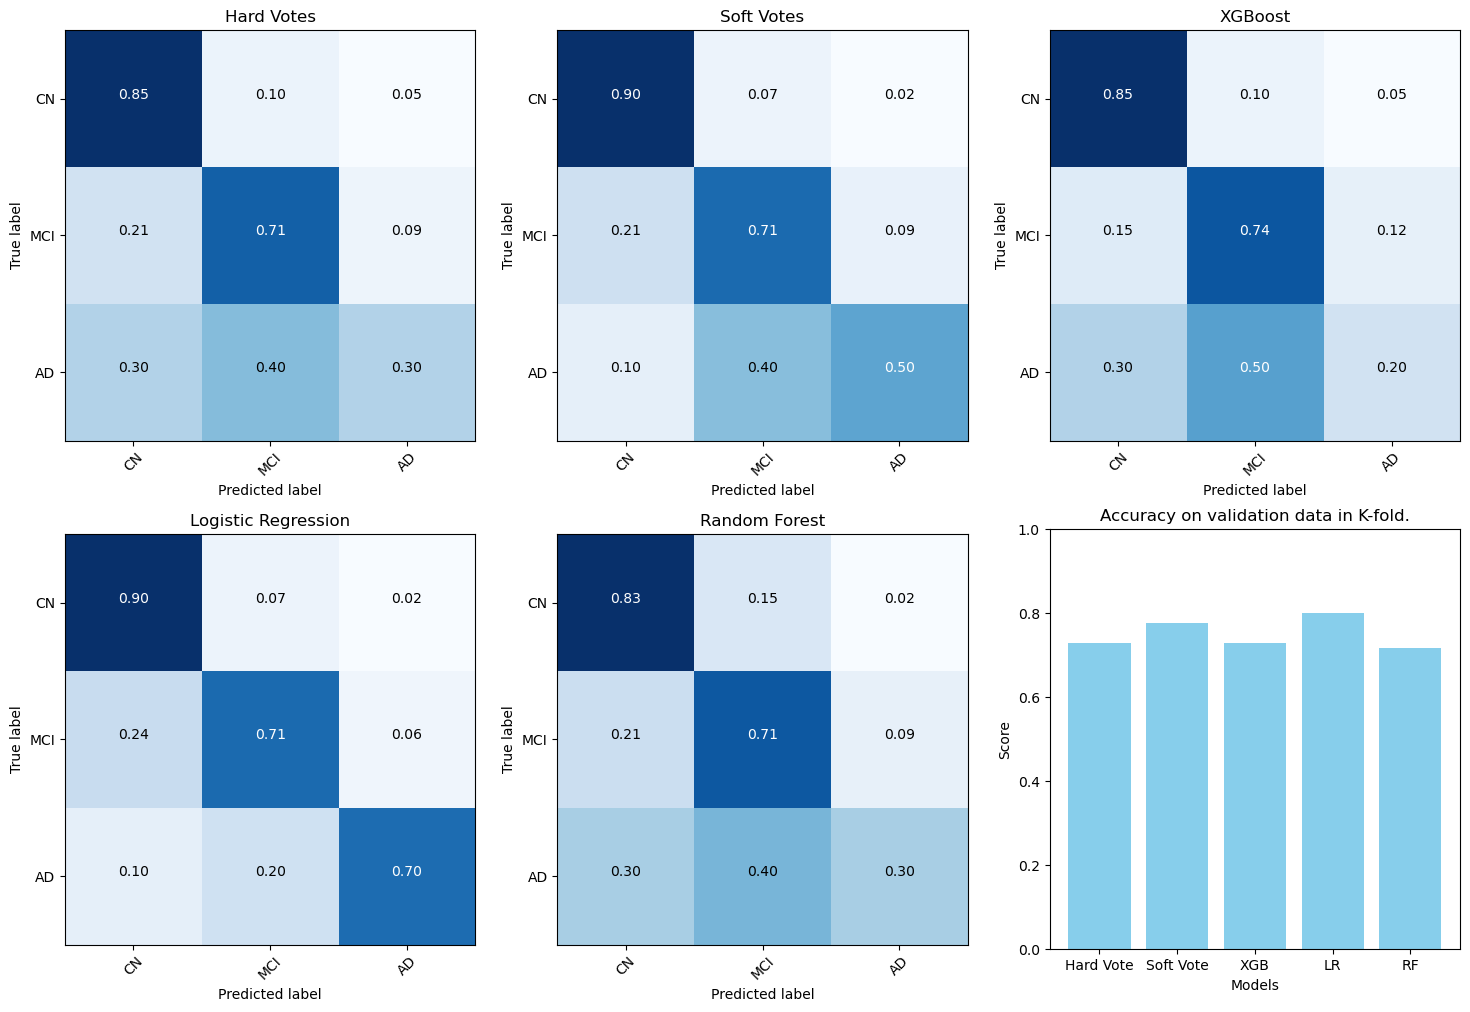

In [43]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 5

In [44]:
df_union_s5 = get_union_features(5, 15, df_pre)

In [45]:
all_models, votes, y_true = pipeline(df_union_s5, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 1.5231916904449463 seconds.

LR 0 started.
LR 0 is done in 2.5024161338806152 seconds.

RF 0 started.
RF 0 is done in 3.3853962421417236 seconds.

Hard vote F1 score: 0.8871252204585538
Soft vote F1 score: 0.8871252204585538

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.4785094261169434 seconds.

LR 1 started.
LR 1 is done in 2.2390544414520264 seconds.

RF 1 started.
RF 1 is done in 3.1968026161193848 seconds.

Hard vote F1 score: 0.7883597883597884
Soft vote F1 score: 0.7883597883597884

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.500361442565918 seconds.

LR 2 started.
LR 2 is done in 2.4962656497955322 seconds.

RF 2 started.
RF 2 is done in 3.3409788608551025 seconds.

Hard vote F1 score: 0.6772486772486772
Soft vote F1 score: 0.7883597883597884

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1

XGB       	AUC OVR: 0.8897755170065068  	AUC OVO: 0.87350549976088    	ACC: 0.7647058823529411  	F1: 0.7620182349175046
LR        	AUC OVR: 0.9486725300093517  	AUC OVO: 0.9389765662362506  	ACC: 0.8352941176470589  	F1: 0.834971524672247
RF        	AUC OVR: 0.8753517604946417  	AUC OVO: 0.8705224772835963  	ACC: 0.8235294117647058  	F1: 0.8126732646925799
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8352941176470589  	F1: 0.8339501058639419
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8117647058823529  	F1: 0.8071776024988001


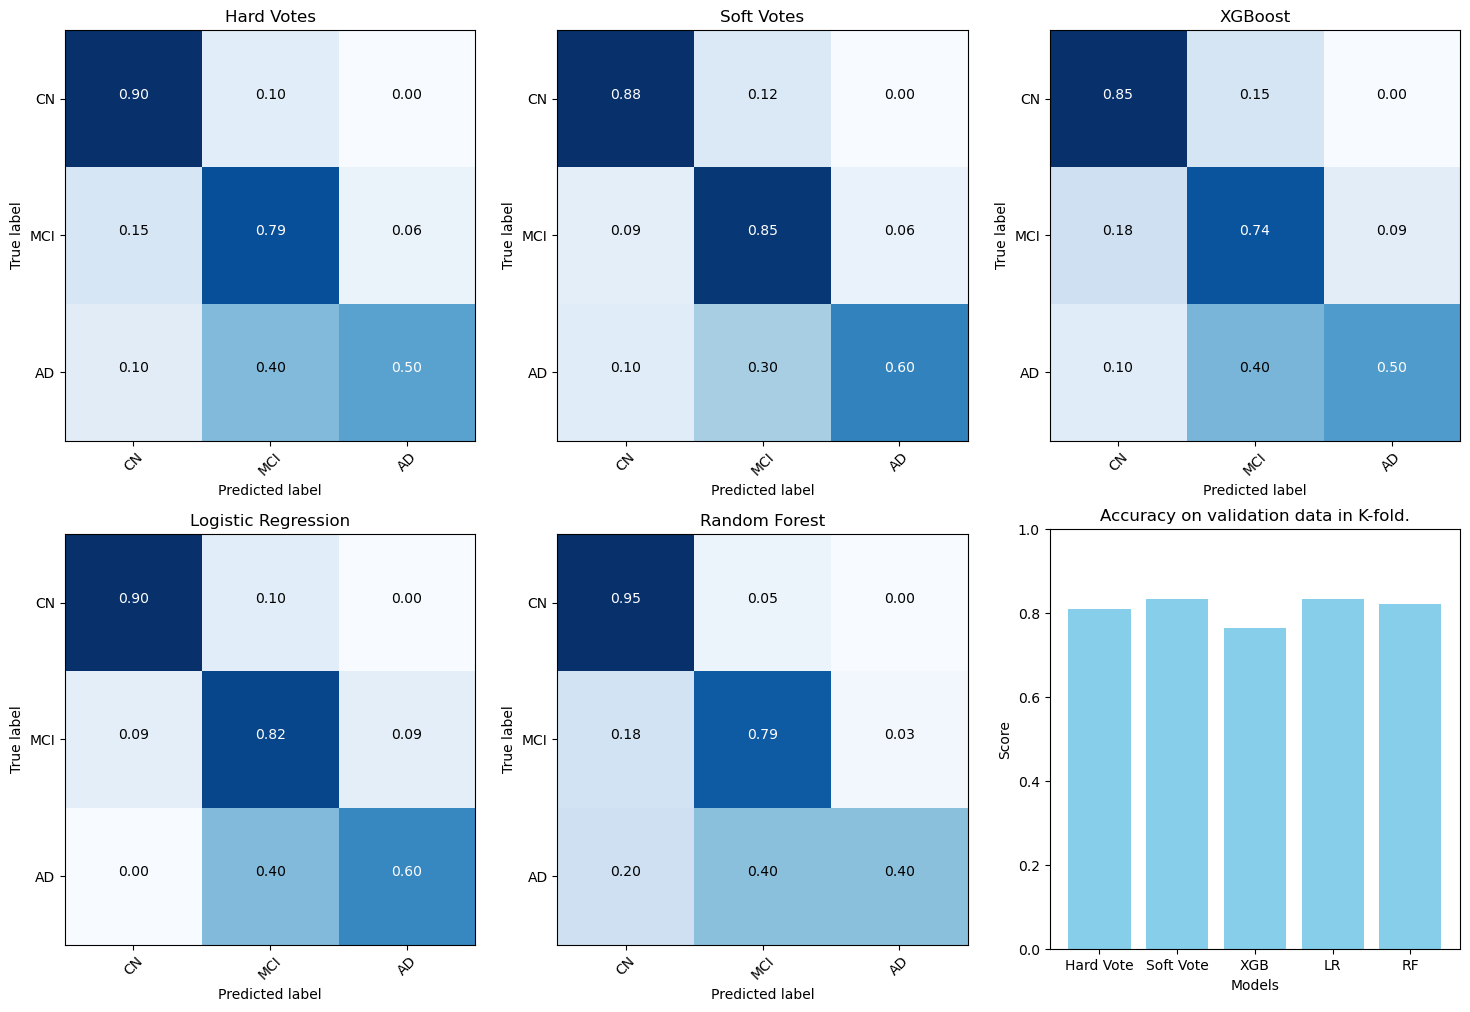

In [46]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 6

In [47]:
df_union_s6 = get_union_features(6, 15, df_pre)

In [48]:
all_models, votes, y_true = pipeline(df_union_s6, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 1.4986624717712402 seconds.

LR 0 started.
LR 0 is done in 2.4119415283203125 seconds.

RF 0 started.
RF 0 is done in 3.3445065021514893 seconds.

Hard vote F1 score: 0.7629629629629631
Soft vote F1 score: 0.8871252204585538

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.462148666381836 seconds.

LR 1 started.
LR 1 is done in 2.486846446990967 seconds.

RF 1 started.
RF 1 is done in 3.2677645683288574 seconds.

Hard vote F1 score: 0.5629629629629629
Soft vote F1 score: 0.5629629629629629

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.4291369915008545 seconds.

LR 2 started.
LR 2 is done in 2.5463287830352783 seconds.

RF 2 started.
RF 2 is done in 3.1480486392974854 seconds.

Hard vote F1 score: 0.8395061728395061
Soft vote F1 score: 0.8395061728395061

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1.

XGB       	AUC OVR: 0.8914926580344759  	AUC OVO: 0.8762553802008609  	ACC: 0.7411764705882353  	F1: 0.7365563623958283
LR        	AUC OVR: 0.9485376049293679  	AUC OVO: 0.9456958393113343  	ACC: 0.8235294117647058  	F1: 0.8242424242424242
RF        	AUC OVR: 0.8890203384166587  	AUC OVO: 0.8852702056432329  	ACC: 0.7176470588235294  	F1: 0.7124708093244346
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.788235294117647   	F1: 0.7856956115779645
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7529411764705882  	F1: 0.7534716301979729


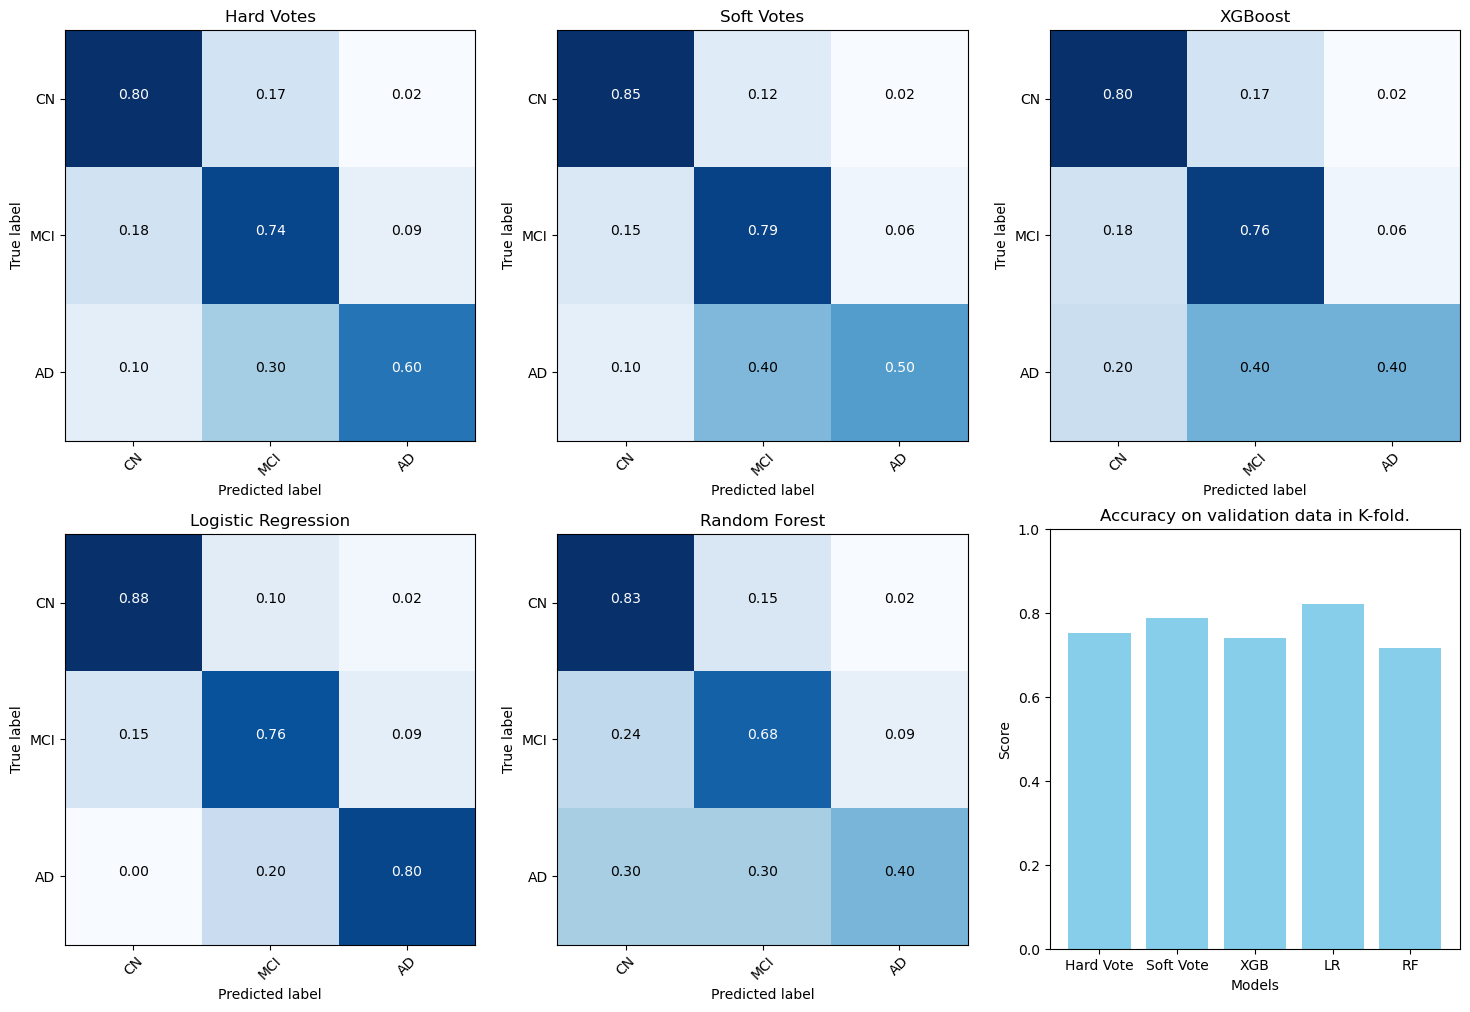

In [49]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 7

In [50]:
df_union_s7 = get_union_features(7, 15, df_pre)

In [51]:
all_models, votes, y_true = pipeline(df_union_s7, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 1.484473466873169 seconds.

LR 0 started.
LR 0 is done in 2.353736400604248 seconds.

RF 0 started.
RF 0 is done in 3.354530096054077 seconds.

Hard vote F1 score: 0.7365079365079364
Soft vote F1 score: 0.7365079365079364

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.4621782302856445 seconds.

LR 1 started.
LR 1 is done in 2.5450944900512695 seconds.

RF 1 started.
RF 1 is done in 3.2991557121276855 seconds.

Hard vote F1 score: 0.7283950617283951
Soft vote F1 score: 0.7283950617283951

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.5058841705322266 seconds.

LR 2 started.
LR 2 is done in 2.627568006515503 seconds.

RF 2 started.
RF 2 is done in 3.2455787658691406 seconds.

Hard vote F1 score: 0.8994708994708994
Soft vote F1 score: 1.0

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1.4910709857940674 

XGB       	AUC OVR: 0.8924636814597148  	AUC OVO: 0.8811214729794355  	ACC: 0.7529411764705882  	F1: 0.7454003436010357
LR        	AUC OVR: 0.9376163628009353  	AUC OVO: 0.9338833094213296  	ACC: 0.8352941176470589  	F1: 0.8340484429065743
RF        	AUC OVR: 0.8782398685138156  	AUC OVO: 0.874276661884266   	ACC: 0.7058823529411765  	F1: 0.6989026476420045
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8117647058823529  	F1: 0.8064171122994652
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7529411764705882  	F1: 0.7444262545121766


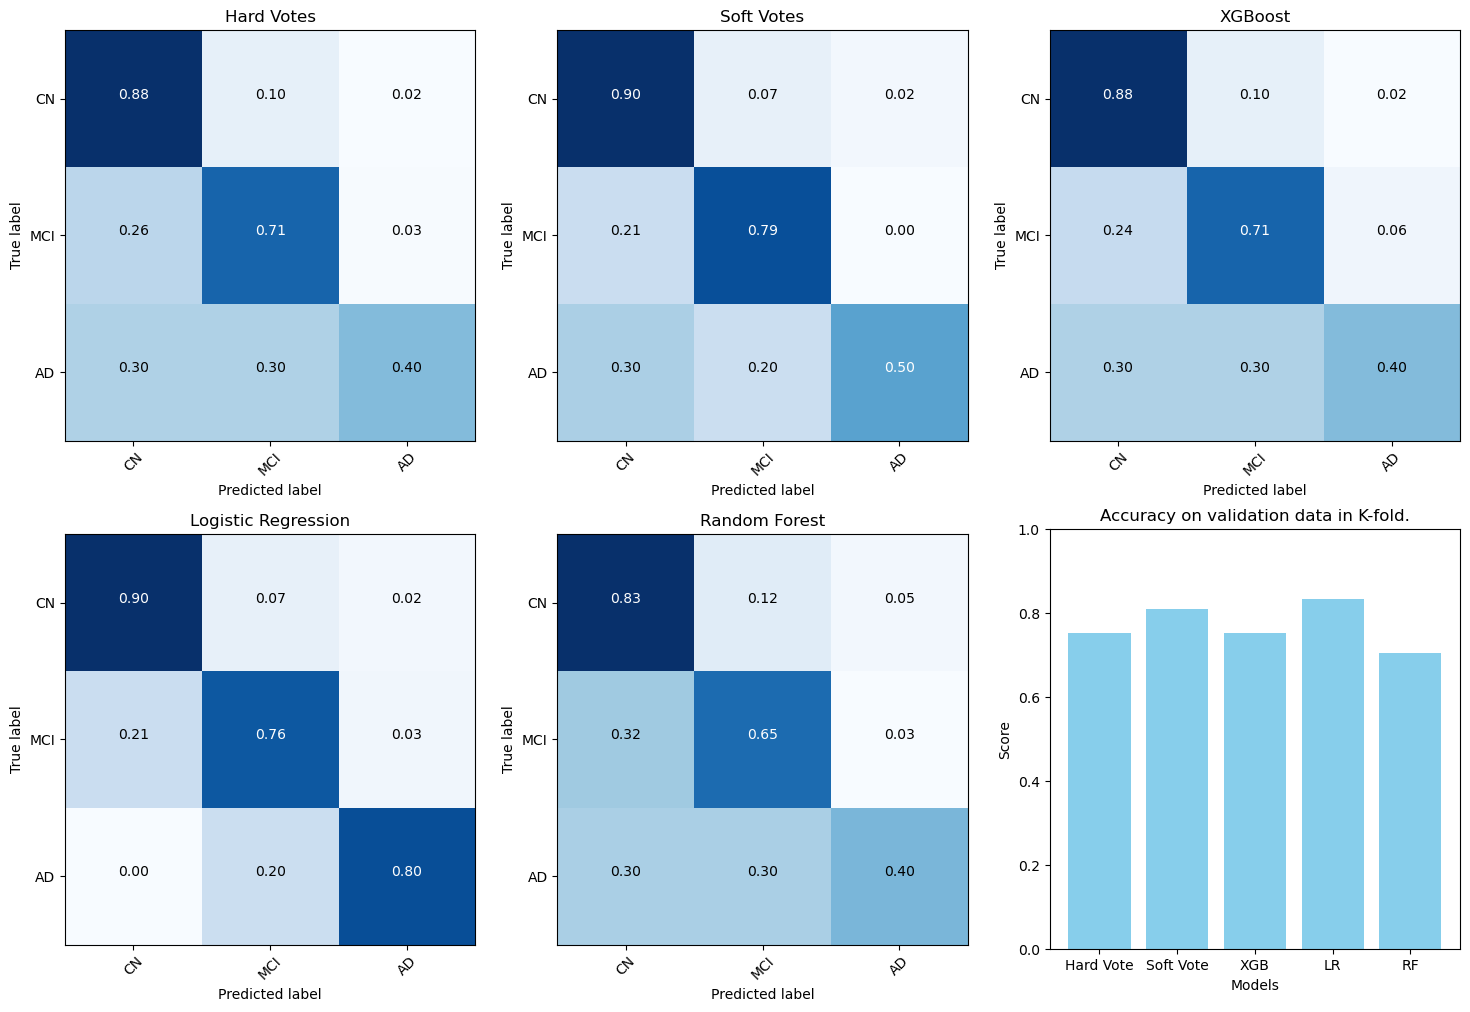

In [52]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 8

In [53]:
df_union_s8 = get_union_features(8, 15, df_pre)

In [54]:
all_models, votes, y_true = pipeline(df_union_s8, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 1.5298161506652832 seconds.

LR 0 started.
LR 0 is done in 2.630462884902954 seconds.

RF 0 started.
RF 0 is done in 3.1798715591430664 seconds.

Hard vote F1 score: 0.8395061728395061
Soft vote F1 score: 0.8395061728395061

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.4586682319641113 seconds.

LR 1 started.
LR 1 is done in 2.4552860260009766 seconds.

RF 1 started.
RF 1 is done in 3.175018548965454 seconds.

Hard vote F1 score: 0.6296296296296295
Soft vote F1 score: 0.6296296296296295

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.4414498805999756 seconds.

LR 2 started.
LR 2 is done in 2.4213836193084717 seconds.

RF 2 started.
RF 2 is done in 3.2653820514678955 seconds.

Hard vote F1 score: 0.8994708994708994
Soft vote F1 score: 1.0

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1.413810253143310

XGB       	AUC OVR: 0.9156418109698556  	AUC OVO: 0.906970349115256   	ACC: 0.8588235294117647  	F1: 0.8561461267710486
LR        	AUC OVR: 0.8367623726504645  	AUC OVO: 0.8305834528933526  	ACC: 0.7529411764705882  	F1: 0.7512605042016807
RF        	AUC OVR: 0.8533113982256526  	AUC OVO: 0.8435856049736968  	ACC: 0.7647058823529411  	F1: 0.7553475935828877
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8                 	F1: 0.7949094829747756
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8117647058823529  	F1: 0.8092436974789917


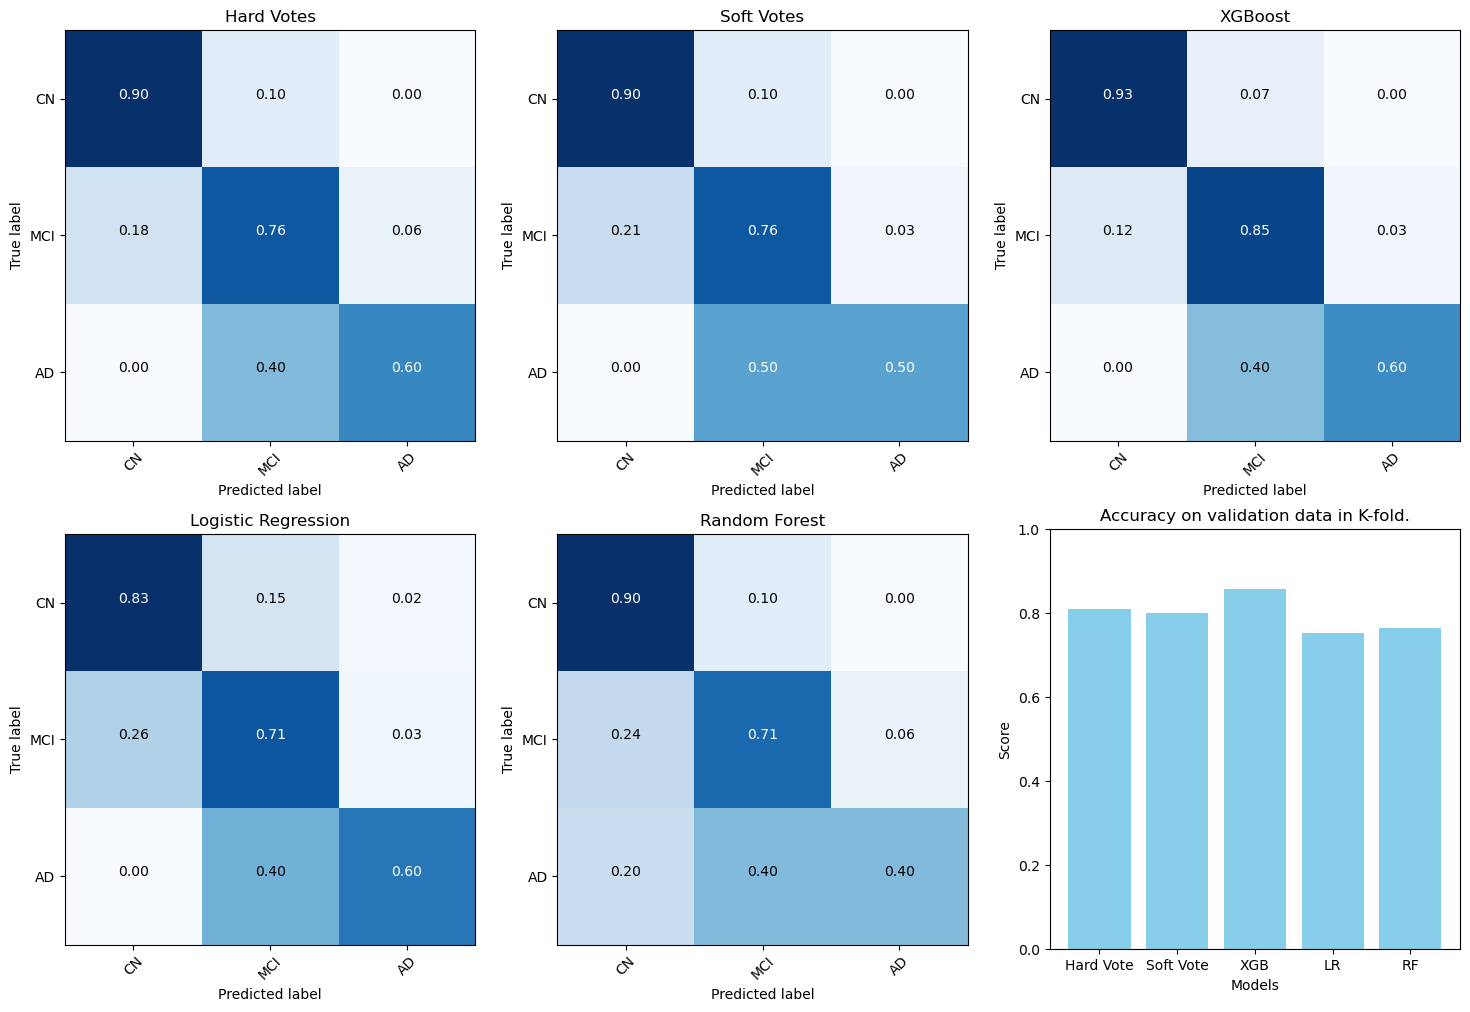

In [55]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 9

In [56]:
df_union_s9 = get_union_features(9, 15, df_pre)

In [57]:
all_models, votes, y_true = pipeline(df_union_s9, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 1.5723118782043457 seconds.

LR 0 started.
LR 0 is done in 2.5266060829162598 seconds.

RF 0 started.
RF 0 is done in 3.386369466781616 seconds.

Hard vote F1 score: 0.5206349206349207
Soft vote F1 score: 0.5206349206349207

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.5221812725067139 seconds.

LR 1 started.
LR 1 is done in 2.637876033782959 seconds.

RF 1 started.
RF 1 is done in 3.2813310623168945 seconds.

Hard vote F1 score: 0.4232804232804233
Soft vote F1 score: 0.5555555555555556

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.5404253005981445 seconds.

LR 2 started.
LR 2 is done in 2.3403587341308594 seconds.

RF 2 started.
RF 2 is done in 3.327735424041748 seconds.

Hard vote F1 score: 0.8395061728395061
Soft vote F1 score: 0.7365079365079364

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1.4

XGB       	AUC OVR: 0.9093551550614594  	AUC OVO: 0.9022596843615495  	ACC: 0.7764705882352941  	F1: 0.7688586154330098
LR        	AUC OVR: 0.9060876517730261  	AUC OVO: 0.9019846963175514  	ACC: 0.7647058823529411  	F1: 0.7657225853304285
RF        	AUC OVR: 0.8829046895659268  	AUC OVO: 0.884337637494022   	ACC: 0.7764705882352941  	F1: 0.7714774281805747
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7764705882352941  	F1: 0.7750901303423413
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.788235294117647   	F1: 0.7842312879420623


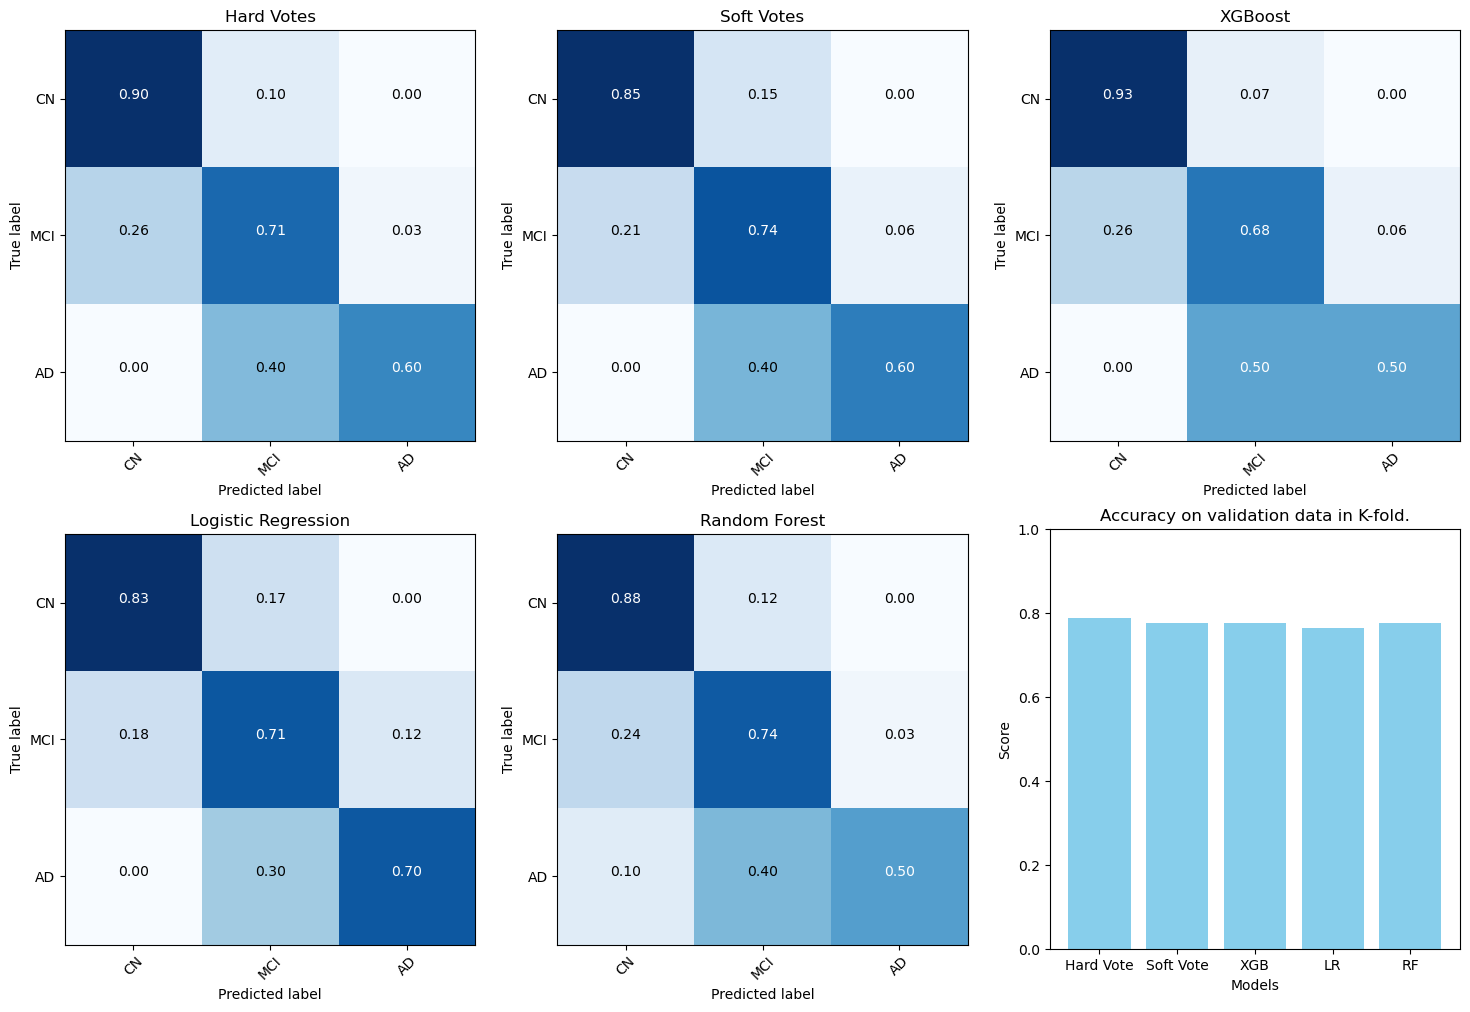

In [58]:
get_scores(all_models, votes, y_true, get_graphs=True)

## 10   

In [59]:
df_union_s10 = get_union_features(10, 15, df_pre)

In [60]:
all_models, votes, y_true = pipeline(df_union_s10, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 1.4873321056365967 seconds.

LR 0 started.
LR 0 is done in 2.3922622203826904 seconds.

RF 0 started.
RF 0 is done in 3.2010629177093506 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 1.0

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 1.485316276550293 seconds.

LR 1 started.
LR 1 is done in 2.321532726287842 seconds.

RF 1 started.
RF 1 is done in 3.350053071975708 seconds.

Hard vote F1 score: 0.8395061728395061
Soft vote F1 score: 0.8395061728395061

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 1.6031486988067627 seconds.

LR 2 started.
LR 2 is done in 2.3977346420288086 seconds.

RF 2 started.
RF 2 is done in 3.4759621620178223 seconds.

Hard vote F1 score: 0.6095238095238096
Soft vote F1 score: 0.7283950617283951

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 1.4964275360107422 seconds.

LR 3

XGB       	AUC OVR: 0.8976128164930595  	AUC OVO: 0.8777498804399807  	ACC: 0.8117647058823529  	F1: 0.8040827289820037
LR        	AUC OVR: 0.9274948557223855  	AUC OVO: 0.9168340506934481  	ACC: 0.788235294117647   	F1: 0.7851942102441639
RF        	AUC OVR: 0.8652539326934635  	AUC OVO: 0.8571915351506457  	ACC: 0.7764705882352941  	F1: 0.7684111784248584
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8470588235294118  	F1: 0.8413725490196078
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8352941176470589  	F1: 0.8303395853505157


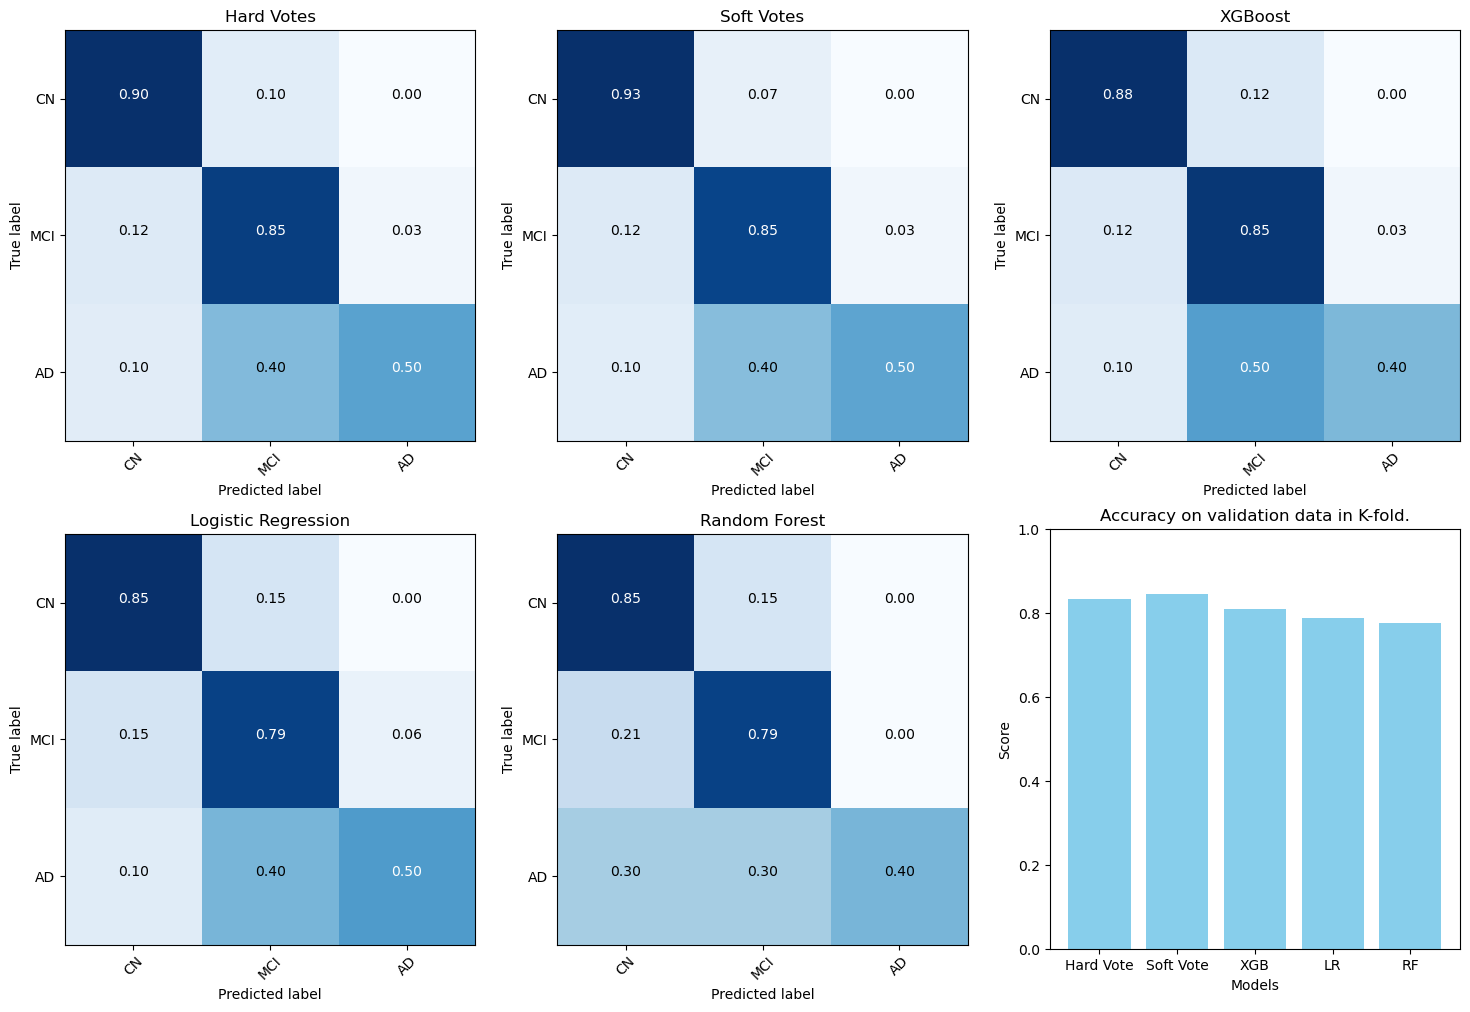

In [61]:
get_scores(all_models, votes, y_true, get_graphs=True)

## Consistency

In [62]:
all_union = list(df_union_s1.columns) + list(df_union_s2.columns) + list(df_union_s3.columns) + list(df_union_s4.columns) + list(df_union_s5.columns) + list(df_union_s6.columns) + list(df_union_s7.columns) + list(df_union_s8.columns) + list(df_union_s9.columns) + list(df_union_s10.columns)
feature_count = Counter(all_union)

In [63]:
feature_count

Counter({'P47972..419.427.': 10,
         'P12259..926.935.': 10,
         'Q495W5..254.273.': 10,
         'P01766..106.116.': 10,
         'Q9NQ79..573.585.': 10,
         'P08637..116.127.': 10,
         'P01876..332.353.': 10,
         'P10745..937.946.': 10,
         'O14791..160.167.': 10,
         'P0C0L4..980.1005...P0C0L5..980.1005.': 10,
         'P27169..47.70.': 10,
         'P51864..105.111.': 10,
         'P10645..295.303.': 10,
         'Q9UBX7..112.119.': 10,
         'Q8N6Q3..264.275.': 10,
         'P53041..223.232.': 10,
         'Q8NBJ4..249.267.': 10,
         'P78509..2165.2181.': 10,
         'P02788..93.105.': 10,
         'P02768..215.221.': 10,
         'P22692..150.155.': 10,
         'A0A0C4DH26..70.81.': 10,
         'Q07954..508.517.': 10,
         'P0DMV9..302.311.': 10,
         'Q9NY47..103.114.': 10,
         'Q05707..262.270.': 10,
         'Q9H173..37.45.': 10,
         'P51693..526.539.': 10,
         'O00241..125.134...P78324..126.135.': 10,
      

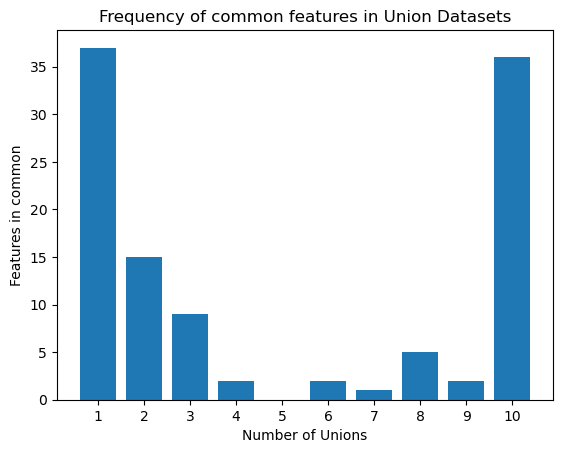

In [64]:
counter_data = feature_count

frequencies = list(counter_data.values())

# Count the occurrences of each frequency
frequency_counts = Counter(frequencies)

# Prepare data for plotting
count_values = list(frequency_counts.keys())
counts_occurrences = list(frequency_counts.values())

# Plot the histogram
plt.bar(count_values, counts_occurrences)
plt.xlabel('Number of Unions')
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.ylabel('Features in common')
plt.title('Frequency of common features in Union Datasets')
plt.show()

In [65]:
filtered_features = {word: count for word, count in feature_count.items() if count > 9}

In [66]:
aa = set(filtered_features.keys())

In [79]:
list(aa)

['Q495W5..254.273.',
 'P12259..926.935.',
 'P47972..419.427.',
 'P01766..106.116.',
 'Q9NQ79..573.585.',
 'P08637..116.127.',
 'P01876..332.353.',
 'P10745..937.946.',
 'O14791..160.167.',
 'P0C0L4..980.1005...P0C0L5..980.1005.',
 'P27169..47.70.',
 'P51864..105.111.',
 'P10645..295.303.',
 'Q9UBX7..112.119.',
 'Q8N6Q3..264.275.',
 'P53041..223.232.',
 'Q8NBJ4..249.267.',
 'P78509..2165.2181.',
 'P02788..93.105.',
 'P02768..215.221.',
 'P22692..150.155.',
 'A0A0C4DH26..70.81.',
 'Q07954..508.517.',
 'P0DMV9..302.311.',
 'Q9NY47..103.114.',
 'Q05707..262.270.',
 'Q9H173..37.45.',
 'P51693..526.539.',
 'O00241..125.134...P78324..126.135.',
 'Q99435..801.816.',
 'P19827..171.180.',
 'P10643..279.293.',
 'Q9NPH3..125.134.',
 'P07339..349.357.',
 'P00450..485.500.',
 'Q9Y2E5..82.93.']

In [ ]:
['P47972..419.427.', 'P12259..926.935.', 'Q495W5..254.273.', 'P02768..211.219.', 'P01766..106.116.', 'Q9NQ79..573.585.', 'P04271..35.49.', 'Q9NQ79..383.403.', 'P08637..116.127.', 'P01876..332.353.', 'Q01151..52.59.', 'P10745..937.946.', 'O14791..160.167.', 'P0C0L4..980.1005...P0C0L5..980.1005.', 'Q16658..186.194.', 'P27169..47.70.', 'P00739..79.95...P00738..137.153.', 'P10643..737.744.', 'P78333..464.472.', 'P51864..105.111.', 'Q86UX2..387.396.', 'P10645..295.303.', 'P09525..310.319.', 'Q9UBX7..112.119.', 'Q8N6Q3..264.275.', 'P35555..2473.2481.', 'O95336..198.208.', 'P53041..223.232.', 'Q8NBJ4..249.267.', 'P78509..2165.2181.', 'P08123..1206.1214.', 'P02788..93.105.', 'P02768..215.221.', 'P22692..150.155.', 'A0A0C4DH26..70.81.', 'Q07954..508.517.', 'P01019..158.167.', 'P0DMV9..302.311.', 'Q9NY47..103.114.', 'Q05707..262.270.', 'Q9H173..37.45.', 'P51693..526.539.', 'O00241..125.134...P78324..126.135.', 'Q99435..801.816.', 'P19827..171.180.', 'Q92820..54.62.', 'P10643..279.293.', 'P22314..305.322.', 'Q9NPH3..125.134.', 'Q96HD1..51.58.', 'P07339..349.357.', 'P00533..73.80.', 'P00450..485.500.', 'Q9Y2E5..82.93.']

C:\Users\Toffe\AppData\Local\Temp\ipykernel_9604\2053330001.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


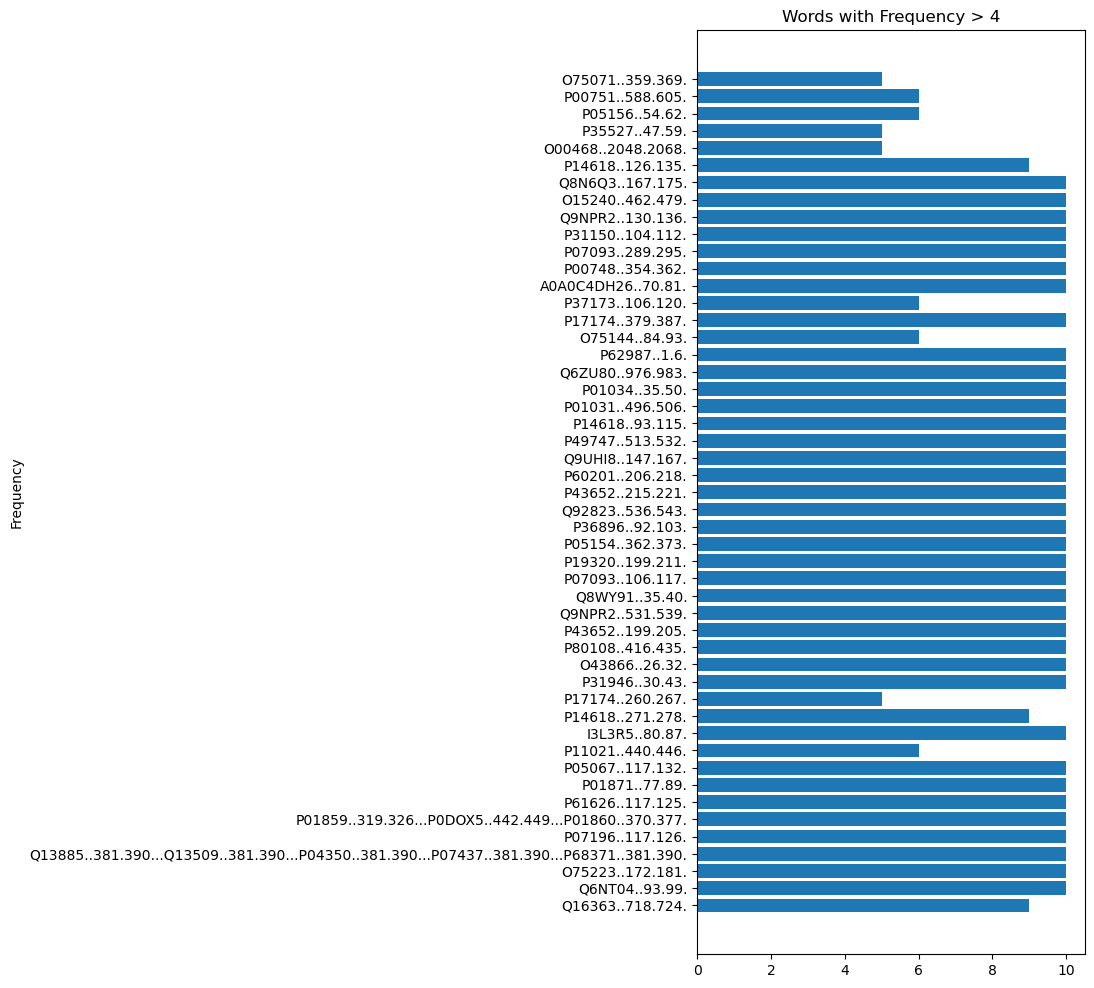

In [53]:
min_frequency = 4
filtered_features = {word: count for word, count in feature_count.items() if count > min_frequency}

words = list(filtered_features.keys())
counts = list(filtered_features.values())

# Plotting
plt.figure(figsize=(5, 12))
plt.barh(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Words with Frequency > {min_frequency}')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

In [62]:
protein_lumbar_features_all = list(filtered_features.keys())

In [63]:
protein_lumbar_features_all

['O14960',
 'P31948',
 'P02533',
 'P01624',
 'Q16799',
 'Q9UP79',
 'P31949',
 'Q86VR8',
 'A0A087WSZ0',
 'P04003',
 'P05107',
 'Q86XE0',
 'Q9NVA2',
 'P02656',
 'Q9BUD6',
 'P61981',
 'Q9NPH3',
 'P01766',
 'O95196',
 'P00995',
 'Q13508',
 'P15848',
 'P15502',
 'Q9UJ90',
 'Q8TDF5',
 'O15232',
 'Q07812',
 'Q56P03',
 'O75339',
 'P15291',
 'Q12765',
 'P63104',
 'P61626',
 'P06753',
 'P81605',
 'Q08257']

In [ ]:
['O14960', 'P31948', 'P02533', 'P01624', 'Q16799', 'Q9UP79', 'P31949', 'Q86VR8', 'A0A087WSZ0', 'P04003', 'P05107', 'Q86XE0', 'Q9NVA2', 'P02656', 'Q9BUD6', 'P61981', 'Q9NPH3', 'P01766', 'O95196', 'P00995', 'Q13508', 'P15848', 'P15502', 'Q9UJ90', 'Q8TDF5', 'O15232', 'Q07812', 'Q56P03', 'O75339', 'P15291', 'Q12765', 'P63104', 'P61626', 'P06753', 'P81605', 'Q08257']

# Presentation

## CN vs MCI/AD

### CN vs ALL Union

In [205]:
y_cnVSall = y.replace(2, 1)

In [206]:
all_models0, votes0, y_true0 = pipeline(df_union, y_cnVSall, params_grid, tmt_set, n_samples_per_class=45, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 0.5156116485595703 seconds.

LR 0 started.
LR 0 is done in 1.5162904262542725 seconds.

RF 0 started.
RF 0 is done in 3.161386489868164 seconds.

Hard vote F1 score: 0.8888888888888888
Soft vote F1 score: 0.8888888888888888

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 0.5444238185882568 seconds.

LR 1 started.
LR 1 is done in 1.4664459228515625 seconds.

RF 1 started.
RF 1 is done in 3.2016918659210205 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 1.0

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 0.49855899810791016 seconds.

LR 2 started.
LR 2 is done in 1.4289047718048096 seconds.

RF 2 started.
RF 2 is done in 3.182356595993042 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 1.0

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 0.5010168552398682 seconds.

LR 3 started.
LR 3 is done in 1.

#### Results

In [207]:
hard_votes = [item for sublist in [value for key, value in votes0.items() if key.startswith('Hard')] for item in sublist]
soft_votes0 = [item for sublist in [value for key, value in votes0.items() if key.startswith('Soft')] for item in sublist]
xgb_votes = [item for sublist in [value.prediction for key, value in all_models0.items() if key.startswith('XGB')] for item in sublist]
lr_votes = [item for sublist in [value.prediction for key, value in all_models0.items() if key.startswith('LR')] for item in sublist]
rf_votes = [item for sublist in [value.prediction for key, value in all_models0.items() if key.startswith('RF')] for item in sublist]
xgb_prob = [item for sublist in [value.probability for key, value in all_models0.items() if key.startswith('XGB')] for item in sublist]
lr_prob = [item for sublist in [value.probability for key, value in all_models0.items() if key.startswith('LR')] for item in sublist]
rf_prob = [item for sublist in [value.probability for key, value in all_models0.items() if key.startswith('RF')] for item in sublist]
y_trues0 = [item for sublist in [list(series) for series in y_true0.values()] for item in sublist]

In [208]:
f1_score(y_trues0, soft_votes0)

0.8735632183908046

In [209]:
confusion_matrix(y_trues0, soft_votes0)

array([[36,  5],
       [ 6, 38]], dtype=int64)

### AD vs ALL Union

In [210]:
y_ADVSall = y.replace(1, 0)
y_ADVSall = y_ADVSall.replace(2,1)

In [211]:
all_models1, votes1, y_true1 = pipeline(df_union, y_ADVSall, params_grid, tmt_set, n_samples_per_class=75, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.


XGB 0 is done in 0.698354959487915 seconds.

LR 0 started.
LR 0 is done in 1.9539780616760254 seconds.

RF 0 started.
RF 0 is done in 3.2719199657440186 seconds.

Hard vote F1 score: 0.9037037037037037
Soft vote F1 score: 0.9037037037037037

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 0.6838564872741699 seconds.

LR 1 started.
LR 1 is done in 1.9125611782073975 seconds.

RF 1 started.
RF 1 is done in 3.314260959625244 seconds.

Hard vote F1 score: 0.8366013071895425
Soft vote F1 score: 0.8366013071895425

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 0.6408765316009521 seconds.

LR 2 started.
LR 2 is done in 1.9052975177764893 seconds.

RF 2 started.
RF 2 is done in 3.2706096172332764 seconds.

Hard vote F1 score: 0.7777777777777778
Soft vote F1 score: 0.7777777777777778

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 0.672431468963623 seconds.

LR 3 started.
LR 3 is done in 2.0117199420928955 seconds.

RF 3 started.
RF 3 is done i

#### Results

In [212]:
hard_votes = [item for sublist in [value for key, value in votes1.items() if key.startswith('Hard')] for item in sublist]
soft_votes1 = [item for sublist in [value for key, value in votes1.items() if key.startswith('Soft')] for item in sublist]
xgb_votes = [item for sublist in [value.prediction for key, value in all_models1.items() if key.startswith('XGB')] for item in sublist]
lr_votes = [item for sublist in [value.prediction for key, value in all_models1.items() if key.startswith('LR')] for item in sublist]
rf_votes = [item for sublist in [value.prediction for key, value in all_models1.items() if key.startswith('RF')] for item in sublist]
xgb_prob = [item for sublist in [value.probability for key, value in all_models1.items() if key.startswith('XGB')] for item in sublist]
lr_prob = [item for sublist in [value.probability for key, value in all_models1.items() if key.startswith('LR')] for item in sublist]
rf_prob = [item for sublist in [value.probability for key, value in all_models1.items() if key.startswith('RF')] for item in sublist]
y_trues1 = [item for sublist in [list(series) for series in y_true1.values()] for item in sublist]

In [213]:
f1_score(y_trues1, soft_votes1)

0.6

In [214]:
confusion_matrix(y_trues1, soft_votes1)

array([[71,  4],
       [ 4,  6]], dtype=int64)

## Exclude TMT set 7

In [230]:
exclude7 = tmt_set != 7
y_exclude7 = y[exclude7].reset_index(drop=True)
df_union_exclude7 = df_union[exclude7].reset_index(drop=True)
tmt_set_exclude7 = tmt_set[exclude7].reset_index(drop=True)

In [235]:
all_models, votes, y_true = pipeline(df_union_exclude7, y_exclude7, params_bayes, tmt_set_exclude7, n_samples_per_class=39, bayes=True, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


XGB 0 is done in 115.16574478149414 seconds.

LR 0 started.
LR 0 is done in 103.14861965179443 seconds.

RF 0 started.
RF 0 is done in 106.2651309967041 seconds.

Hard vote F1 score: 0.7395833333333333
Soft vote F1 score: 0.875

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 113.41488361358643 seconds.

LR 1 started.
LR 1 is done in 102.57497310638428 seconds.

RF 1 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 'log2', 1, 500, -1] before, using random point ['gini', 31, 'sqrt', 3, 111, -1]
  warnings.warn(


RF 1 is done in 115.36638927459717 seconds.

Hard vote F1 score: 0.6944444444444444
Soft vote F1 score: 0.8214285714285714

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 100.4836790561676 seconds.

LR 2 started.
LR 2 is done in 88.8968117237091 seconds.

RF 2 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 'sqrt', 1, 500, -1] before, using random point ['entropy', 39, 'log2', 3, 99, -1]
  warnings.warn(


RF 2 is done in 111.63849472999573 seconds.

Hard vote F1 score: 0.7152777777777778
Soft vote F1 score: 0.5875

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 112.29658842086792 seconds.

LR 3 started.
LR 3 is done in 101.25181031227112 seconds.

RF 3 started.
RF 3 is done in 109.42573595046997 seconds.

Hard vote F1 score: 0.75
Soft vote F1 score: 0.886904761904762

K-Fold validation: Iteration 4.
XGB 4 started.
XGB 4 is done in 127.59309196472168 seconds.

LR 4 started.
LR 4 is done in 91.16096591949463 seconds.

RF 4 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 'log2', 1, 500, -1] before, using random point ['gini', 29, 'sqrt', 2, 116, -1]
  warnings.warn(


RF 4 is done in 111.60790729522705 seconds.

Hard vote F1 score: 0.75
Soft vote F1 score: 0.8214285714285714

K-Fold validation: Iteration 5.
XGB 5 started.
XGB 5 is done in 108.07306575775146 seconds.

LR 5 started.
LR 5 is done in 105.40991449356079 seconds.

RF 5 started.
RF 5 is done in 110.95885372161865 seconds.

Hard vote F1 score: 0.7152777777777778
Soft vote F1 score: 0.7152777777777778

K-Fold validation: Iteration 6.
XGB 6 started.
XGB 6 is done in 225.27687692642212 seconds.

LR 6 started.
LR 6 is done in 244.73736786842346 seconds.

RF 6 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 'log2', 1, 497, -1] before, using random point ['gini', 48, 'sqrt', 4, 54, -1]
  warnings.warn(


RF 6 is done in 233.94301533699036 seconds.

Hard vote F1 score: 0.8694444444444445
Soft vote F1 score: 0.8694444444444445

K-Fold validation: Iteration 7.
XGB 7 started.
XGB 7 is done in 228.06378269195557 seconds.

LR 7 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [100.0, 0.0, 1000, 'multinomial', -1, 'elasticnet', 'saga', 0.0001] before, using random point [83.94095561944962, 0.5363265909173134, 7999, 'multinomial', -1, 'elasticnet', 'saga', 0.0058847301912188016]
  warnings.warn(


LR 7 is done in 202.93882036209106 seconds.

RF 7 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 'log2', 1, 500, -1] before, using random point ['entropy', 14, 'sqrt', 3, 60, -1]
  warnings.warn(


RF 7 is done in 205.90435552597046 seconds.

Hard vote F1 score: 0.6944444444444444
Soft vote F1 score: 0.8694444444444445

K-Fold validation: Iteration 8.
XGB 8 started.
XGB 8 is done in 192.5226616859436 seconds.

LR 8 started.
LR 8 is done in 197.45206689834595 seconds.

RF 8 started.
RF 8 is done in 214.08219122886658 seconds.

Hard vote F1 score: 0.7395833333333333
Soft vote F1 score: 0.875

K-Fold validation: Iteration 9.
XGB 9 started.
XGB 9 is done in 249.50649762153625 seconds.

LR 9 started.
LR 9 is done in 114.93323063850403 seconds.

RF 9 started.
RF 9 is done in 198.57573199272156 seconds.

Hard vote F1 score: 0.7222222222222222
Soft vote F1 score: 0.7222222222222222



XGB       	AUC OVR: 0.8890024551314873  	AUC OVO: 0.8878320007352265  	ACC: 0.7341772151898734  	F1: 0.7343276691316852
LR        	AUC OVR: 0.9262856617695329  	AUC OVO: 0.9147749900438072  	ACC: 0.810126582278481   	F1: 0.8083770711124834
RF        	AUC OVR: 0.9007510634526762  	AUC OVO: 0.9129905339582759  	ACC: 0.7721518987341772  	F1: 0.7705269657626623
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8227848101265823  	F1: 0.8204106040608614
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.759493670886076   	F1: 0.7567583670506924


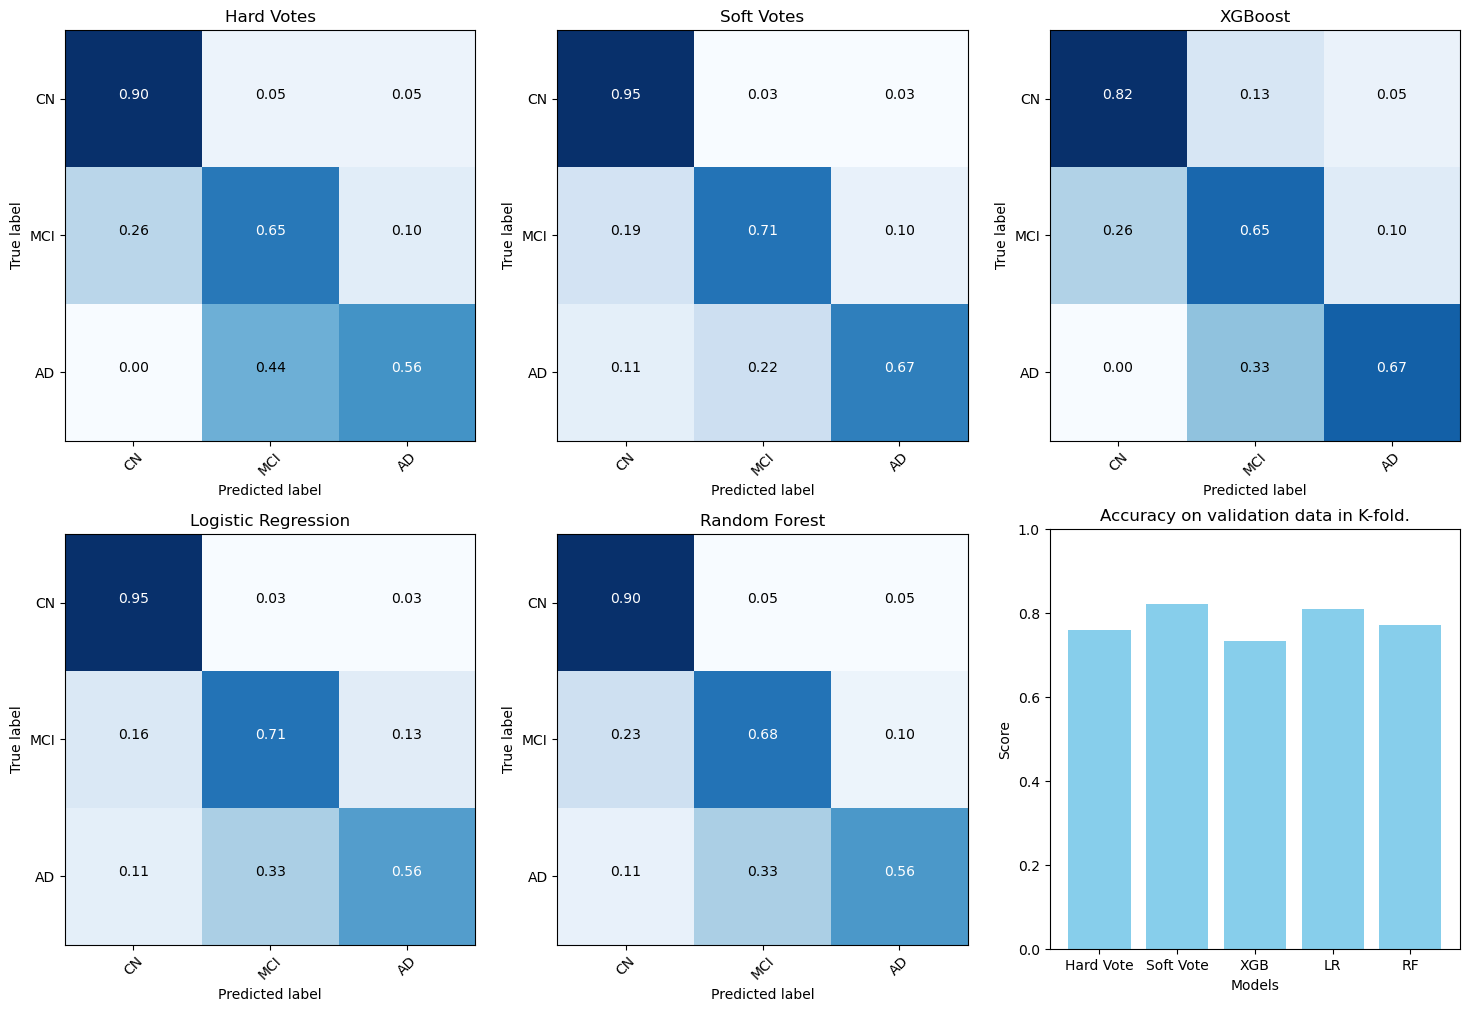

In [236]:
get_scores(all_models, votes, y_true, get_graphs=True)

## Best Features (??)

In [28]:
df_union =  df_main[['P15848', 'P50502', 'Q9NVA2', 'P14618', 'P05107', 'P15291', 'Q6ZRP7',
       'Q86XE0', 'O14960', 'Q9Y2G1', 'P52888', 'Q9BUD6', 'Q9NPH3', 'Q08554',
       'O15232', 'P01766', 'P15502', 'A0A087WSZ0', 'O75339', 'Q56P03',
       'Q9UL62', 'Q9UP79', 'P31949', 'P61626', 'P81605', 'Q16799', 'O95965',
       'P00995', 'Q15121', 'P11047', 'O95196', 'P06753', 'Q07812', 'P36955',
       'P32971', 'P61981', 'Q86VR8', 'P01624', 'P02656', 'Q8TDF5', 'Q9UJ90',
       'P04003', 'Q13508', 'Q9NS84', 'P31948', 'Q12765', 'A0A075B6Q5',
       'P02533', 'Q9UJ99', 'Q99941', 'Q08257', 'P63104', 'Q6UVY6']]

In [30]:
all_models, votes, y_true = pipeline(df_union, y, params_bayes, tmt_set, bayes=True, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 113.04412293434143 seconds.

LR 0 started.
LR 0 is done in 106.6319043636322 seconds.

RF 0 started.
RF 0 is done in 208.3224937915802 seconds.

Hard vote F1 score: 0.8871252204585538
Soft vote F1 score: 0.8871252204585538

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 228.3112485408783 seconds.

LR 1 started.
LR 1 is done in 208.46957659721375 seconds.

RF 1 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 9, 'sqrt', 1, 50, -1] before, using random point ['entropy', 19, 'log2', 4, 392, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 'log2', 1, 500, -1] before, using random point ['gini', 12, 'sqrt', 5, 126, -1]
  warnings.warn(


RF 1 is done in 244.73727989196777 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 0.8871252204585538

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 236.025865316391 seconds.

LR 2 started.
LR 2 is done in 219.89403414726257 seconds.

RF 2 started.
RF 2 is done in 224.98514246940613 seconds.

Hard vote F1 score: 0.7654320987654322
Soft vote F1 score: 0.7654320987654322

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 243.71027445793152 seconds.

LR 3 started.
LR 3 is done in 220.46110010147095 seconds.

RF 3 started.
RF 3 is done in 196.9507932662964 seconds.

Hard vote F1 score: 0.7629629629629631
Soft vote F1 score: 0.8871252204585538

K-Fold validation: Iteration 4.
XGB 4 started.
XGB 4 is done in 241.7867419719696 seconds.

LR 4 started.
LR 4 is done in 219.15417456626892 seconds.

RF 4 started.
RF 4 is done in 216.13892102241516 seconds.

Hard vote F1 score: 0.890652557319224
Soft vote F1 score: 1.0

K-Fold validation: Iteration 5.
XGB 5 sta

c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LR 6 is done in 233.05355310440063 seconds.

RF 6 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 'log2', 1, 500, -1] before, using random point ['gini', 23, 'log2', 5, 434, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 8, 'sqrt', 1, 499, -1] before, using random point ['entropy', 30, 'log2', 4, 245, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 49, 'log2', 1, 500, -1] before, using random point ['entropy', 46, 'log2', 2, 280, -1]
  warnings.warn(


RF 6 is done in 196.1444799900055 seconds.



c:\Users\Toffe\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Hard vote F1 score: 0.738095238095238
Soft vote F1 score: 0.738095238095238

K-Fold validation: Iteration 7.
XGB 7 started.
XGB 7 is done in 231.96585035324097 seconds.

LR 7 started.
LR 7 is done in 166.329594373703 seconds.

RF 7 started.
RF 7 is done in 205.58127069473267 seconds.

Hard vote F1 score: 0.8214285714285714
Soft vote F1 score: 0.8214285714285714

K-Fold validation: Iteration 8.
XGB 8 started.
XGB 8 is done in 242.4216742515564 seconds.

LR 8 started.
LR 8 is done in 253.56601881980896 seconds.

RF 8 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 'log2', 1, 500, -1] before, using random point ['entropy', 27, 'sqrt', 3, 367, -1]
  warnings.warn(


RF 8 is done in 164.72162890434265 seconds.

Hard vote F1 score: 0.7910714285714286
Soft vote F1 score: 0.886904761904762

K-Fold validation: Iteration 9.
XGB 9 started.
XGB 9 is done in 108.4424397945404 seconds.

LR 9 started.
LR 9 is done in 100.13926863670349 seconds.

RF 9 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 50, 'log2', 1, 500, -1] before, using random point ['entropy', 39, 'sqrt', 1, 89, -1]
  warnings.warn(


RF 9 is done in 117.92195439338684 seconds.

Hard vote F1 score: 0.7000000000000001
Soft vote F1 score: 0.5511363636363636



XGB       	AUC OVR: 0.9097717183651861  	AUC OVO: 0.9081779053084649  	ACC: 0.788235294117647   	F1: 0.7880844645550528
LR        	AUC OVR: 0.9400002608582235  	AUC OVO: 0.9247728359636538  	ACC: 0.8235294117647058  	F1: 0.8210616054202001
RF        	AUC OVR: 0.8766355563398353  	AUC OVO: 0.8868723098995694  	ACC: 0.8117647058823529  	F1: 0.8114438502673796
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8235294117647058  	F1: 0.823637982324713
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8117647058823529  	F1: 0.8133116883116884


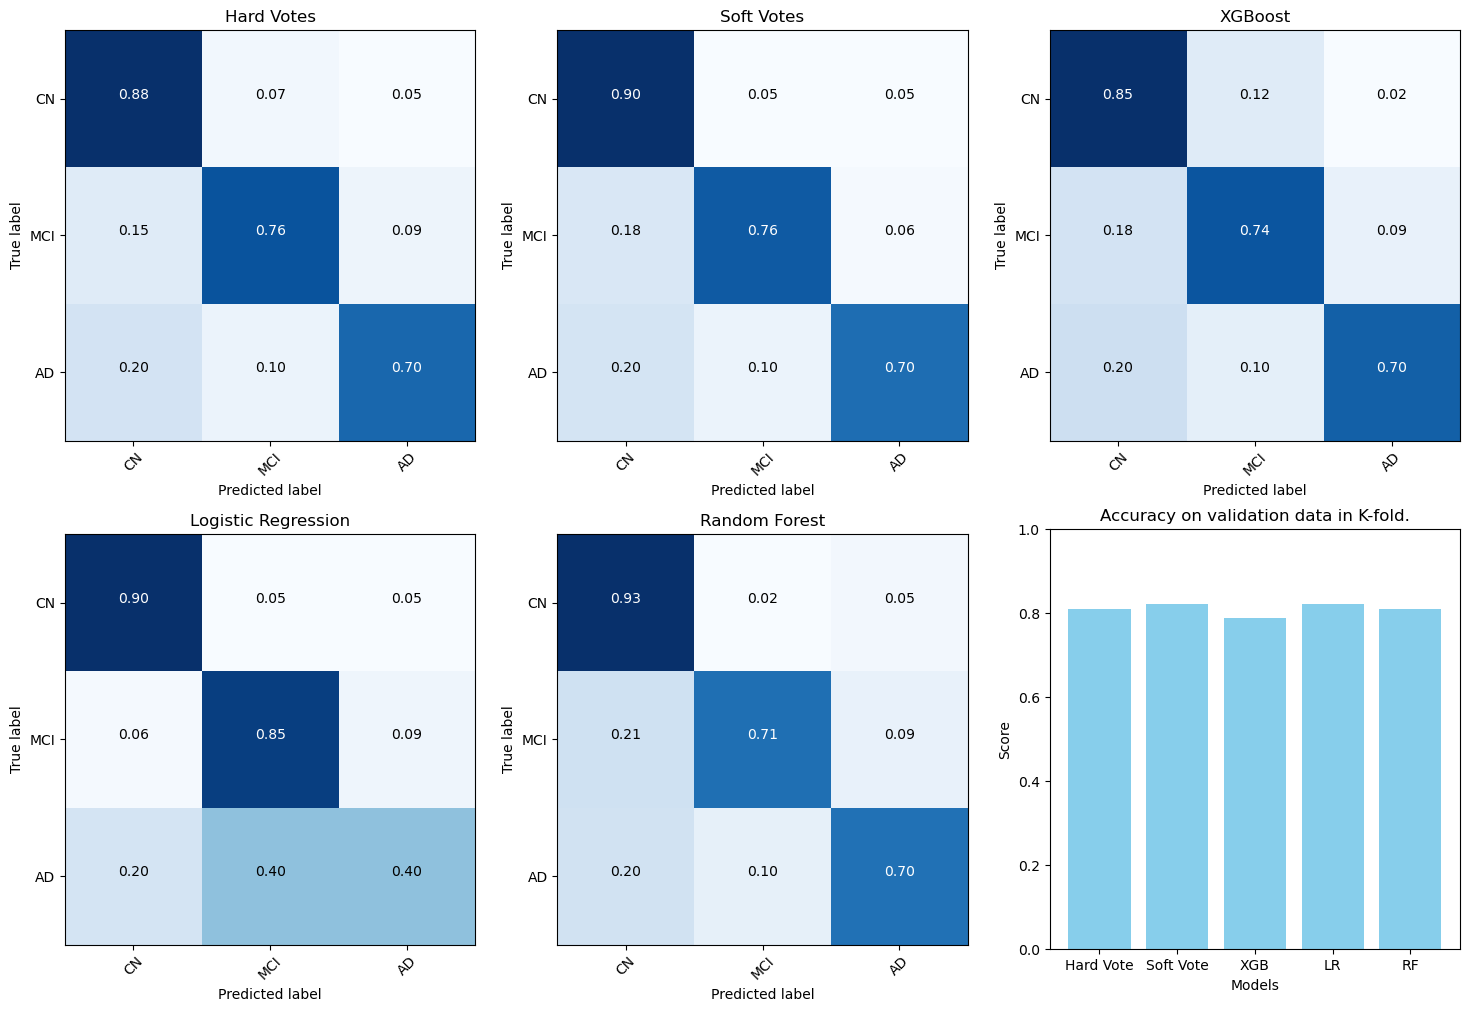

In [37]:
get_scores(all_models, votes, y_true, get_graphs=True)

In [51]:
RF_avg_feature_importance = get_average_feature_importance(all_models, "RF", df_main)
XGB_avg_feature_importance = get_average_feature_importance(all_models, "XGB", df_main)
LR_avg_feature_importance = get_average_feature_importance(all_models, "LR", df_main)

In [52]:
avg_feature_importance = calculate_average([RF_avg_feature_importance, XGB_avg_feature_importance, LR_avg_feature_importance])

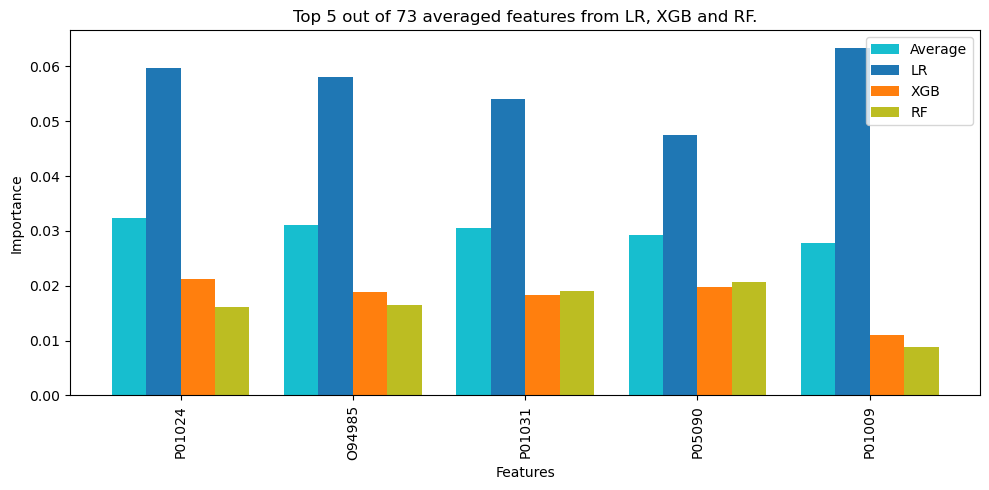

In [53]:
plot_feature_importance(avg_feature_importance, LR_avg_feature_importance, XGB_avg_feature_importance, RF_avg_feature_importance, models=["Average", "LR", "XGB", "RF"], main_model="Average")

In [54]:
top_features = sorted(avg_feature_importance.items(), key=lambda x: x[1], reverse=True)

## Test

In [81]:
df_stabl = df_main[list(aa)]

In [83]:
all_models, votes, y_true = pipeline(df_stabl, y, params_grid, tmt_set, bayes=False, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 2.8504059314727783 seconds.

LR 0 started.
LR 0 is done in 6.453963279724121 seconds.

RF 0 started.
RF 0 is done in 3.7638397216796875 seconds.

Hard vote F1 score: 0.7365079365079364
Soft vote F1 score: 0.8395061728395061

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 2.925769090652466 seconds.

LR 1 started.
LR 1 is done in 6.437453746795654 seconds.

RF 1 started.
RF 1 is done in 3.6956286430358887 seconds.

Hard vote F1 score: 0.8871252204585538
Soft vote F1 score: 0.8871252204585538

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 2.9142935276031494 seconds.

LR 2 started.
LR 2 is done in 6.805498361587524 seconds.

RF 2 started.
RF 2 is done in 3.5439984798431396 seconds.

Hard vote F1 score: 0.6518518518518519
Soft vote F1 score: 0.6490299823633158

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 2.77

XGB       	AUC OVR: 0.8462497026983482  	AUC OVO: 0.8335604973696795  	ACC: 0.6705882352941176  	F1: 0.6700910754519395
LR        	AUC OVR: 0.9003332659875829  	AUC OVO: 0.8913199426111907  	ACC: 0.8                 	F1: 0.7979713701075931
RF        	AUC OVR: 0.8714650488341938  	AUC OVO: 0.8868723098995694  	ACC: 0.7764705882352941  	F1: 0.7760565809901674
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.7764705882352941  	F1: 0.7796601630901547
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.788235294117647   	F1: 0.7857674877731413


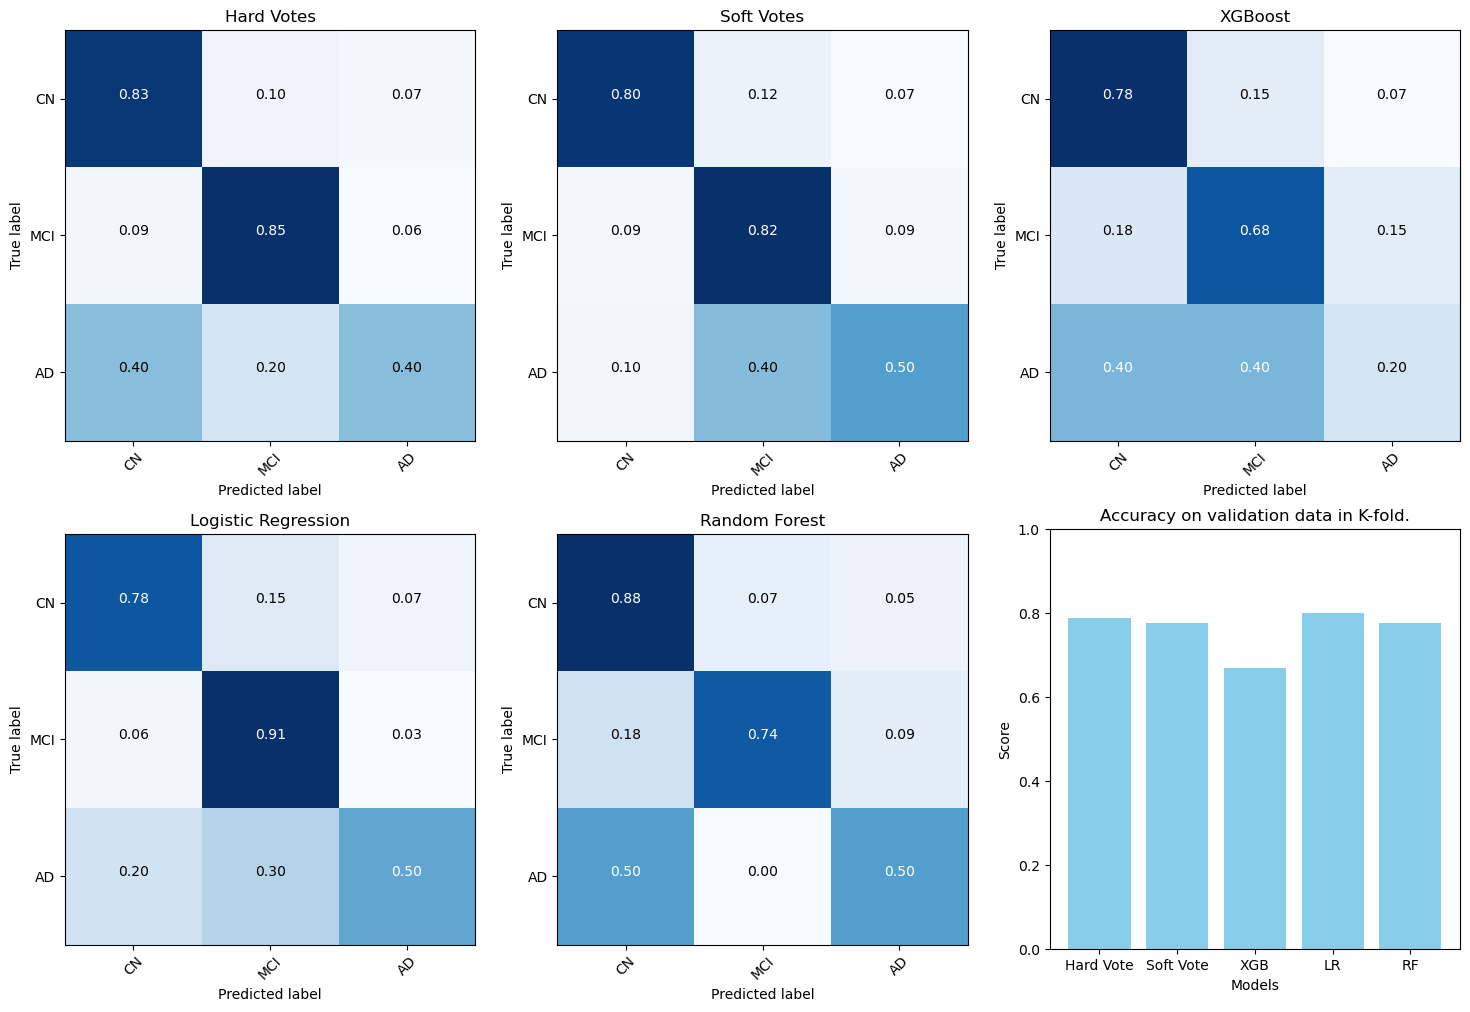

In [84]:
get_scores(all_models, votes, y_true, get_graphs=True)

In [32]:
RF_avg_feature_importance = get_average_feature_importance(all_models, "RF", df_stabl)
XGB_avg_feature_importance = get_average_feature_importance(all_models, "XGB", df_stabl)
LR_avg_feature_importance = get_average_feature_importance(all_models, "LR", df_stabl)

avg_feature_importance = calculate_average([RF_avg_feature_importance, XGB_avg_feature_importance, LR_avg_feature_importance])

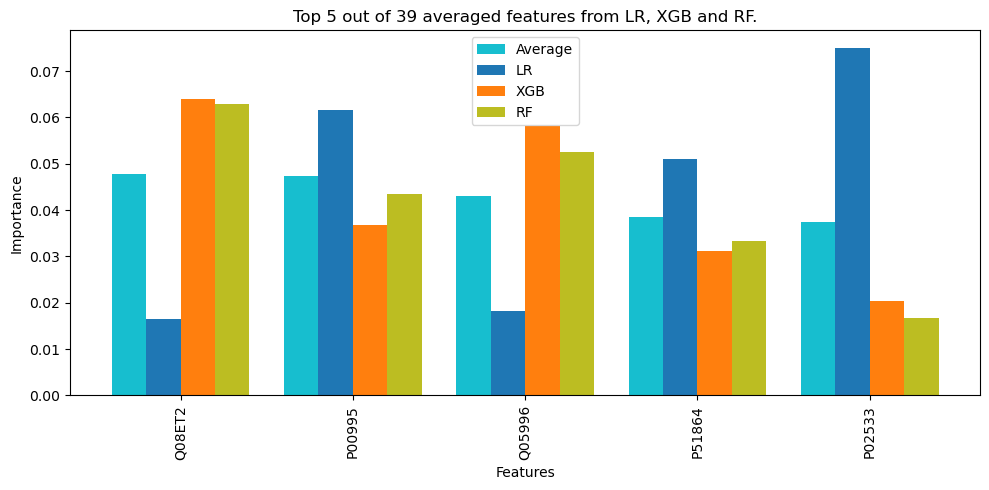

In [33]:
plot_feature_importance(avg_feature_importance, LR_avg_feature_importance, XGB_avg_feature_importance, RF_avg_feature_importance, models=["Average", "LR", "XGB", "RF"], main_model="Average")

In [34]:
top_features = sorted(avg_feature_importance.items(), key=lambda x: x[1], reverse=True)
top_features

[('Q08ET2', 0.04779560280803032),
 ('P00995', 0.047314344928332586),
 ('Q05996', 0.042950634847566886),
 ('P51864', 0.03846696993793413),
 ('P02533', 0.03739891814490928),
 ('P01766', 0.03724719686144606),
 ('P22891', 0.03696620973768125),
 ('A0A0G2JMI3', 0.034001923121325245),
 ('P07451', 0.03347535924882441),
 ('A0M8Q6', 0.03264780788216595),
 ('Q9UL62', 0.0314225228108489),
 ('A0A0B4J1V2', 0.029537667376460557),
 ('P01903', 0.02891128397619974),
 ('P02655', 0.028617340639700884),
 ('P00738', 0.027100079966139275),
 ('Q92887', 0.02698405394370364),
 ('P35527', 0.026864148417177797),
 ('P01742', 0.025484387319313448),
 ('A0A075B6I1', 0.02513702443984113),
 ('A0A0G2JS06', 0.023614799537492463),
 ('P05451', 0.02324432192451197),
 ('P13645', 0.02178560138118253),
 ('P02144', 0.02171445567274677),
 ('P68871', 0.021278712100292304),
 ('A0A0J9YXX1', 0.020099751161018777),
 ('A0A075B6R2', 0.019274827810931625),
 ('A0A0B4J1Y8', 0.018771905787319573),
 ('P01871', 0.0180012320989081),
 ('Q6NT04

# Biomarkers

In [141]:
all_models1, votes1, y_true1 = pipeline(df_union_s2, y, params_bayes, tmt_set, bayes=True, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 215.97926306724548 seconds.

LR 0 started.
LR 0 is done in 244.24101901054382 seconds.

RF 0 started.
RF 0 is done in 240.78999209403992 seconds.

Hard vote F1 score: 0.6151515151515151
Soft vote F1 score: 0.6151515151515151

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 260.57547402381897 seconds.

LR 1 started.
LR 1 is done in 208.9663326740265 seconds.

RF 1 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 5, 'sqrt', 1, 500, -1] before, using random point ['entropy', 39, 'sqrt', 3, 249, -1]
  warnings.warn(


RF 1 is done in 172.44871735572815 seconds.

Hard vote F1 score: 0.7984126984126985
Soft vote F1 score: 0.7984126984126985

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 117.36638045310974 seconds.

LR 2 started.
LR 2 is done in 100.16313433647156 seconds.

RF 2 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 'log2', 1, 302, -1] before, using random point ['gini', 8, 'log2', 4, 71, -1]
  warnings.warn(


RF 2 is done in 112.08431792259216 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 0.8

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 117.43757319450378 seconds.

LR 3 started.
LR 3 is done in 89.24598288536072 seconds.

RF 3 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 48, 'log2', 1, 500, -1] before, using random point ['gini', 25, 'sqrt', 4, 139, -1]
  warnings.warn(


RF 3 is done in 116.53961110115051 seconds.

Hard vote F1 score: 0.8545454545454545
Soft vote F1 score: 0.8545454545454545

K-Fold validation: Iteration 4.
XGB 4 started.
XGB 4 is done in 112.32213401794434 seconds.

LR 4 started.
LR 4 is done in 93.47750997543335 seconds.

RF 4 started.
RF 4 is done in 116.02589392662048 seconds.

Hard vote F1 score: 0.8373015873015873
Soft vote F1 score: 0.8373015873015873

K-Fold validation: Iteration 5.
XGB 5 started.
XGB 5 is done in 99.99271178245544 seconds.

LR 5 started.
LR 5 is done in 96.07837295532227 seconds.

RF 5 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 5, 'log2', 1, 500, -1] before, using random point ['entropy', 8, 'log2', 1, 306, -1]
  warnings.warn(


RF 5 is done in 114.0103051662445 seconds.

Hard vote F1 score: 0.9
Soft vote F1 score: 0.9

K-Fold validation: Iteration 6.
XGB 6 started.
XGB 6 is done in 109.79046678543091 seconds.

LR 6 started.
LR 6 is done in 90.28464913368225 seconds.

RF 6 started.
RF 6 is done in 111.42311191558838 seconds.

Hard vote F1 score: 0.8974025974025974
Soft vote F1 score: 0.8

K-Fold validation: Iteration 7.
XGB 7 started.
XGB 7 is done in 113.84424018859863 seconds.

LR 7 started.
LR 7 is done in 86.29842567443848 seconds.

RF 7 started.
RF 7 is done in 109.90231156349182 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 1.0

K-Fold validation: Iteration 8.
XGB 8 started.
XGB 8 is done in 114.1652250289917 seconds.

LR 8 started.
LR 8 is done in 79.39633584022522 seconds.

RF 8 started.
RF 8 is done in 112.2688148021698 seconds.

Hard vote F1 score: 0.7833333333333332
Soft vote F1 score: 0.7833333333333332

K-Fold validation: Iteration 9.
XGB 9 started.
XGB 9 is done in 123.34190249443054 seco

XGB       	AUC OVR: 0.9123596101887056  	AUC OVO: 0.9129509134698549  	ACC: 0.8118811881188119  	F1: 0.8123374062567772
LR        	AUC OVR: 0.9184834251258746  	AUC OVO: 0.9150665974744854  	ACC: 0.7920792079207921  	F1: 0.7955220593130113
RF        	AUC OVR: 0.8835246086759665  	AUC OVO: 0.8947181083922132  	ACC: 0.7623762376237624  	F1: 0.7602525966882403
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8415841584158416  	F1: 0.8430329464077998
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8613861386138614  	F1: 0.8620130662538034


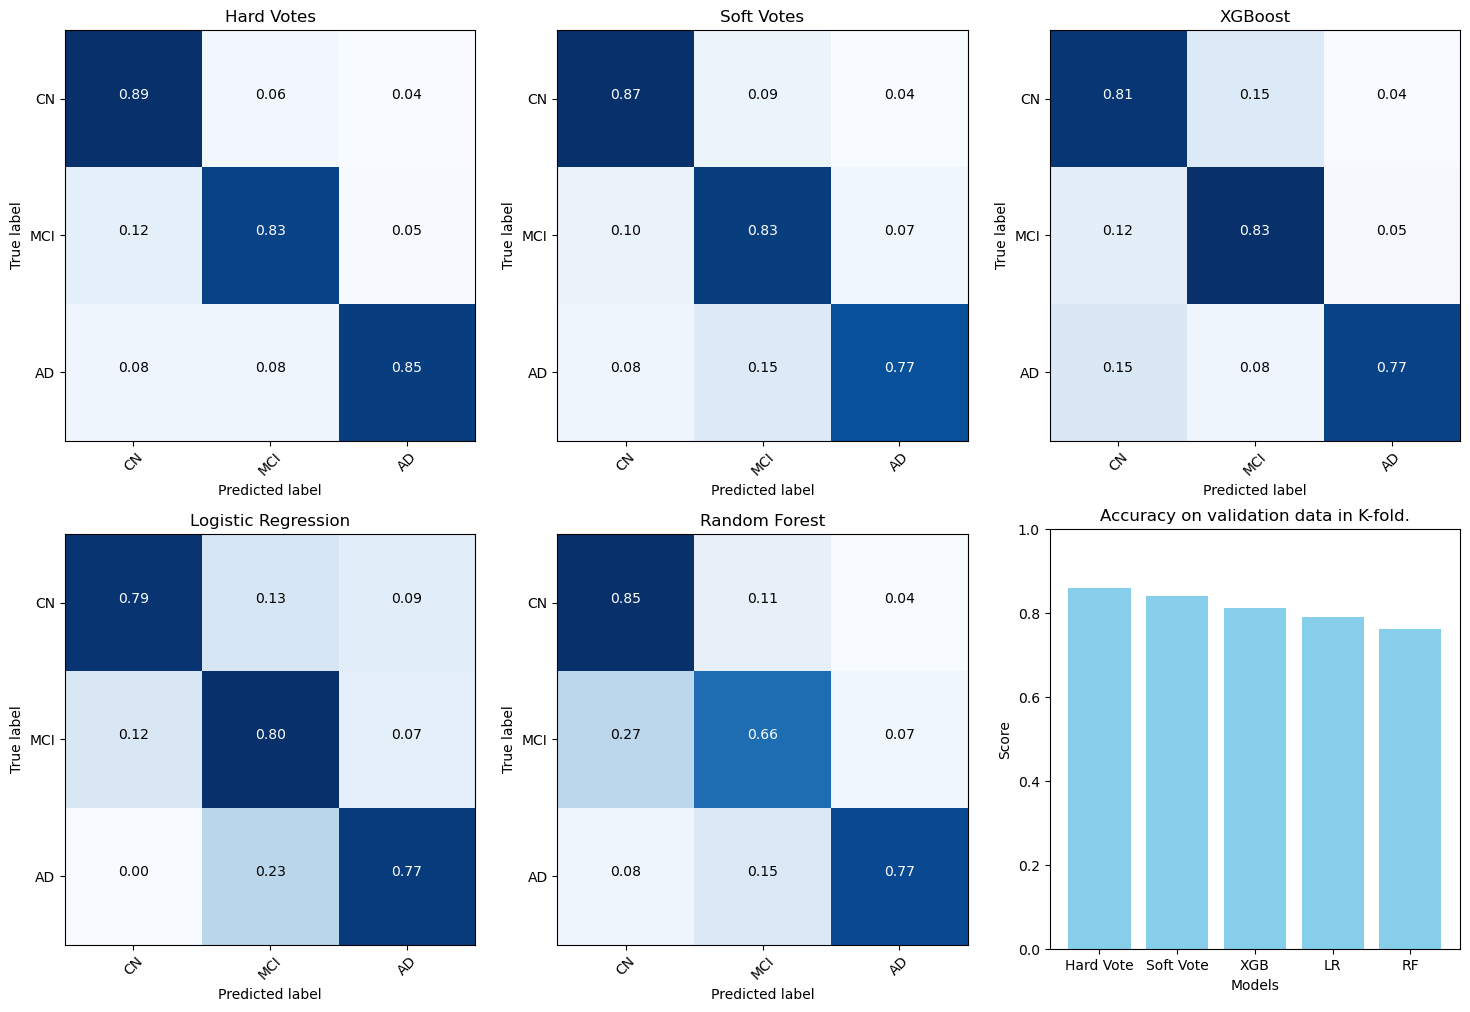

In [142]:
get_scores(all_models1, votes1, y_true1, get_graphs=True)

In [143]:
all_models2, votes2, y_true2 = pipeline(df_union_s2, y, params_bayes_simple, tmt_set, bayes=True, do_smote=False)


-------------- Starting K-fold cross validation: --------------

K-Fold validation: Iteration 0.
XGB 0 started.
XGB 0 is done in 111.0880012512207 seconds.

LR 0 started.
LR 0 is done in 93.77179169654846 seconds.

RF 0 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 18, 'log2', 1, 500, -1] before, using random point ['entropy', 41, 'log2', 4, 310, -1]
  warnings.warn(


RF 0 is done in 119.37705731391907 seconds.

Hard vote F1 score: 0.7480519480519482
Soft vote F1 score: 0.8158205430932703

K-Fold validation: Iteration 1.
XGB 1 started.
XGB 1 is done in 112.64150786399841 seconds.

LR 1 started.
LR 1 is done in 95.34497117996216 seconds.

RF 1 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 15, 'sqrt', 1, 500, -1] before, using random point ['entropy', 43, 'sqrt', 4, 305, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 50, 'log2', 1, 500, -1] before, using random point ['gini', 49, 'log2', 2, 143, -1]
  warnings.warn(
c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 9, 'sqrt', 1, 500, -1] before, using random point ['gini', 6, 'log2', 3, 386, -1]
  warnings.warn(


RF 1 is done in 117.02216339111328 seconds.

Hard vote F1 score: 0.8984126984126984
Soft vote F1 score: 0.8984126984126984

K-Fold validation: Iteration 2.
XGB 2 started.
XGB 2 is done in 108.33821320533752 seconds.

LR 2 started.
LR 2 is done in 88.93717408180237 seconds.

RF 2 started.
RF 2 is done in 115.58659863471985 seconds.

Hard vote F1 score: 0.9028571428571428
Soft vote F1 score: 0.9028571428571428

K-Fold validation: Iteration 3.
XGB 3 started.
XGB 3 is done in 109.65883469581604 seconds.

LR 3 started.
LR 3 is done in 90.52359747886658 seconds.

RF 3 started.


c:\Users\Toffe\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['entropy', 6, 'log2', 1, 499, -1] before, using random point ['entropy', 27, 'log2', 2, 487, -1]
  warnings.warn(


RF 3 is done in 104.76997303962708 seconds.

Hard vote F1 score: 0.7644444444444445
Soft vote F1 score: 0.7644444444444445

K-Fold validation: Iteration 4.
XGB 4 started.
XGB 4 is done in 115.98264956474304 seconds.

LR 4 started.
LR 4 is done in 91.38907241821289 seconds.

RF 4 started.
RF 4 is done in 107.87192606925964 seconds.

Hard vote F1 score: 1.0
Soft vote F1 score: 0.9095238095238095

K-Fold validation: Iteration 5.
XGB 5 started.
XGB 5 is done in 104.4759726524353 seconds.

LR 5 started.
LR 5 is done in 75.3714325428009 seconds.

RF 5 started.
RF 5 is done in 107.11738157272339 seconds.

Hard vote F1 score: 0.8095238095238095
Soft vote F1 score: 0.696969696969697

K-Fold validation: Iteration 6.
XGB 6 started.
XGB 6 is done in 114.43827962875366 seconds.

LR 6 started.
LR 6 is done in 95.47814631462097 seconds.

RF 6 started.
RF 6 is done in 107.81430840492249 seconds.

Hard vote F1 score: 0.6666666666666667
Soft vote F1 score: 0.6666666666666667

K-Fold validation: Iteratio

XGB       	AUC OVR: 0.9198678634978584  	AUC OVO: 0.914474472076963   	ACC: 0.8217821782178217  	F1: 0.821056830957821
LR        	AUC OVR: 0.9263815777654214  	AUC OVO: 0.9236823546631538  	ACC: 0.8118811881188119  	F1: 0.8171073021280623
RF        	AUC OVR: 0.8931952744571668  	AUC OVO: 0.9001370537436961  	ACC: 0.8118811881188119  	F1: 0.8113579072901418
Soft Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8316831683168316  	F1: 0.832710381523726
Hard Vote 	AUC OVR:                     	AUC OVO:                     	ACC: 0.8415841584158416  	F1: 0.8426041780002177


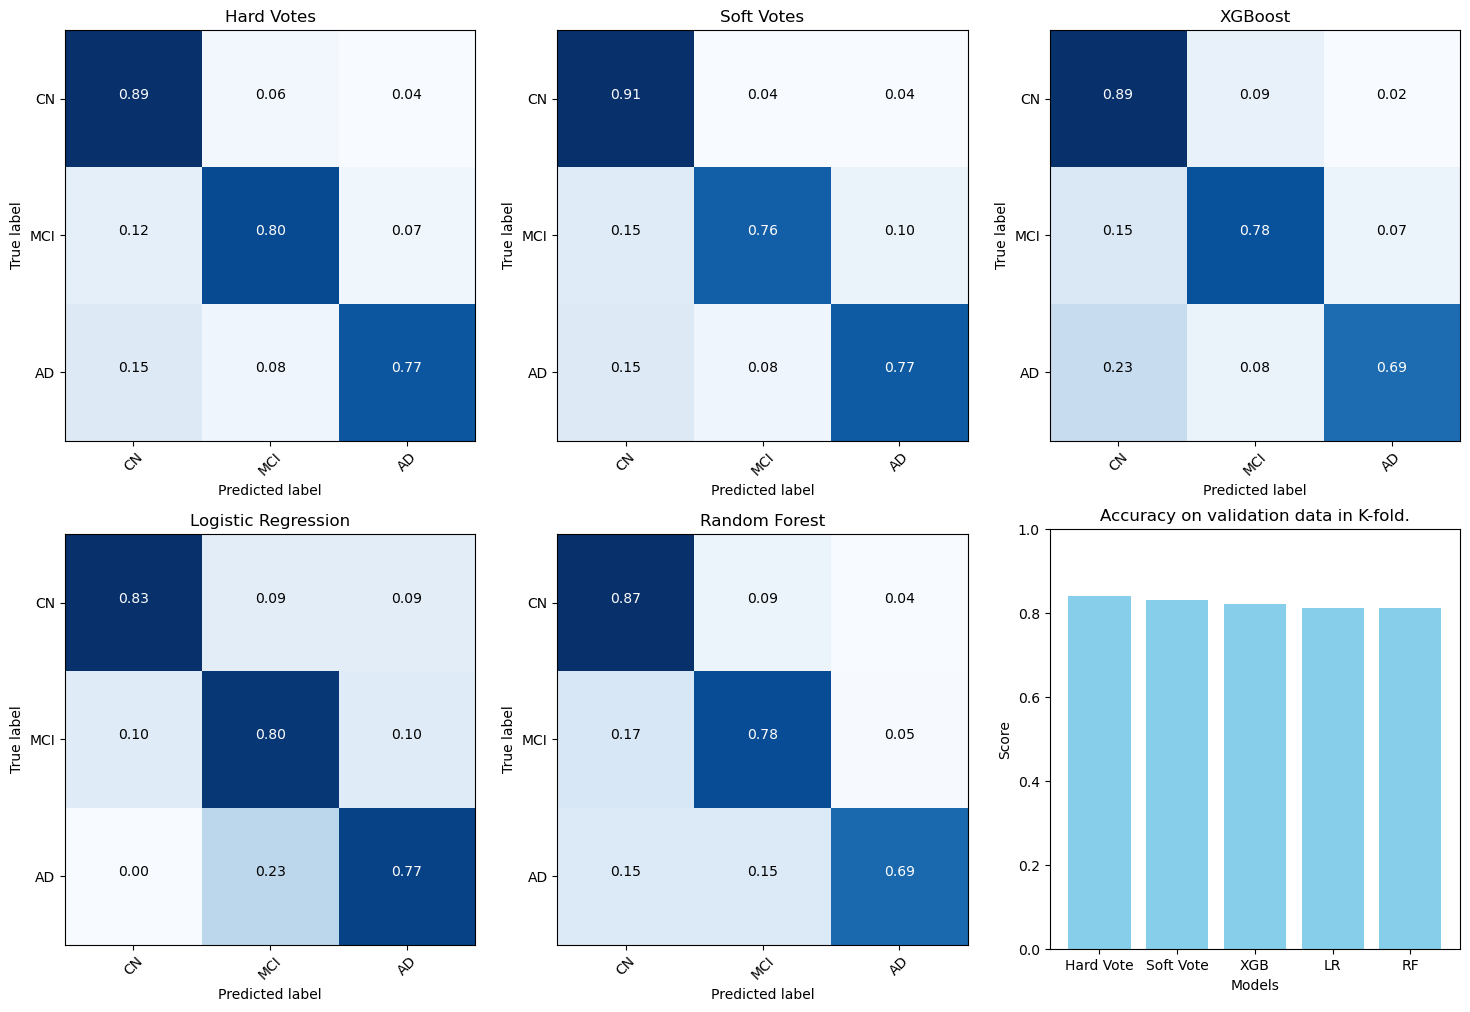

In [144]:
get_scores(all_models2, votes2, y_true2, get_graphs=True)